In [175]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from IPython.display import display, HTML
import csv
import os
import logging
import math
import re
import json

In [176]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [177]:
PATH_TO_CSVS = 'data/raw'
PATH_TO_JSON = 'data/raw/descvar.json'

In [178]:
# https://stackoverflow.com/questions/46135839/auto-detect-the-delimiter-in-a-csv-file-using-pd-read-csv comme base
# detecte automatiquement le sep d'un fichier csv


def get_delimiter(file_path, bytes=4096):
    try:
        with open(file_path, 'r') as file:
            data = file.read(bytes)
        sniffer = csv.Sniffer()
        delimiter = sniffer.sniff(data).delimiter
        return delimiter
    except Exception as e:
        logging.error(f"Erreur lors de la détection du délimiteur: {e}")
        return None

In [179]:
# lecture d'un fichier csv en essayant différents encodage.


def read_csv_file(file_path):
    if not os.path.exists(file_path):
        return None, False, f"Fichier non trouvé: {file_path}"
    
    delimiter = get_delimiter(file_path)
    if not delimiter:
        return None, False, f"Impossible de détecter le délimiteur pour le fichier: {file_path}"
    
    encodings = ['utf-8', 'latin1', 'ISO-8859-1']
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, low_memory=False, encoding=encoding, delimiter=delimiter)
            return df, True, None
        except (UnicodeDecodeError, pd.errors.ParserError) as e:
            logging.warning(f"Erreur avec l'encodage {encoding} pour le fichier {file_path}: {e}")
    
    return None, False, f"Impossible de lire le fichier {file_path} avec les encodages: {encodings}."

In [180]:
# chargement des datasets dans des listes


def load_datasets(prefixes, years, base_path= PATH_TO_CSVS):
    dataframes = []
    
    for prefix in prefixes:
        datasets = []
        for year in years:
            connector = '_' if year <= 2016 else '-'
            file_name = os.path.join(base_path, f'{prefix}{connector}{year}.csv')
            df, success, error = read_csv_file(file_name)
            if success:
                datasets.append({file_name: df})
            else:
                logging.error(error)
        dataframes.append(datasets)
    
    return dataframes

In [181]:
years = list(range(2005, 2023))
prefixes= ['caracteristiques', 'lieux', 'usagers', 'vehicules']

dataframes = load_datasets(prefixes, years)

# log
for prefix, df_list in zip(prefixes, dataframes):
        logging.info(f'{prefix}: {len(df_list)} datasets chargés.')

logging.info(f'Total datasets chargés: {sum(len(dfs) for dfs in dataframes)}.')

2024-06-12 13:24:15,621 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2005.csv: 'utf-8' codec can't decode byte 0xe9 in position 13: invalid continuation byte


2024-06-12 13:24:15,819 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2006.csv: 'utf-8' codec can't decode byte 0xb0 in position 6: invalid start byte
2024-06-12 13:24:16,000 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2007.csv: 'utf-8' codec can't decode byte 0xe9 in position 1: invalid continuation byte
2024-06-12 13:24:16,162 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2008.csv: 'utf-8' codec can't decode byte 0xf4 in position 17: invalid continuation byte
2024-06-12 13:24:16,408 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2010.csv: 'utf-8' codec can't decode byte 0xe9 in position 8: invalid continuation byte
2024-06-12 13:24:16,556 - WARNING - Erreur avec l'encodage utf-8 pour le fichier data/raw\caracteristiques_2011.csv: 'utf-8' codec can't decode byte 0xe9 in position 5: invalid continuation byte
2024-06-12 13:24:16,719 - WARNI

In [182]:
def extract_year(file_name):
    match = re.search(r'(\d{4})\.csv$', file_name)
    if match:
        return match.group(1)
    else:
        return None

In [183]:
#génère le menu
def generate_navigation_menu(columns, dataset_name):
    links = [f'<a href="#{dataset_name}_{col}">{col}</a>' for col in columns]
    return f'<div id="menu_{dataset_name}"><h2>Menu {dataset_name}</h2><ul>{"".join(f"<li>{link}</li>" for link in links)}</ul></div>'

In [184]:
#création d'une grille de boxplot
def create_boxplot_grid(column, datasets):

    if not any(pd.api.types.is_numeric_dtype(df[column]) for dataset in datasets for file_name, df in dataset.items() if column in df.columns):
        logging.info(f"La colonne {column} n'est pas numérique.")
        return

    n_datasets = len(datasets)
    n_cols = 5
    n_rows = math.ceil(n_datasets / n_cols)
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, n_rows * 2), squeeze=False)
    fig.suptitle(f'Boxplots pour: {column}', fontsize=16)
    
    for ax, dataset in zip(axes.flatten(), datasets):
        for file_name, df in dataset.items():
            if column in df.columns and pd.api.types.is_numeric_dtype(df[column]):
                ax.boxplot(df[column].dropna(), vert=True)
                ax.set_title(extract_year(file_name))
                ax.set_xlabel(column)
                ax.set_ylabel('Valeurs')
    
    # Masquer les axes non utilisés
    for ax in axes.flatten()[n_datasets:]:
        ax.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [185]:
#création du bar plot pour visualiser la distribution des modalités.
def create_total_stacked_barplot(column, datasets, max_modalities=50):
    modality_counts = {}

    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                modality_count = df[column].value_counts()
                modality_counts[file_name] = modality_count
    
    all_modalities = set()
    for counts in modality_counts.values():
        all_modalities.update(counts.index)
    
    if len(all_modalities) > max_modalities:
        logging.warning(f"Le nombre de modalités uniques dans la colonne {column} excède le seuil de {max_modalities}. Auncun bar plot généré.")
        return
    
    modality_data = {modality: [] for modality in all_modalities}
    years = [extract_year(file_name) for file_name in modality_counts.keys()]
    
    for modality in all_modalities:
        for file_name in modality_counts.keys():
            count = modality_counts[file_name].get(modality, 0)
            modality_data[modality].append(count)
    
    df_modalities = pd.DataFrame(modality_data, index=years).transpose()
    
    df_modalities.plot(kind='bar', stacked=True, figsize=(15, 7), colormap='viridis')
    plt.title(f'{column}')
    plt.xlabel('Modalités')
    plt.ylabel('Count')
    plt.legend(title='Years', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [186]:
# evolution de la répartition 
def create_lineplot_evolution(column, datasets, max_modalities=12):
    modality_counts = {}

    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                year = extract_year(file_name)
                modality_count = df[column].value_counts(normalize=True) * 100
                if year not in modality_counts:
                    modality_counts[year] = modality_count
                else:
                    modality_counts[year] = modality_counts[year].add(modality_count, fill_value=0)
    
    all_modalities = set()
    for counts in modality_counts.values():
        all_modalities.update(counts.index)
    
    if len(all_modalities) > max_modalities:
        logging.warning(f"Le nombre de modalités uniques dans la colonne {column} excède le seuil de {max_modalities}. Aucun graphique en ligne généré.")
        return
    
    modality_data = {modality: [] for modality in all_modalities}
    years = sorted(modality_counts.keys())
    
    for modality in all_modalities:
        for year in years:
            count = modality_counts[year].get(modality, 0)
            modality_data[modality].append(count)
    
    df_modalities = pd.DataFrame(modality_data, index=years)
    
    df_modalities.plot(kind='line', figsize=(15, 7), marker='o')
    plt.title(f'Evolution de la distribution {column}')
    plt.xlabel('Années')
    plt.ylabel('Proportion (%)')
    plt.legend(title='Modalités', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [187]:
# permet d'afficher les info depuis le json
def display_variable_info(col_name, dataset_name, descvar):
    dataset_name_upper = dataset_name.upper()
    if dataset_name_upper in descvar:
        section = descvar[dataset_name_upper]
        if col_name in section:
            details = section[col_name]
            if isinstance(details, dict):    
                description = details.get('description', 'Pas de description.')
                modalities = details.get('modalities', {})
                
                print(f"Description: {description}")
                if modalities:
                    print("\nModalités:")
                    for key, value in modalities.items():
                        print(f"- {key}: {value}")
            else:
                print(f"Description: {details}")
            return
    logging.info(f"Pas de description pour `{col_name}` dans la section `{dataset_name_upper}`.")

In [188]:
# analyse une colonne unique
def analyze_column(column, datasets, total_rows, dataset_name, descvar= None):
    column_results = []
    
    for dataset in datasets:
        for file_name, df in dataset.items():
            if column in df.columns:
                col_type = df[column].dtype
                col_mode = df[column].mode()[0] if not df[column].mode().empty else "N/A"
                null_proportion_file = df[column].isnull().mean() *100
                null_proportion_total = df[column].isnull().sum() / total_rows
                column_results.append([
                    extract_year(file_name), 
                    col_type, 
                    col_mode, 
                    null_proportion_file, 
                    null_proportion_total
                ])
    
    if column_results:
        display(HTML(f'<div id="{dataset_name}_{column}"><h2>Colonne: {column}</h2>'))
        print(f"lignes: {total_rows}\n")
        display_variable_info(column, dataset_name, descvar)
        print(tabulate(column_results, headers=[
            "Année", "Type", "Mode", 
            "Proportion valeurs nulles (fichier)", 
            "Proportion valeurs nulles (total)"
        ]))
        
        #if any(pd.api.types.is_numeric_dtype(df[column]) for dataset in datasets for file_name, df in dataset.items() if column in df.columns):
        create_boxplot_grid(column, datasets) 
        create_total_stacked_barplot(column, datasets)
        create_lineplot_evolution(column, datasets)

        display(HTML(f'<p><a href="#menu_{dataset_name}">Retour au menu</a></p></div>'))


In [189]:
# on analyse toutes les colonnes à la suite
def analyze_all_columns(datasets, dataset_name, descvar= None):
    
    logging.info(f'Chargement de {dataset_name}.')
    
    all_columns = set()

    for dataset in datasets: 
        for file_name, df in dataset.items():
            all_columns.update(df.columns)
    
    total_rows = sum(df.shape[0] for dataset in datasets for file_name, df in dataset.items())
    
    navigation_menu = generate_navigation_menu(all_columns, dataset_name) 
    display(HTML(navigation_menu))

    #traitement pour chaque colonne
    for column in all_columns:
        analyze_column(column, datasets, total_rows, dataset_name, descvar= descvar)
            

2024-06-12 13:24:23,366 - INFO - Chargement de caracteristiques.


lignes: 1176873

Description: Département : Code INSEE du département (2A Corse-du-Sud – 2B Haute-Corse).
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64      750                                      0                                    0
   2006  int64      750                                      0                                    0
   2007  int64      750                                      0                                    0
   2008  int64      750                                      0                                    0
   2009  int64      750                                      0                                    0
   2010  int64      750                                      0                                    0
   2011  int64      750                                      0                                

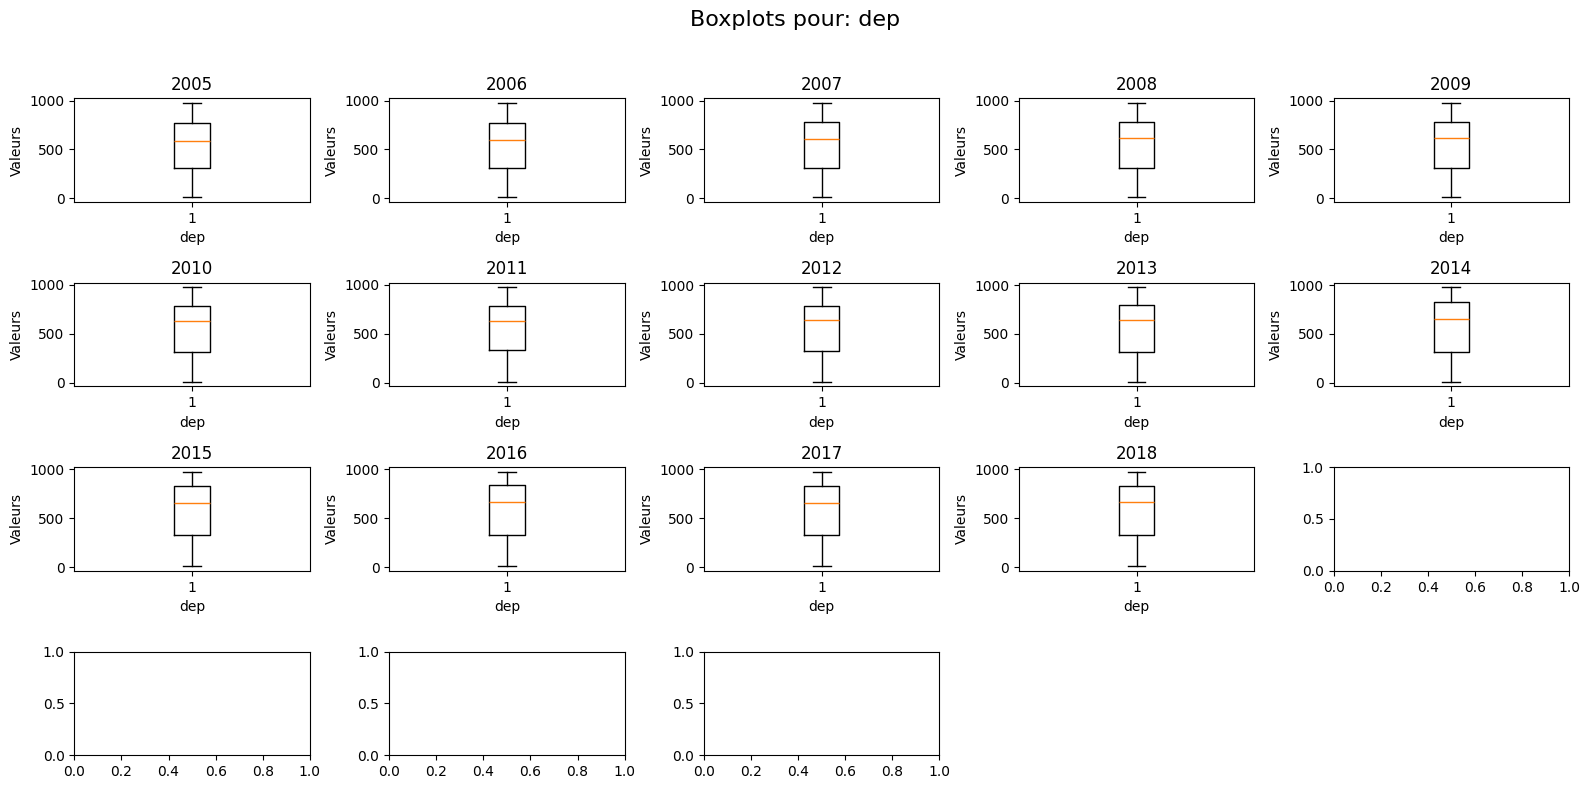

2024-06-12 13:24:24,889 - WARNING - Le nombre de modalités uniques dans la colonne dep excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:24:24,911 - WARNING - Le nombre de modalités uniques dans la colonne dep excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Lumière : conditions d’éclairage dans lesquelles l'accident s'est produit :

Modalités:
- 1: Plein jour
- 2: Crépuscule ou aube
- 3: Nuit sans éclairage public
- 4: Nuit avec éclairage public non allumé
- 5: Nuit avec éclairage public allumé
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        1                                      0                                    0
   2006  int64        1                                      0                                    0
   2007  int64        1                                      0                                    0
   2008  int64        1                                      0                                    0
   2009  int64        1                                      0                                    0
   2010  int64        1     

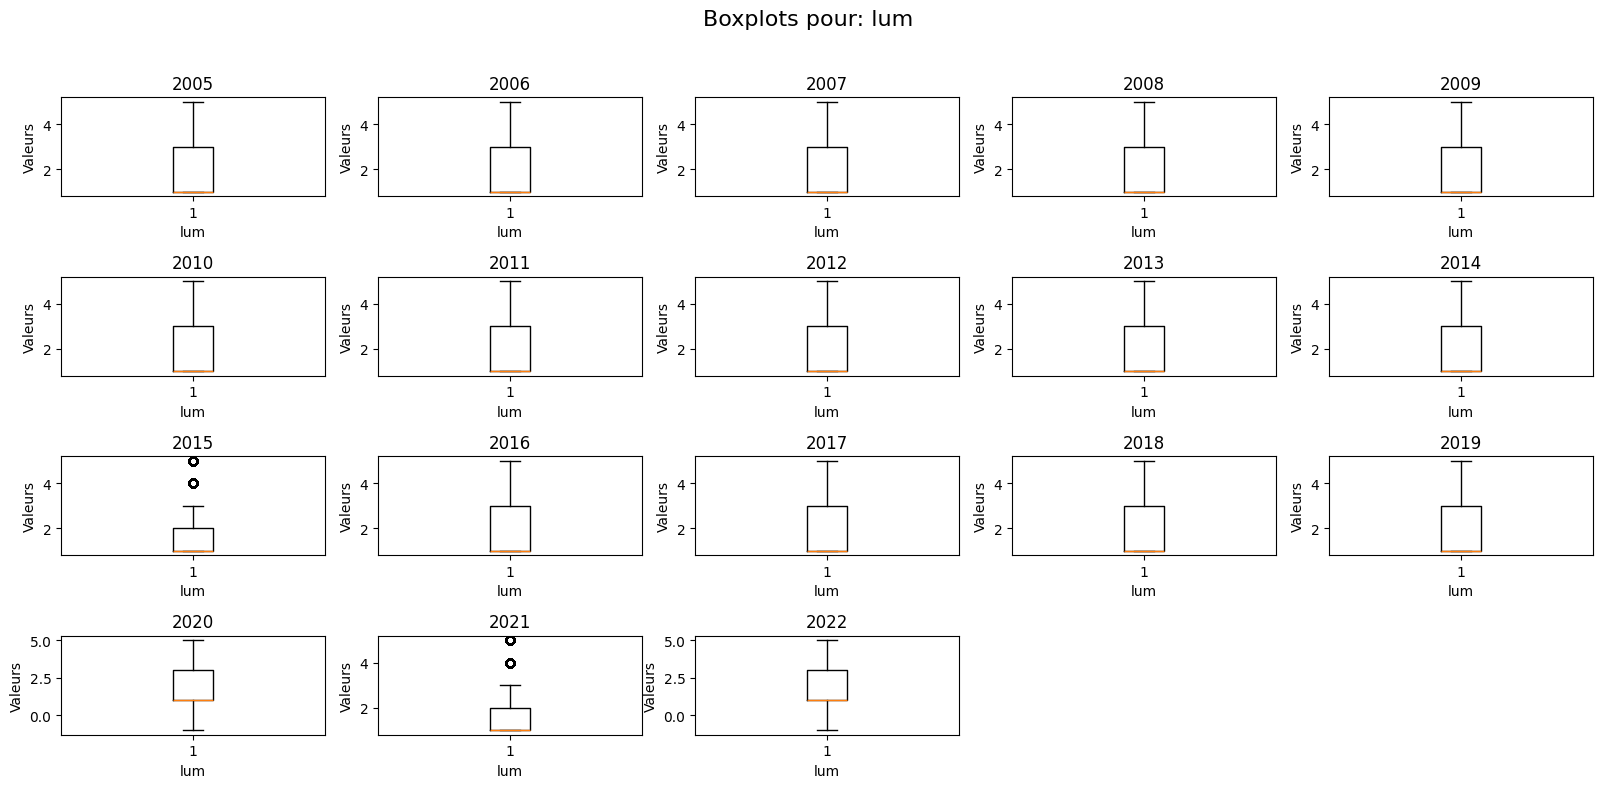

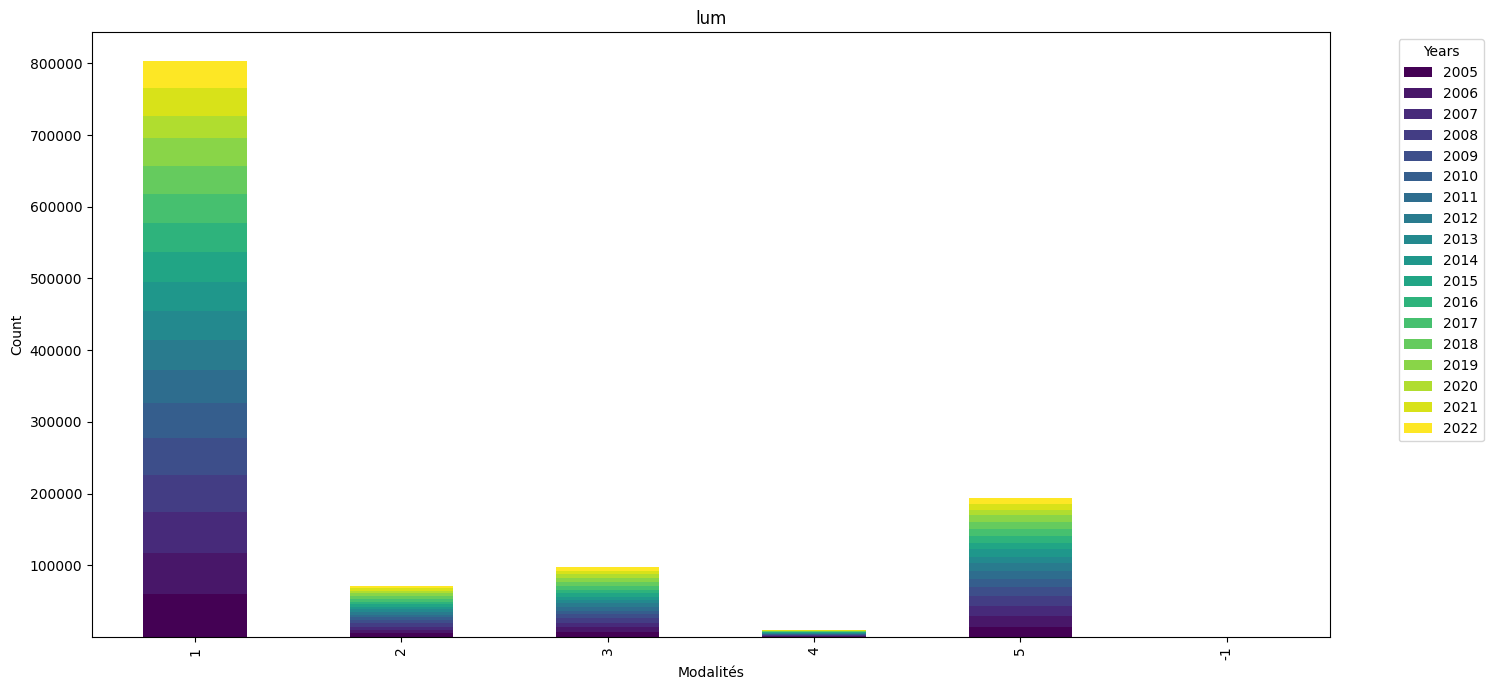

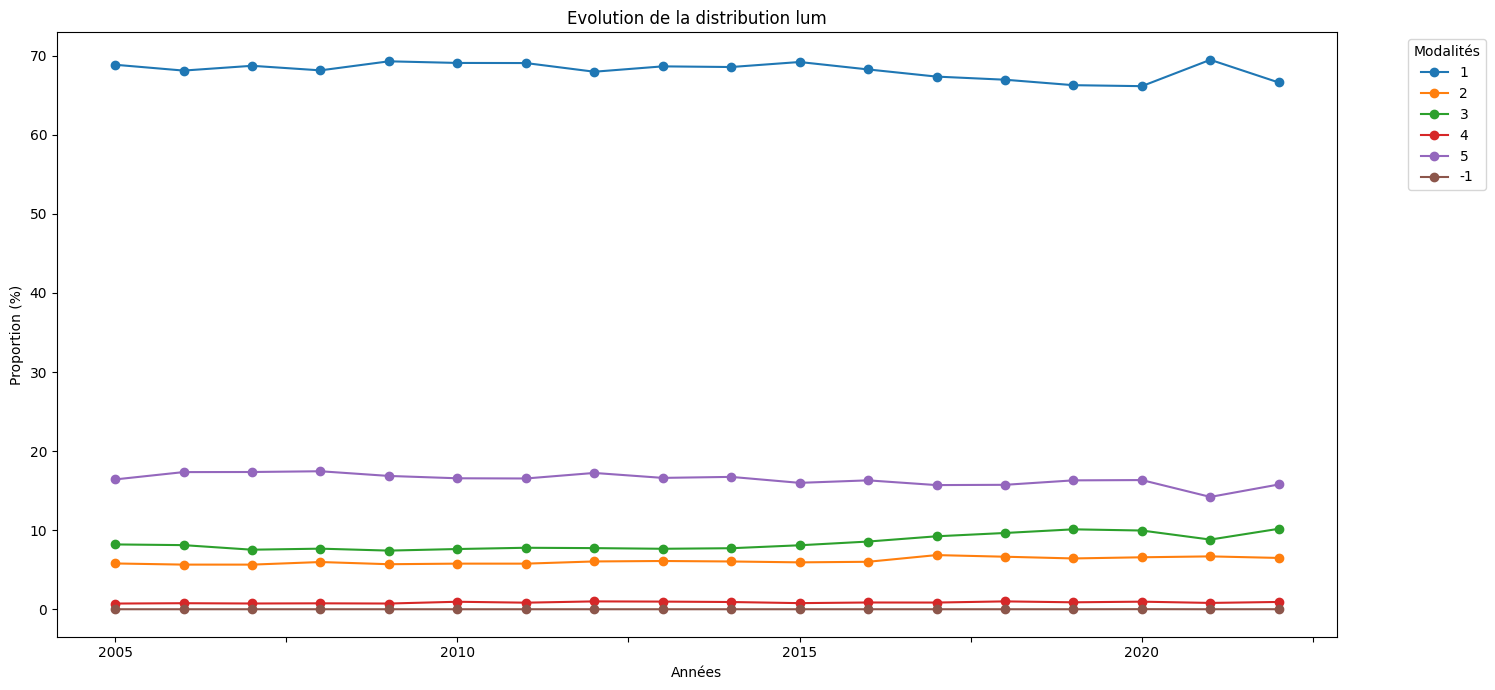

lignes: 1176873

Description: Longitude
  Année  Type     Mode               Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ---------------  -------------------------------------  -----------------------------------
   2005  float64  0.0                                           69.0403                            0.0510531
   2006  float64  0.0                                           70.7686                            0.049906
   2007  float64  0.0                                           71.9129                            0.0512366
   2008  float64  0.0                                           71.8056                            0.0468385
   2009  object   0                                             54.9813                            0.0347625
   2010  float64  0.0                                           54.5064                            0.0321326
   2011  float64  0.0                                           54.1748                

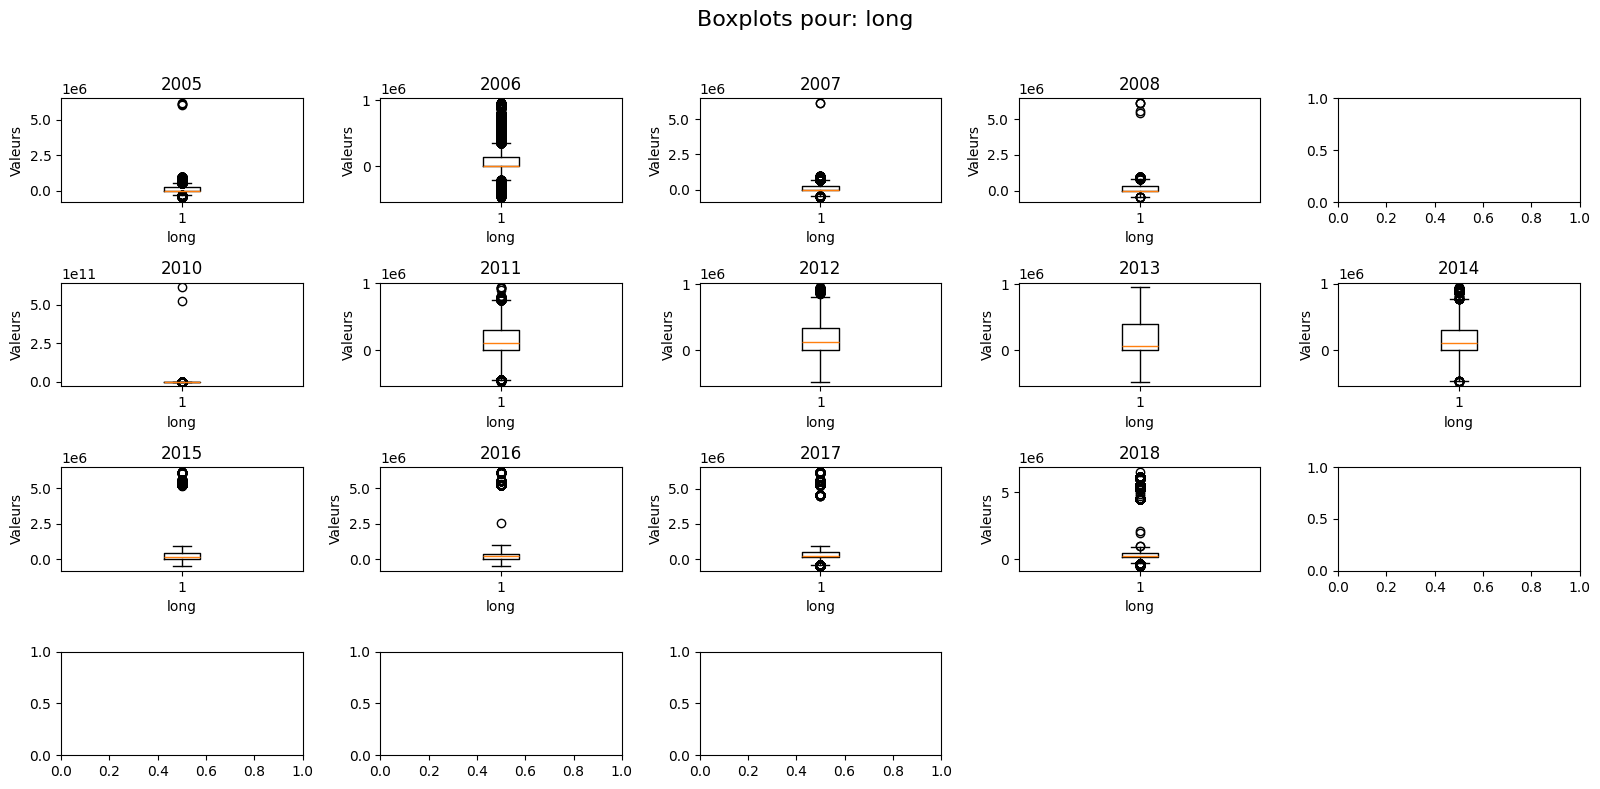

2024-06-12 13:24:29,123 - WARNING - Le nombre de modalités uniques dans la colonne long excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:24:29,346 - WARNING - Le nombre de modalités uniques dans la colonne long excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-12 13:24:29,374 - INFO - Pas de description pour `Accident_Id` dans la section `CARACTERISTIQUES`.


lignes: 1176873

  Année  Type         Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2022  int64   2.022e+11                                      0                                    0


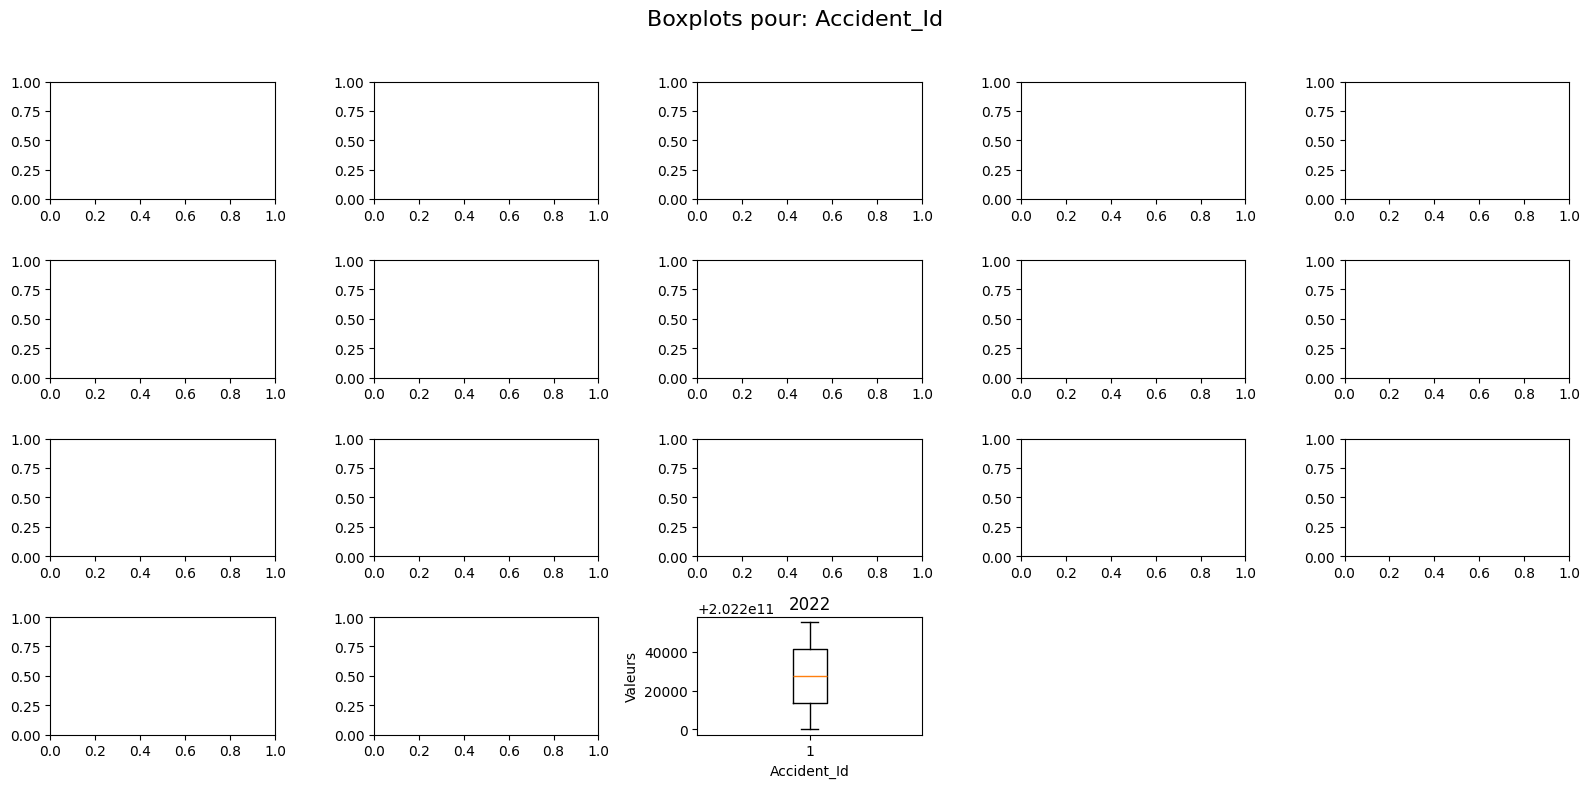

2024-06-12 13:24:30,886 - WARNING - Le nombre de modalités uniques dans la colonne Accident_Id excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:24:30,899 - WARNING - Le nombre de modalités uniques dans la colonne Accident_Id excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Jour de l'accident.
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64       19                                      0                                    0
   2006  int64       13                                      0                                    0
   2007  int64        6                                      0                                    0
   2008  int64        4                                      0                                    0
   2009  int64       17                                      0                                    0
   2010  int64       15                                      0                                    0
   2011  int64        8                                      0                                    0
   2012  int64       21                           

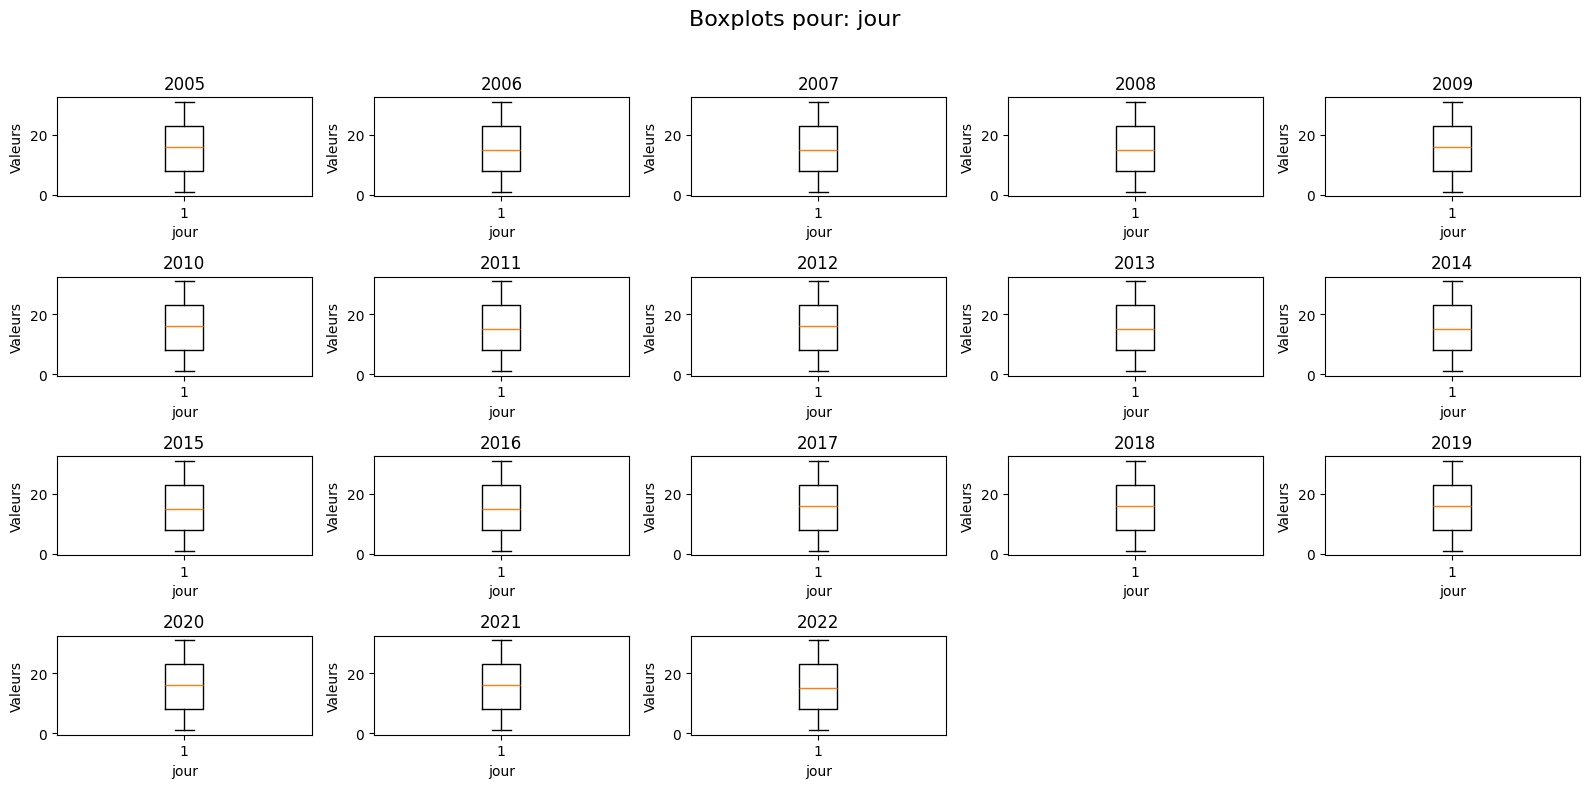

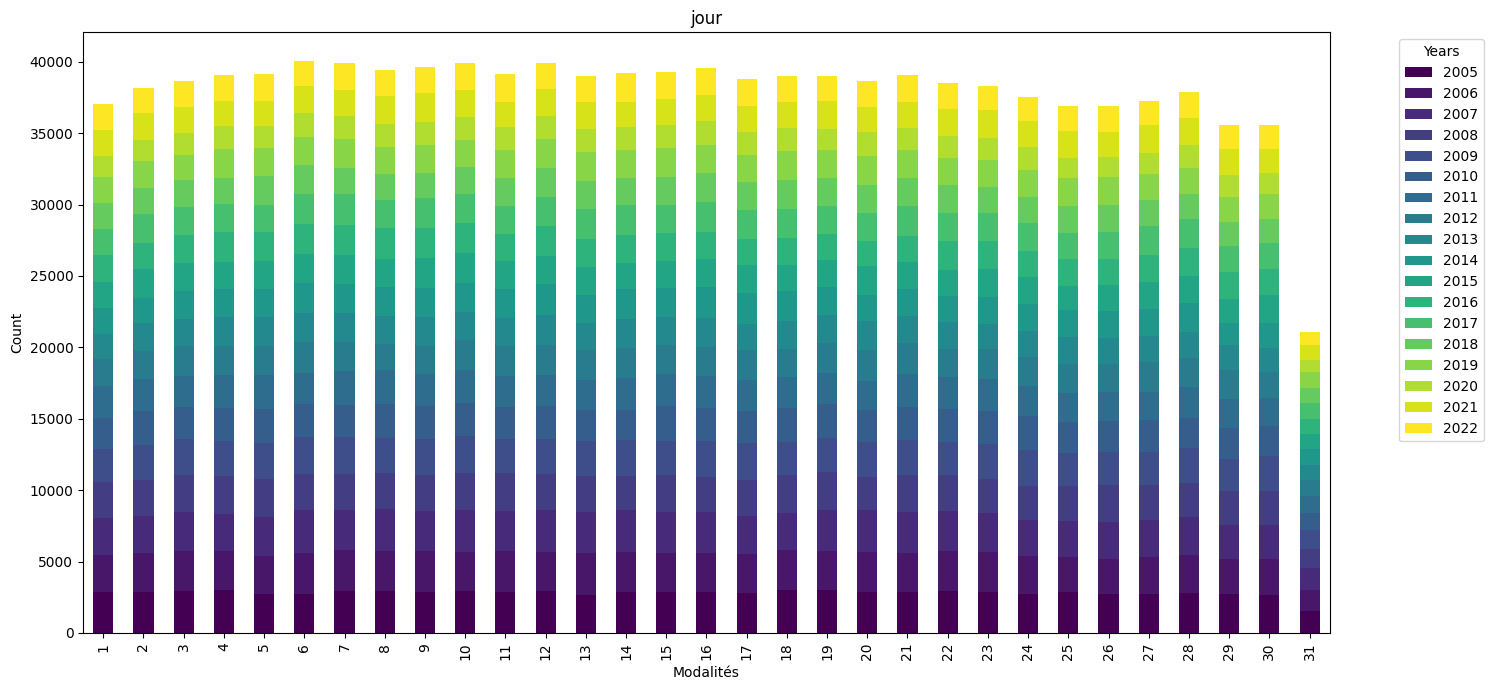

2024-06-12 13:24:33,192 - WARNING - Le nombre de modalités uniques dans la colonne jour excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Intersection :

Modalités:
- 1: Hors intersection
- 2: Intersection en X
- 3: Intersection en T
- 4: Intersection en Y
- 5: Intersection à plus de 4 branches
- 6: Giratoire
- 7: Place
- 8: Passage à niveau
- 9: Autre intersection
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        1                                      0                                    0
   2006  int64        1                                      0                                    0
   2007  int64        1                                      0                                    0
   2008  int64        1                                      0                                    0
   2009  int64        1                                      0                                    0
   2010  int64        1                 

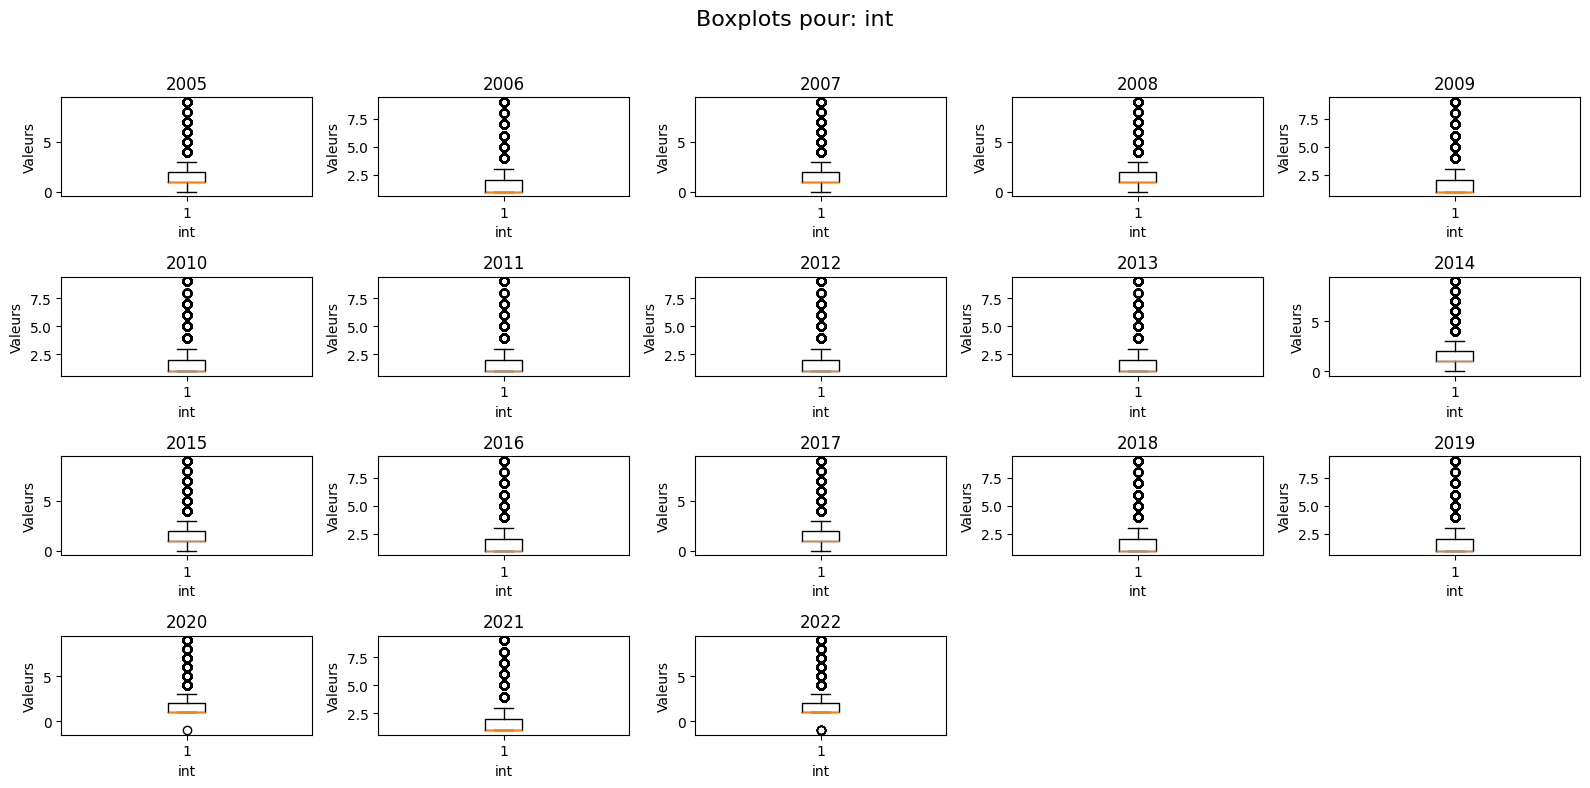

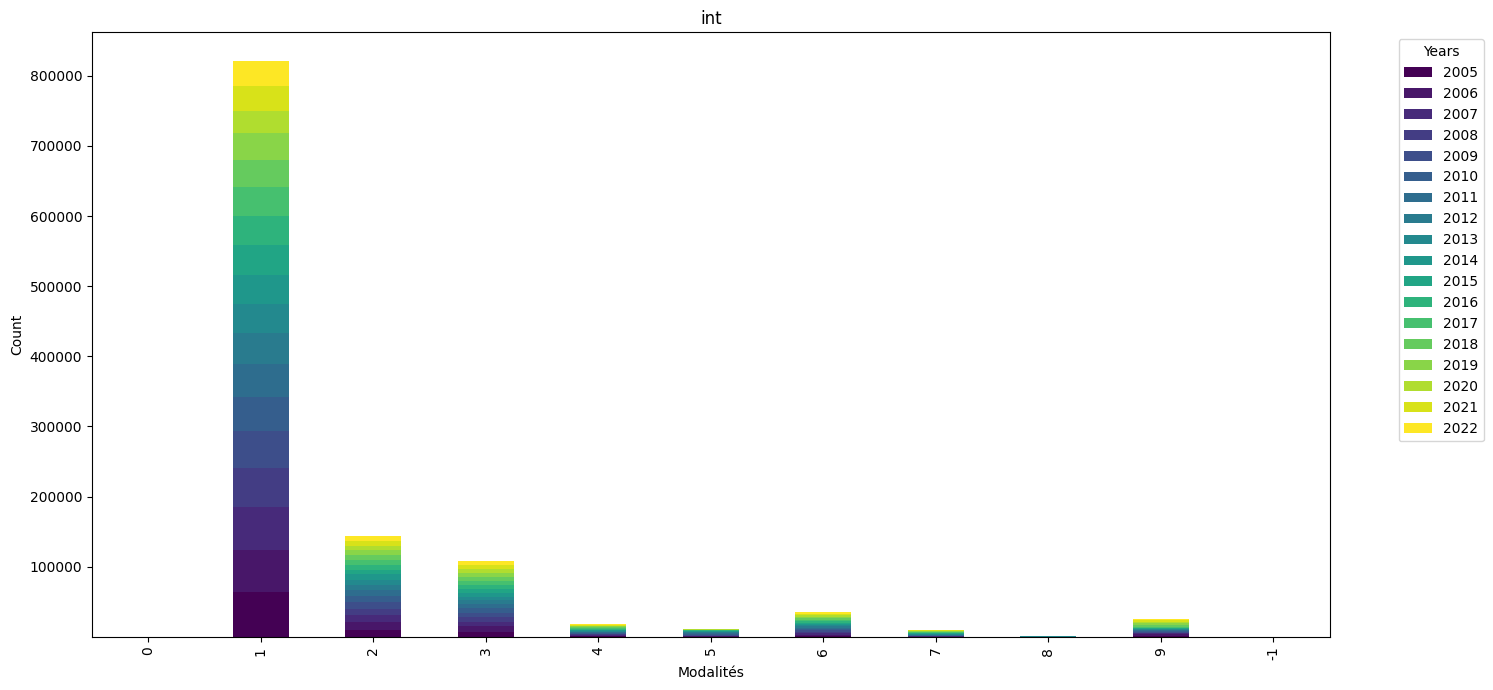

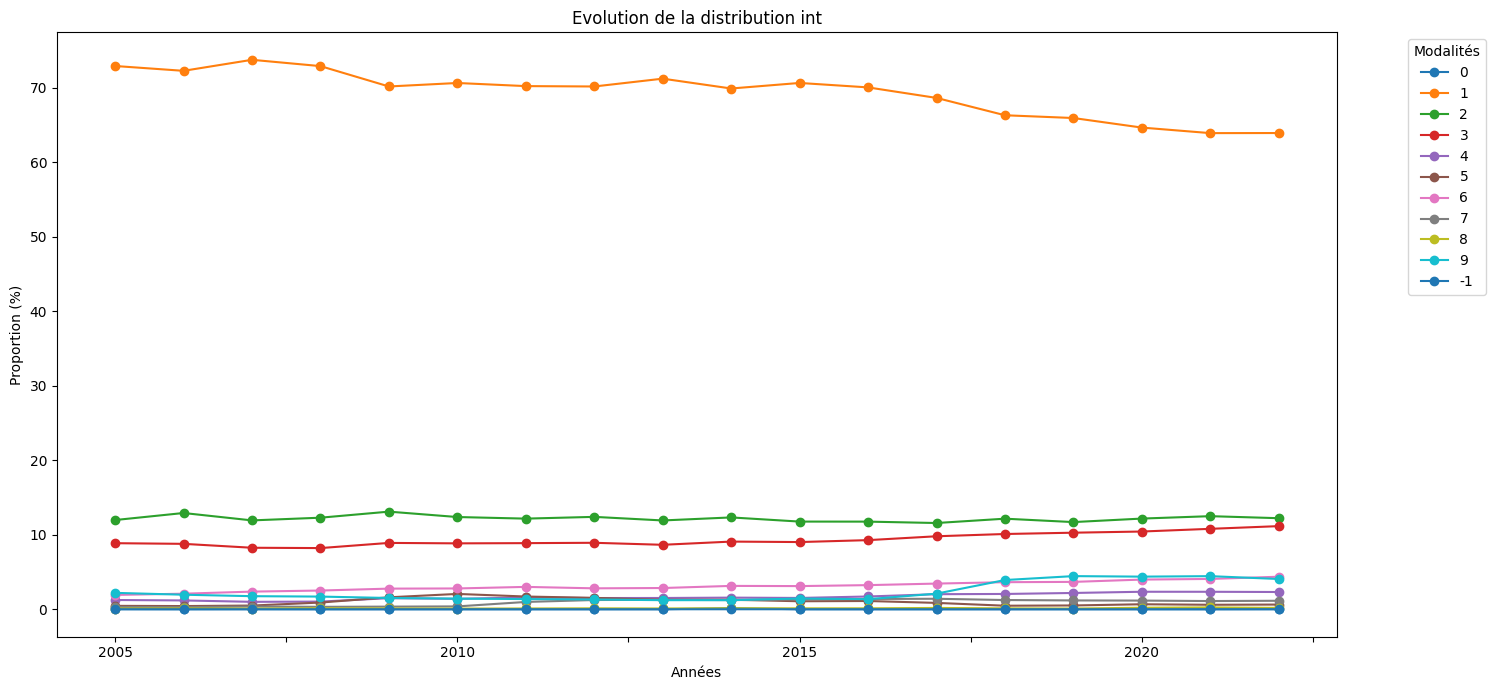

lignes: 1176873

Description: Type de collision :

Modalités:
- -1: Non renseigné
- 1: Deux véhicules - frontale
- 2: Deux véhicules – par l’arrière
- 3: Deux véhicules – par le coté
- 4: Trois véhicules et plus – en chaîne
- 5: Trois véhicules et plus - collisions multiples
- 6: Autre collision
- 7: Sans collision
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         6                             0                                   0
   2006  int64         6                             0                                   0
   2007  int64         6                             0                                   0
   2008  int64         6                             0                                   0
   2009  int64         6                             0                                   0
   2010  float64       6  

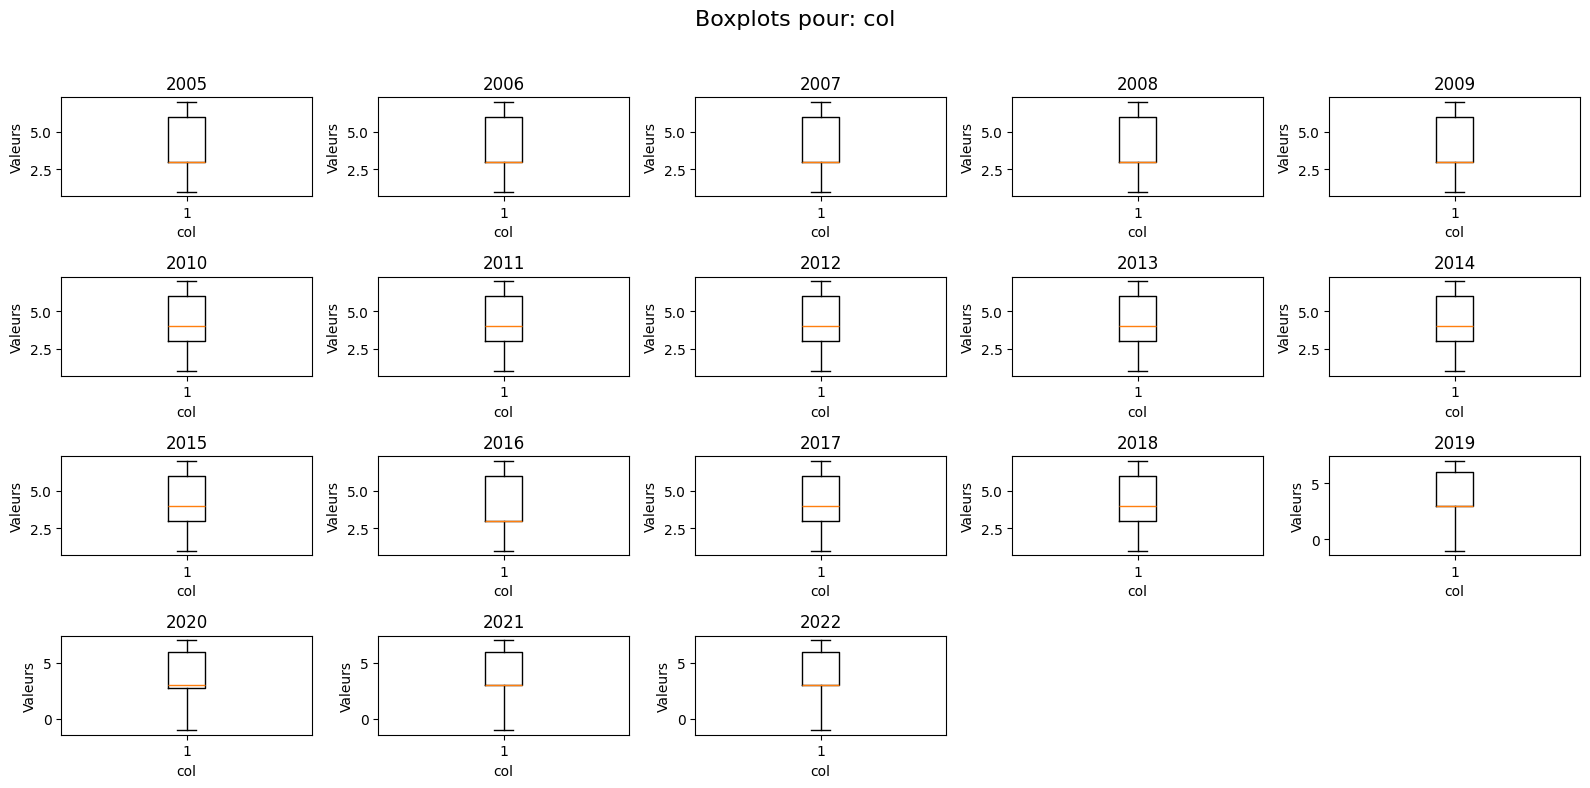

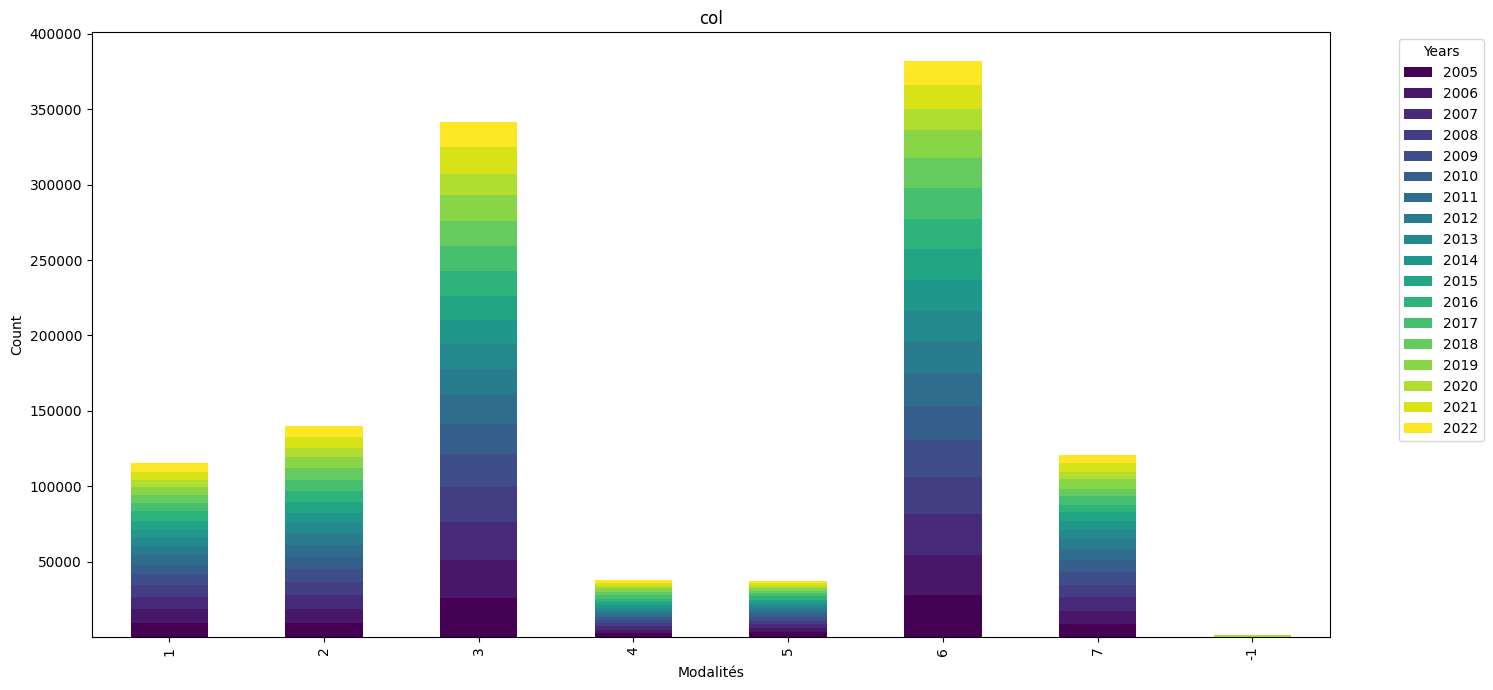

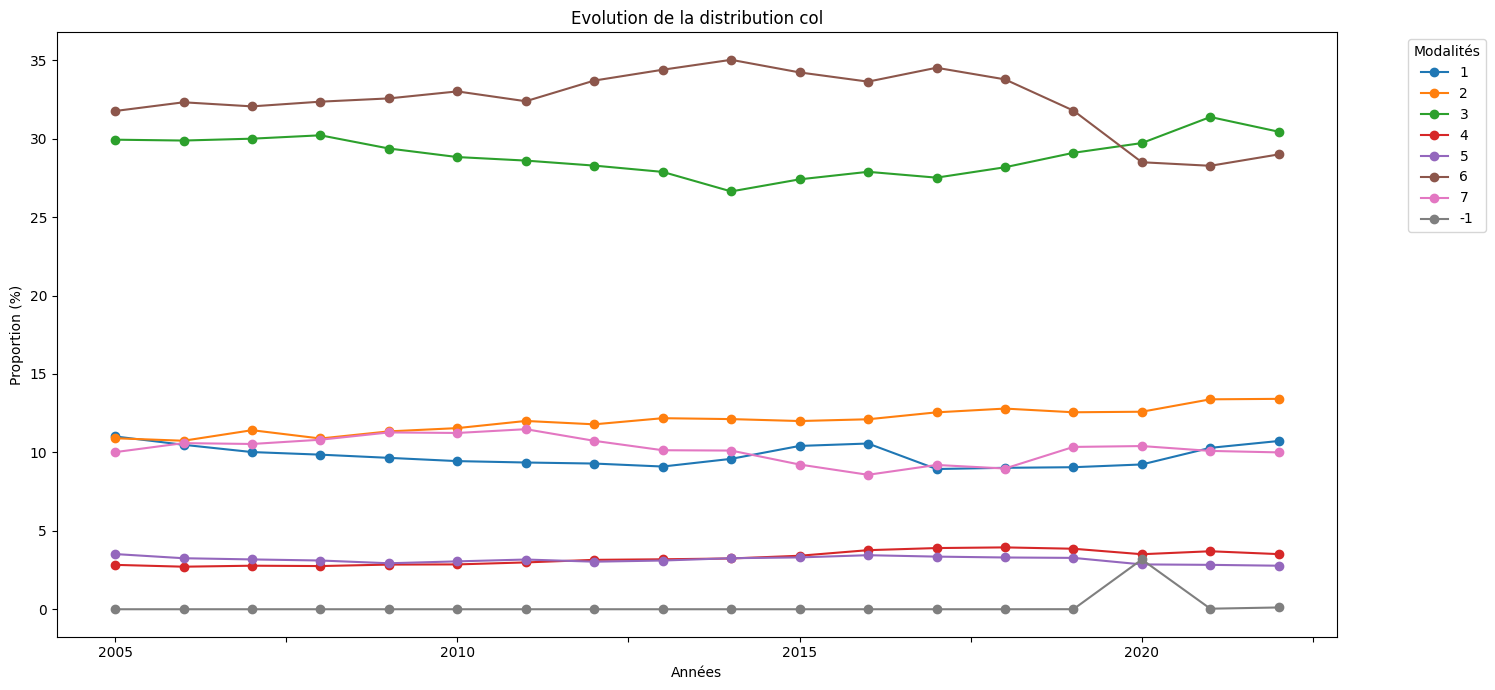

lignes: 1176873

Description: Localisation :

Modalités:
- 1: Hors agglomération
- 2: En agglomération
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        2                                      0                                    0
   2006  int64        2                                      0                                    0
   2007  int64        2                                      0                                    0
   2008  int64        2                                      0                                    0
   2009  int64        2                                      0                                    0
   2010  int64        2                                      0                                    0
   2011  int64        2                                      0                                   

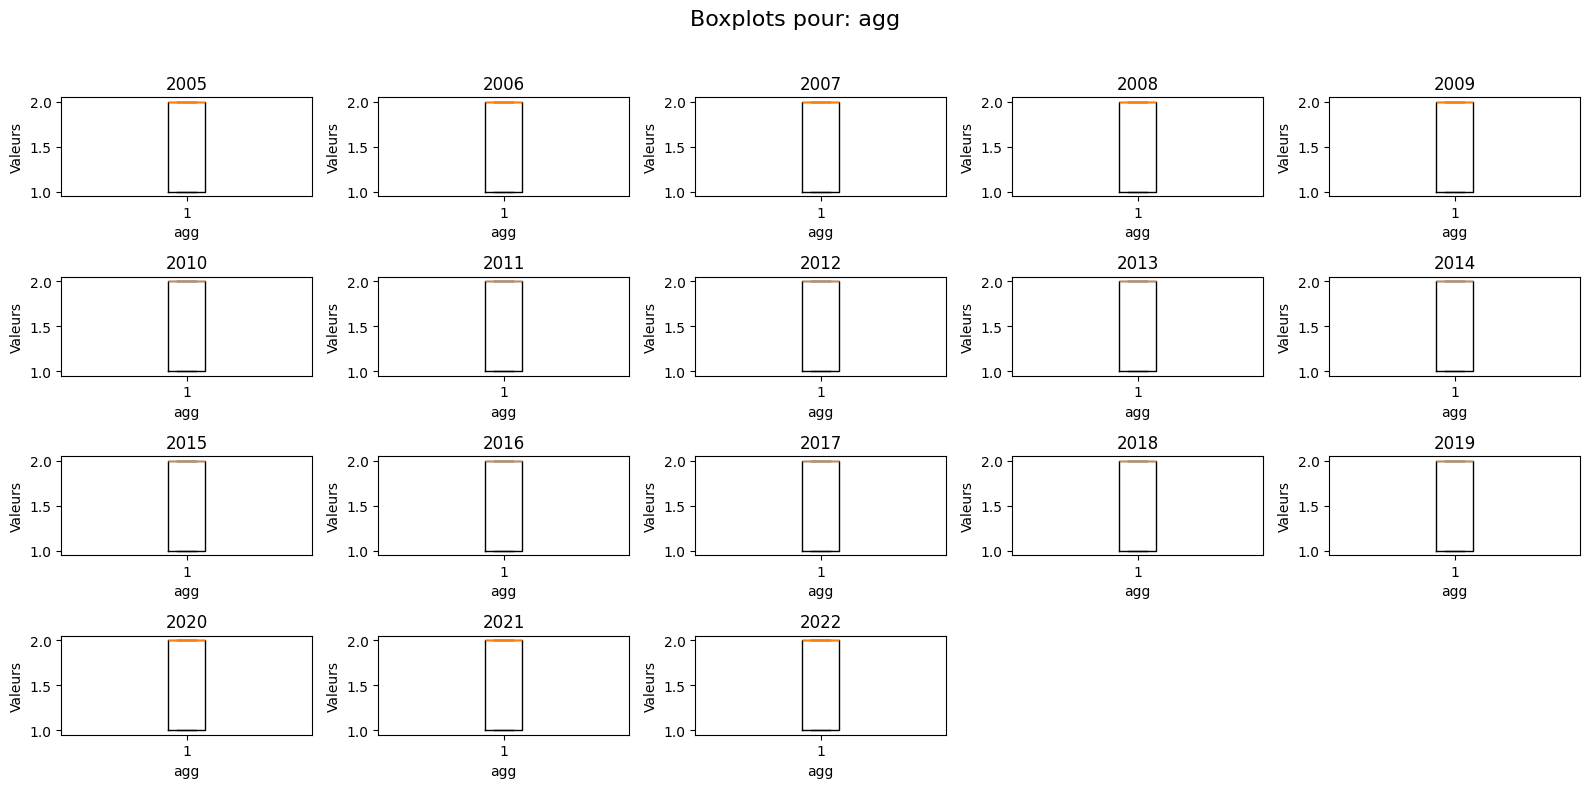

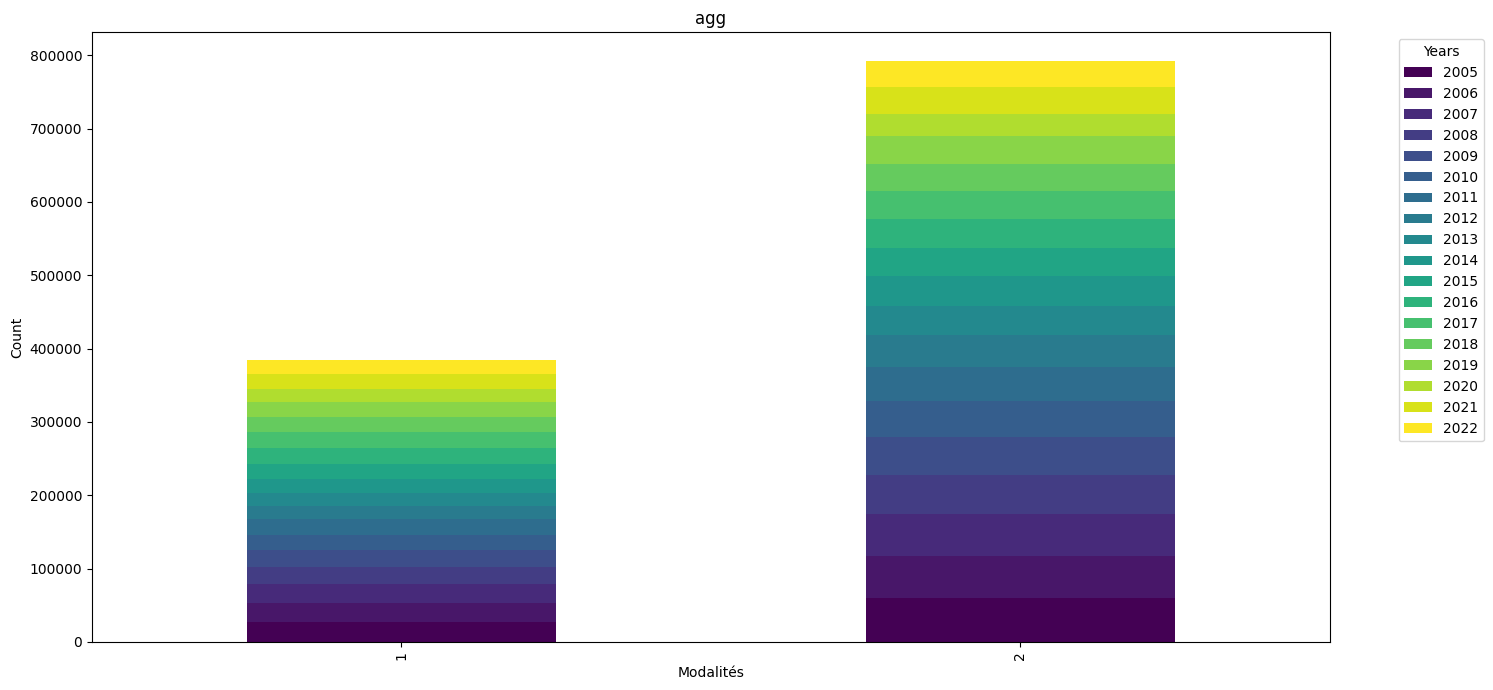

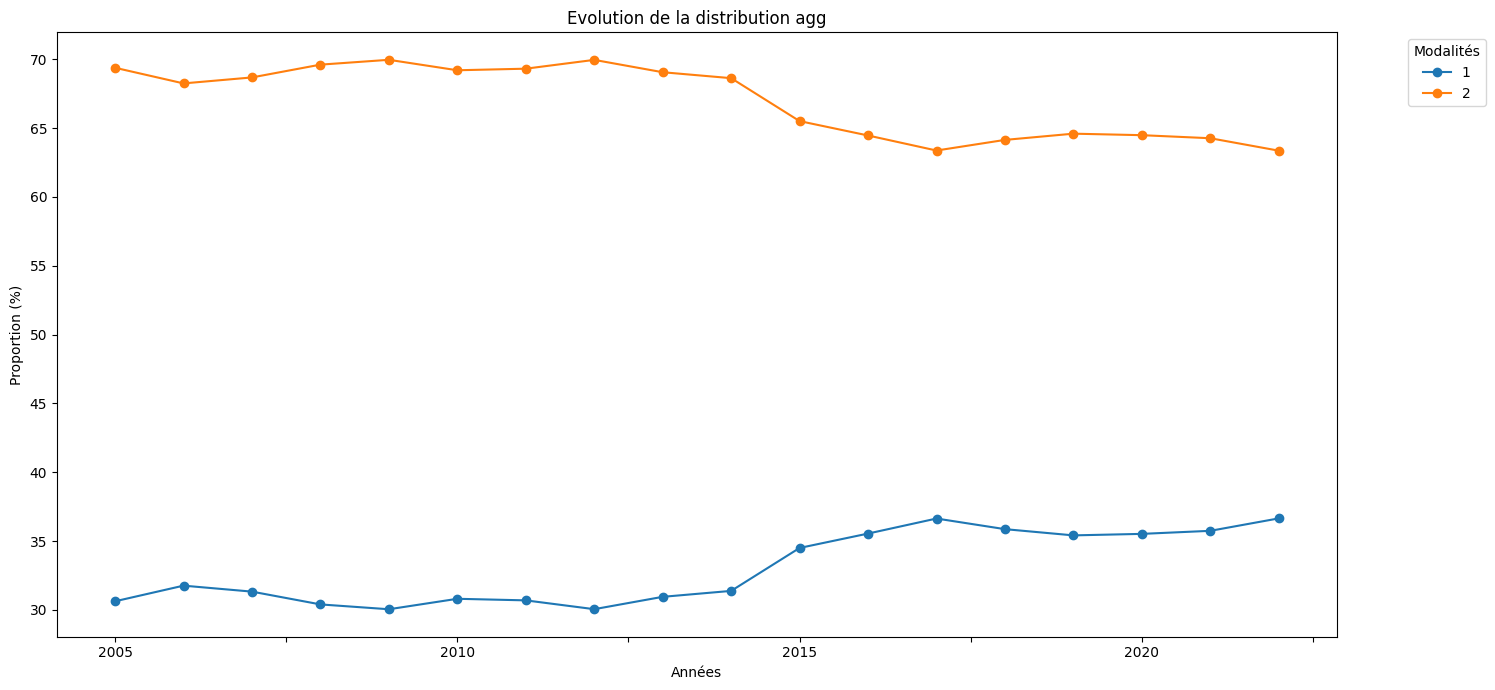

lignes: 1176873

Description: Heure et minutes de l'accident.
  Année  Type    Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64   1800                                        0                                    0
   2006  int64   1800                                        0                                    0
   2007  int64   1800                                        0                                    0
   2008  int64   1800                                        0                                    0
   2009  int64   1800                                        0                                    0
   2010  int64   1800                                        0                                    0
   2011  int64   1800                                        0                                    0
   2012  int64   1800                 

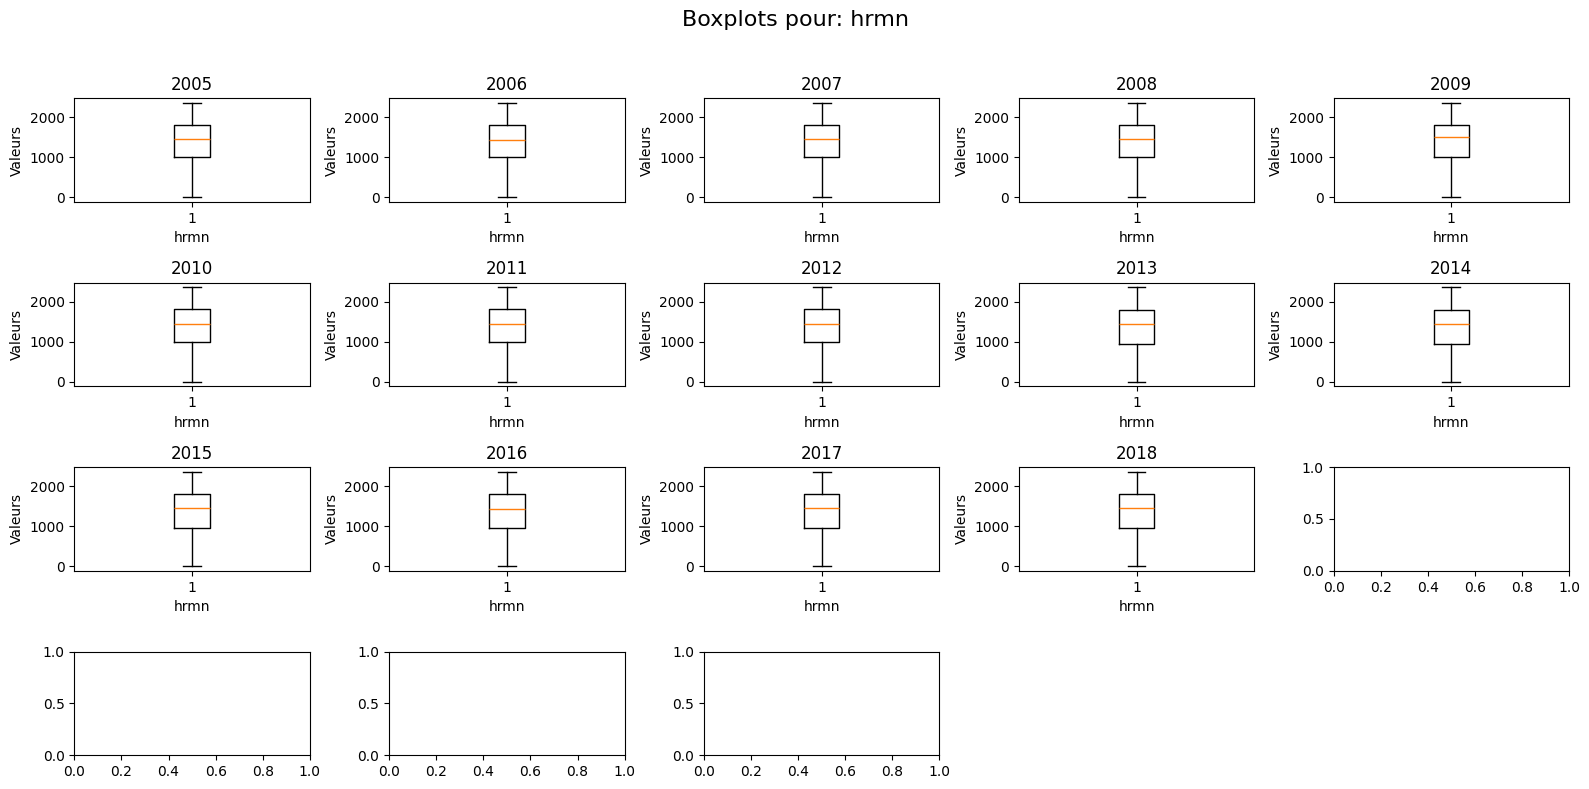

2024-06-12 13:24:42,078 - WARNING - Le nombre de modalités uniques dans la colonne hrmn excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:24:42,114 - WARNING - Le nombre de modalités uniques dans la colonne hrmn excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-12 13:24:42,704 - INFO - La colonne adr n'est pas numérique.


lignes: 1176873

Description: Adresse postale : variable renseignée pour les accidents survenus en agglomération.
  Année  Type    Mode             Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  -------------  -------------------------------------  -----------------------------------
   2005  object  AUTOROUTE A1                               19.2908                            0.0142649
   2006  object  AUTOROUTE A1                               13.4132                            0.00945896
   2007  object  AUTOROUTE A1                               17.8366                            0.0127083
   2008  object  AUTOROUTE A1                               19.382                             0.0126428
   2009  object  A13                                        17.307                             0.0109426
   2010  object  AUTOROUTE A1                               16.629                             0.0098031
   2011  object  A13                     

2024-06-12 13:24:43,111 - WARNING - Le nombre de modalités uniques dans la colonne adr excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:24:43,515 - WARNING - Le nombre de modalités uniques dans la colonne adr excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Numéro d'identifiant de l’accident.
  Année  Type         Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2005  int64   2.005e+11                                      0                                    0
   2006  int64   2.006e+11                                      0                                    0
   2007  int64   2.007e+11                                      0                                    0
   2008  int64   2.008e+11                                      0                                    0
   2009  int64   2.009e+11                                      0                                    0
   2010  int64   2.01e+11                                       0                                    0
   2011  int64   2.011e+11                                      0                                    0
   2012

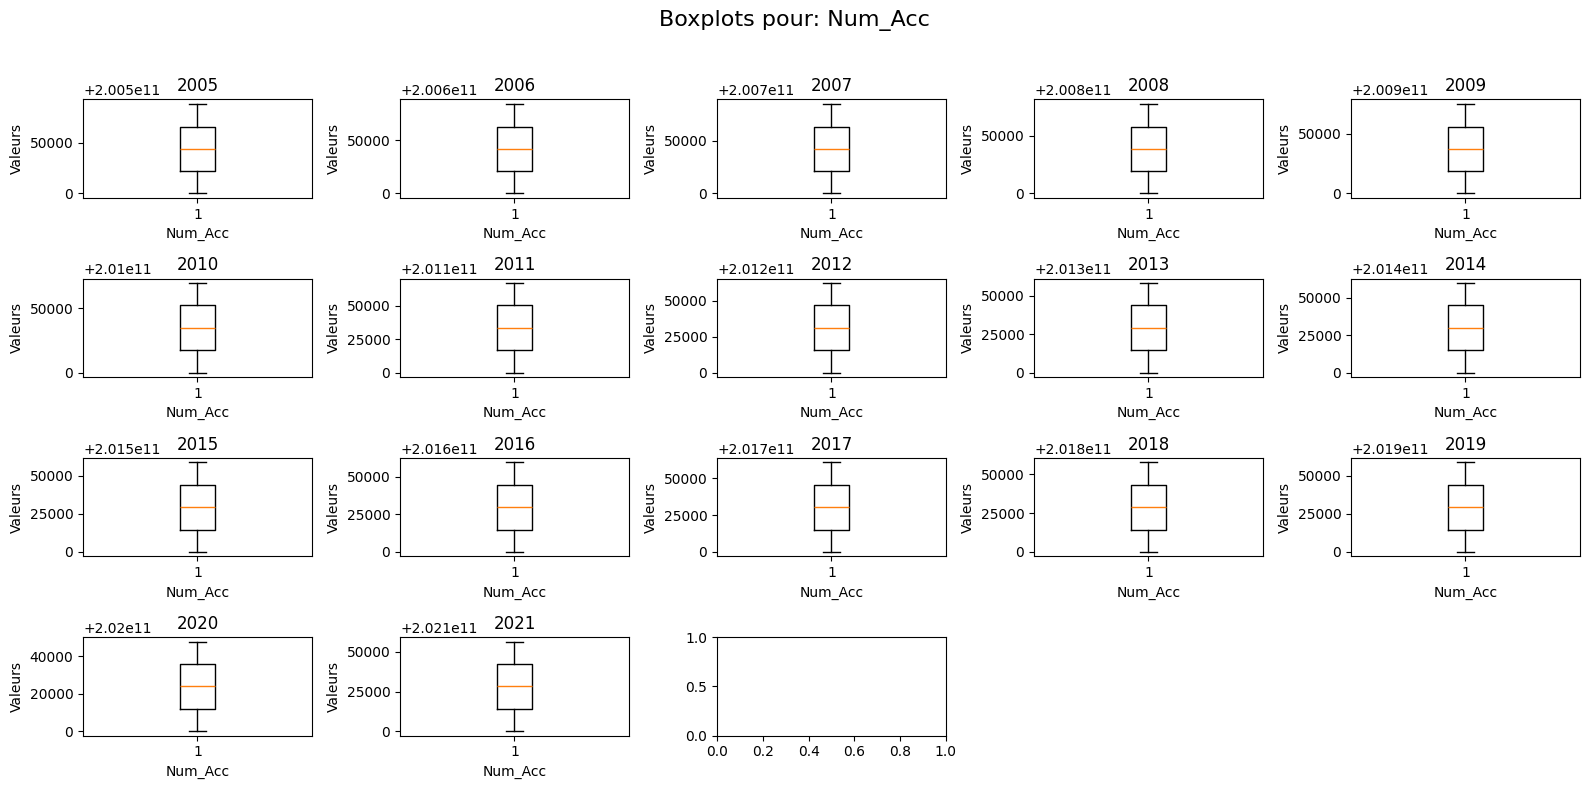

2024-06-12 13:24:45,436 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:24:45,639 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Latitude
  Année  Type     Mode              Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  --------------  -------------------------------------  -----------------------------------
   2005  float64  0.0                                          69.0403                            0.0510531
   2006  float64  0.0                                          70.7686                            0.049906
   2007  float64  0.0                                          71.9129                            0.0512366
   2008  float64  0.0                                          71.8056                            0.0468385
   2009  float64  4.0                                          54.9813                            0.0347625
   2010  float64  0.0                                          54.5064                            0.0321326
   2011  float64  0.0                                          54.1748                          

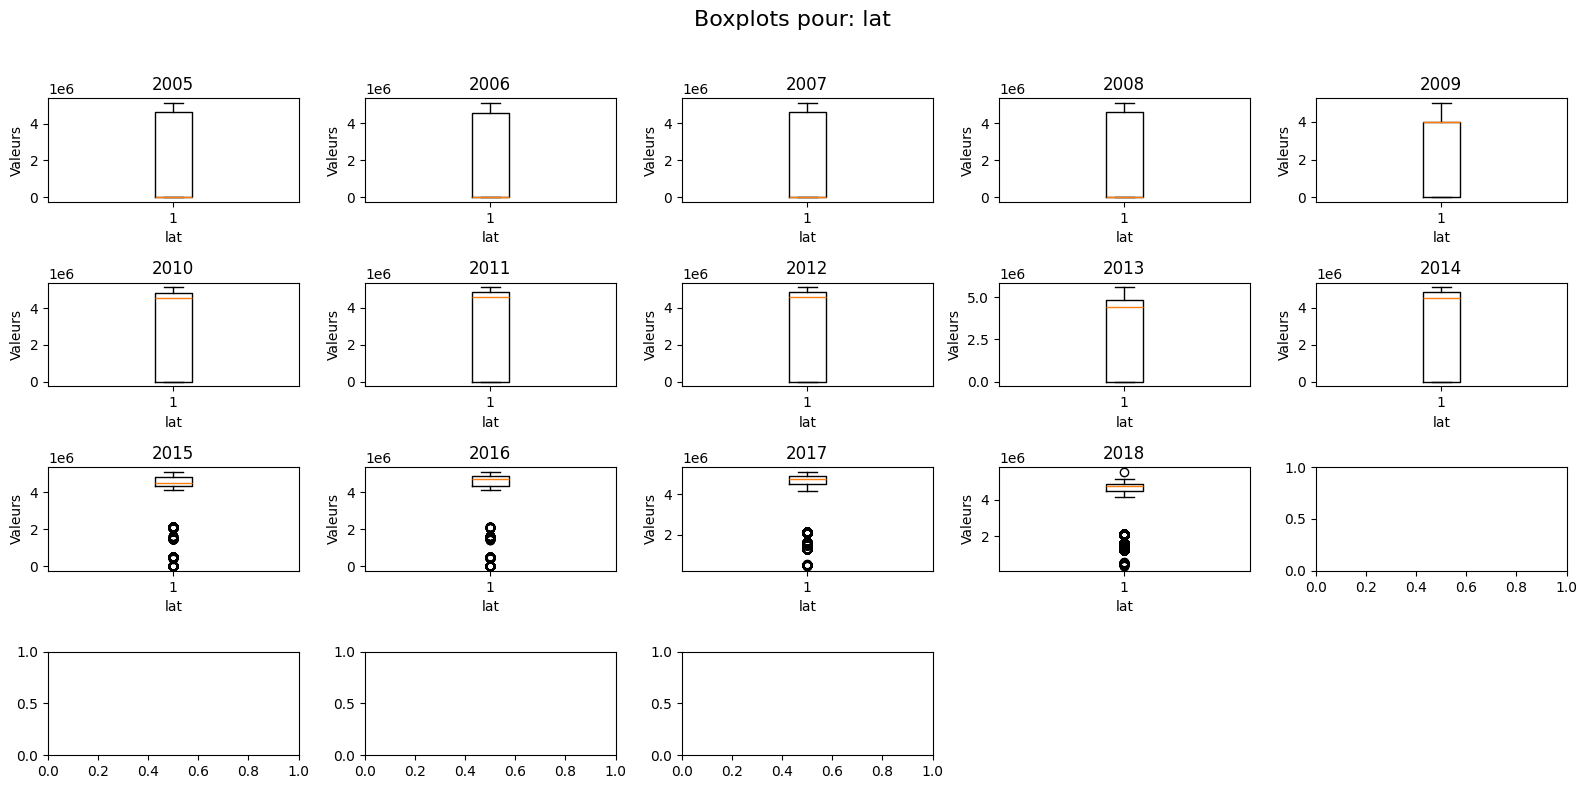

2024-06-12 13:24:47,725 - WARNING - Le nombre de modalités uniques dans la colonne lat excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:24:47,959 - WARNING - Le nombre de modalités uniques dans la colonne lat excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Mois de l'accident.
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        6                                      0                                    0
   2006  int64        6                                      0                                    0
   2007  int64       10                                      0                                    0
   2008  int64       10                                      0                                    0
   2009  int64        6                                      0                                    0
   2010  int64       10                                      0                                    0
   2011  int64        5                                      0                                    0
   2012  int64       10                           

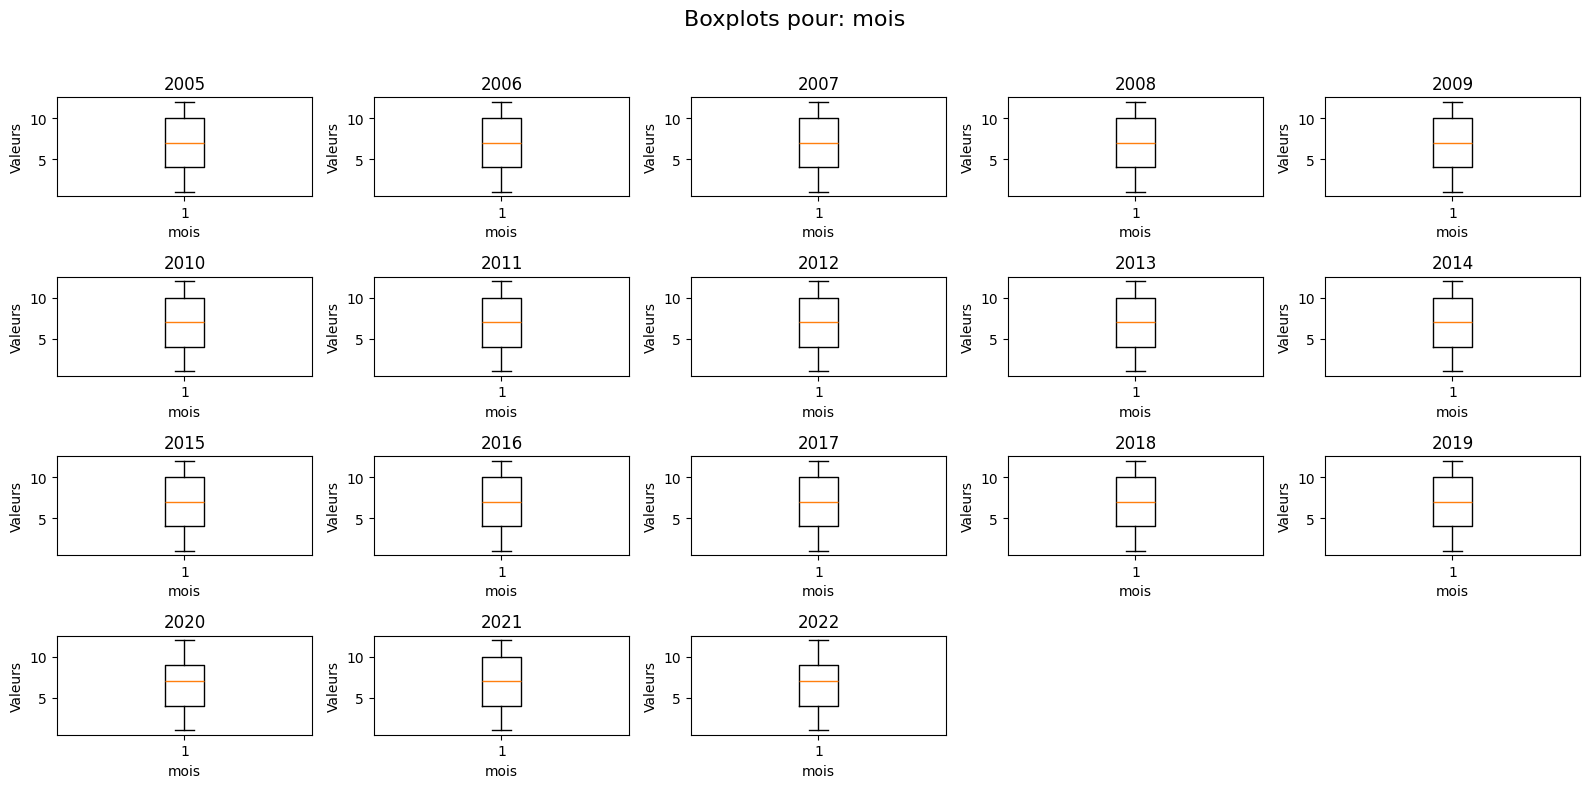

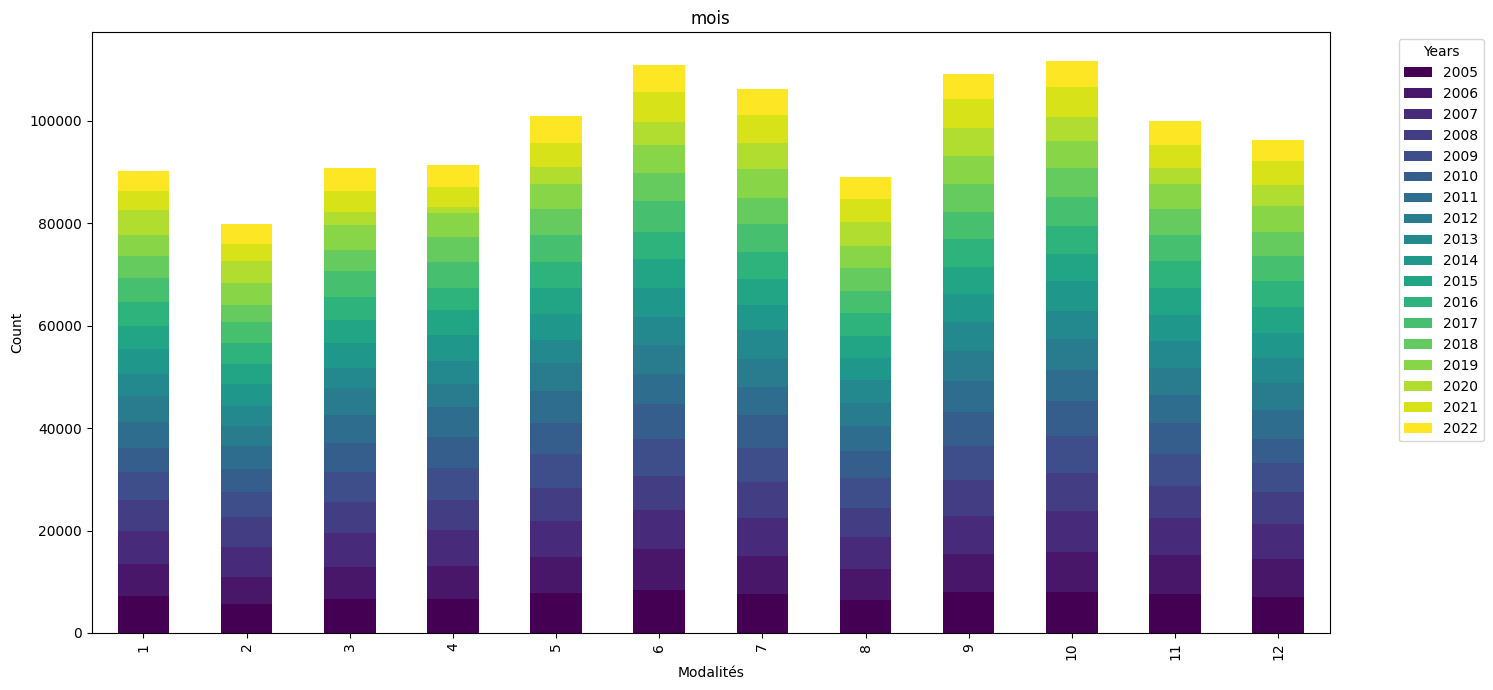

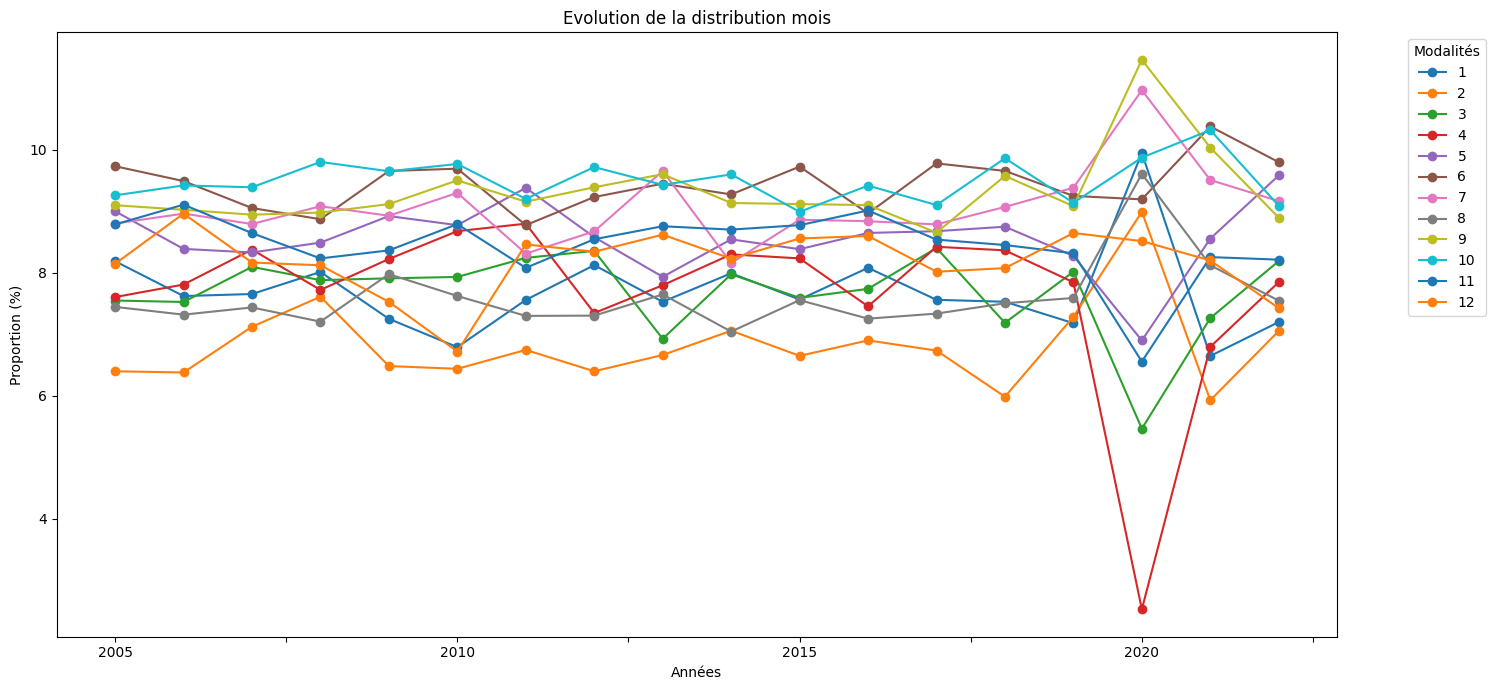

lignes: 1176873

Description: Conditions atmosphériques :

Modalités:
- -1: Non renseigné
- 1: Normale
- 2: Pluie légère
- 3: Pluie forte
- 4: Neige - grêle
- 5: Brouillard - fumée
- 6: Vent fort - tempête
- 7: Temps éblouissant
- 8: Temps couvert
- 9: Autre
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                             0                                   0
   2006  int64         1                             0                                   0
   2007  int64         1                             0                                   0
   2008  int64         1                             0                                   0
   2009  float64       1                             0.00940746                          5.94797e-06
   2010  float64       1                             0.00432408           

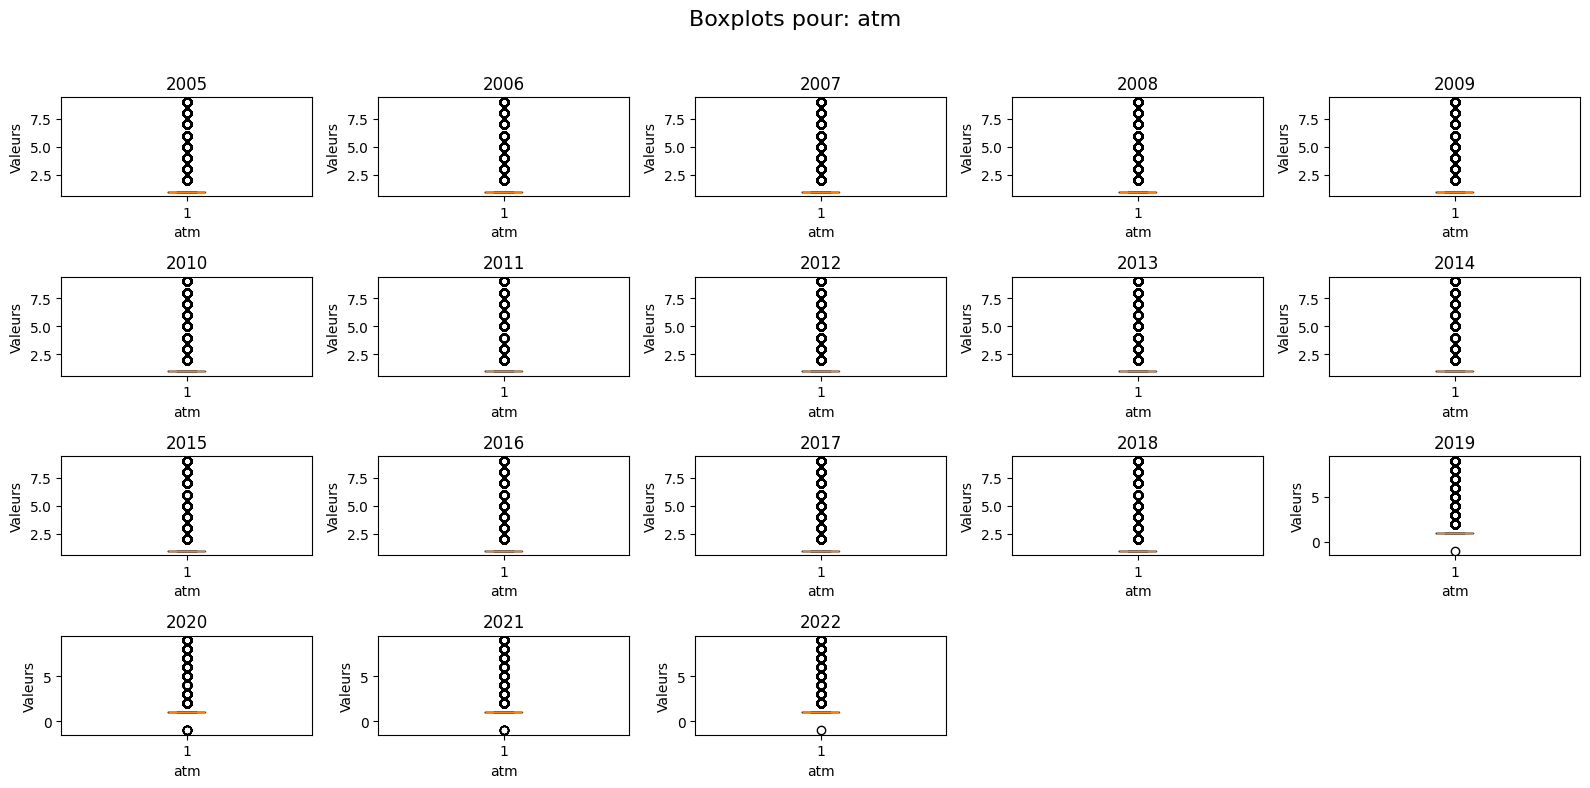

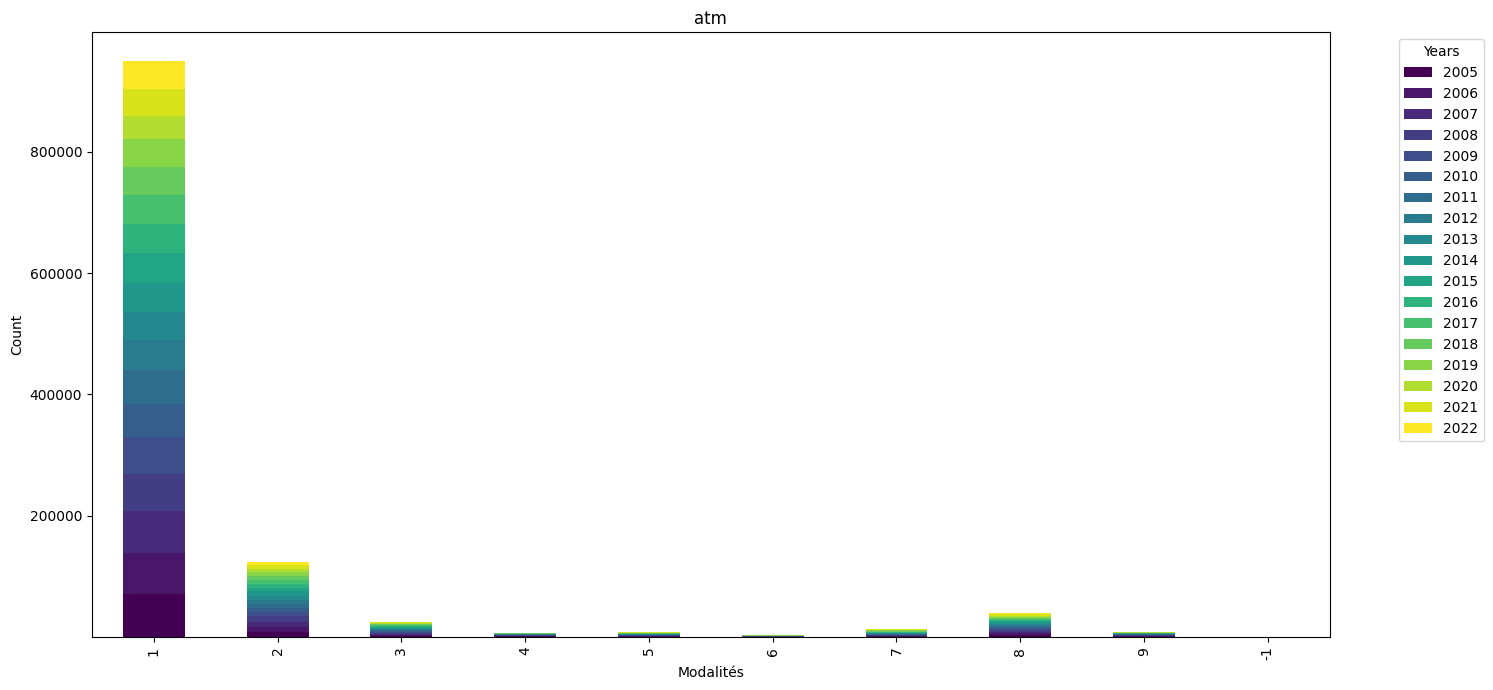

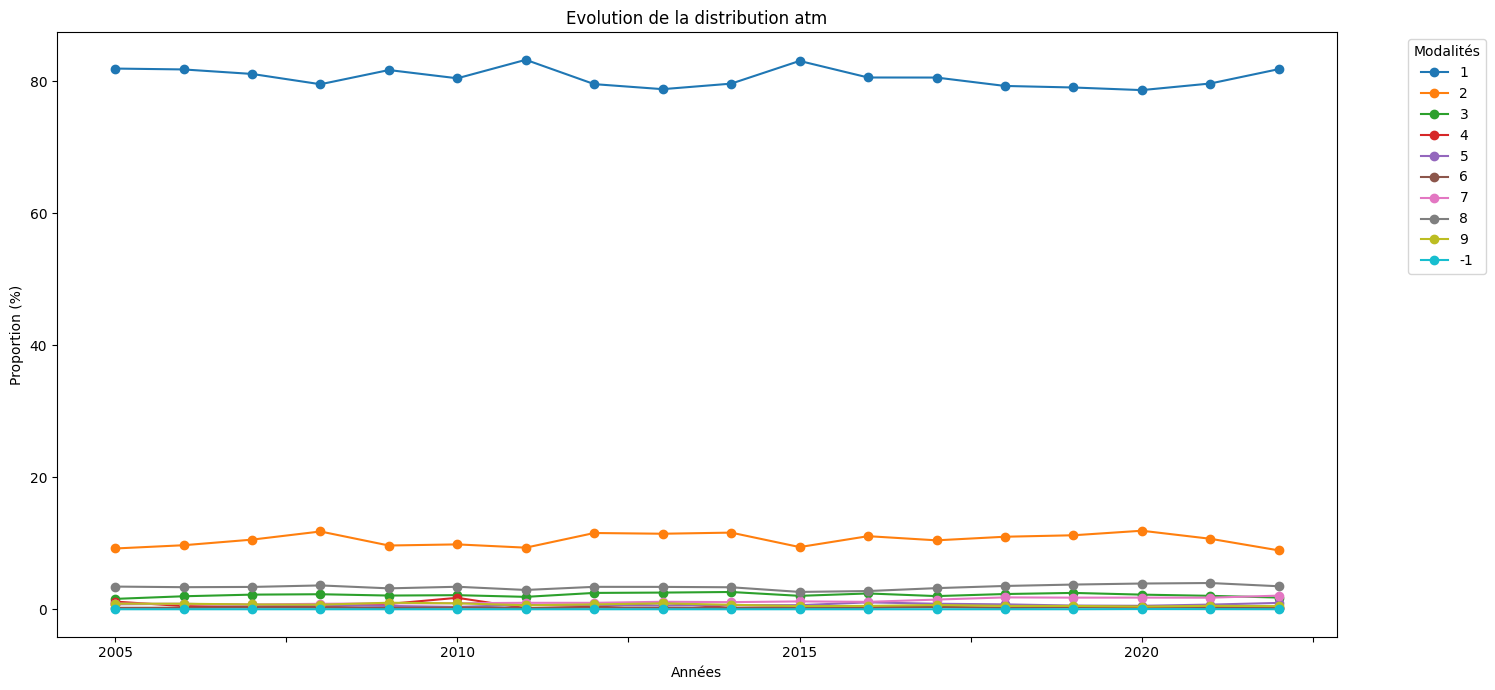

lignes: 1176873

Description: Année de l'accident.
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        5                                      0                                    0
   2006  int64        6                                      0                                    0
   2007  int64        7                                      0                                    0
   2008  int64        8                                      0                                    0
   2009  int64        9                                      0                                    0
   2010  int64       10                                      0                                    0
   2011  int64       11                                      0                                    0
   2012  int64       12                          

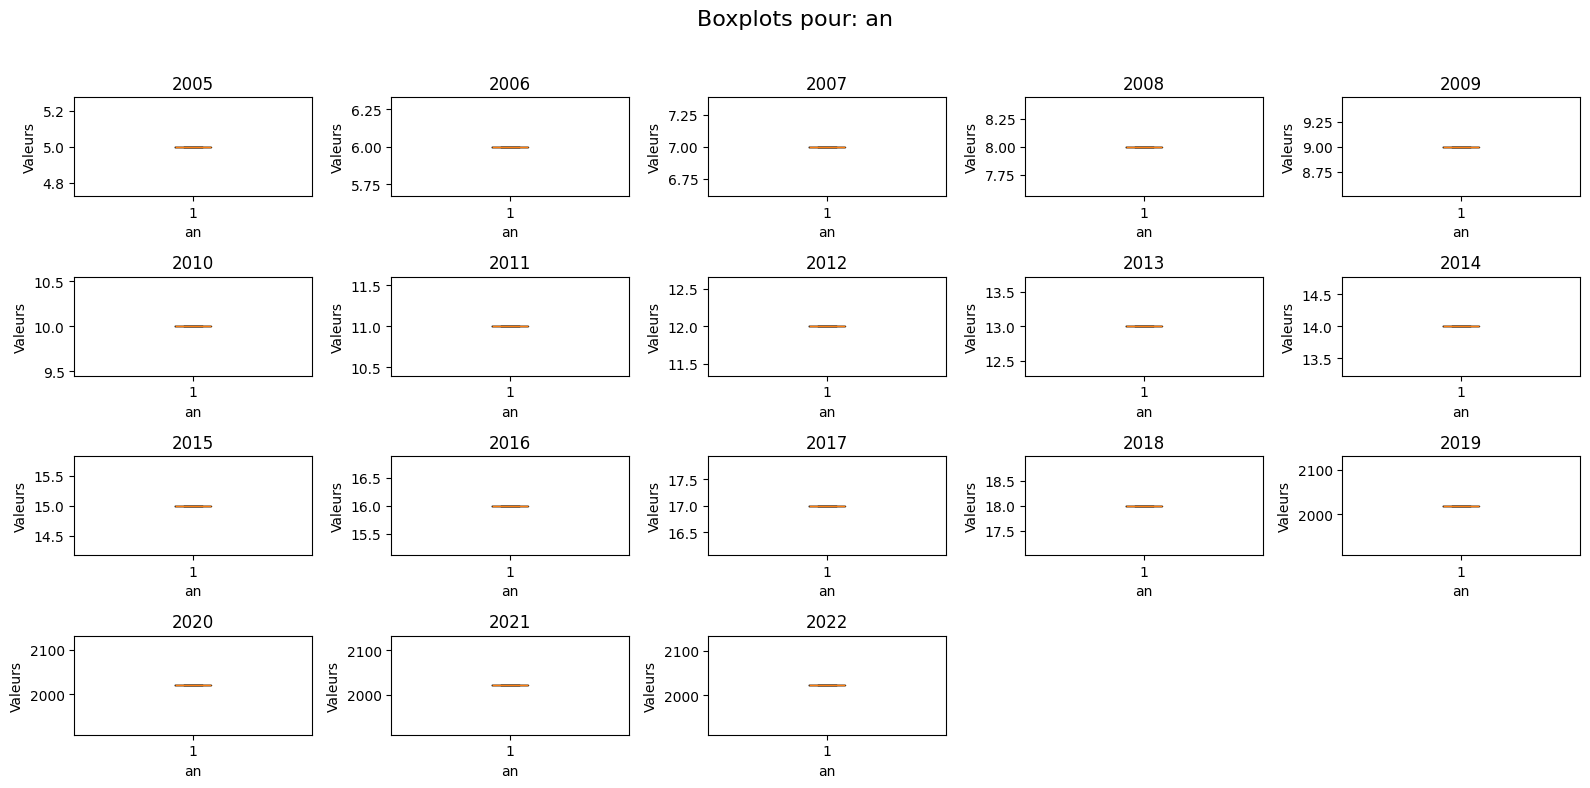

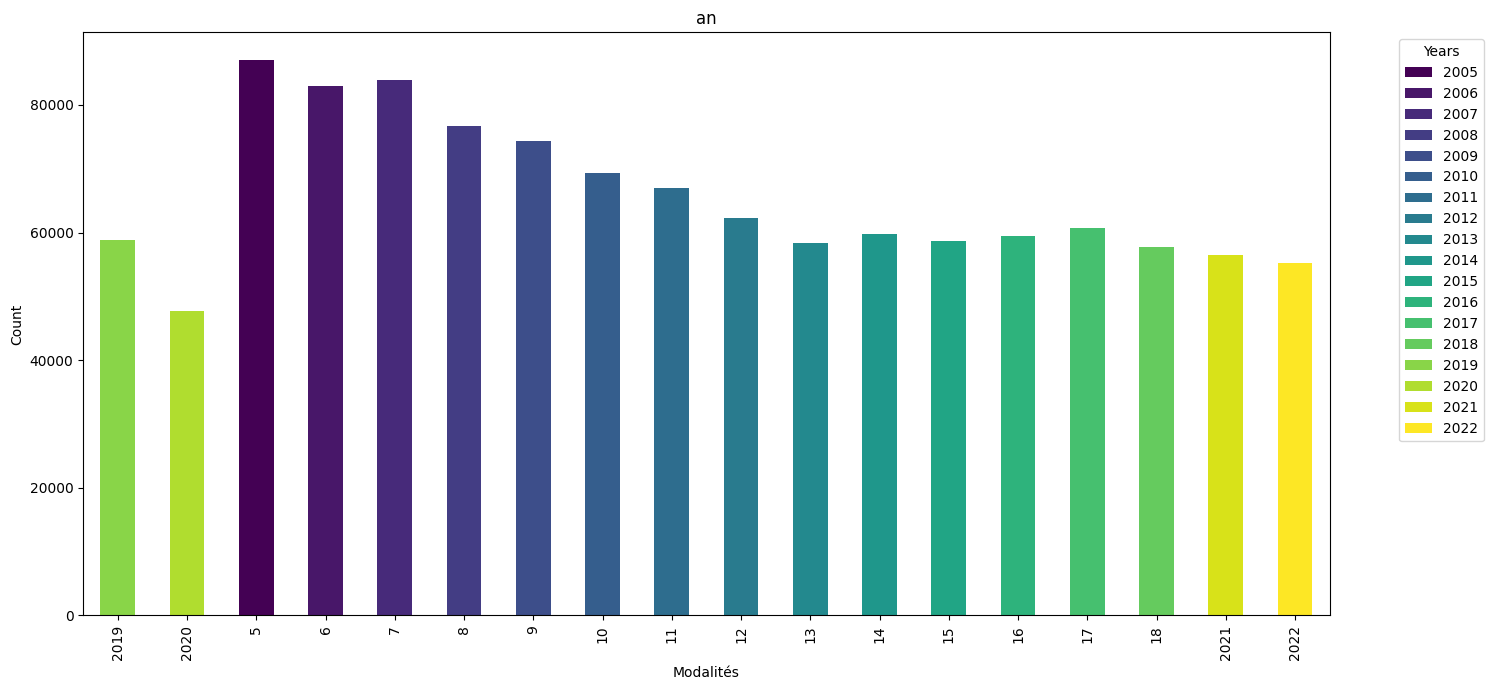

2024-06-12 13:24:55,038 - WARNING - Le nombre de modalités uniques dans la colonne an excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-12 13:24:55,142 - INFO - Pas de description pour `gps` dans la section `CARACTERISTIQUES`.
2024-06-12 13:24:55,144 - INFO - La colonne gps n'est pas numérique.


lignes: 1176873

  Année  Type    Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  object  M                                  68.9323                             0.0509732
   2006  object  M                                  70.6843                             0.0498465
   2007  object  M                                  71.8104                             0.0511635
   2008  object  M                                  71.6831                             0.0467587
   2009  object  M                                  54.8361                             0.0346707
   2010  object  M                                  54.2729                             0.031995
   2011  object  M                                  53.9403                             0.0306966
   2012  object  M                                  52.9912                             0.0280294


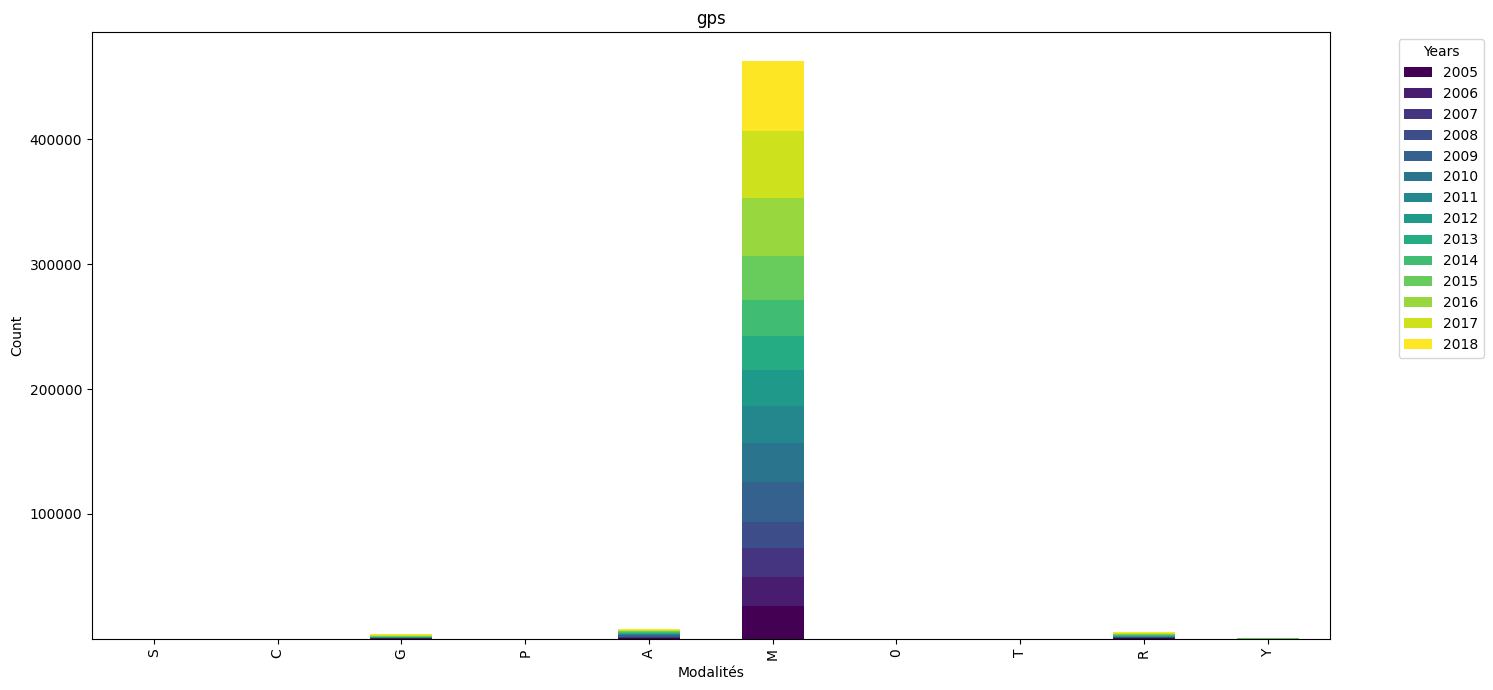

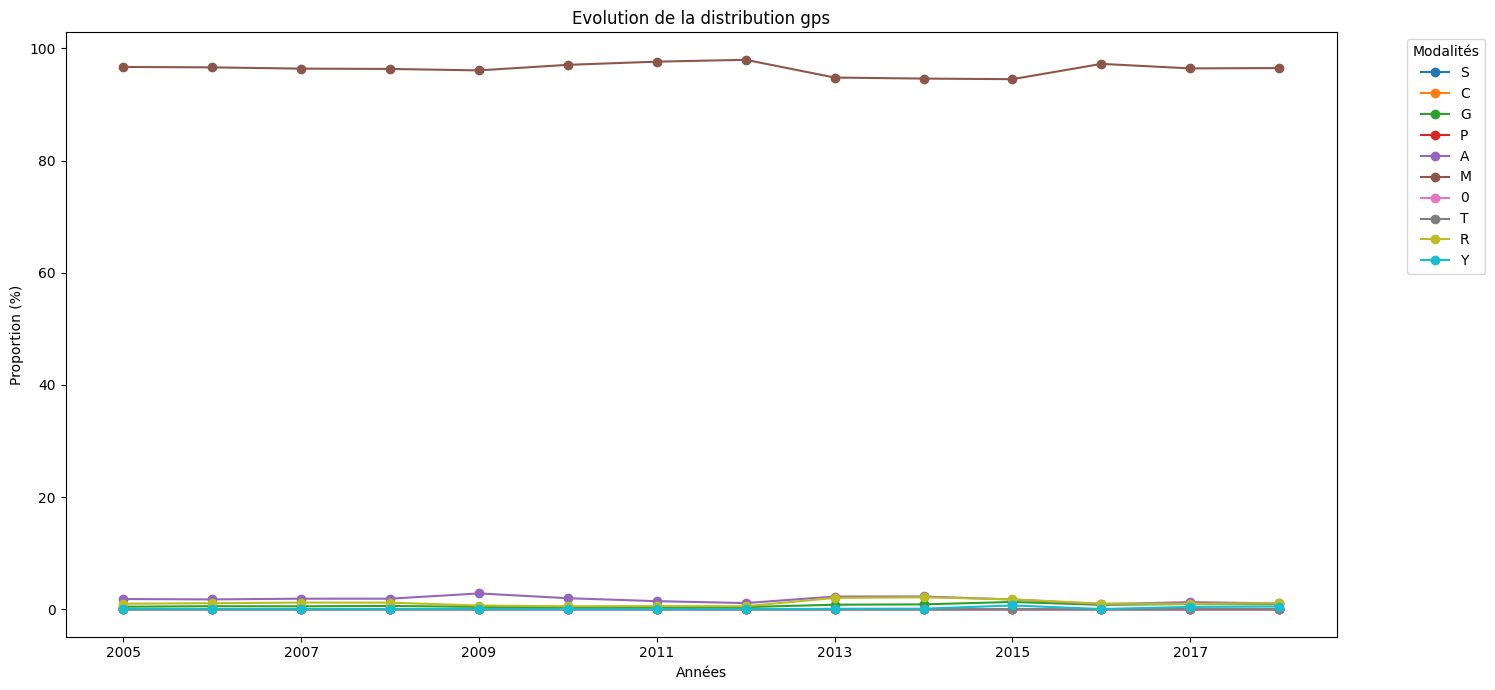

lignes: 1176873

Description: Commune : Le numéro de commune est un code donné par l‘INSEE. Le code est composé du code INSEE du département suivi par 3 chiffres.
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64      55                             0.00229816                          1.69942e-06
   2006  int64        55                             0                                   0
   2007  int64        55                             0                                   0
   2008  int64        55                             0                                   0
   2009  int64        88                             0                                   0
   2010  int64        55                             0                                   0
   2011  int64        55                             0                         

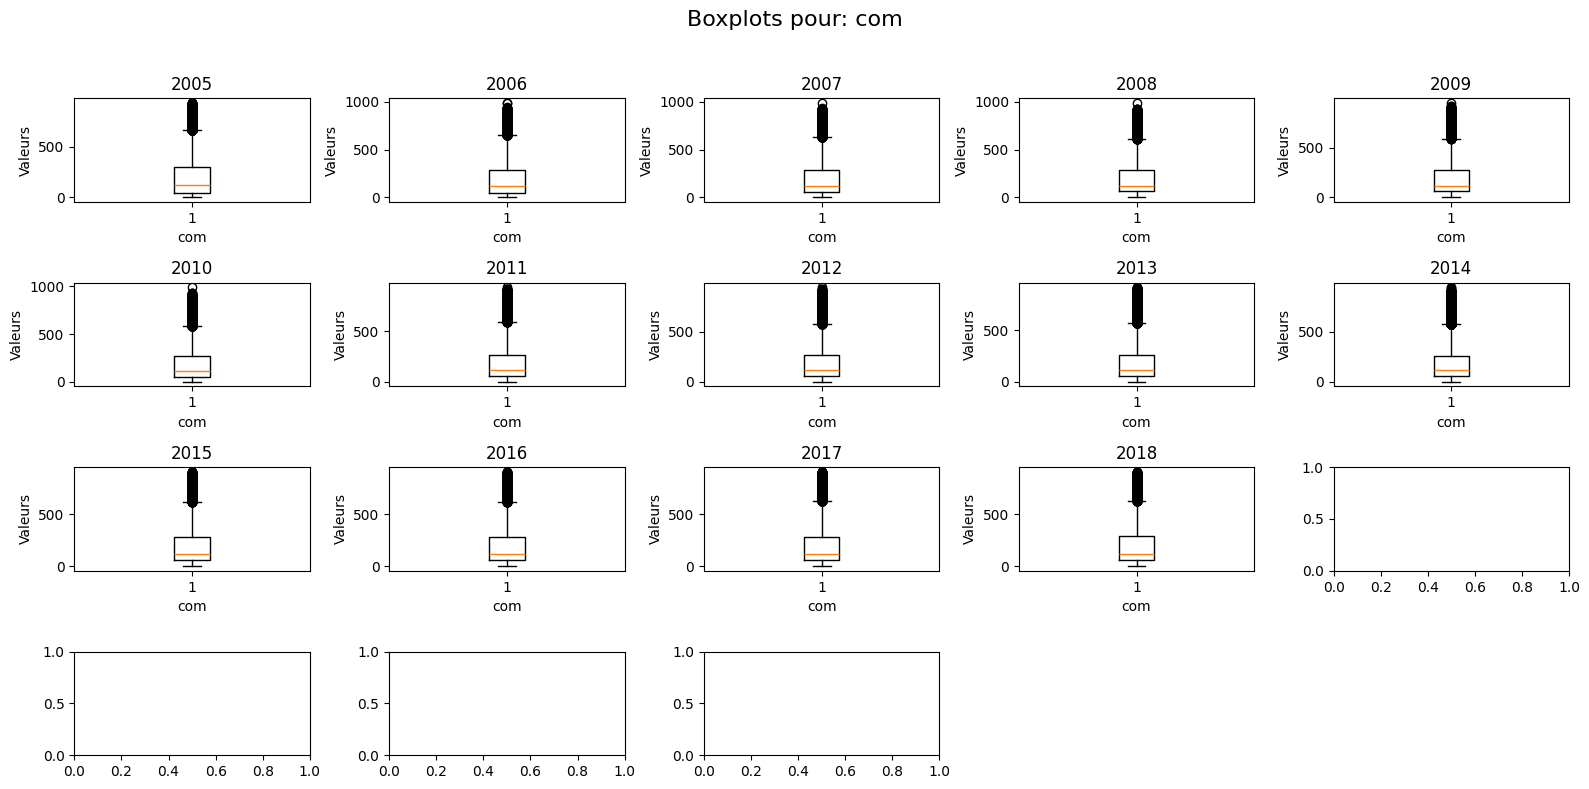

2024-06-12 13:24:57,697 - WARNING - Le nombre de modalités uniques dans la colonne com excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:24:57,740 - WARNING - Le nombre de modalités uniques dans la colonne com excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-12 13:24:57,743 - INFO - Chargement de lieux.


lignes: 1176873

Description: Largeur de la chaussée affectée à la circulation des véhicules ne sont pas compris les bandes d'arrêt d'urgence, les TPC et les places de stationnement (en m).
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                               0                                 0
   2006  int64         0                               0                                 0
   2007  int64         0                               0                                 0
   2008  int64         0                               0                                 0
   2009  float64       0                               0.482469                          0.000305046
   2010  float64       0                               0.531861                          0.000313543
   2011  float64       0                  

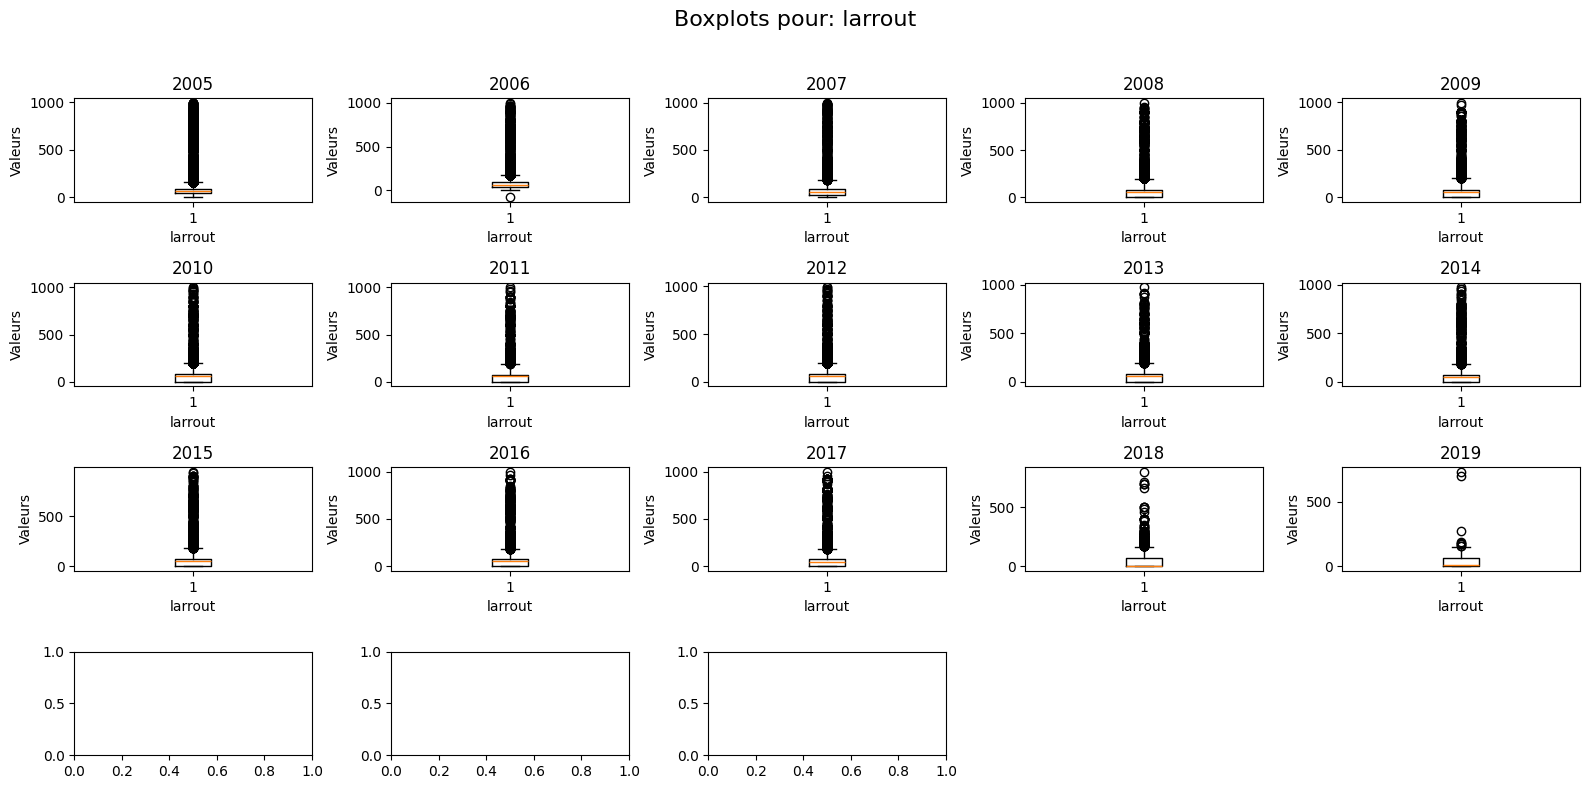

2024-06-12 13:24:59,455 - WARNING - Le nombre de modalités uniques dans la colonne larrout excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:24:59,488 - WARNING - Le nombre de modalités uniques dans la colonne larrout excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Situation de l’accident :

Modalités:
- -1: Non renseigné
- 0: Aucun
- 1: Sur chaussée
- 2: Sur bande d’arrêt d’urgence
- 3: Sur accotement
- 4: Sur trottoir
- 5: Sur piste cyclable
- 6: Sur autre voie spéciale
- 8: Autres
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.0792915                          5.01329e-05
   2010  float64       1                              0.0446821                 

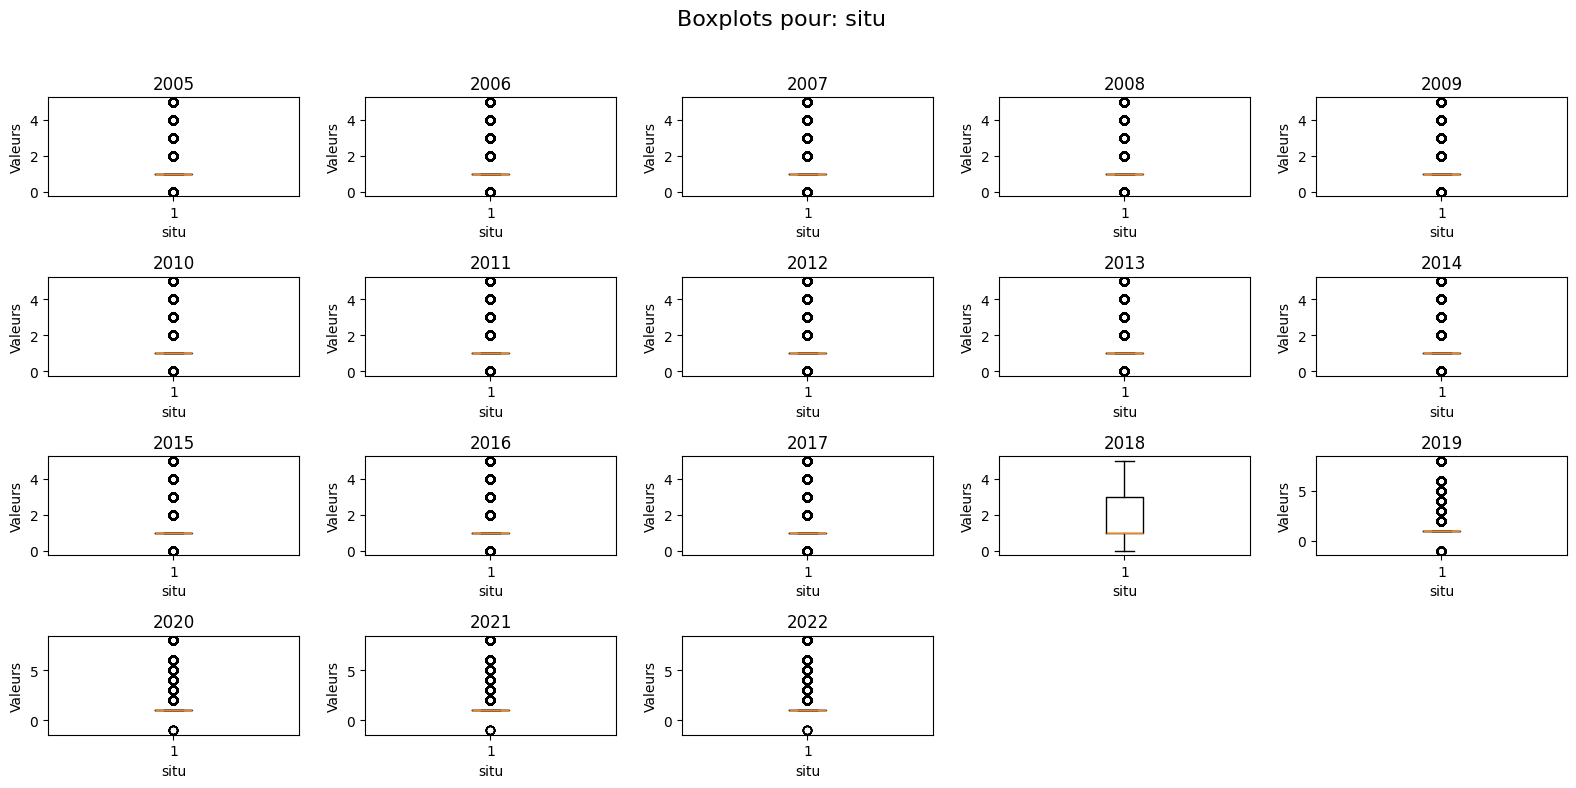

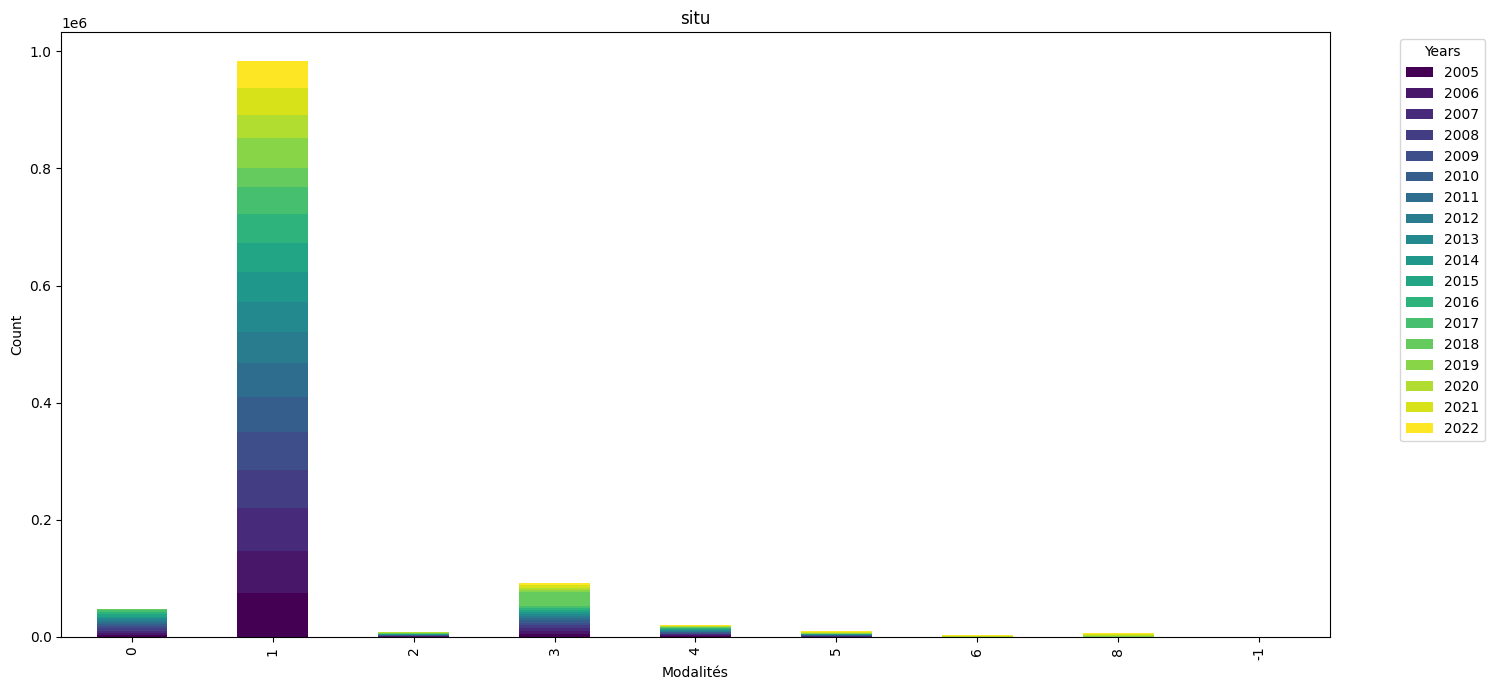

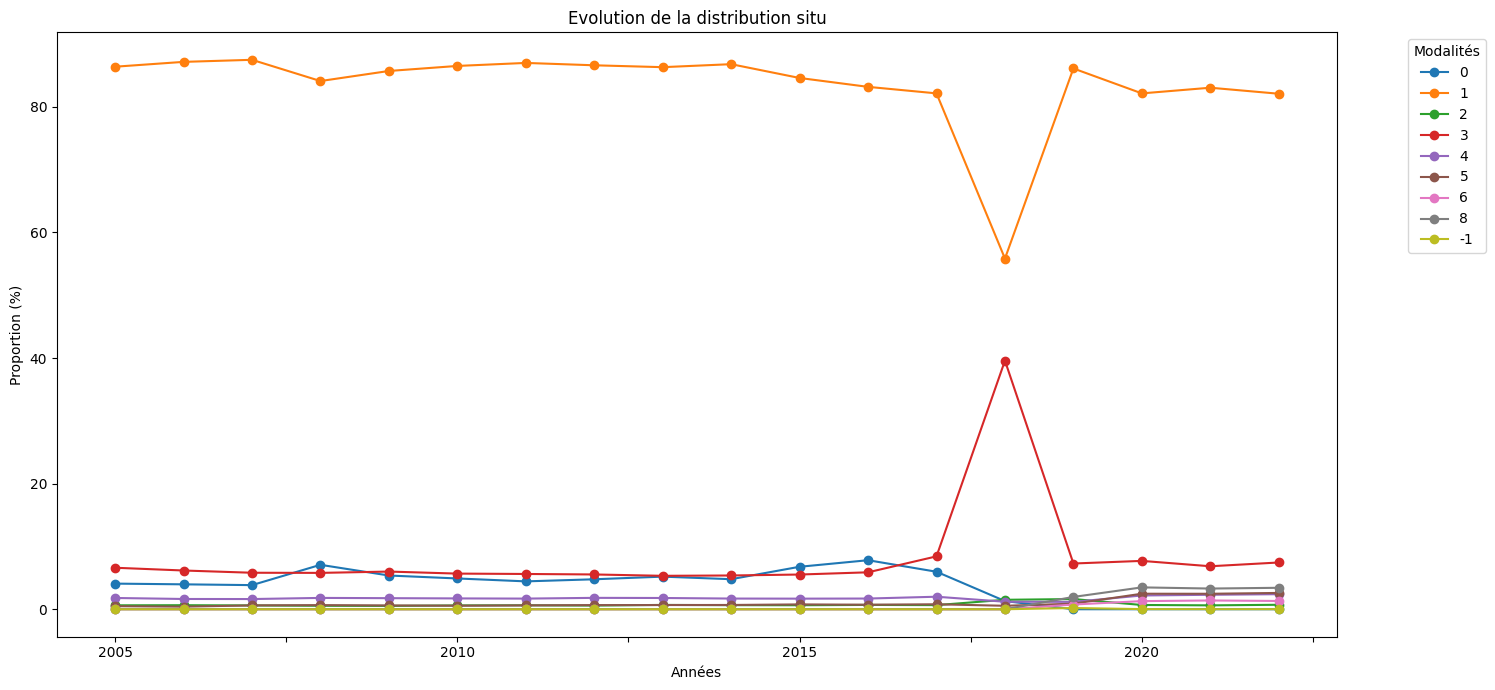

lignes: 1176873

Description: Identifiant de l’accident identique à celui du fichier "rubrique CARACTERISTIQUES" repris dans l’accident.
  Année  Type         Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2005  int64   2.005e+11                                      0                                    0
   2006  int64   2.006e+11                                      0                                    0
   2007  int64   2.007e+11                                      0                                    0
   2008  int64   2.008e+11                                      0                                    0
   2009  int64   2.009e+11                                      0                                    0
   2010  int64   2.01e+11                                       0                                    0
   2011  int64   2.011e+11             

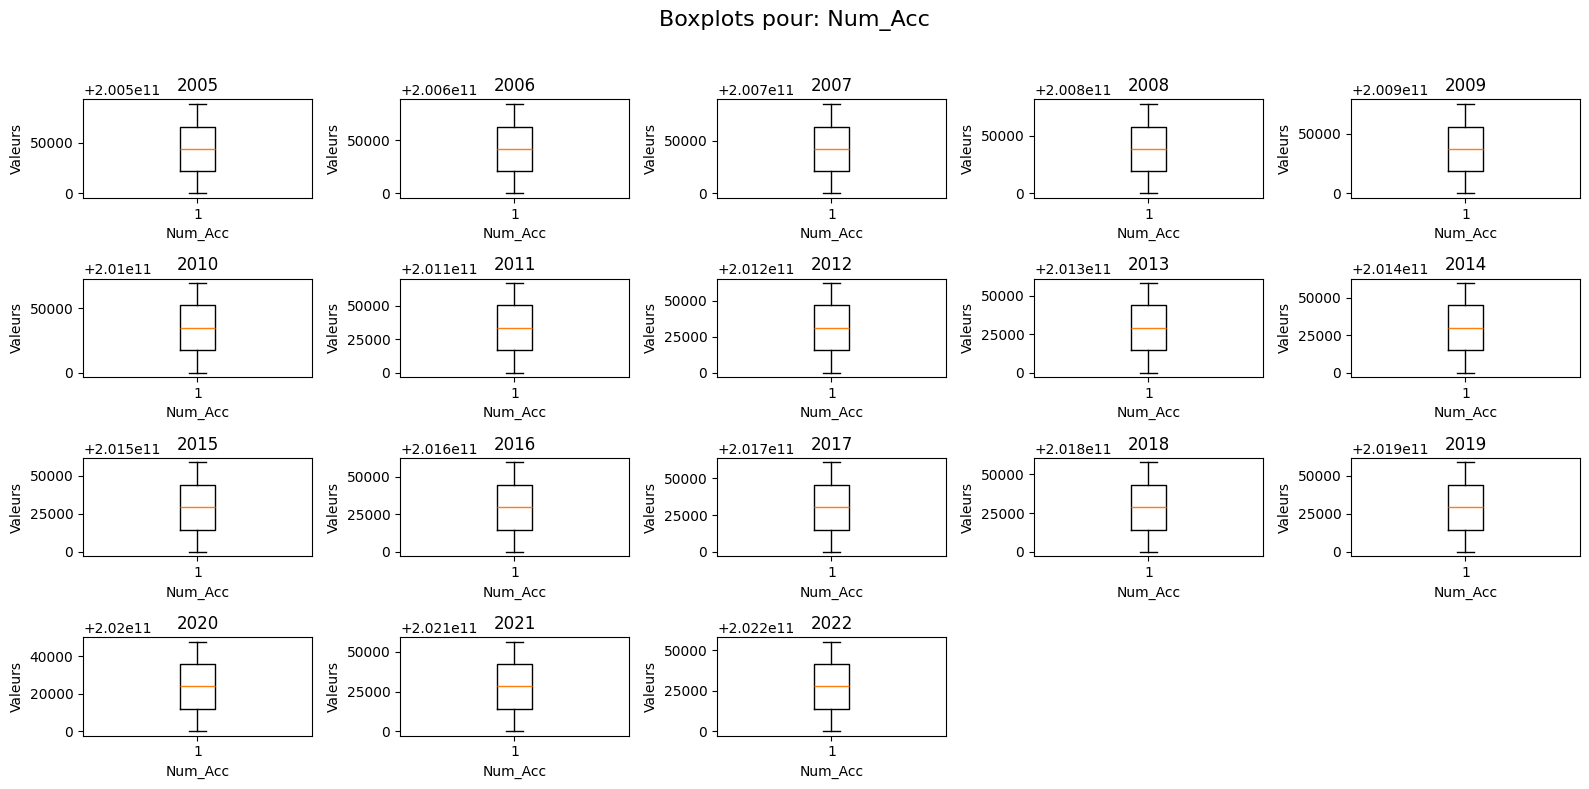

2024-06-12 13:25:04,389 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:25:04,618 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Régime de circulation :

Modalités:
- -1: Non renseigné
- 1: A sens unique
- 2: Bidirectionnelle
- 3: A chaussées séparées
- 4: Avec voies d’affectation variable
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         2                              0                                  0
   2006  int64         2                              0                                  0
   2007  int64         2                              0                                  0
   2008  int64         2                              0                                  0
   2009  float64       2                              0.0819793                          5.18323e-05
   2010  float64       2                              0.0634198                          3.73872e-05
   2011  float64       2                

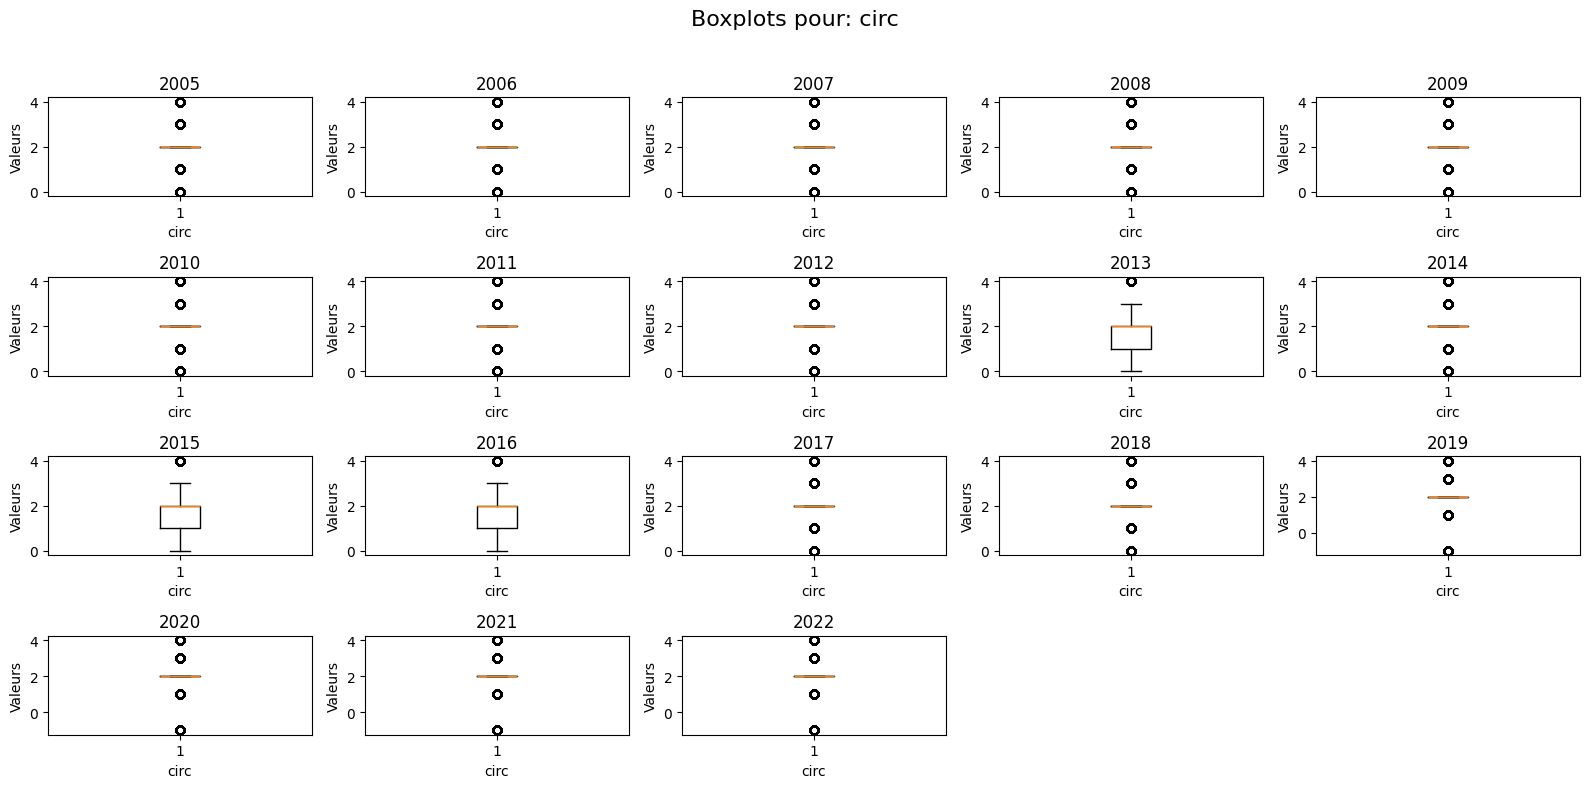

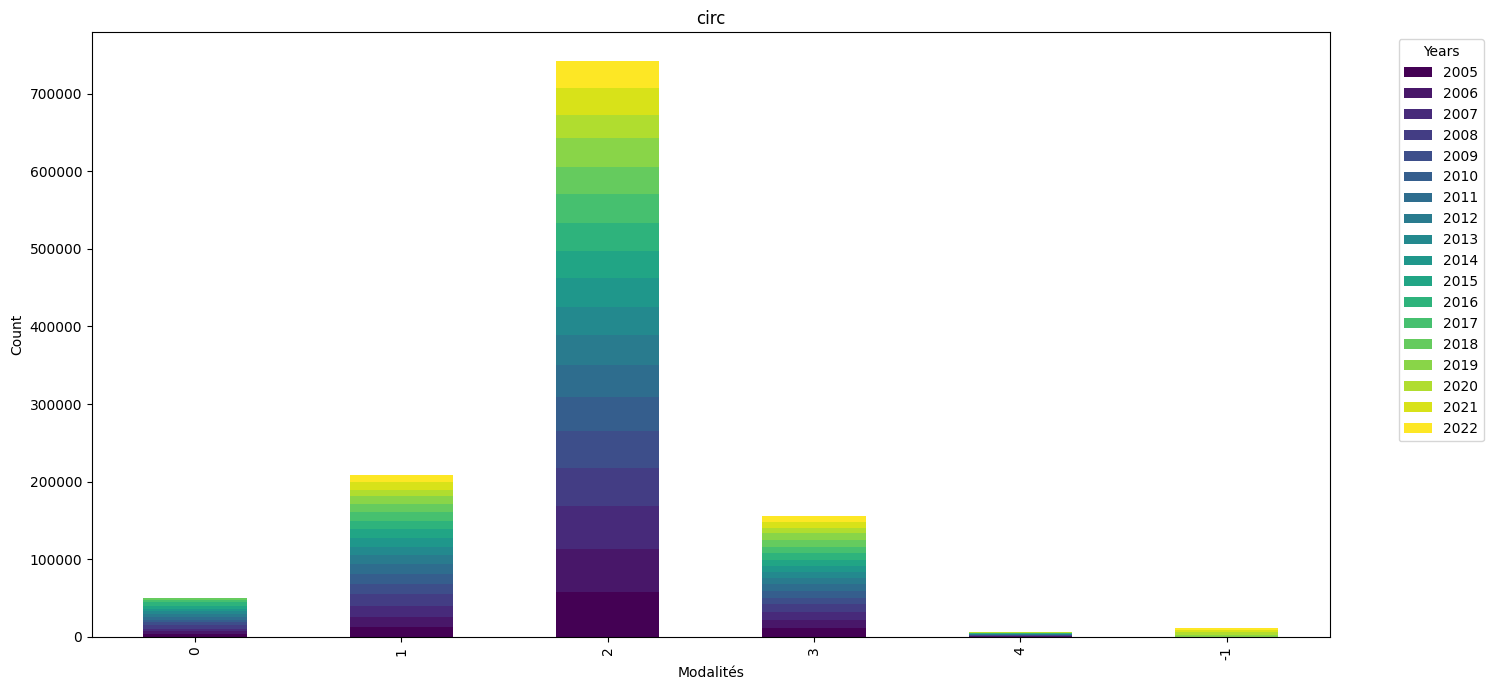

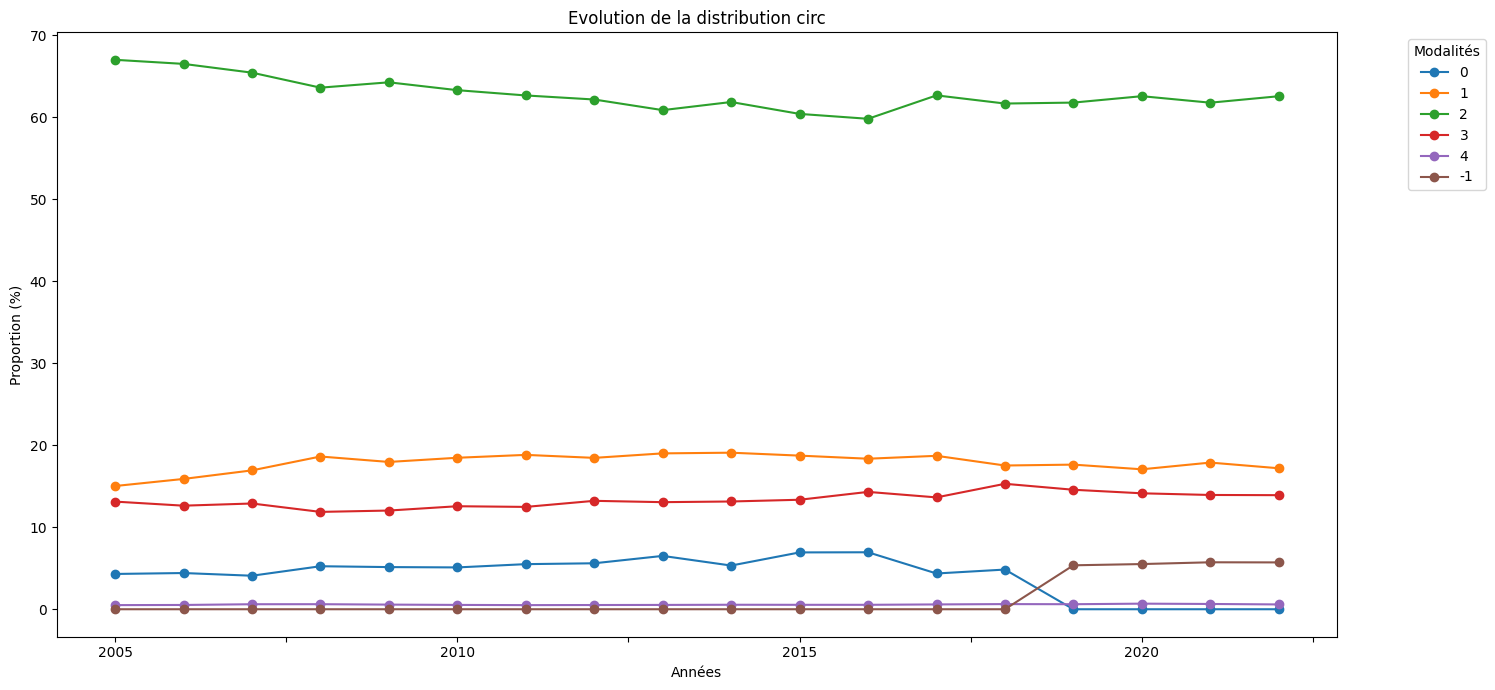

lignes: 1176873

Description: Nombre total de voies de circulation.
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         2                               0                                 0
   2006  int64         2                               0                                 0
   2007  int64         2                               0                                 0
   2008  int64         2                               0                                 0
   2009  float64       2                               0.862799                          0.000545513
   2010  float64       2                               0.147019                          8.66704e-05
   2011  float64       2                               0.267268                          0.000152098
   2012  float64       2                               0.424096

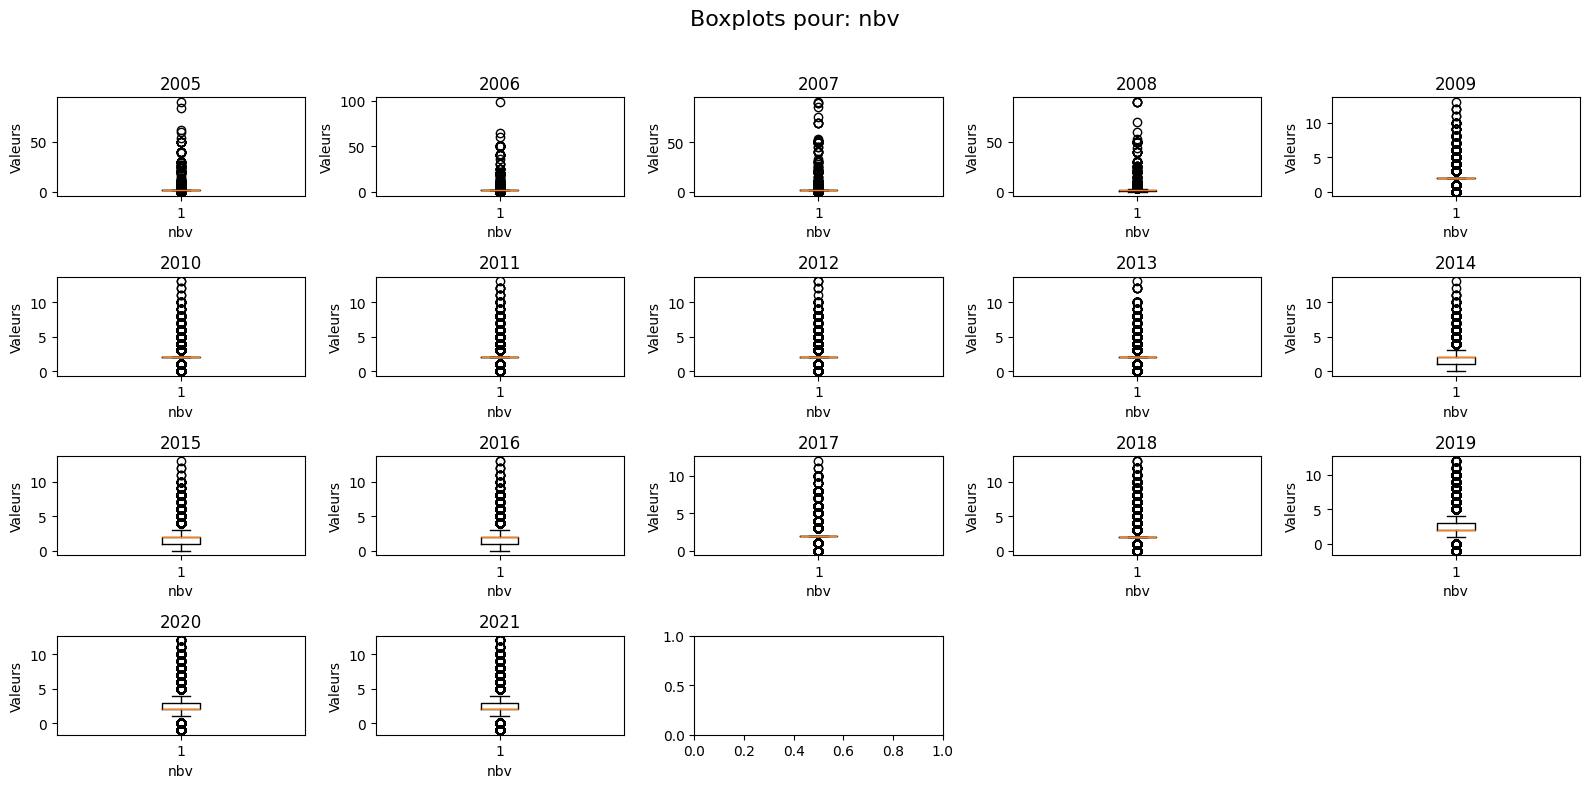

2024-06-12 13:25:09,724 - WARNING - Le nombre de modalités uniques dans la colonne nbv excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:25:09,743 - WARNING - Le nombre de modalités uniques dans la colonne nbv excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Tracé en plan :

Modalités:
- -1: Non renseigné
- 1: Partie rectiligne
- 2: En courbe à gauche
- 3: En courbe à droite
- 4: En « S »
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.100794                           6.37282e-05
   2010  float64       1                              0.0619784                          3.65375e-05
   2011  float64       1                              0.191119       

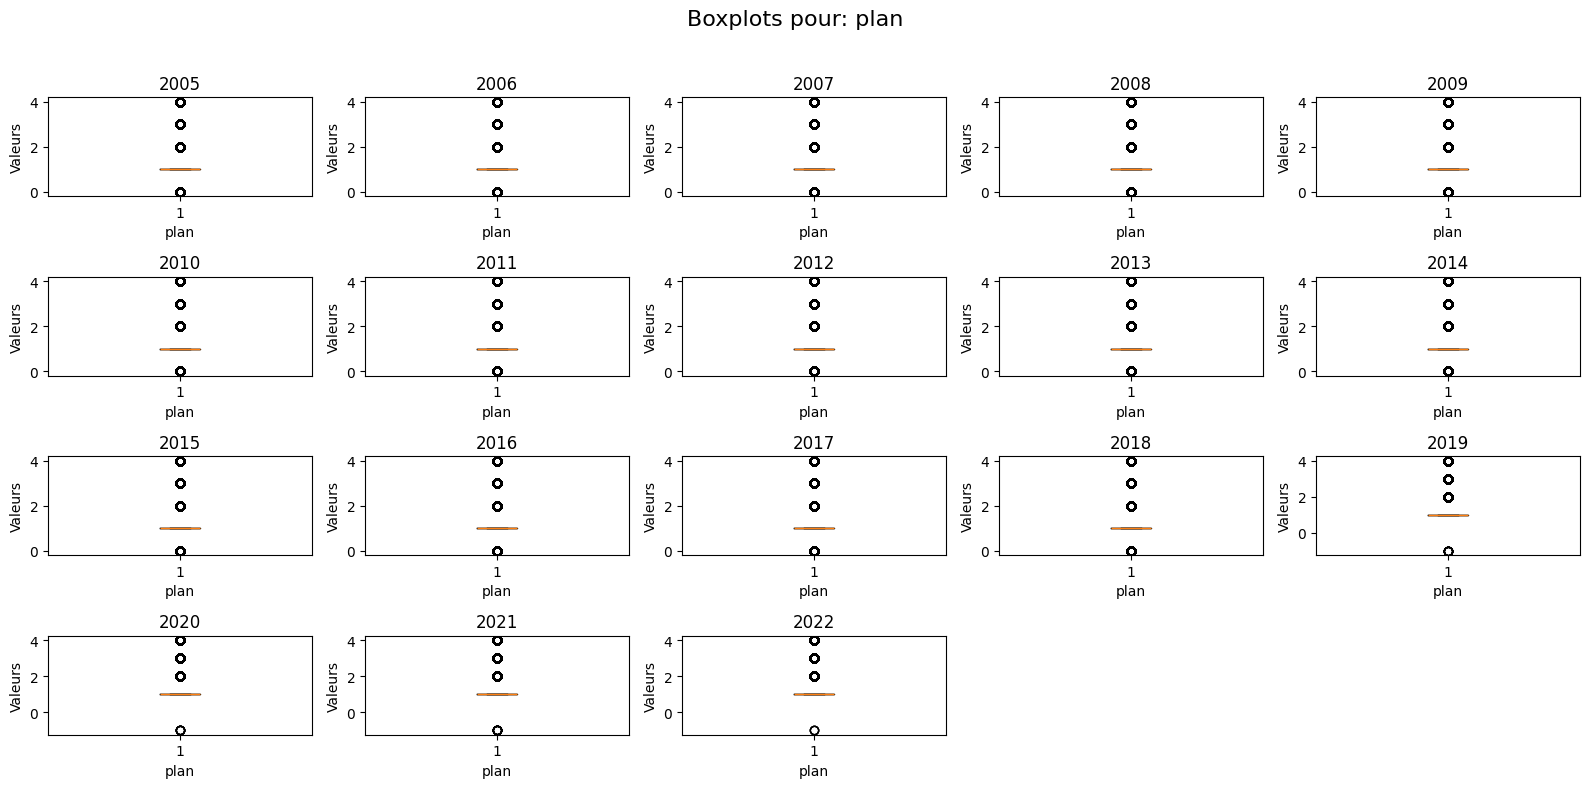

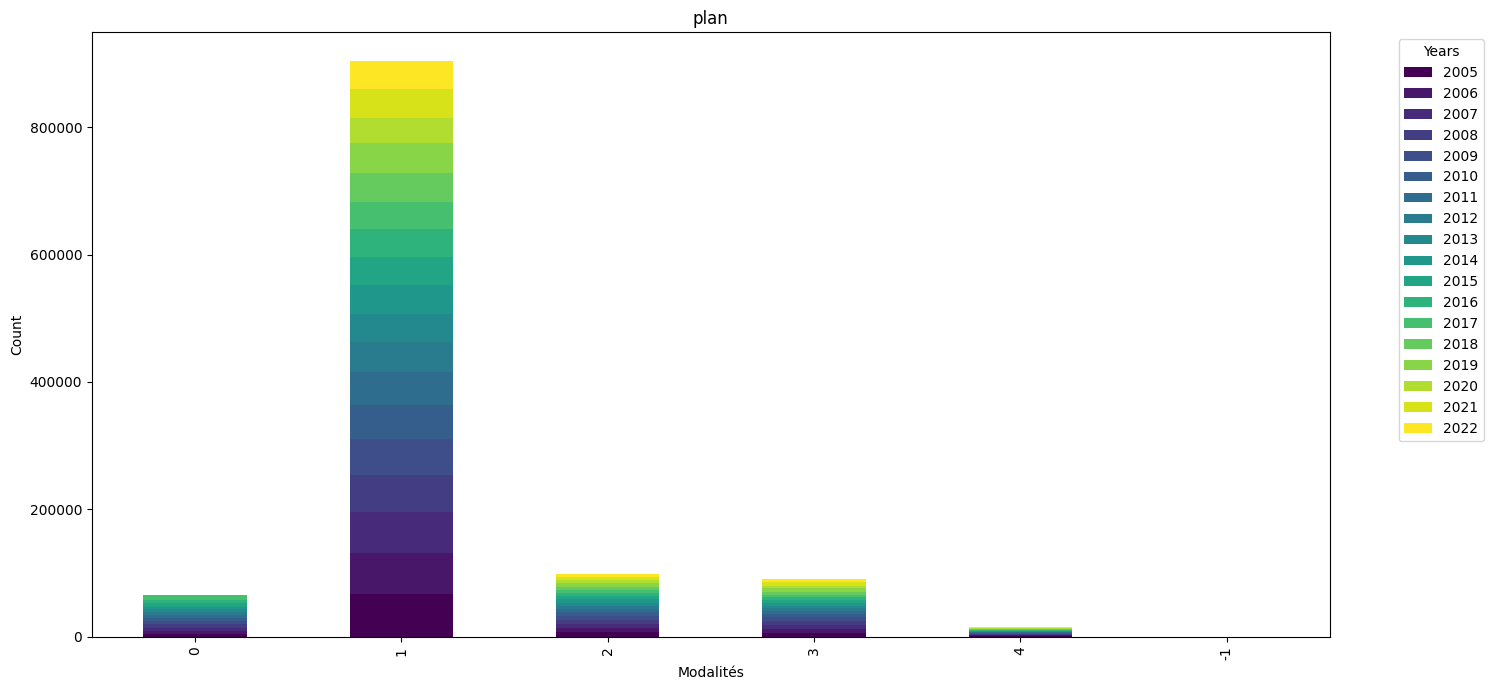

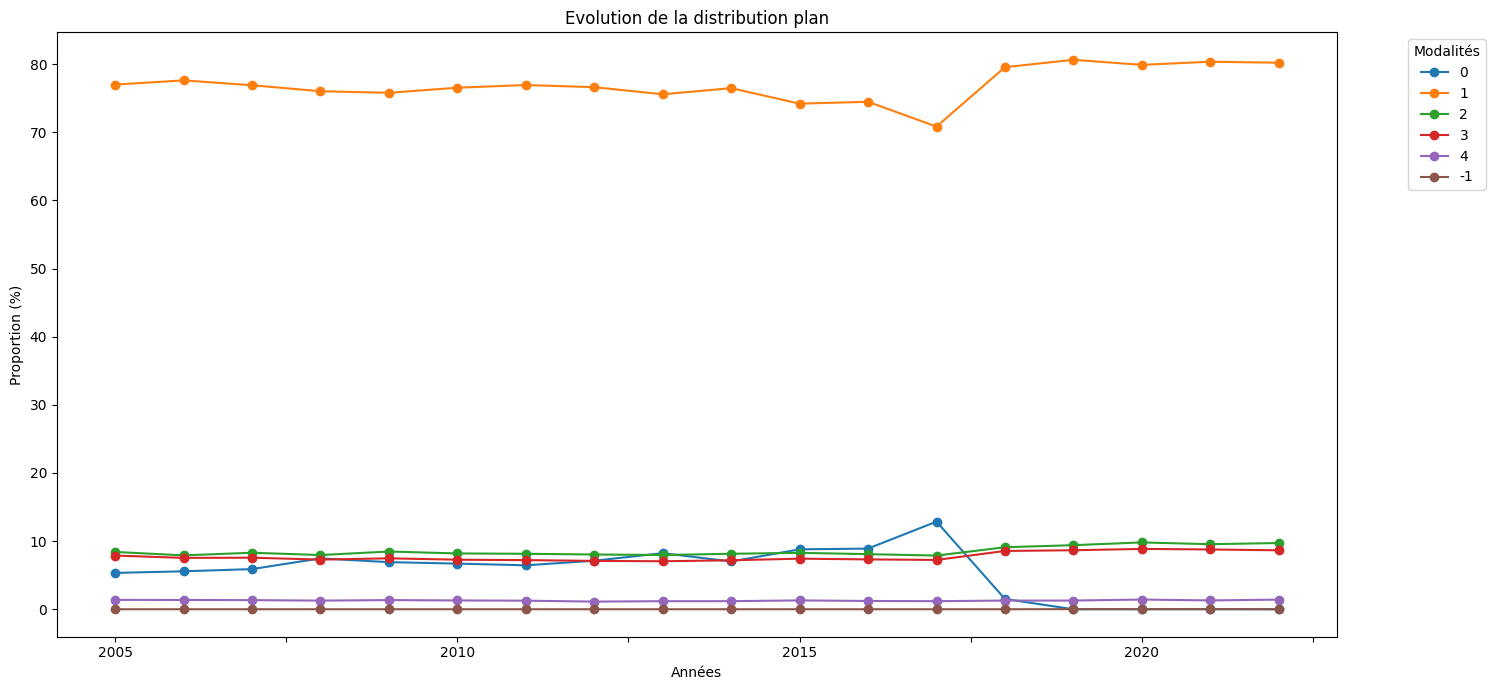

2024-06-12 13:25:13,533 - INFO - Pas de description pour `v1` dans la section `LIEUX`.


lignes: 1176873

  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64       0                             0.235562                            0.00017419
   2006  float64       0                             0.0385575                           2.71907e-05
   2007  float64       0                             0.00715564                          5.09826e-06
   2008  float64       0                             0.0130264                           8.49709e-06
   2009  float64       2                            99.5511                              0.0629422
   2010  float64       2                            99.6353                              0.058737
   2011  float64       2                            99.6297                              0.0566977
   2012  float64       2                            99.5984                       

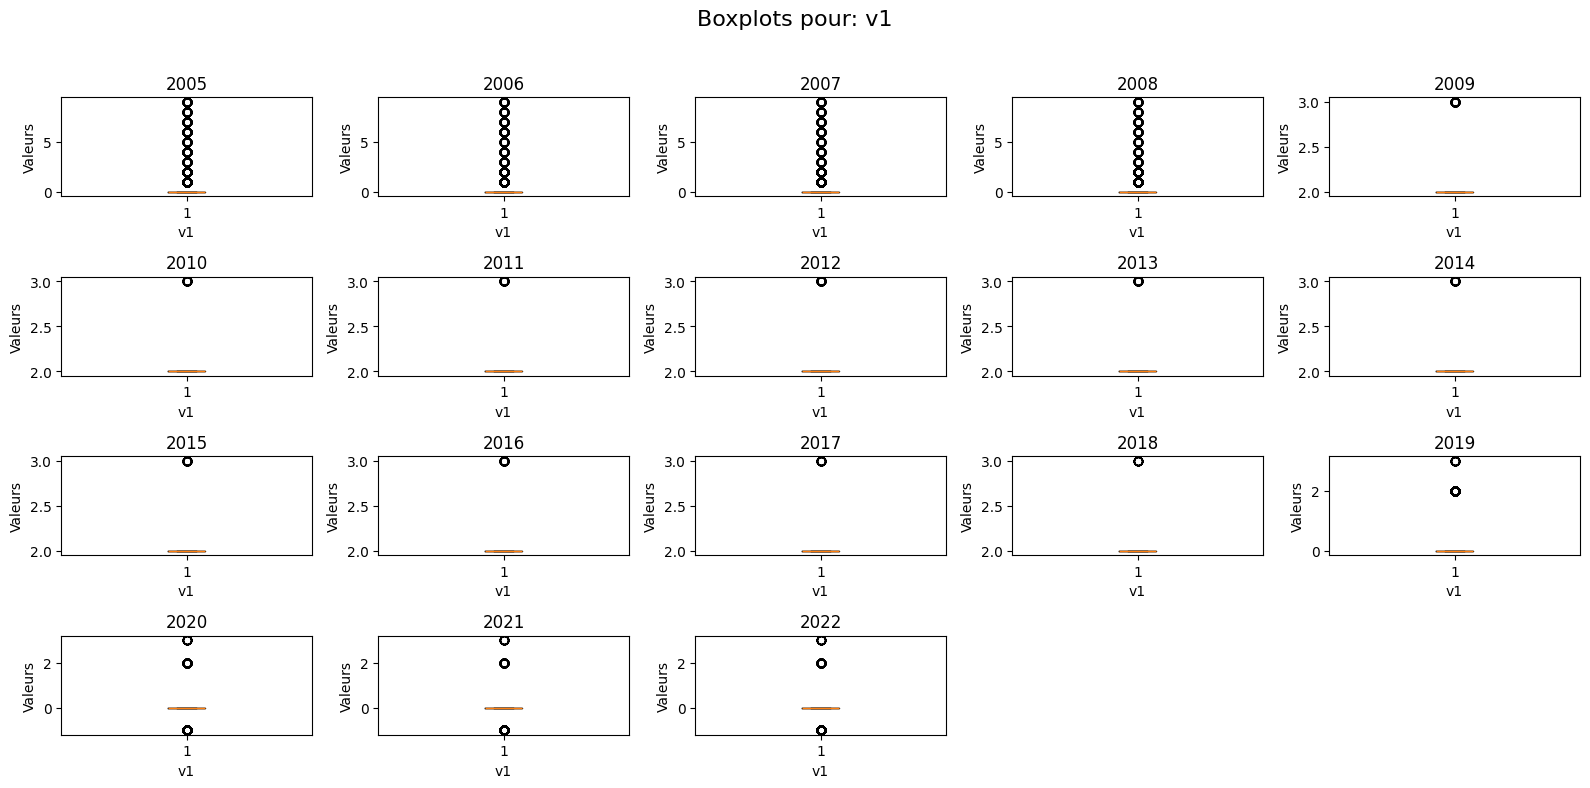

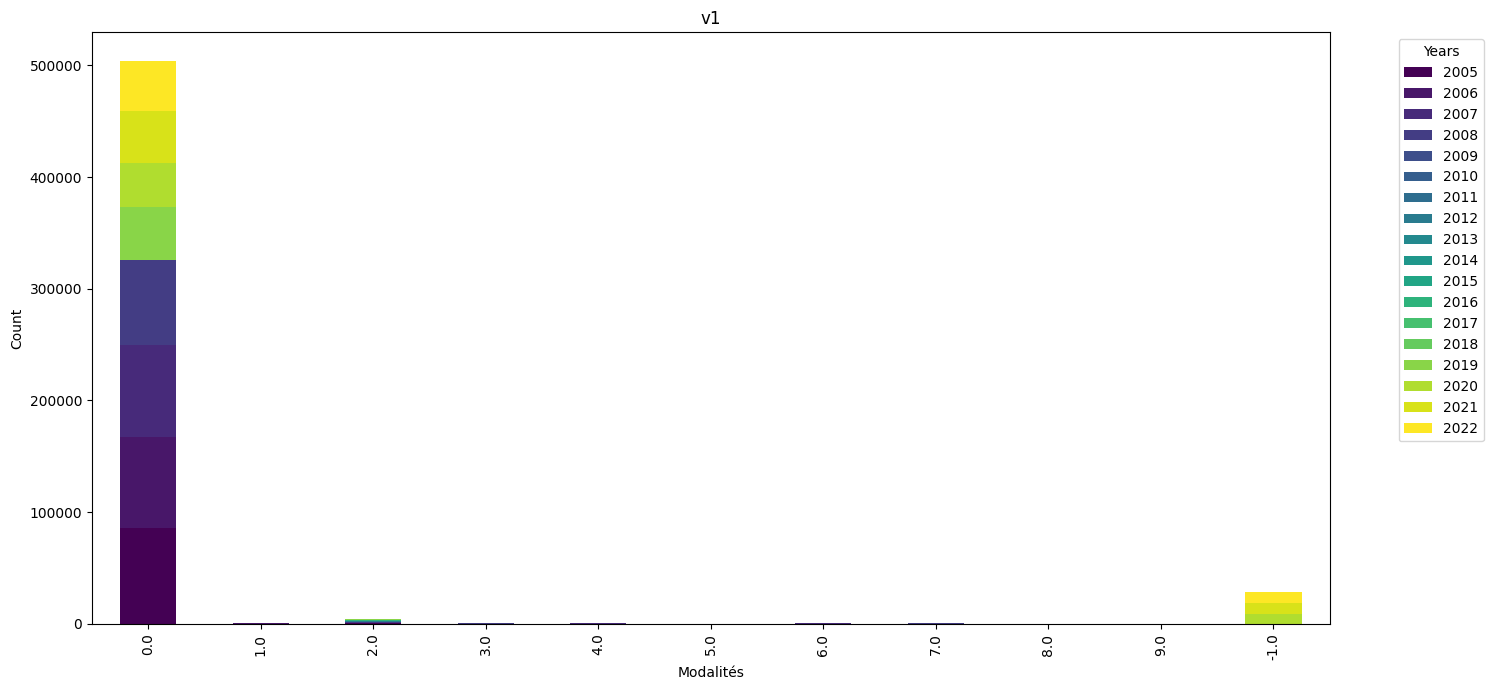

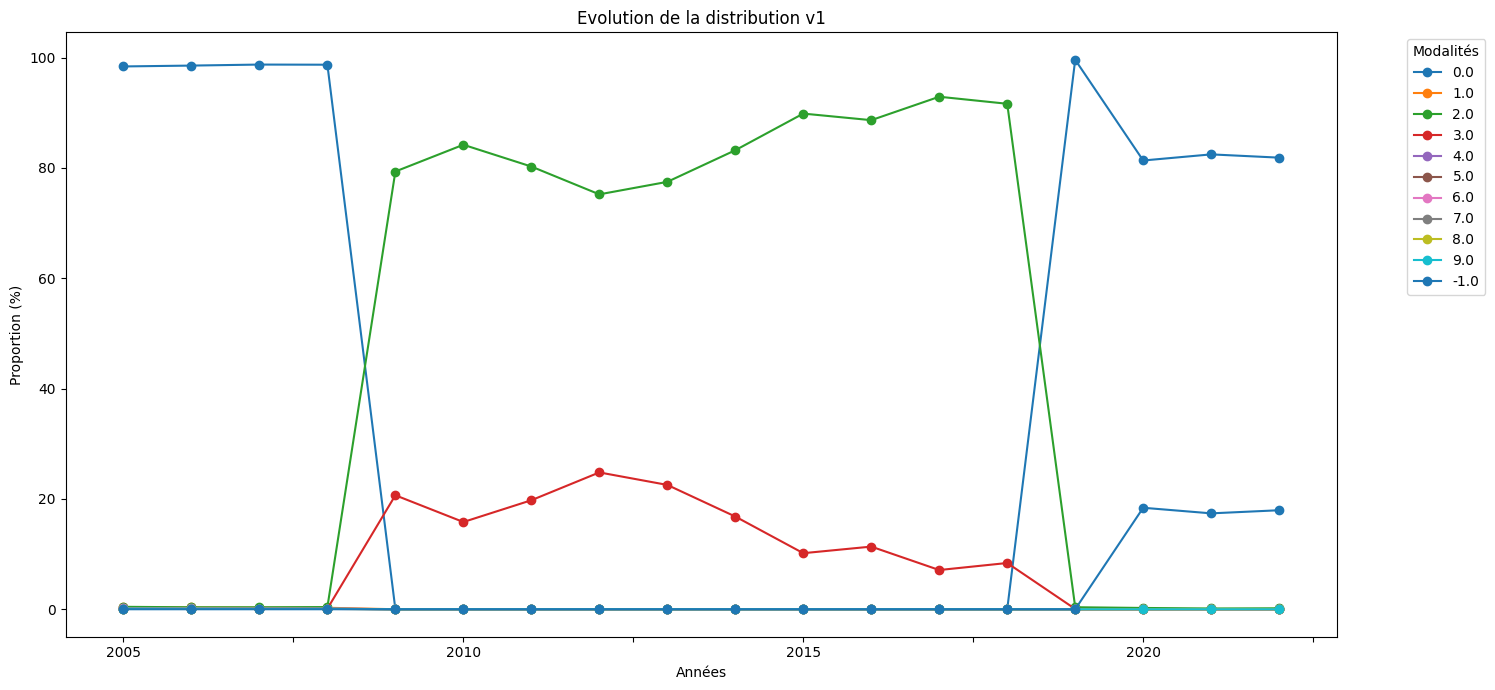

2024-06-12 13:25:17,608 - INFO - Pas de description pour `v2` dans la section `LIEUX`.
2024-06-12 13:25:17,613 - INFO - La colonne v2 n'est pas numérique.
2024-06-12 13:25:17,669 - WARNING - Le nombre de modalités uniques dans la colonne v2 excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:25:17,751 - WARNING - Le nombre de modalités uniques dans la colonne v2 excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

  Année  Type    Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  object  A                                     97.5456                            0.0721318
   2006  object  A                                     93.7127                            0.0660861
   2007  object  A                                     93.8831                            0.06689
   2008  object  A                                     94.5419                            0.0616694
   2009  object  A                                     95.5731                            0.0604271
   2010  object  A                                     97.0596                            0.0572186
   2011  object  A                                     96.9988                            0.0552005
   2012  object  0                                     96.1012                       

lignes: 1176873

Description: Etat de la surface :

Modalités:
- -1: Non renseigné
- 1: Normale
- 2: Mouillée
- 3: Flaques
- 4: Inondée
- 5: Enneigée
- 6: Boue
- 7: Verglacée
- 8: Corps gras – huile
- 9: Autre
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.0913868                          5.77802e-05
   2010  float64       1                              0.0605371                          3.56878e-05
   2011  float64      

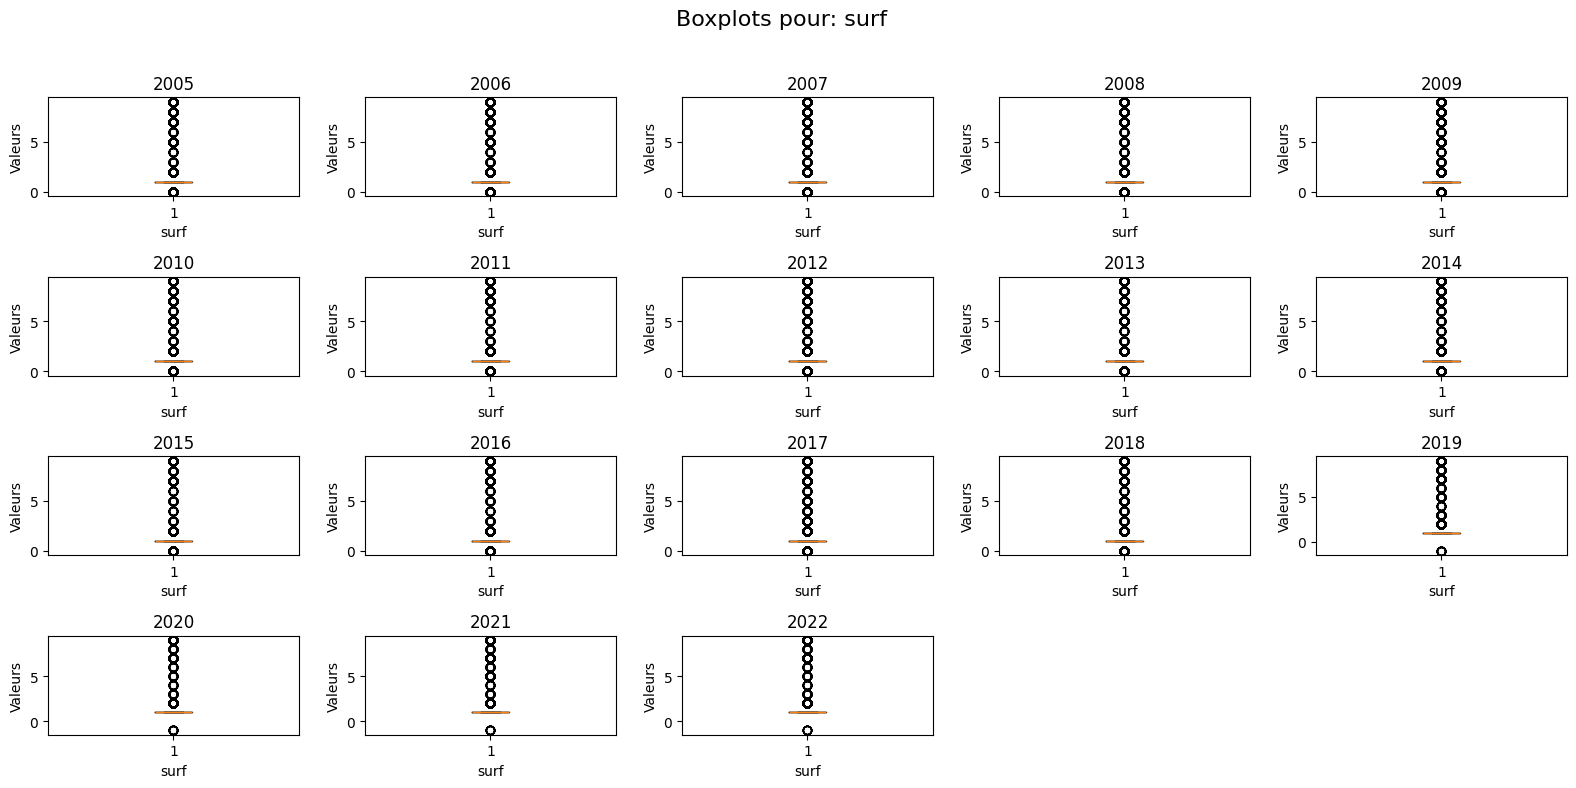

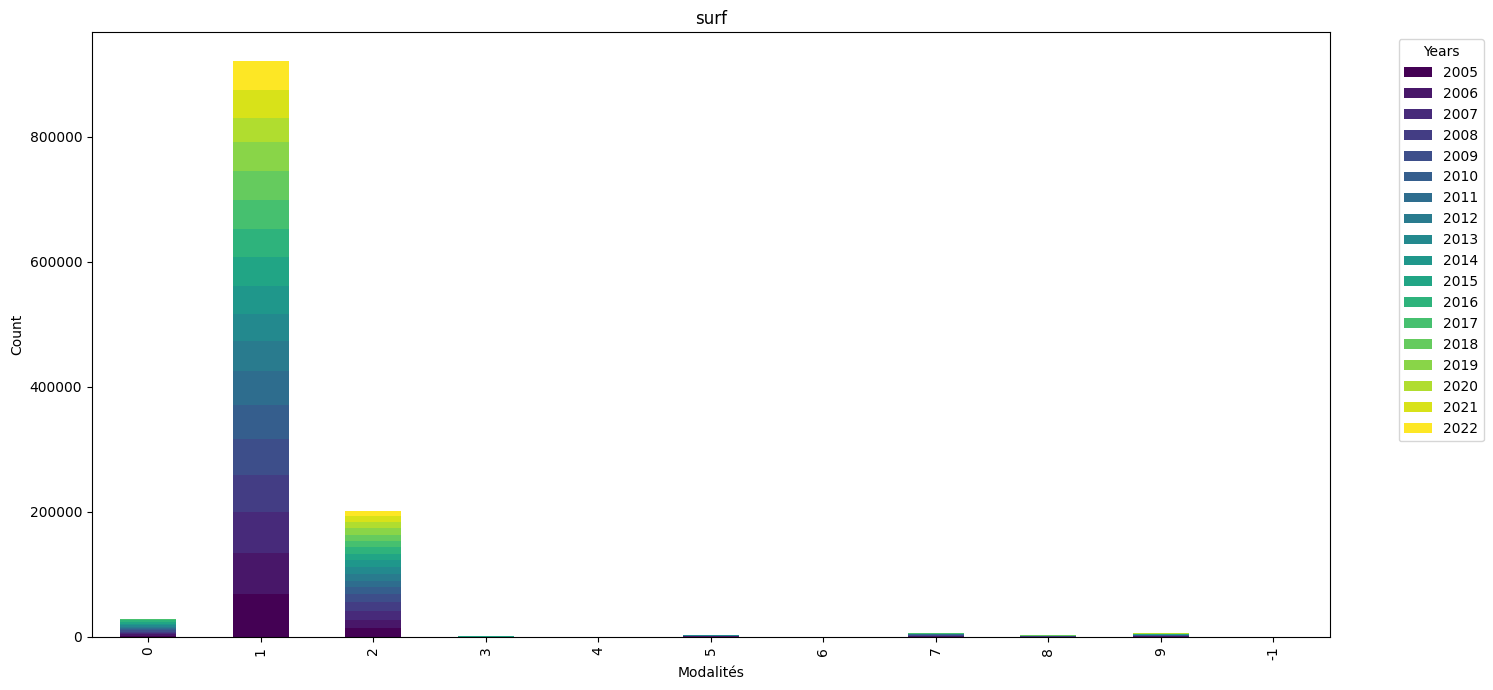

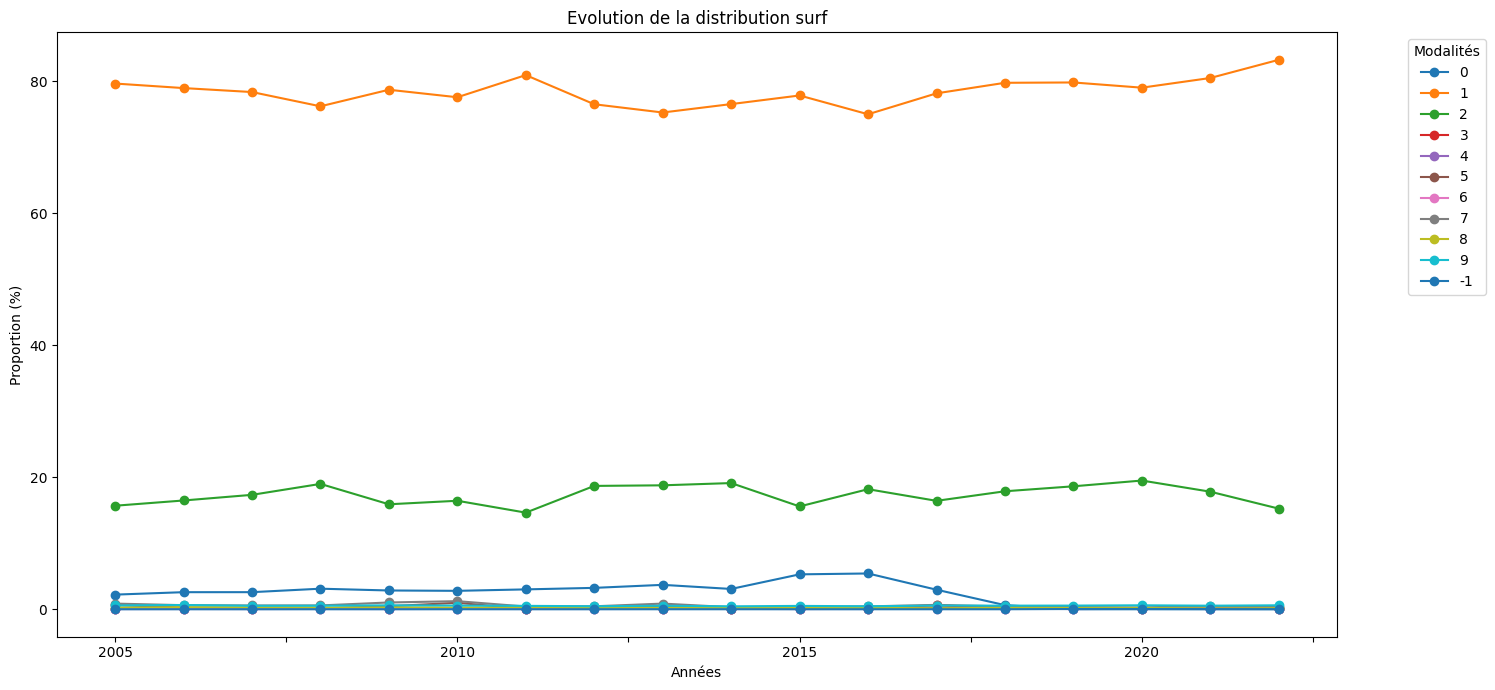

lignes: 1176873

Description: Numéro de la route.
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64       0                             8.65144                             0.00639746
   2006  float64       0                             9.57671                             0.00675349
   2007  float64       0                             3.99165                             0.00284398
   2008  float64       0                             0.00651322                          4.24855e-06
   2009  float64       0                             1.98632                             0.00125587
   2010  float64       0                             2.23266                             0.0013162
   2011  float64       0                             7.15352                             0.00407096
   2012  float64       0                        

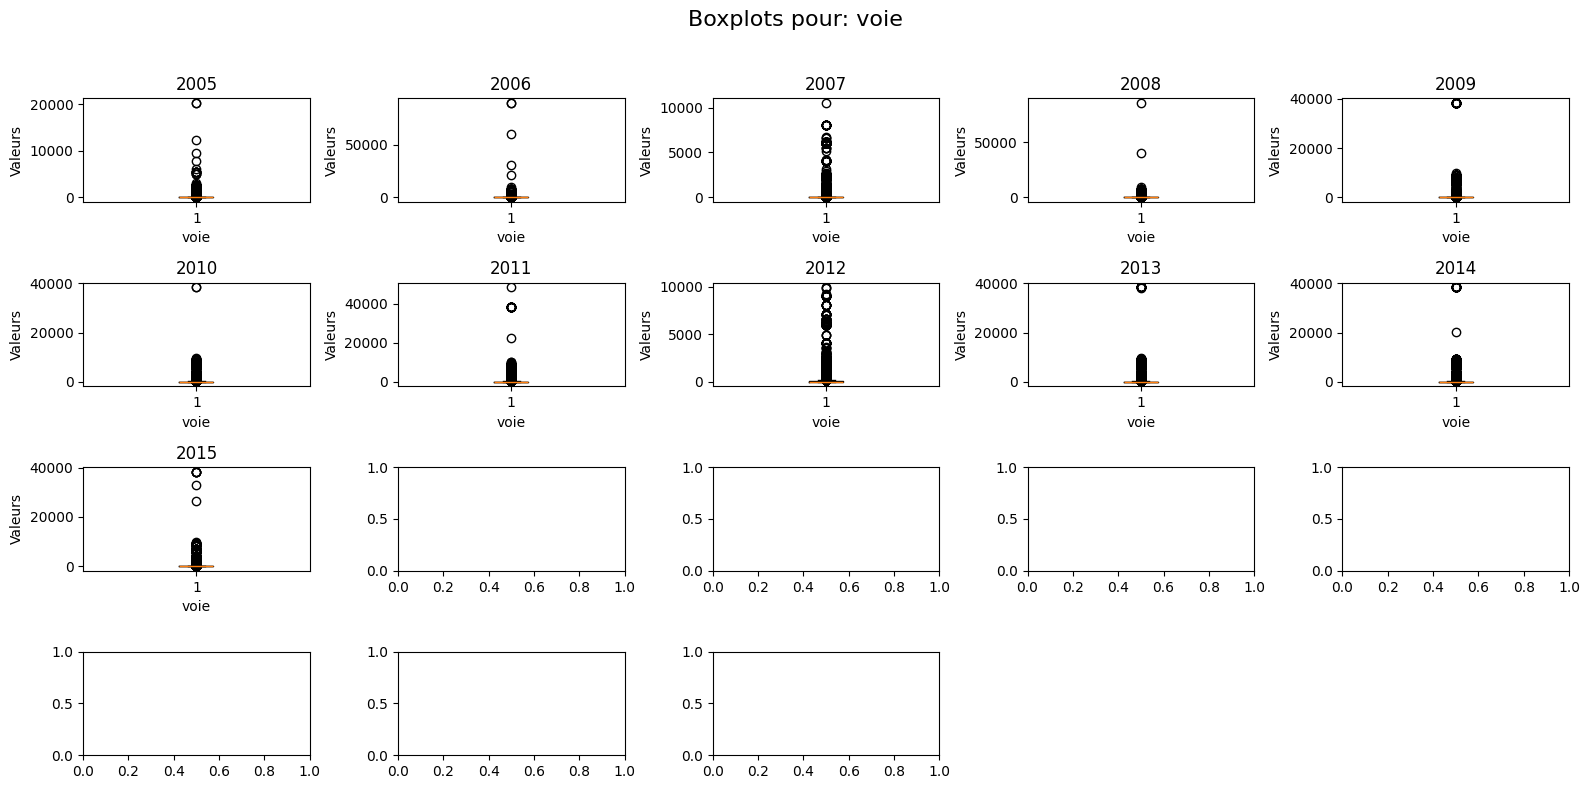

2024-06-12 13:25:27,097 - WARNING - Le nombre de modalités uniques dans la colonne voie excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:25:27,223 - WARNING - Le nombre de modalités uniques dans la colonne voie excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Catégorie de route :

Modalités:
- 1: Autoroute
- 2: Route nationale
- 3: Route Départementale
- 4: Voie Communales
- 5: Hors réseau public
- 6: Parc de stationnement ouvert à la circulation publique
- 7: Routes de métropole urbaine
- 9: Autre
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64       4                             0.00114908                          8.49709e-07
   2006  int64         4                             0                                   0
   2007  int64         4                             0                                   0
   2008  int64         4                             0                                   0
   2009  int64         4                             0                                   0
   2010  int64         4                             0     

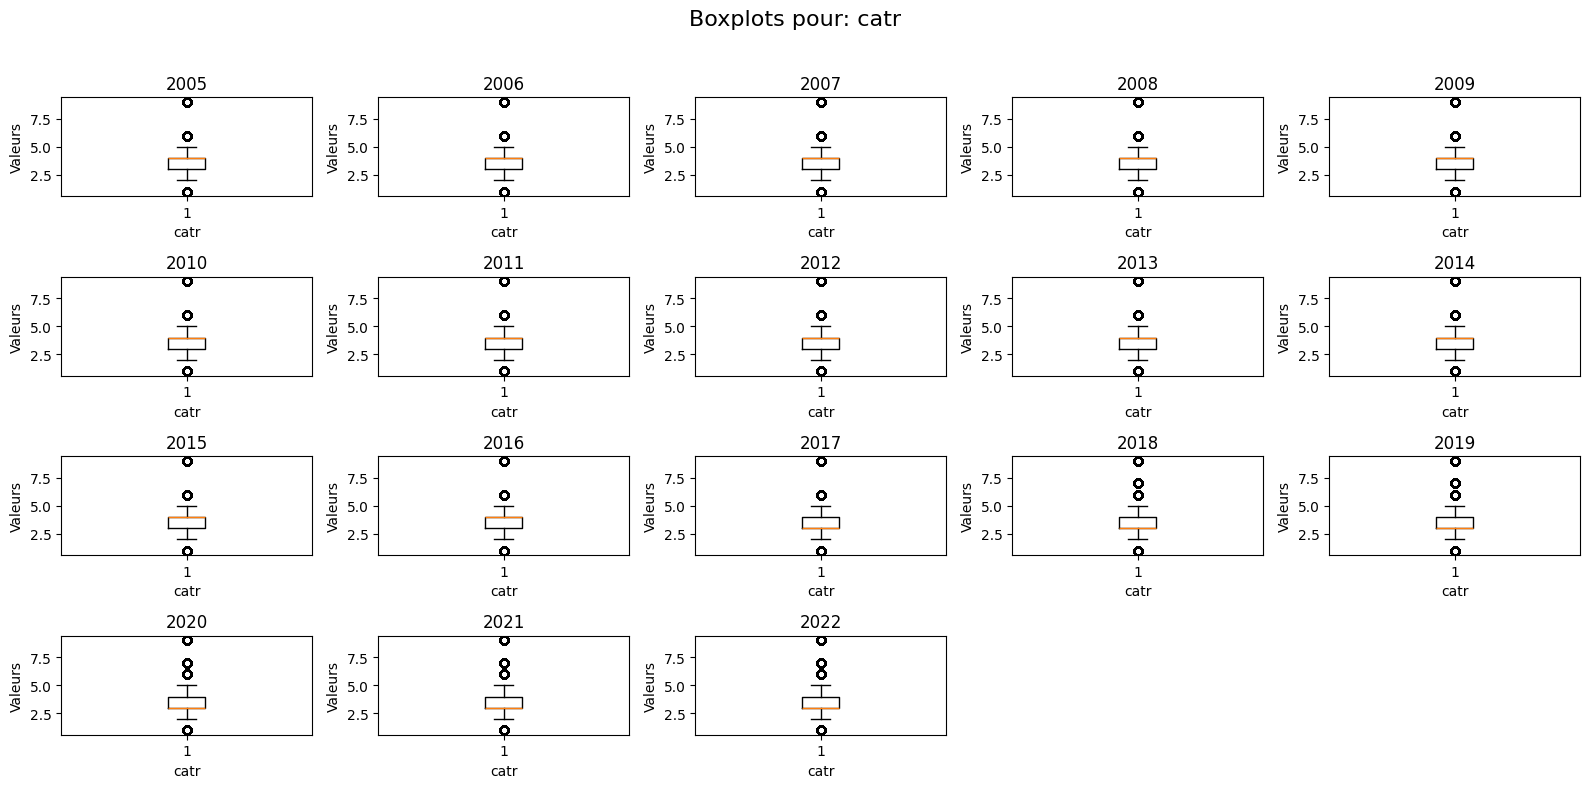

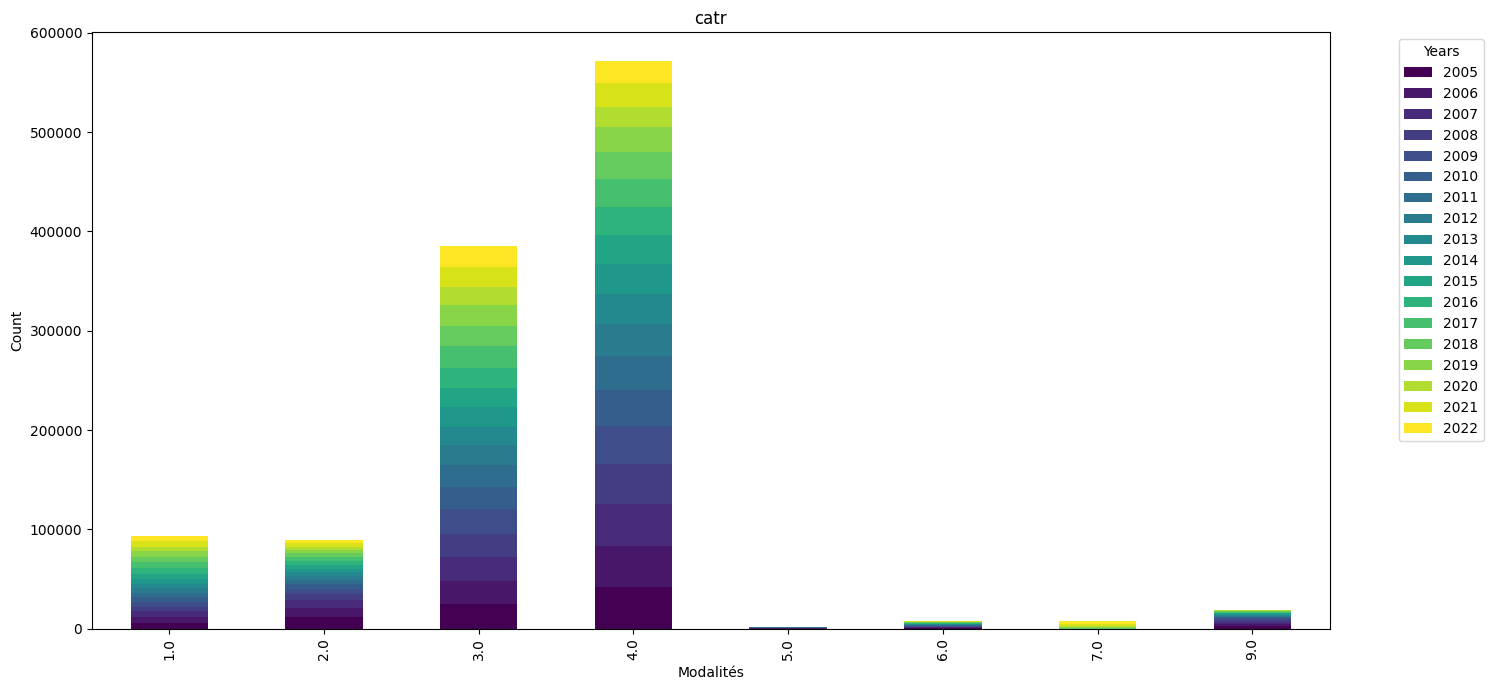

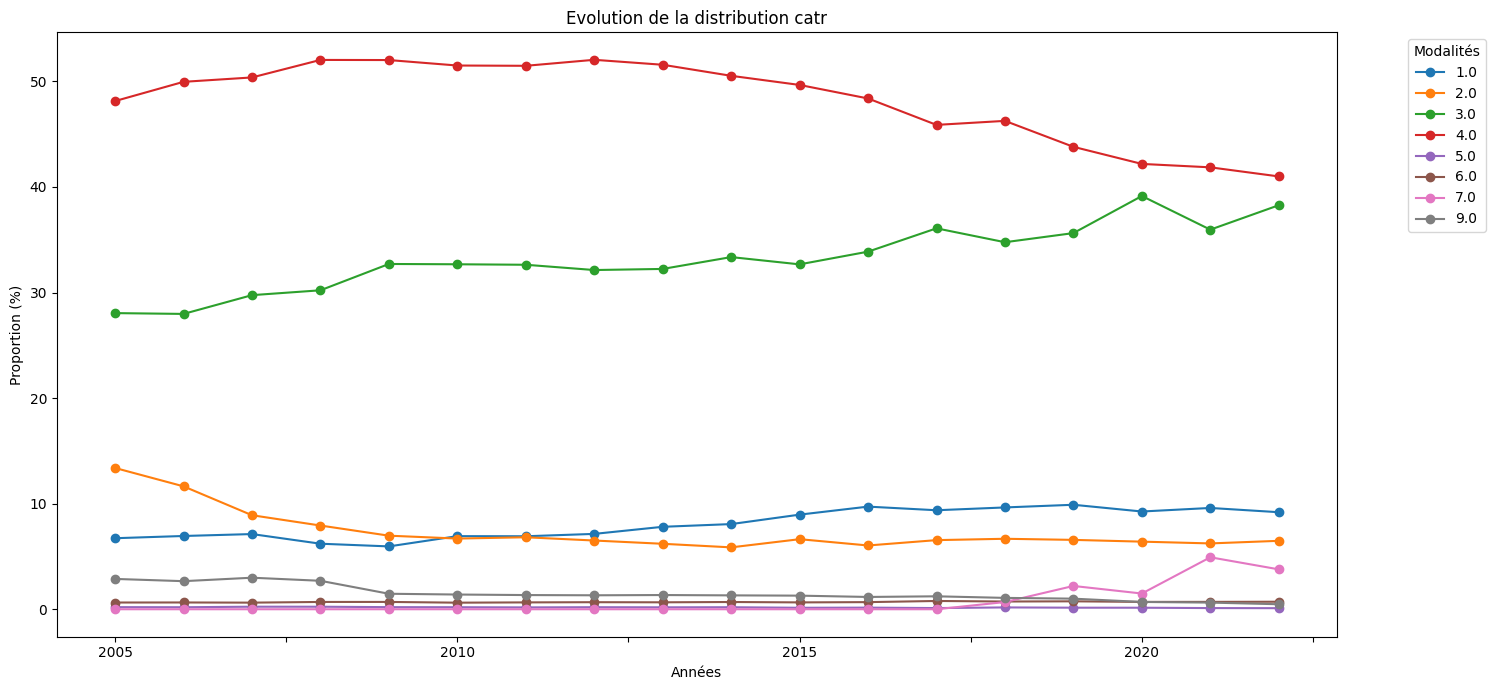

lignes: 1176873

Description: Numéro du PR de rattachement (numéro de la borne amont). La valeur -1 signifie que le PR n’est pas renseigné.
  Année  Type     Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64  0.0                                   45.4014                            0.0335729
   2006  float64  0.0                                   46.6678                            0.0329101
   2007  float64  0.0                                   53.5015                            0.0381188
   2008  float64  0.0                                   58.8039                            0.0383576
   2009  float64  0.0                                   37.4753                            0.0236941
   2010  float64  0.0                                   40.5137                            0.0238836
   2011  float64  0.0                               

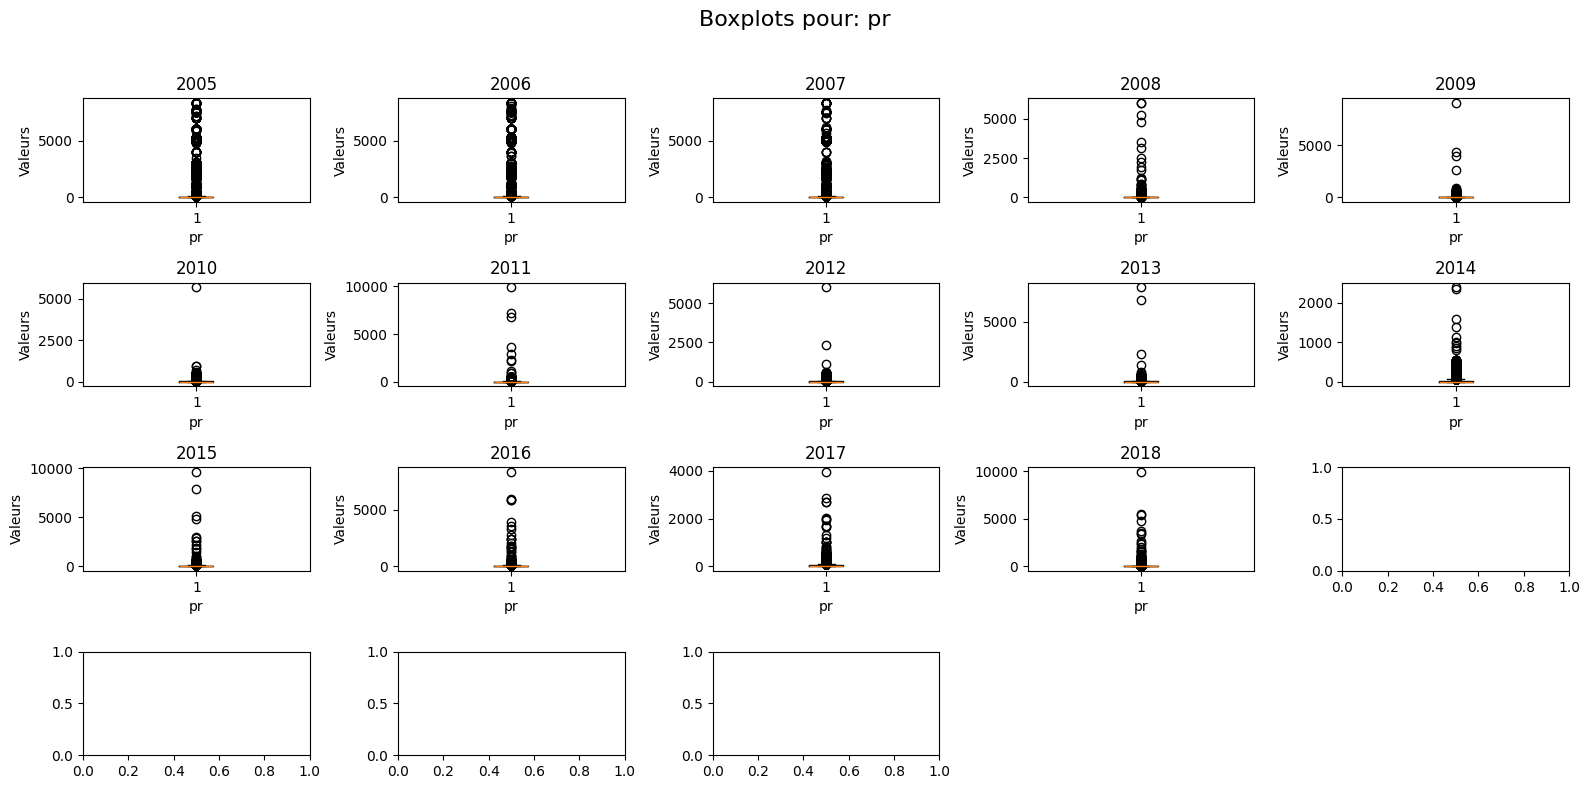

2024-06-12 13:25:34,704 - WARNING - Le nombre de modalités uniques dans la colonne pr excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:25:34,759 - WARNING - Le nombre de modalités uniques dans la colonne pr excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Vitesse maximale autorisée sur le lieu et au moment de l’accident.
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2019  int64       50                                      0                                    0
   2020  int64       50                                      0                                    0
   2021  int64       50                                      0                                    0
   2022  int64       50                                      0                                    0


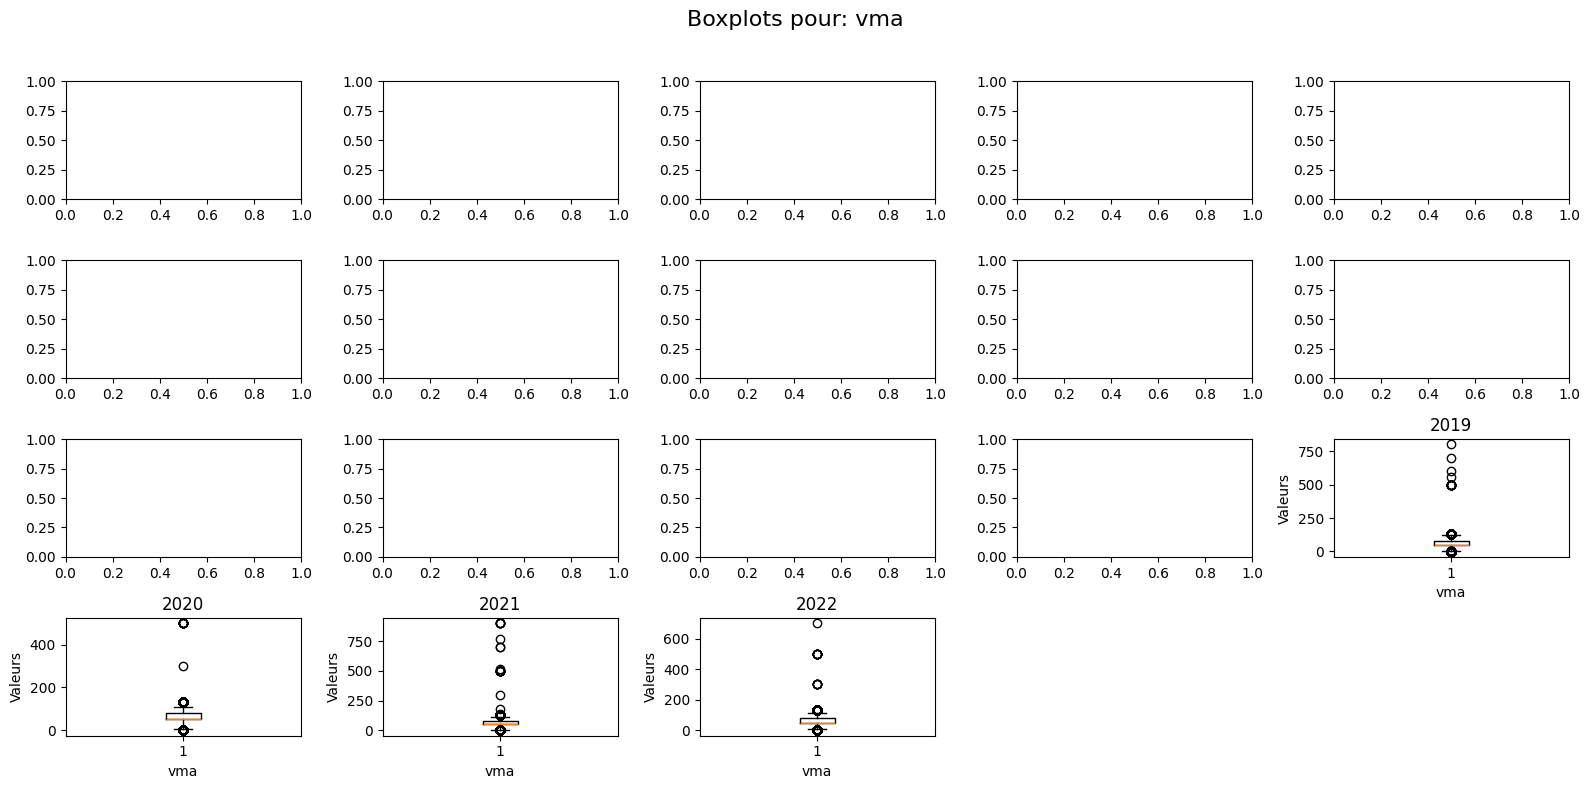

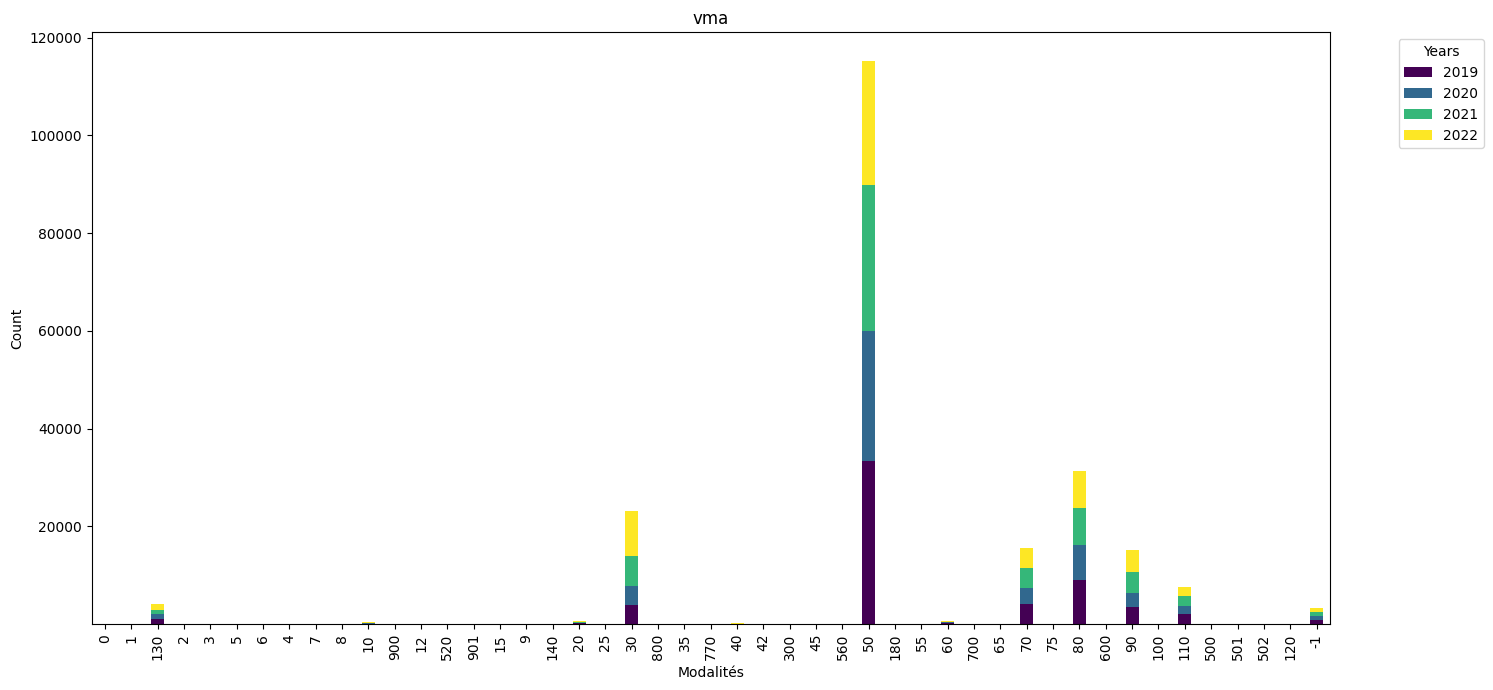

2024-06-12 13:25:39,665 - WARNING - Le nombre de modalités uniques dans la colonne vma excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Signale l’existence d’une voie réservée, indépendamment du fait que l’accident ait lieu ou non sur cette voie.

Modalités:
- -1: Non renseigné
- 0: Sans objet
- 1: Piste cyclable
- 2: Bande cyclable
- 3: Voie réservée
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                               0                                 0
   2006  int64         0                               0                                 0
   2007  int64         0                               0                                 0
   2008  int64         0                               0                                 0
   2009  float64       0                               0.346732                          0.000219225
   2010  float64       0                               0.159991                      

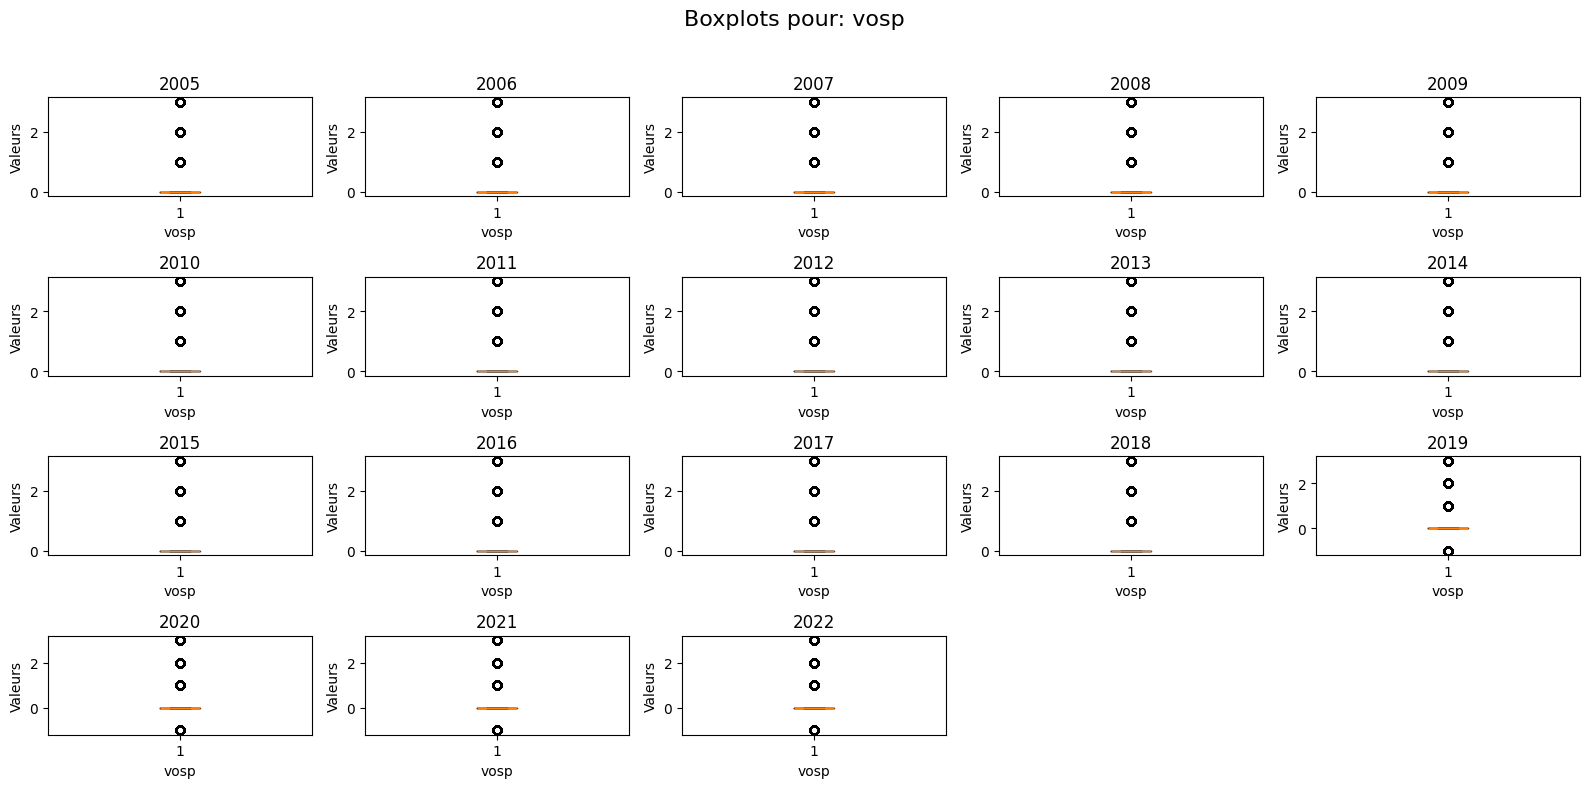

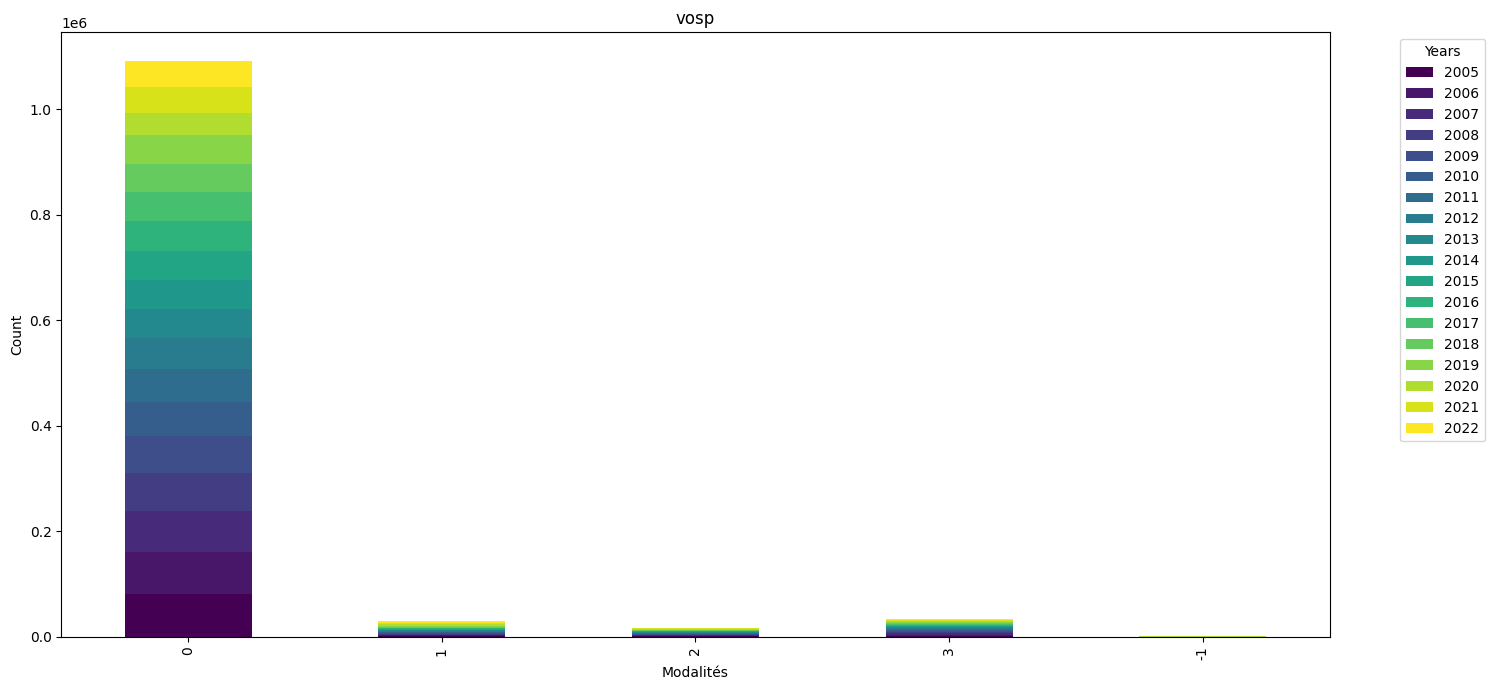

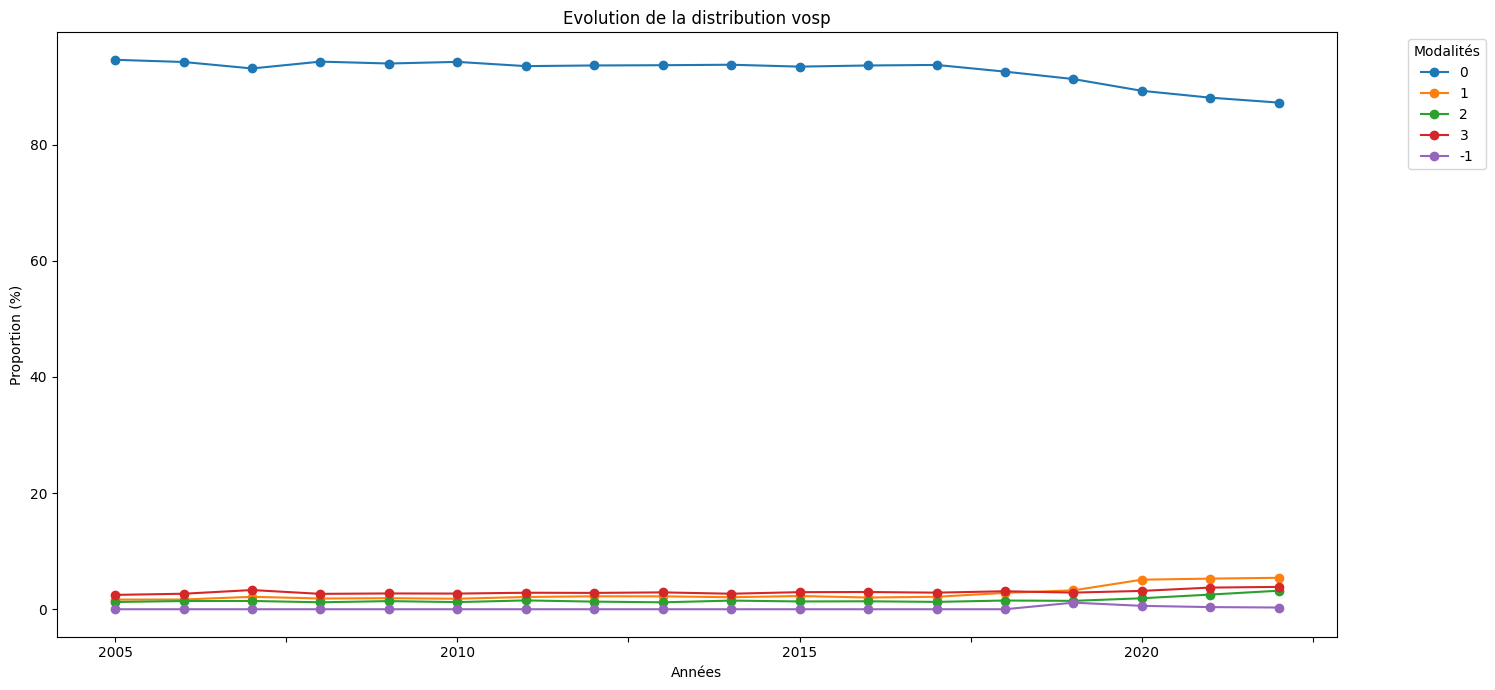

lignes: 1176873

Description: Distance en mètres au PR (par rapport à la borne amont). La valeur -1 signifie que le PR n’est pas renseigné.
  Année  Type     Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64  0.0                                   45.4014                            0.0335729
   2006  float64  0.0                                   46.6678                            0.0329101
   2007  float64  0.0                                   53.5015                            0.0381188
   2008  float64  0.0                                   58.8026                            0.0383567
   2009  float64  0.0                                   37.8892                            0.0239559
   2010  float64  0.0                                   40.6809                            0.0239822
   2011  float64  0.0                               

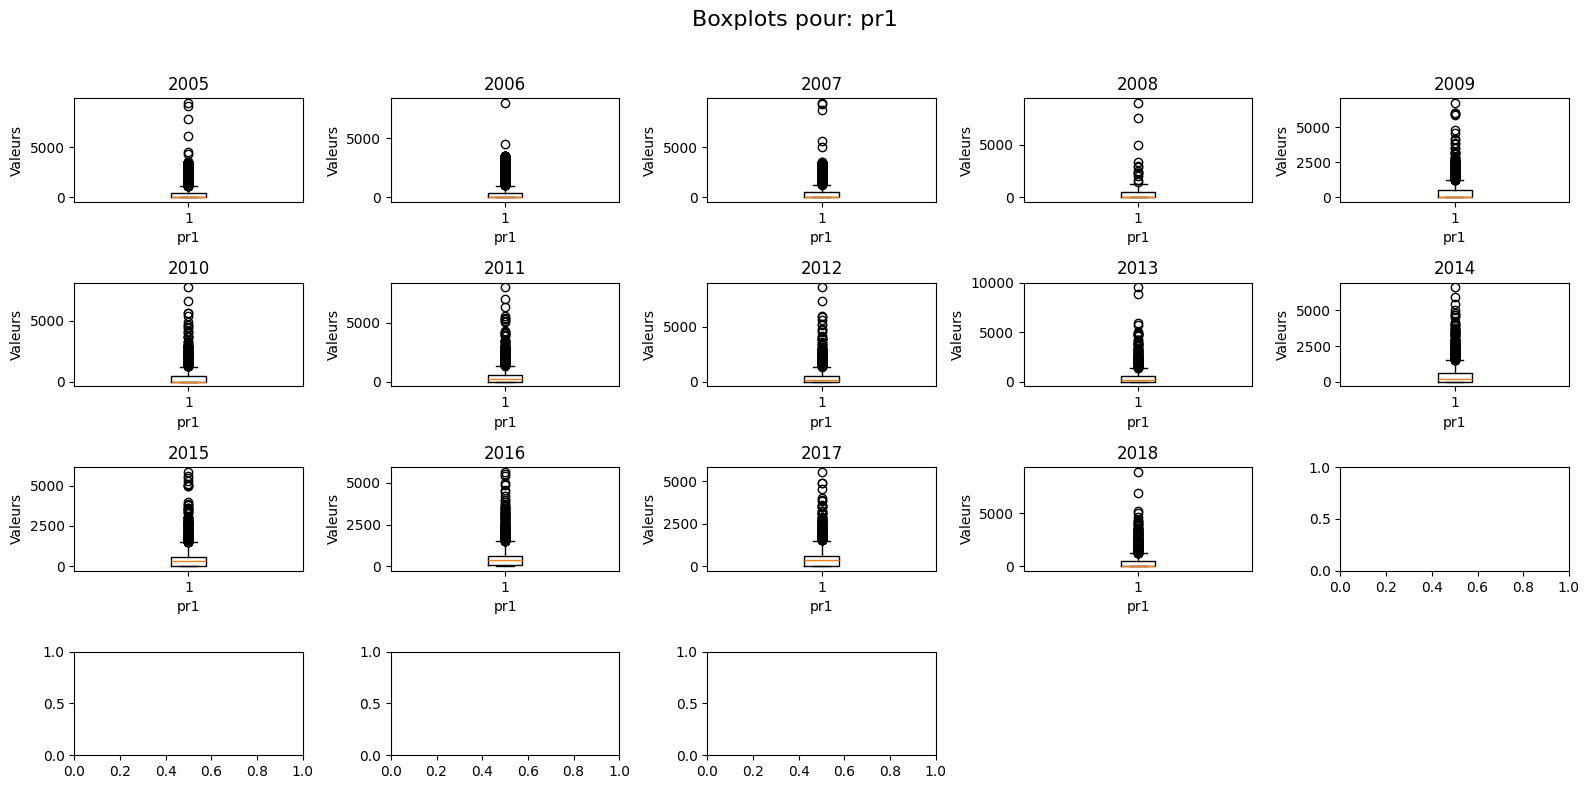

2024-06-12 13:25:45,968 - WARNING - Le nombre de modalités uniques dans la colonne pr1 excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:25:46,037 - WARNING - Le nombre de modalités uniques dans la colonne pr1 excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 1176873

Description: Profil en long décrit la déclivité de la route à l'endroit de l'accident :

Modalités:
- -1: Non renseigné
- 1: Plat
- 2: Pente
- 3: Sommet de côte
- 4: Bas de côte
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.10617                            6.7127e-05
   2010  float64       1                              0.0619784                          3.65375e-05
   2011  float64       1              

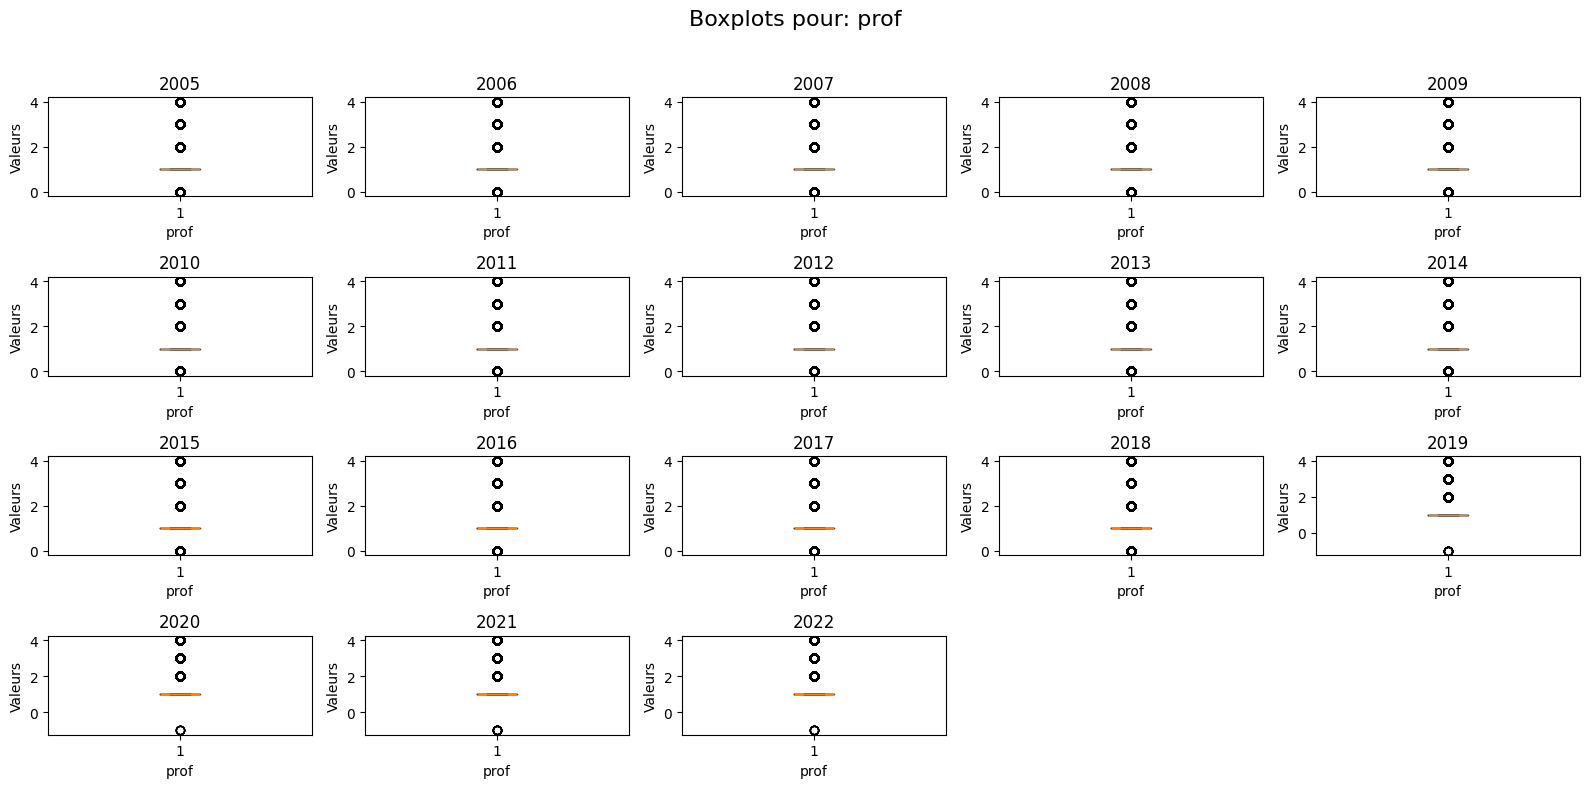

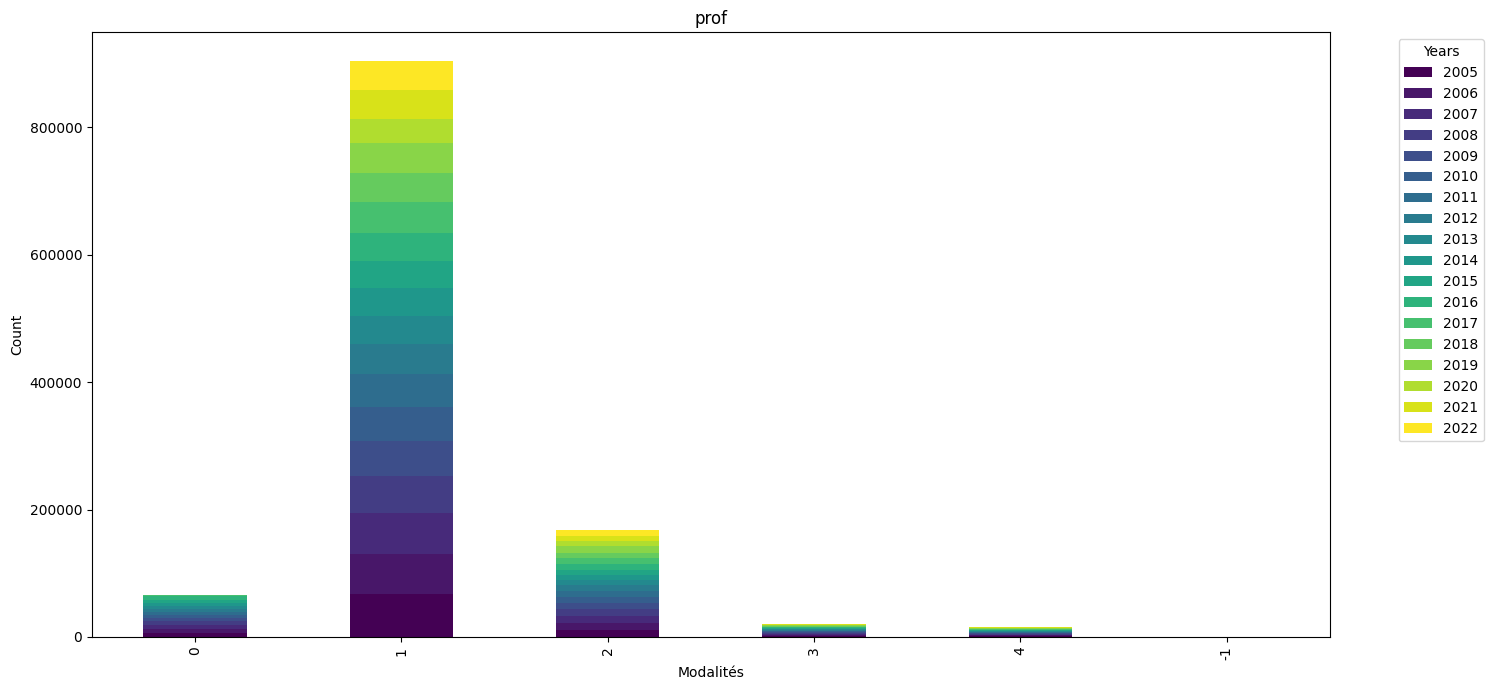

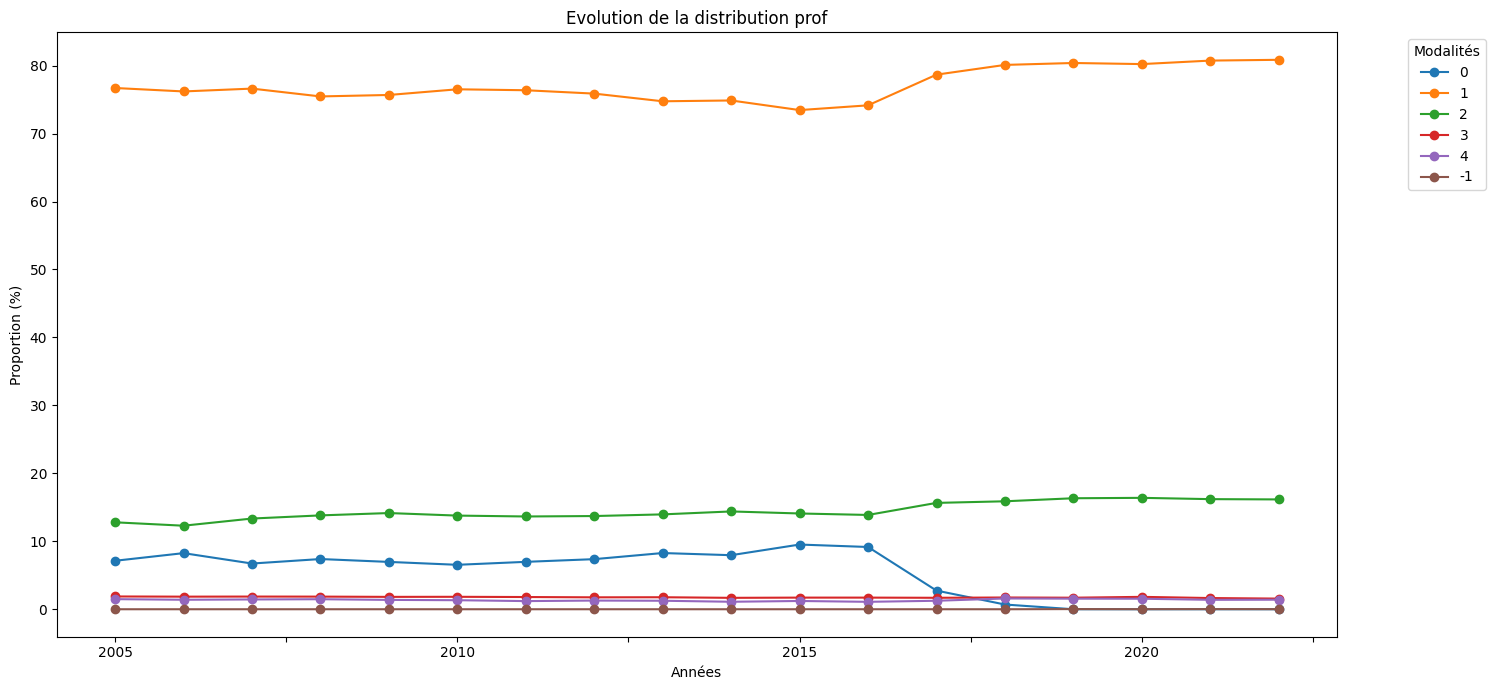

2024-06-12 13:25:51,603 - INFO - Pas de description pour `env1` dans la section `LIEUX`.


lignes: 1176873

  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                               0                                 0
   2006  int64         0                               0                                 0
   2007  int64         0                               0                                 0
   2008  int64         0                               0                                 0
   2009  float64       0                               0.200245                          0.000126607
   2010  float64       0                               0.102336                          6.03294e-05
   2011  float64       0                               0.192612                          0.000109613
   2012  float64       0                               0.432129                          0.000228572
   2013  floa

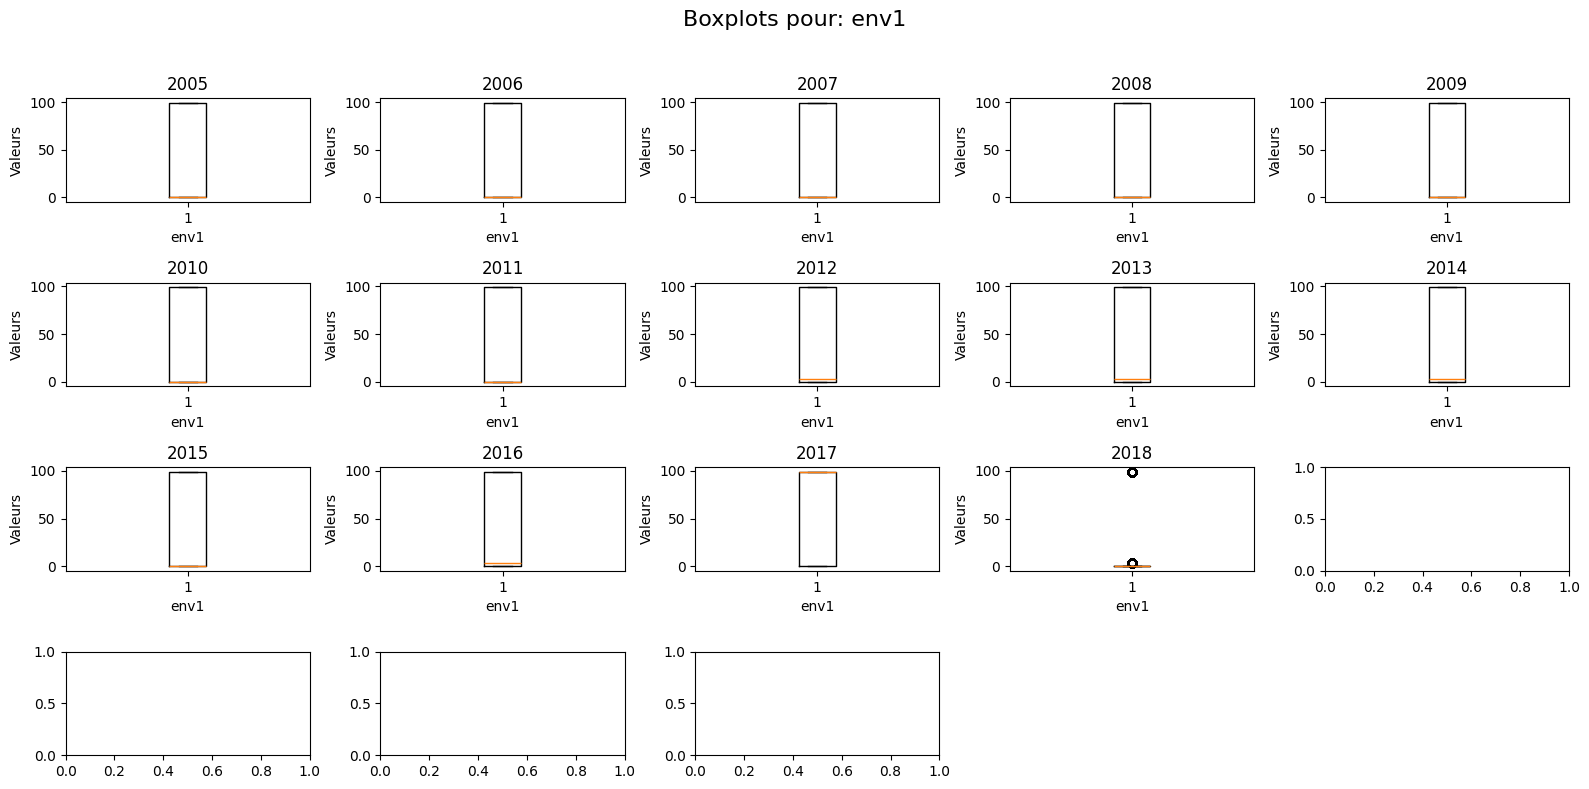

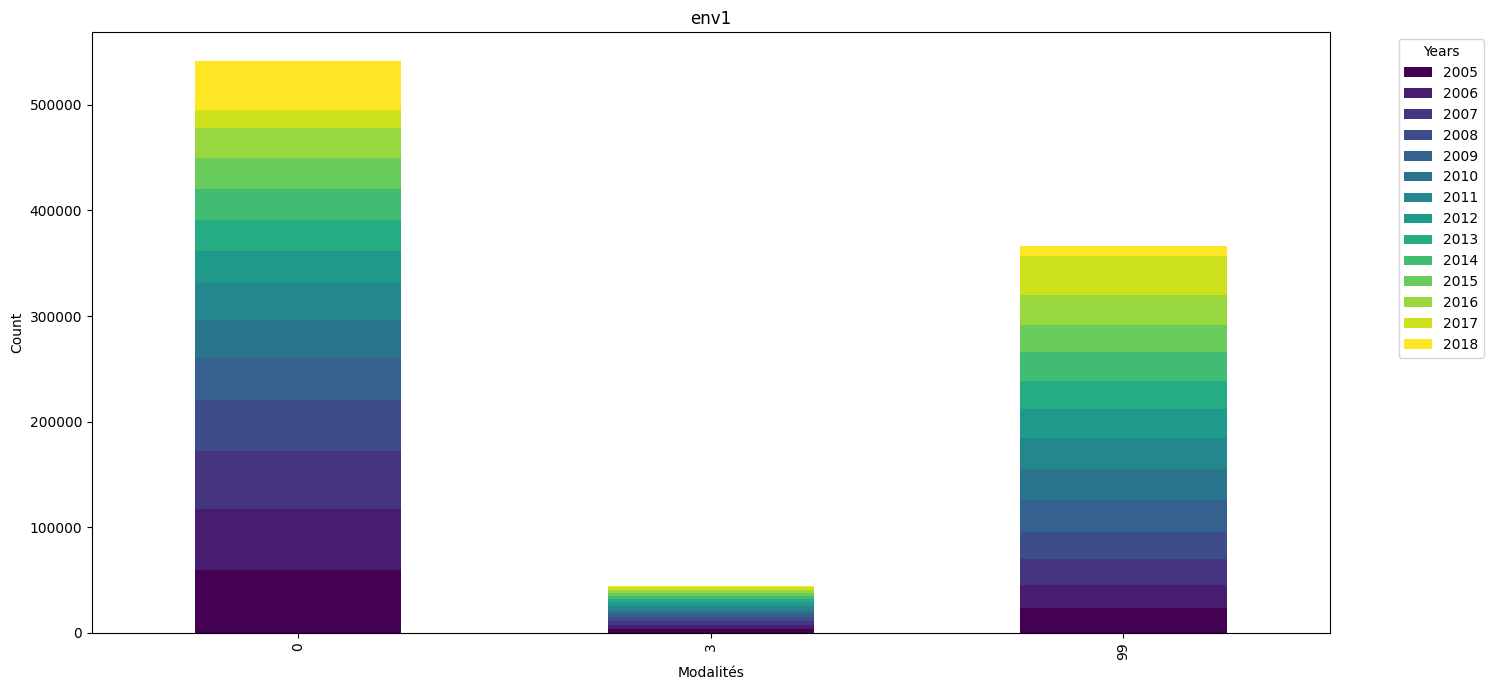

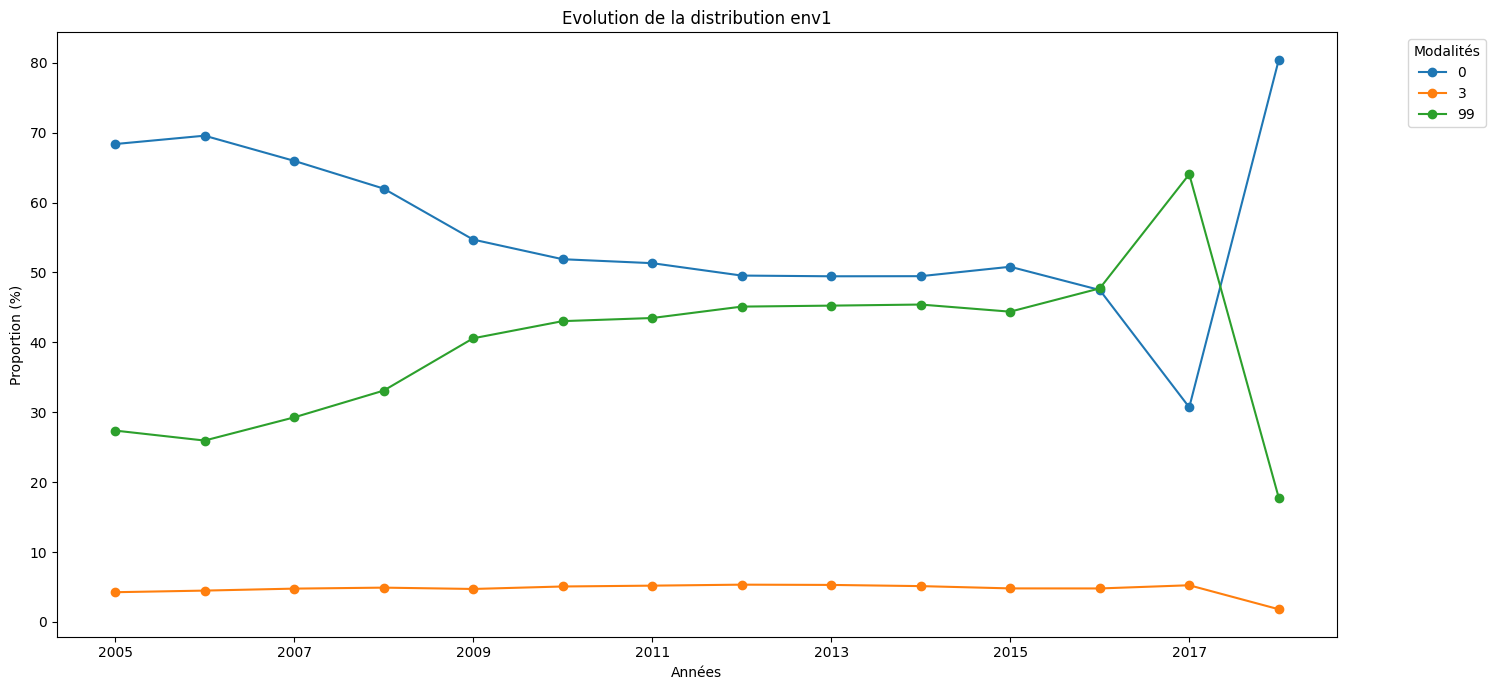

lignes: 1176873

Description: Aménagement - Infrastructure :

Modalités:
- -1: Non renseigné
- 0: Aucun
- 1: Souterrain - tunnel
- 2: Pont - autopont
- 3: Bretelle d’échangeur ou de raccordement
- 4: Voie ferrée
- 5: Carrefour aménagé
- 6: Zone piétonne
- 7: Zone de péage
- 8: Chantier
- 9: Autres
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                              0                                  0
   2006  int64         0                              0                                  0
   2007  int64         0                              0                                  0
   2008  int64         0                              0                                  0
   2009  float64       0                              0.225779                           0.000142751
   2010  float64       0          

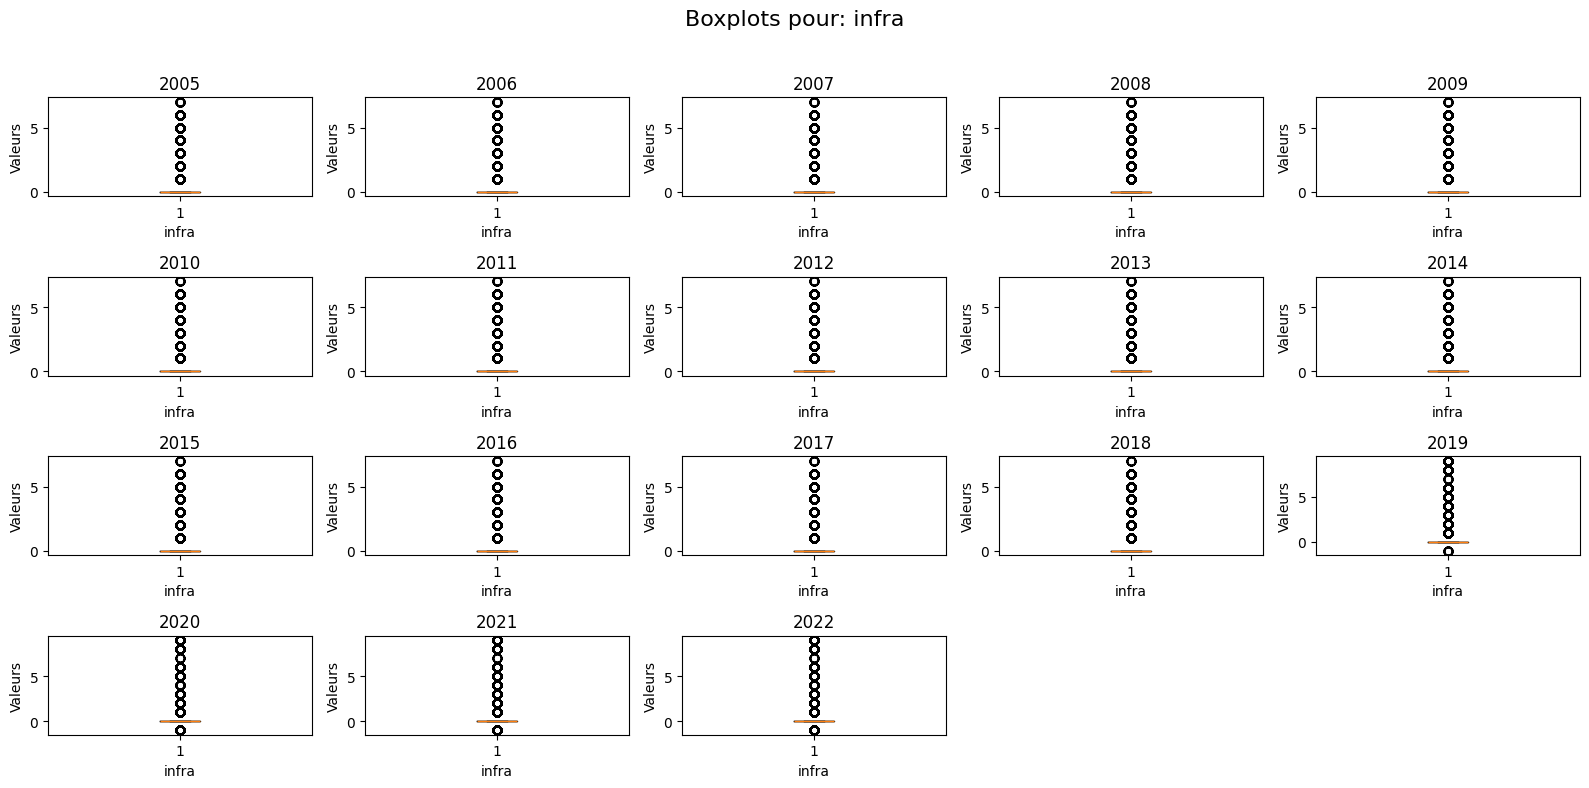

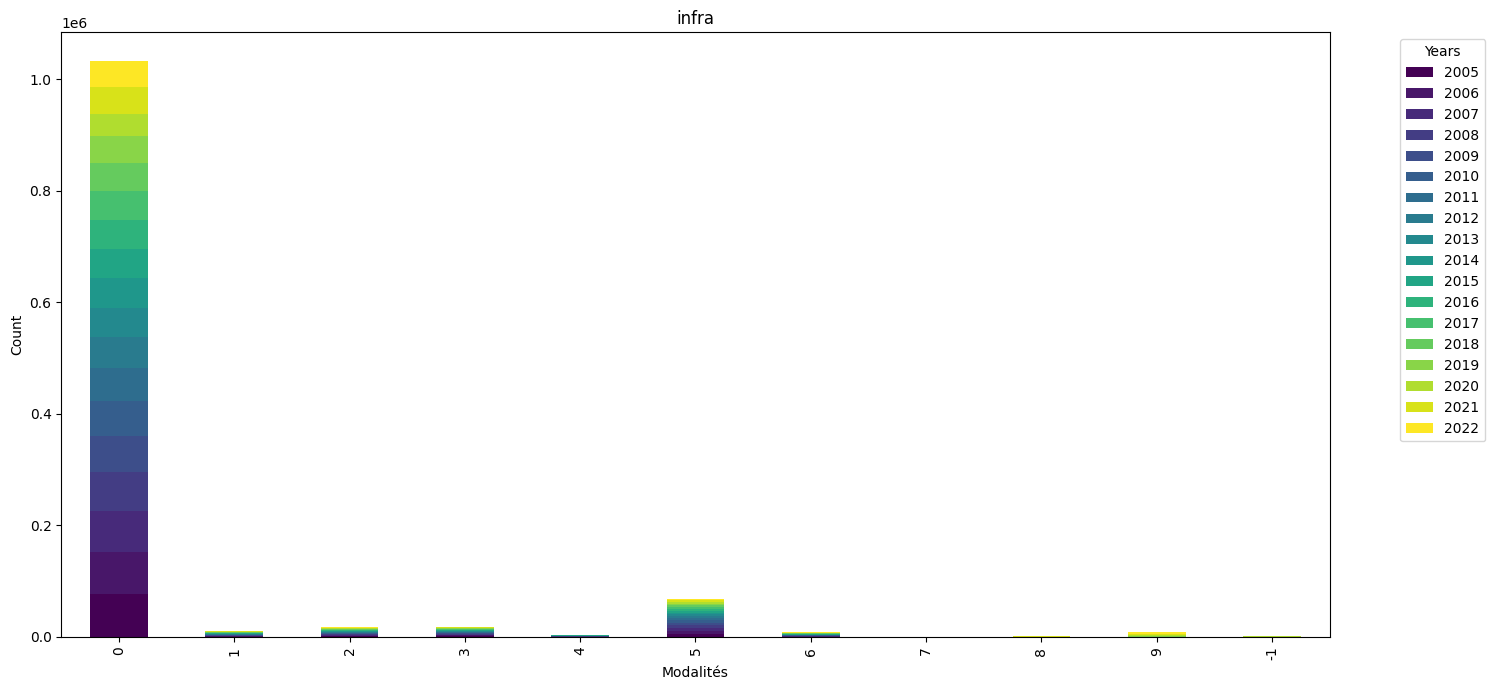

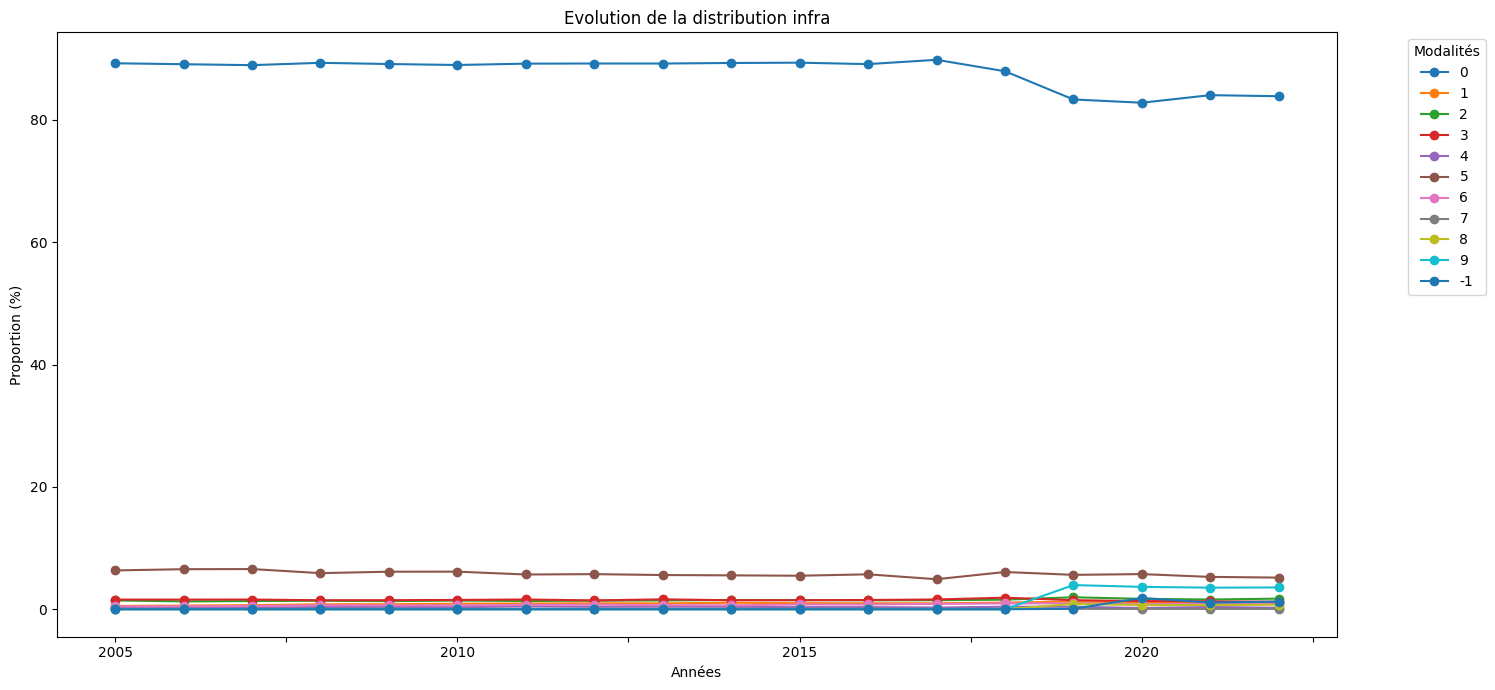

lignes: 1176873

Description: Largeur du terre-plein central (TPC) s'il existe (en m).
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                               0                                 0
   2006  int64         0                               0                                 0
   2007  int64         0                               0                                 0
   2008  int64         0                               0                                 0
   2009  float64       0                               0.725719                          0.000458843
   2010  float64       0                               0.671673                          0.000395965
   2011  float64       0                               1.03324                           0.000587999
   2012  float64       0                    

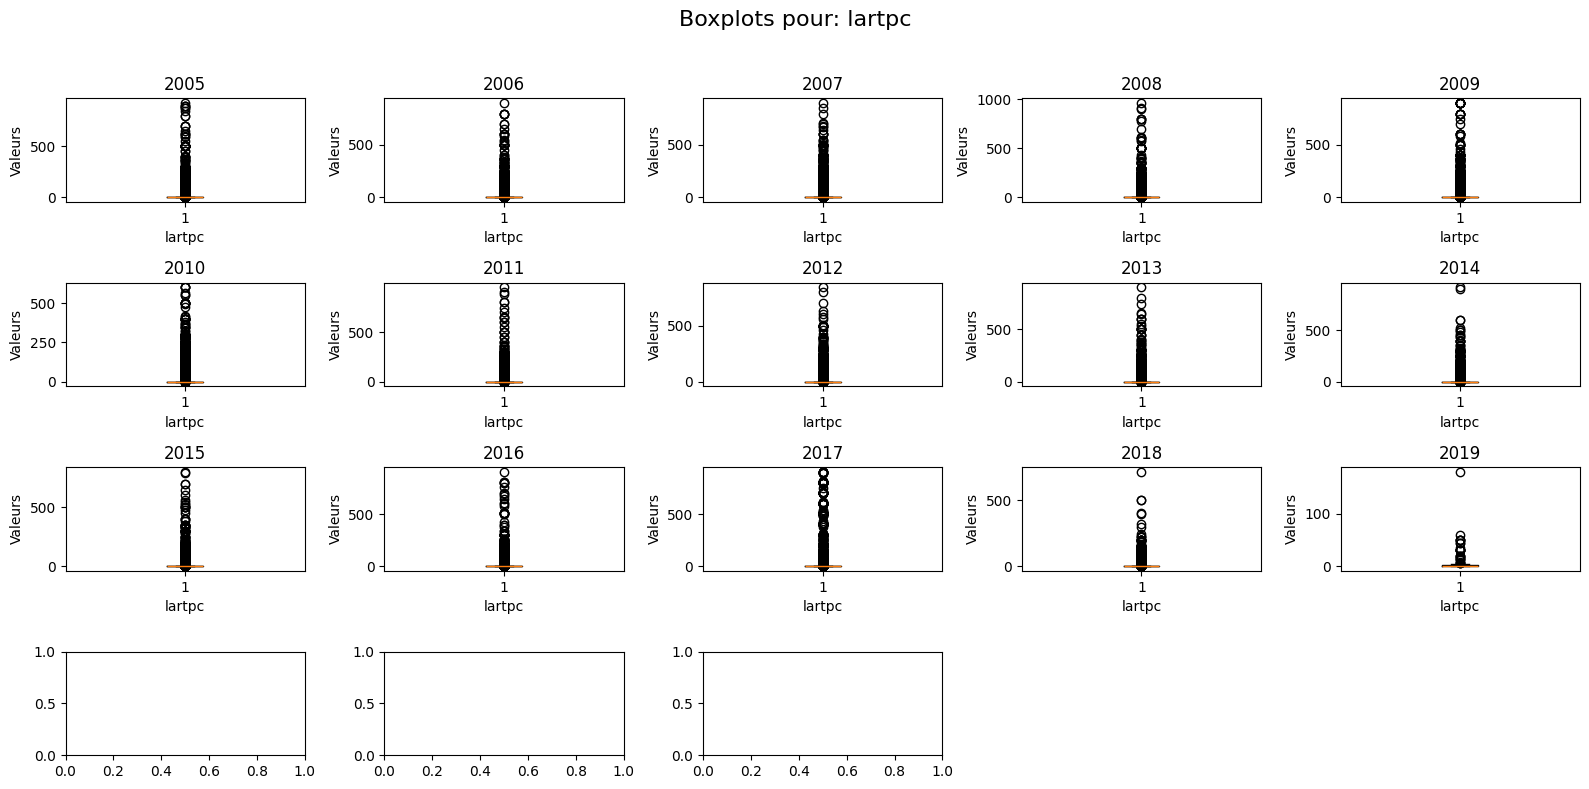

2024-06-12 13:26:02,948 - WARNING - Le nombre de modalités uniques dans la colonne lartpc excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:26:02,981 - WARNING - Le nombre de modalités uniques dans la colonne lartpc excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-12 13:26:02,983 - INFO - Chargement de usagers.


2024-06-12 13:26:03,105 - INFO - Pas de description pour `an_nais` dans la section `USAGERS`.


lignes: 2636377

  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  float64    1985                             0.347852                            0.000260585
   2006  float64    1986                             0.559639                            0.000397136
   2007  float64    1987                             0.163963                            0.000117206
   2008  float64    1989                             0.0298315                           1.93447e-05
   2009  float64    1988                             0.00843567                          5.31032e-06
   2010  float64    1989                             0.0343727                           2.01033e-05
   2011  float64    1990                             0.0444316                           2.50344e-05
   2012  float64    1990                             0.00721355           

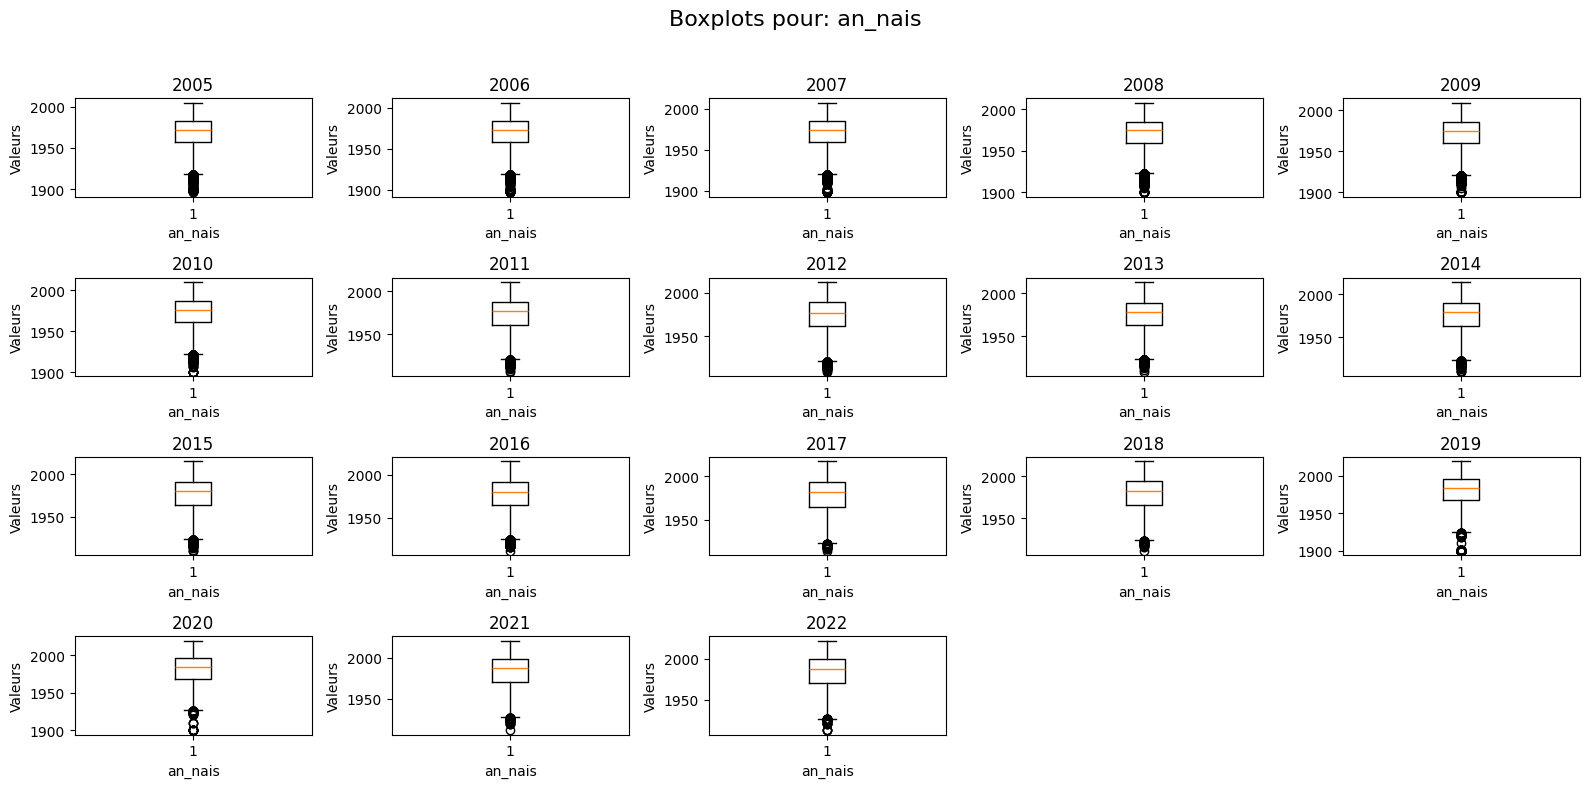

2024-06-12 13:26:05,505 - WARNING - Le nombre de modalités uniques dans la colonne an_nais excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:26:05,569 - WARNING - Le nombre de modalités uniques dans la colonne an_nais excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-12 13:26:05,963 - INFO - La colonne num_veh n'est pas numérique.
2024-06-12 13:26:06,139 - WARNING - Le nombre de modalités uniques dans la colonne num_veh excède le seuil de 50. Auncun bar plot généré.


lignes: 2636377

Description: Identifiant du véhicule repris pour chacun des usagers occupant ce véhicule – Code alphanumérique.
  Année  Type    Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  object  A01                                         0                                    0
   2006  object  A01                                         0                                    0
   2007  object  A01                                         0                                    0
   2008  object  A01                                         0                                    0
   2009  object  A01                                         0                                    0
   2010  object  A01                                         0                                    0
   2011  object  A01                                         0         

2024-06-12 13:26:06,265 - WARNING - Le nombre de modalités uniques dans la colonne num_veh excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 2636377

Description: Sexe de l'usager :

Modalités:
- 1: Masculin
- 2: Féminin
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        1                                      0                                    0
   2006  int64        1                                      0                                    0
   2007  int64        1                                      0                                    0
   2008  int64        1                                      0                                    0
   2009  int64        1                                      0                                    0
   2010  int64        1                                      0                                    0
   2011  int64        1                                      0                                    0
   2012  int

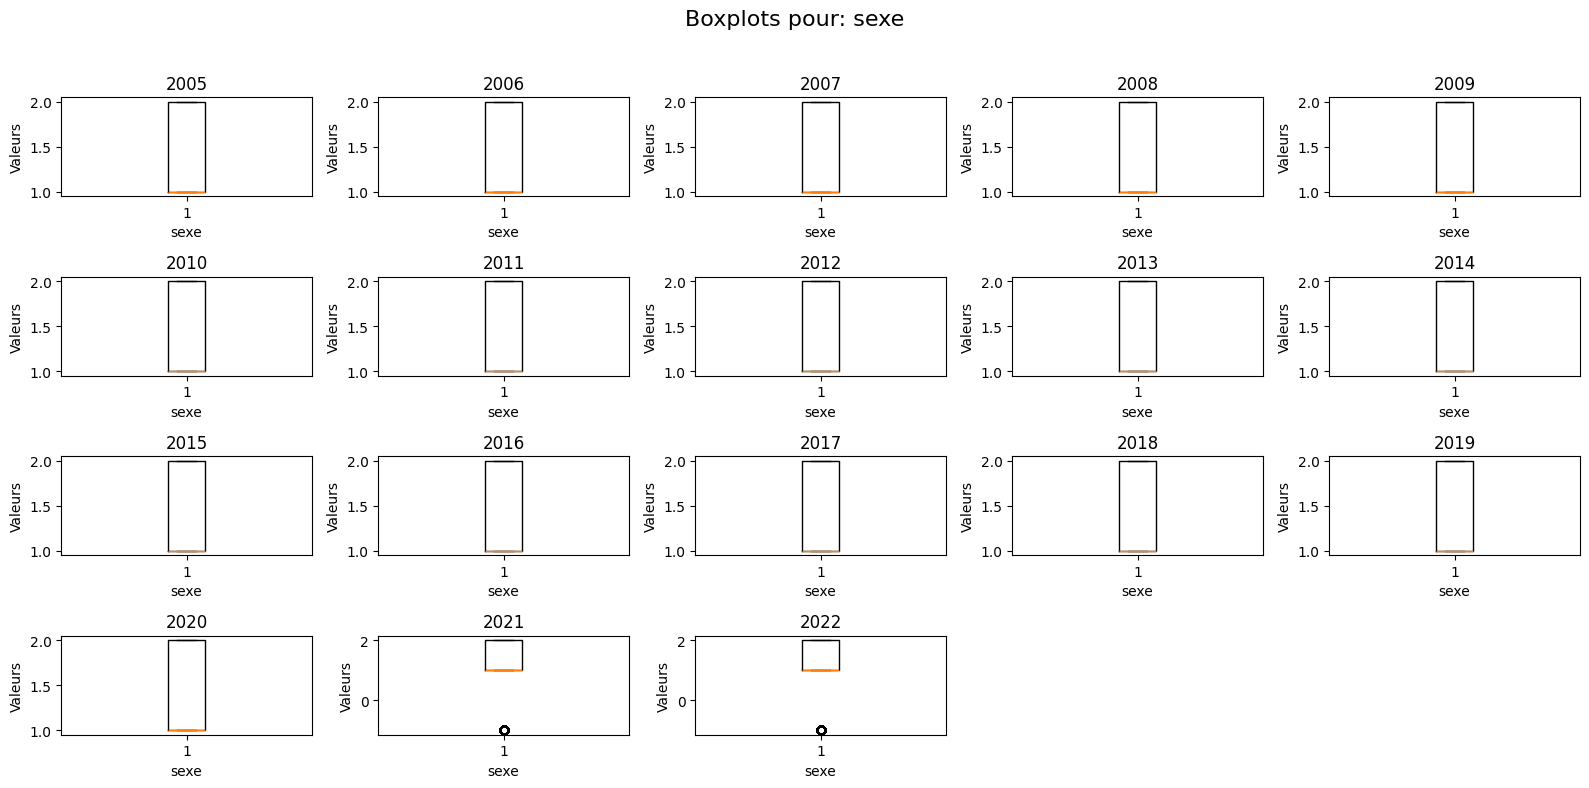

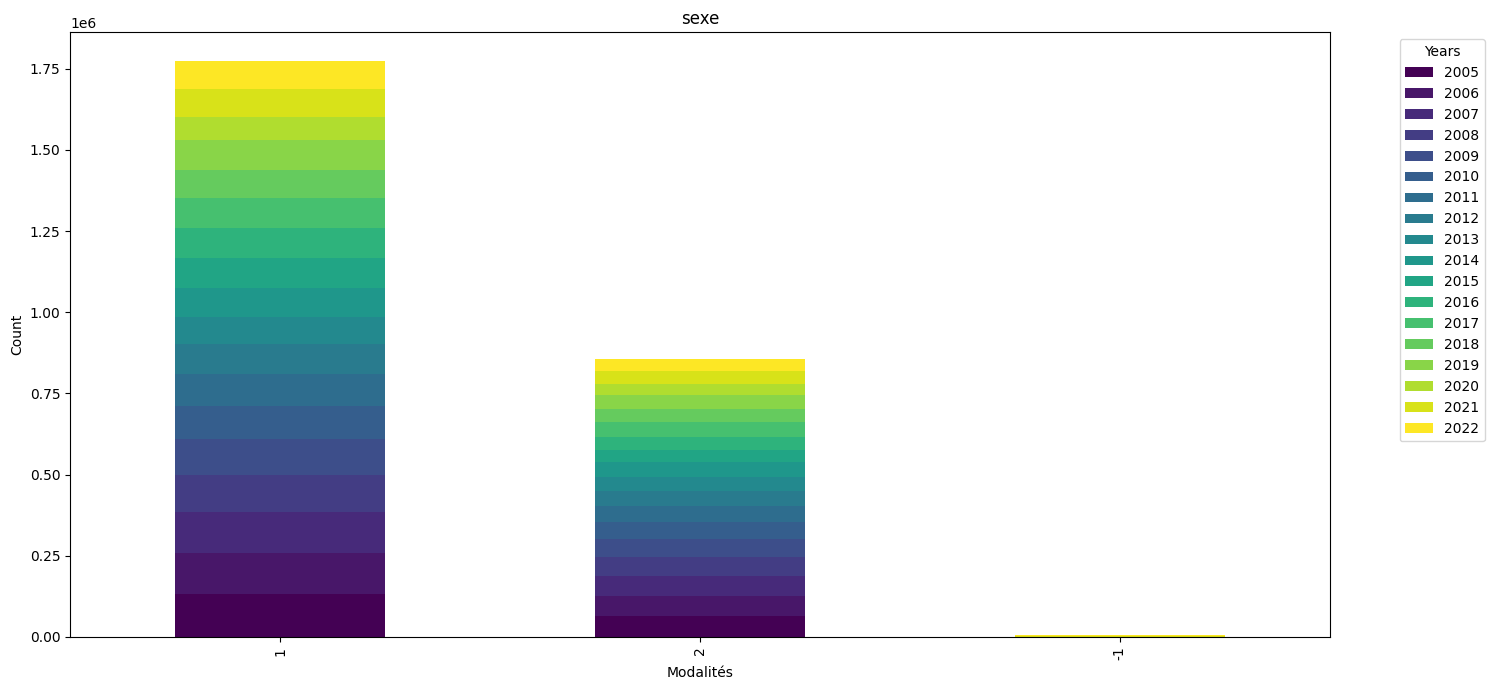

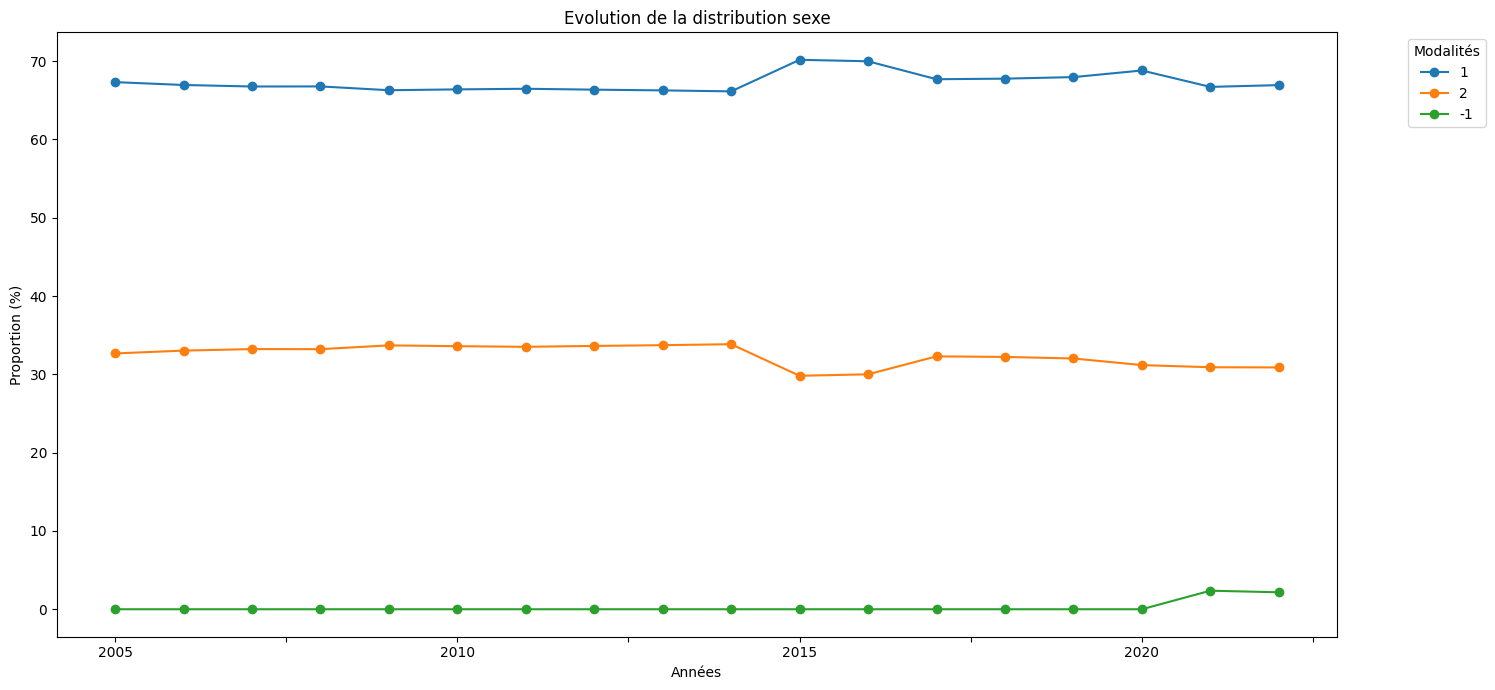

lignes: 2636377

Description: Catégorie d'usager :

Modalités:
- 1: Conducteur
- 2: Passager
- 3: Piéton
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        1                                      0                                    0
   2006  int64        1                                      0                                    0
   2007  int64        1                                      0                                    0
   2008  int64        1                                      0                                    0
   2009  int64        1                                      0                                    0
   2010  int64        1                                      0                                    0
   2011  int64        1                                      0                                 

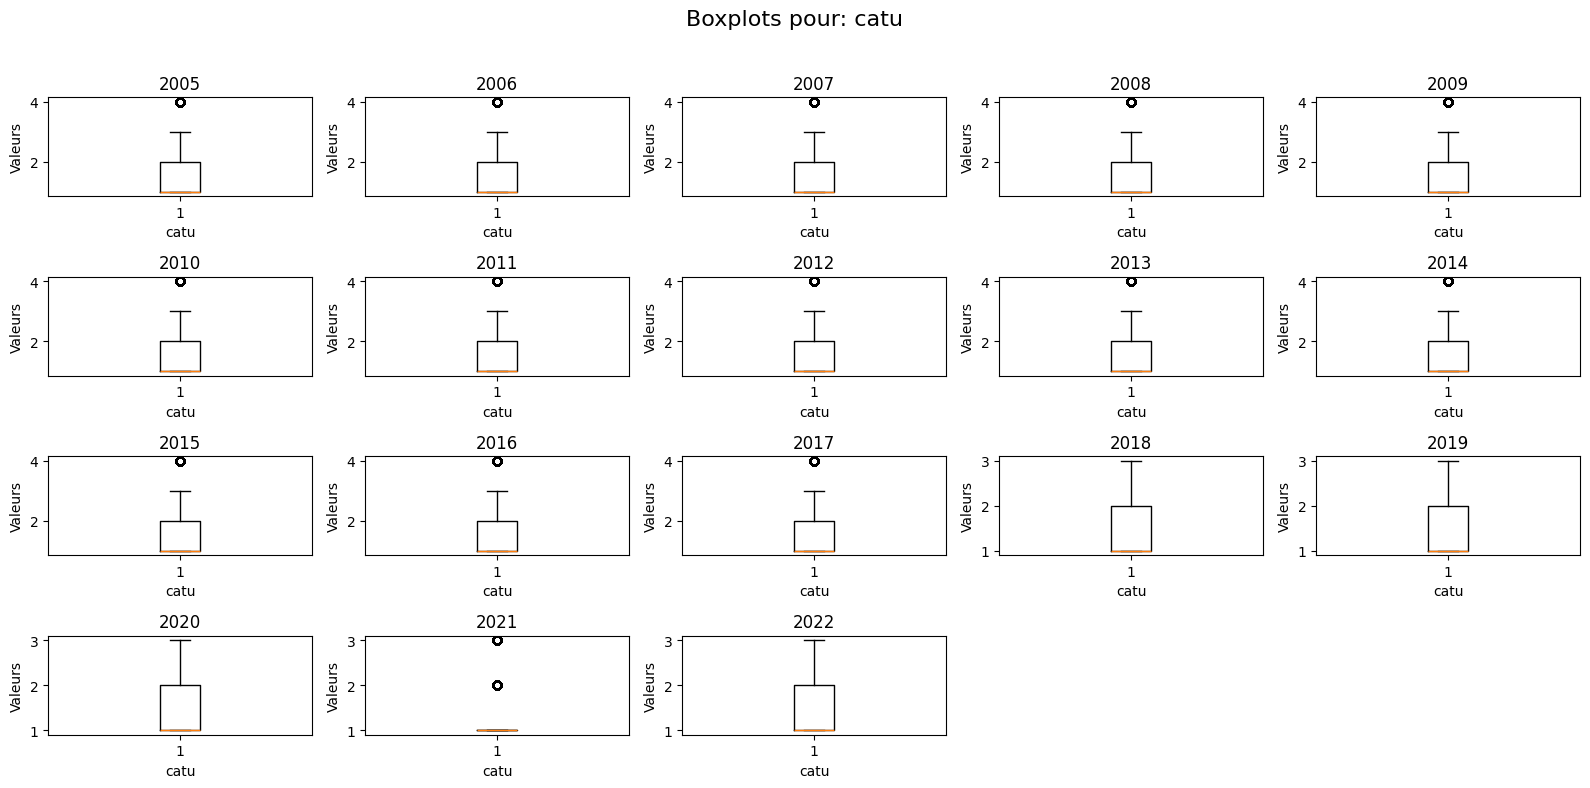

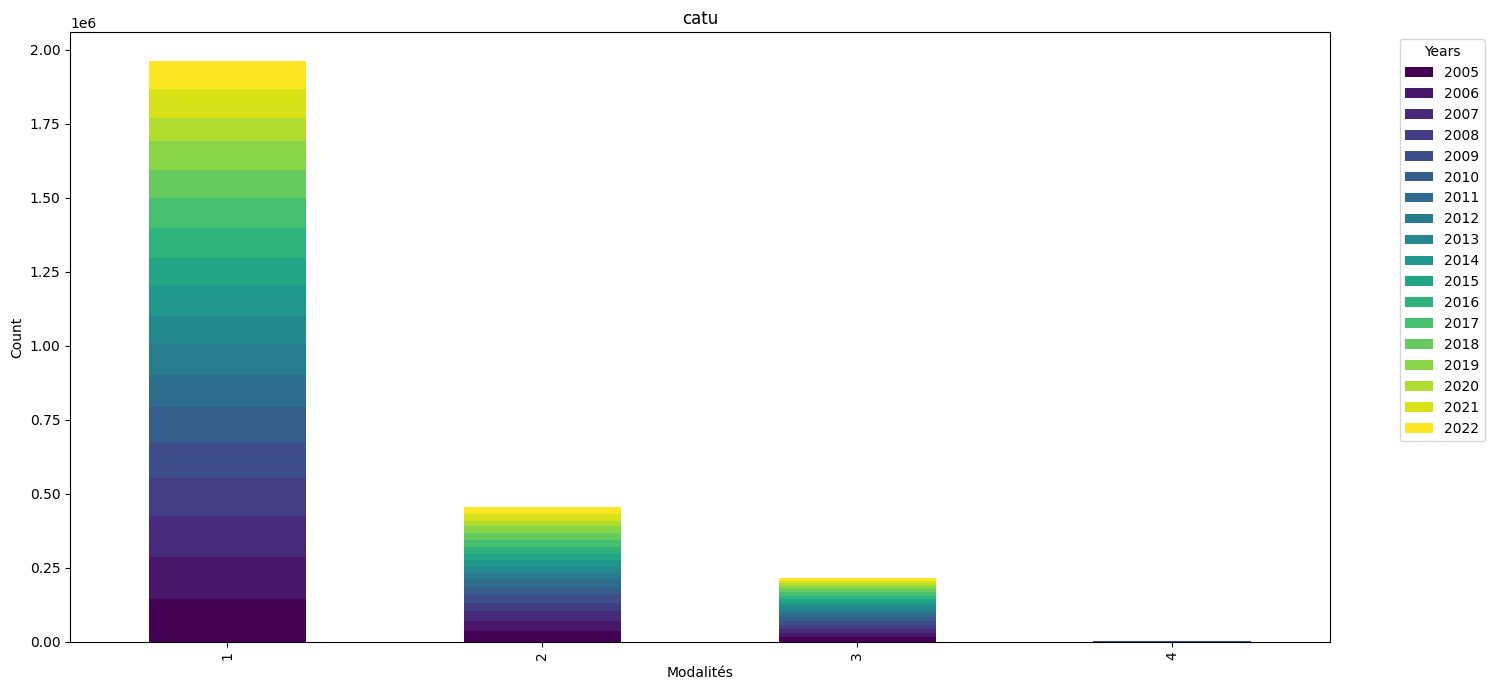

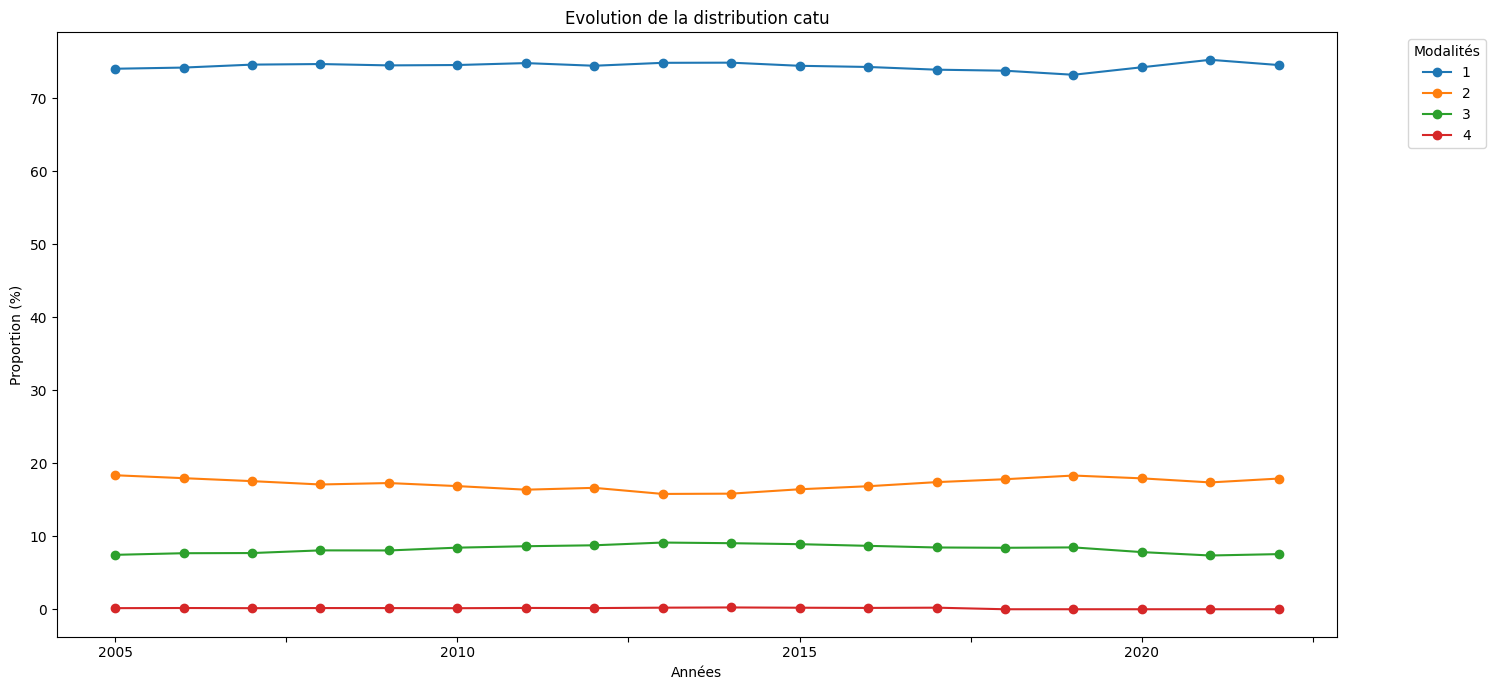

lignes: 2636377

Description: Le renseignement du caractère indique la présence et l’utilisation de l’équipement de sécurité :

Modalités:
- -1: Non renseigné
- 0: Aucun équipement
- 1: Ceinture
- 2: Casque
- 3: Dispositif enfants
- 4: Gilet réfléchissant
- 5: Airbag (2RM/3RM)
- 6: Gants (2RM/3RM)
- 7: Gants + Airbag (2RM/3RM)
- 8: Non déterminable
- 9: Autre
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2019  int64        0                                      0                                    0
   2020  int64        0                                      0                                    0
   2021  int64       -1                                      0                                    0
   2022  int64       -1                                      0                                    0


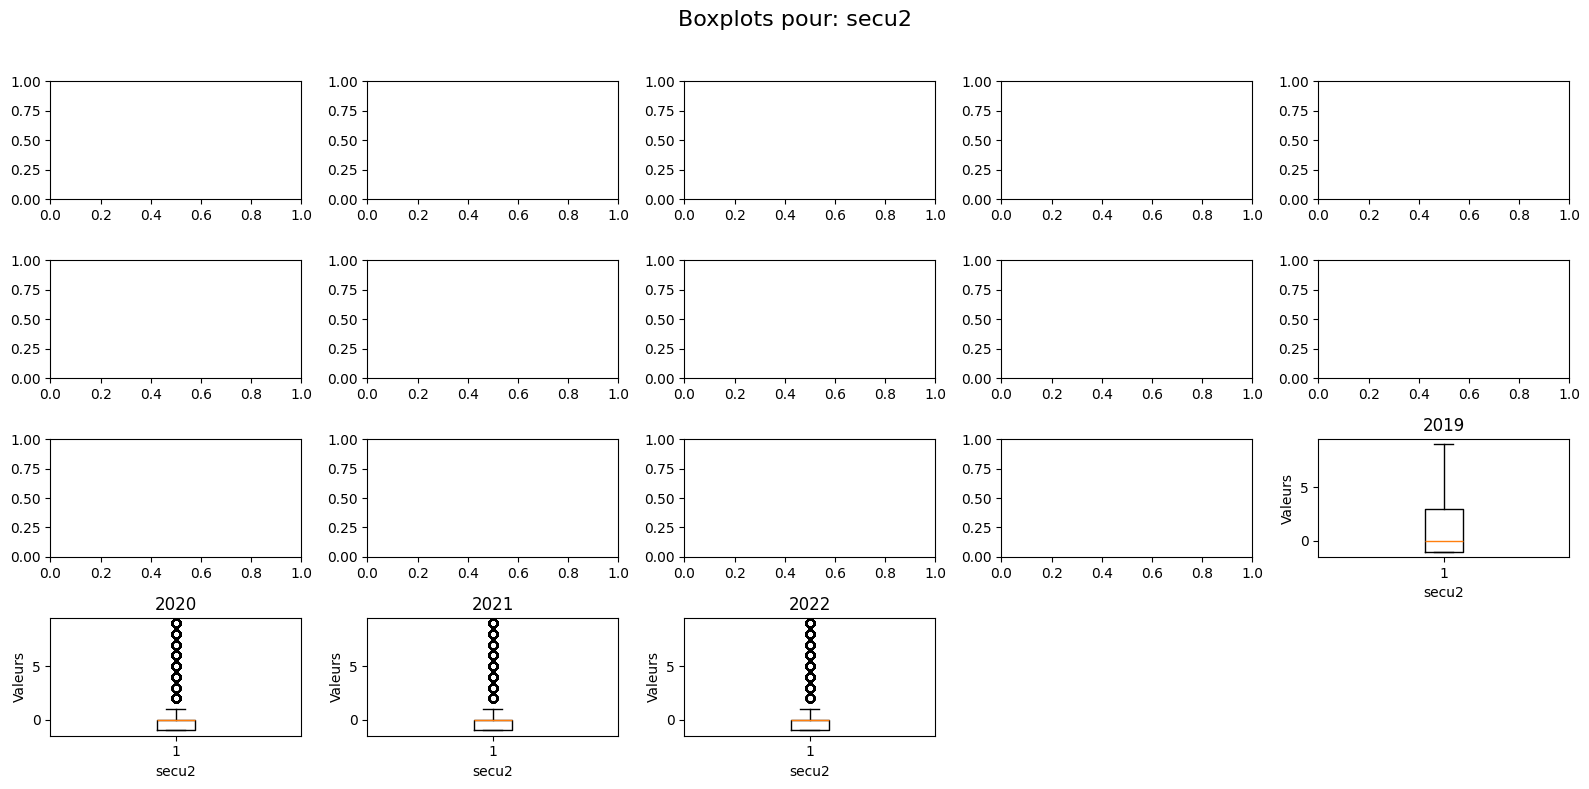

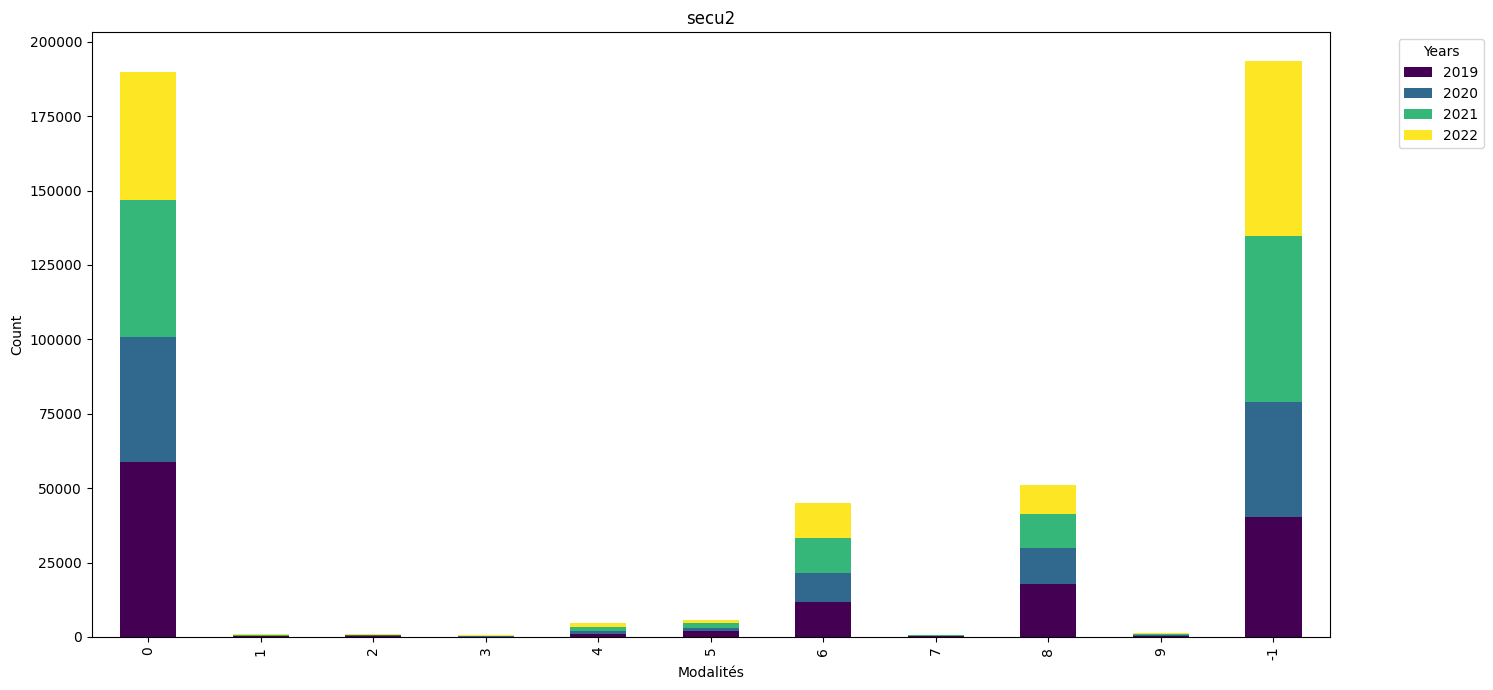

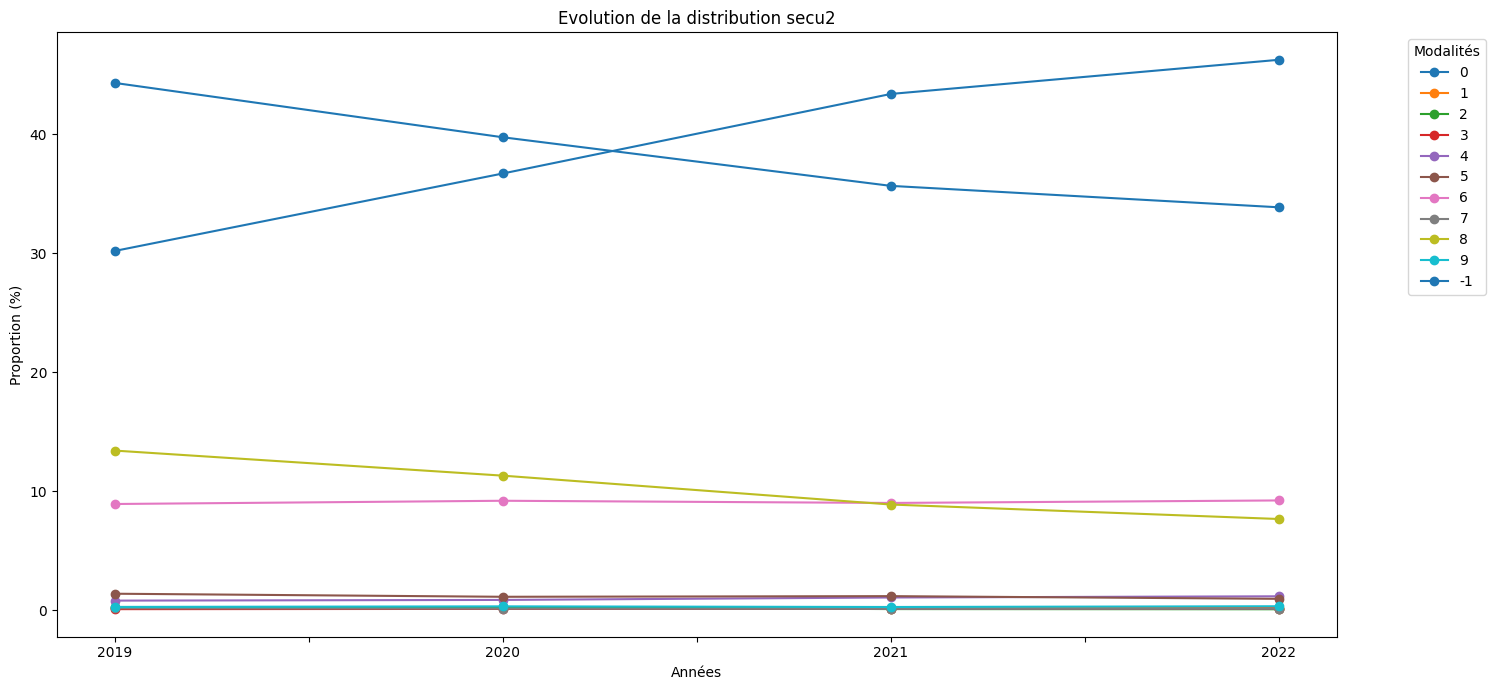

2024-06-12 13:26:18,829 - INFO - La colonne id_usager n'est pas numérique.


lignes: 2636377

Description: Identifiant unique de l’usager – Code numérique.
  Année  Type    Mode         Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2021  object  133 818                                        0                                    0
   2022  object  1 000 001                                      0                                    0


2024-06-12 13:26:19,312 - WARNING - Le nombre de modalités uniques dans la colonne id_usager excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:26:19,650 - WARNING - Le nombre de modalités uniques dans la colonne id_usager excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 2636377

Description: Identifiant de l’accident identique à celui du fichier "rubrique CARACTERISTIQUES" repris pour chacun des usagers décrits impliqués dans l’accident.
  Année  Type         Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2005  int64   2.005e+11                                      0                                    0
   2006  int64   2.006e+11                                      0                                    0
   2007  int64   2.007e+11                                      0                                    0
   2008  int64   2.008e+11                                      0                                    0
   2009  int64   2.009e+11                                      0                                    0
   2010  int64   2.01e+11                                       0                                   

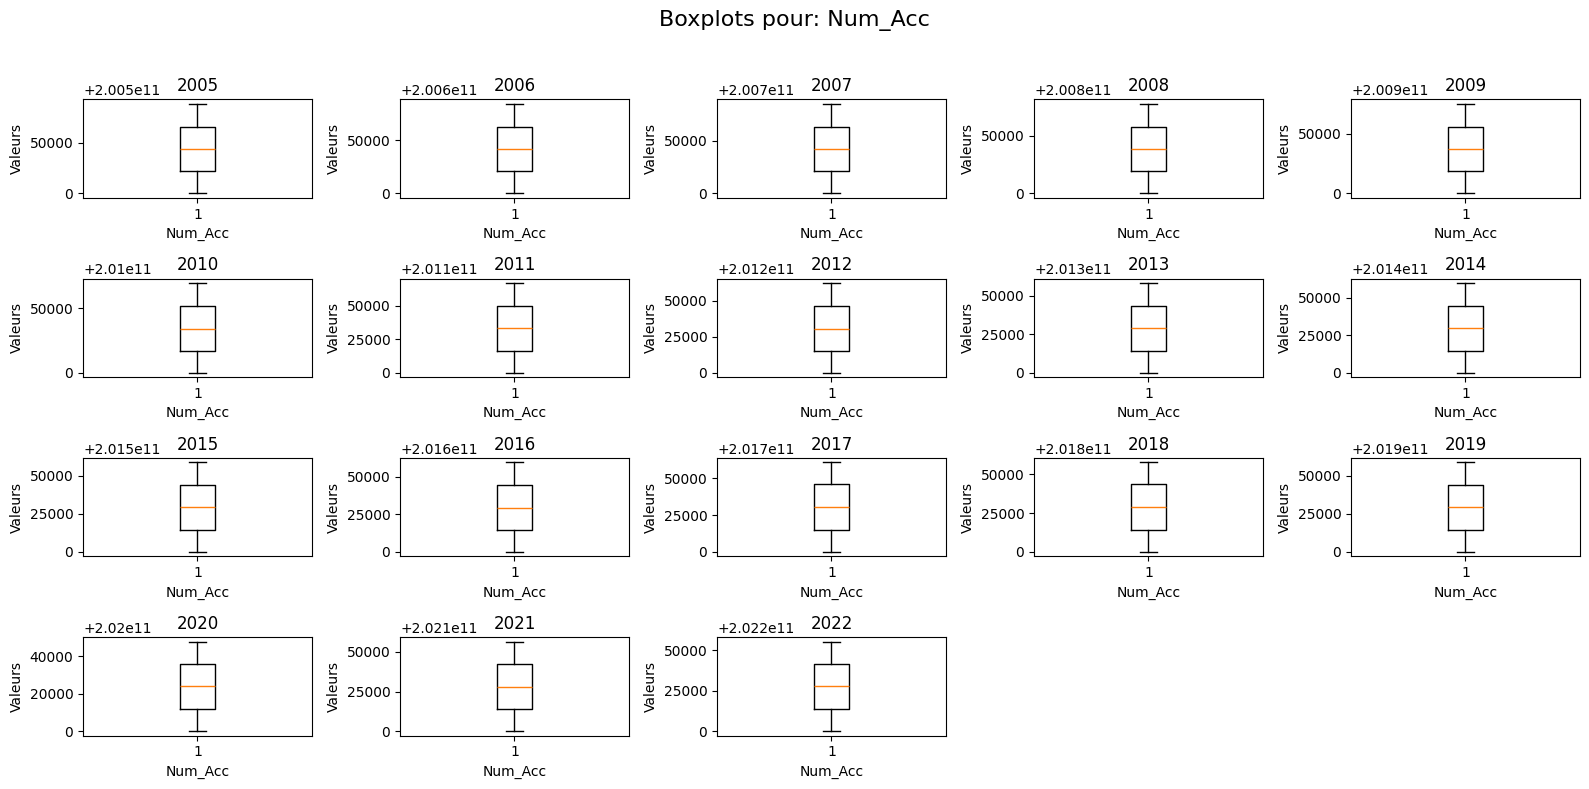

2024-06-12 13:26:25,358 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:26:25,888 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 2636377

Description: Le renseignement du caractère indique la présence et l’utilisation de l’équipement de sécurité :

Modalités:
- -1: Non renseigné
- 0: Aucun équipement
- 1: Ceinture
- 2: Casque
- 3: Dispositif enfants
- 4: Gilet réfléchissant
- 5: Airbag (2RM/3RM)
- 6: Gants (2RM/3RM)
- 7: Gants + Airbag (2RM/3RM)
- 8: Non déterminable
- 9: Autre
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2019  int64       -1                                      0                                    0
   2020  int64       -1                                      0                                    0
   2021  int64       -1                                      0                                    0
   2022  int64       -1                                      0                                    0


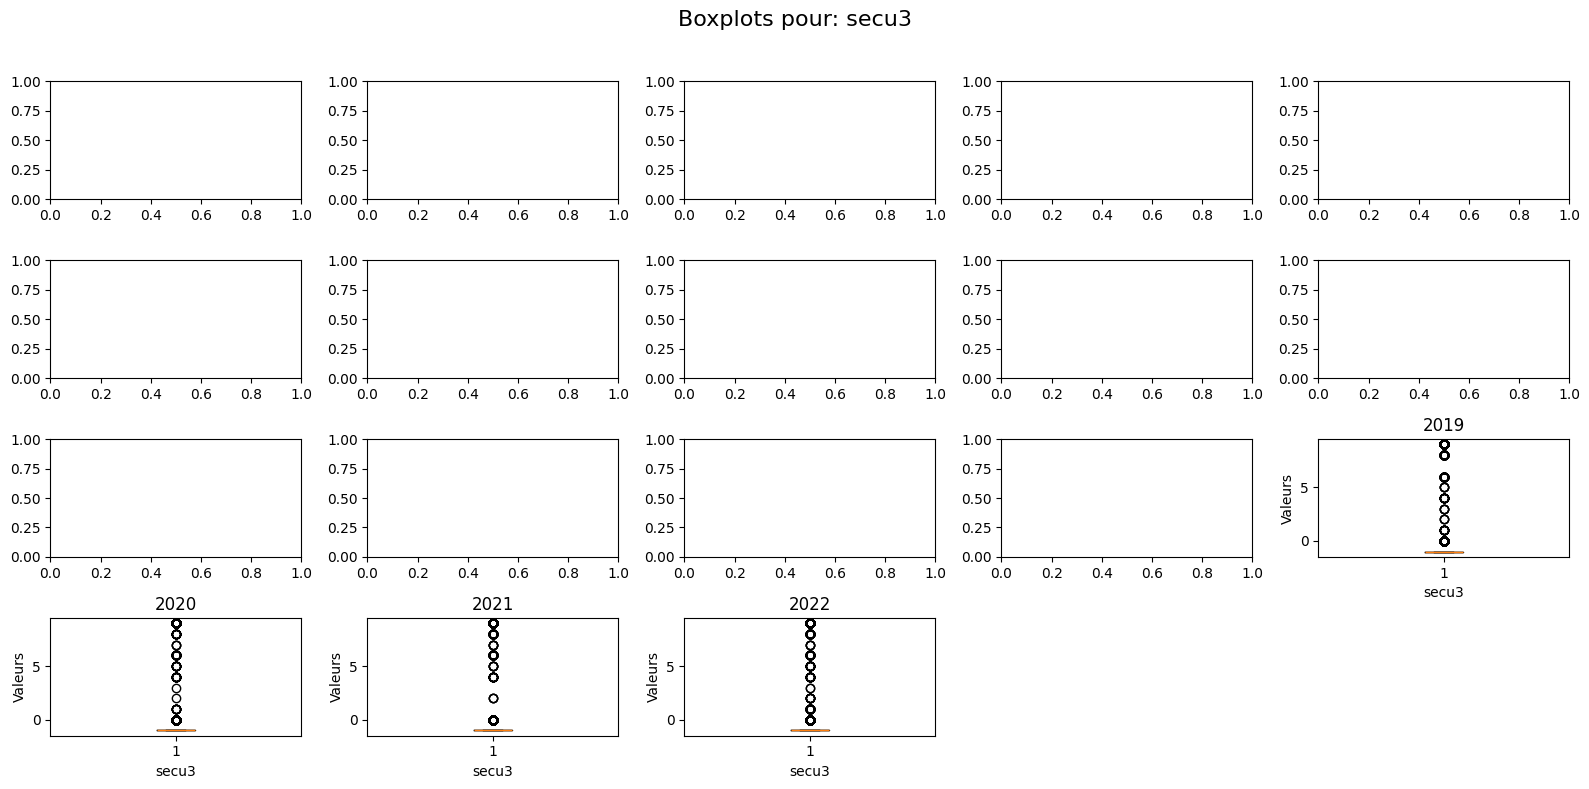

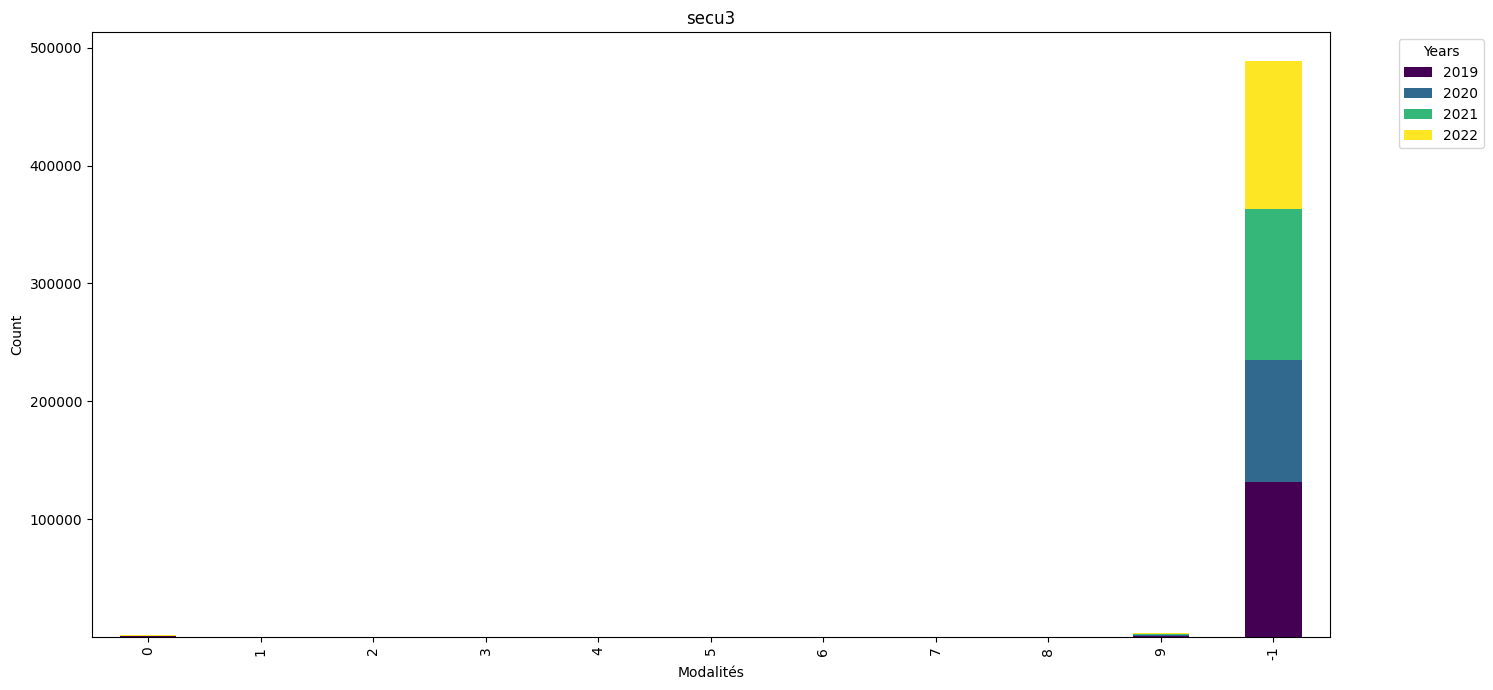

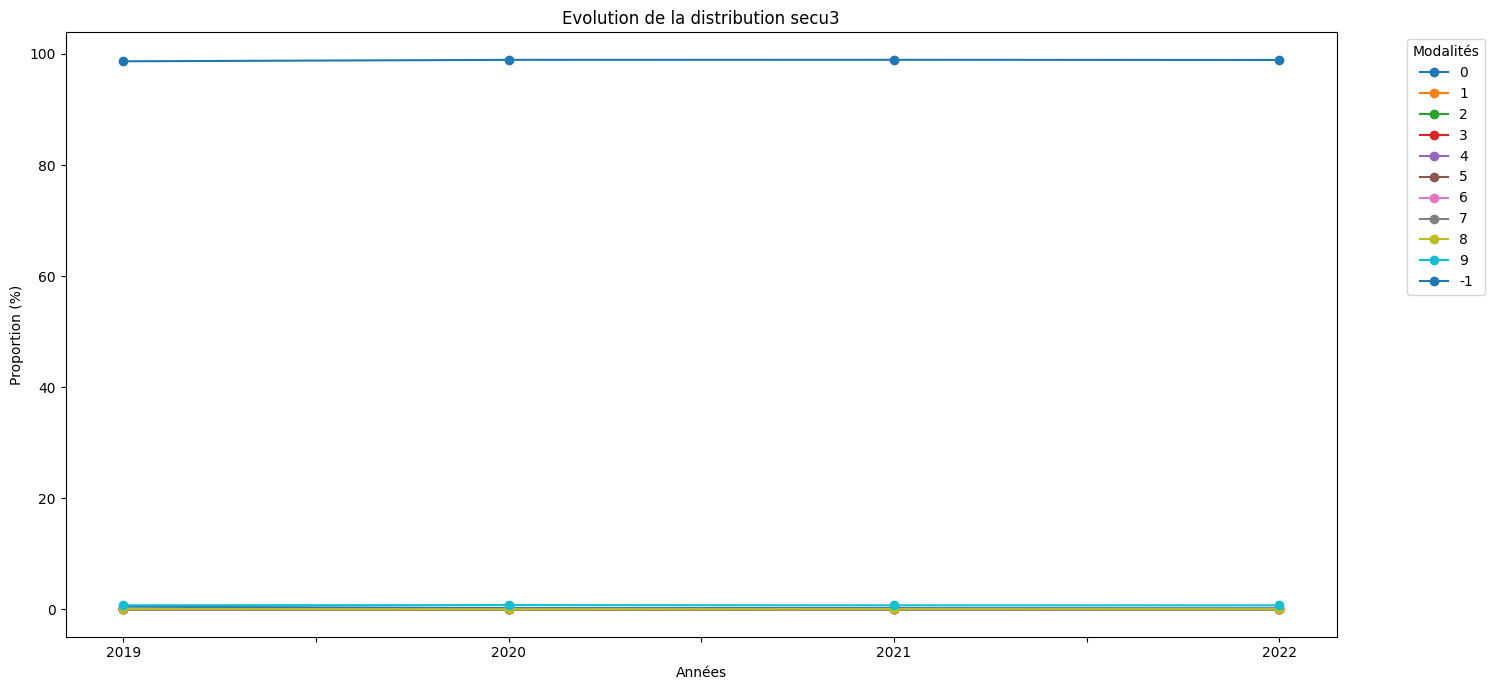

2024-06-12 13:26:30,376 - INFO - Pas de description pour `secu` dans la section `USAGERS`.


lignes: 2636377

  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64        11                            0                                    0
   2006  float64      11                            0.000534516                          3.79308e-07
   2007  int64        11                            0                                    0
   2008  int64        11                            0                                    0
   2009  float64      11                            3.01816                              0.00189996
   2010  float64      11                            2.71804                              0.00158968
   2011  float64      11                            3.02808                              0.00170613
   2012  float64      11                            3.05205                              0.00160485
   2013

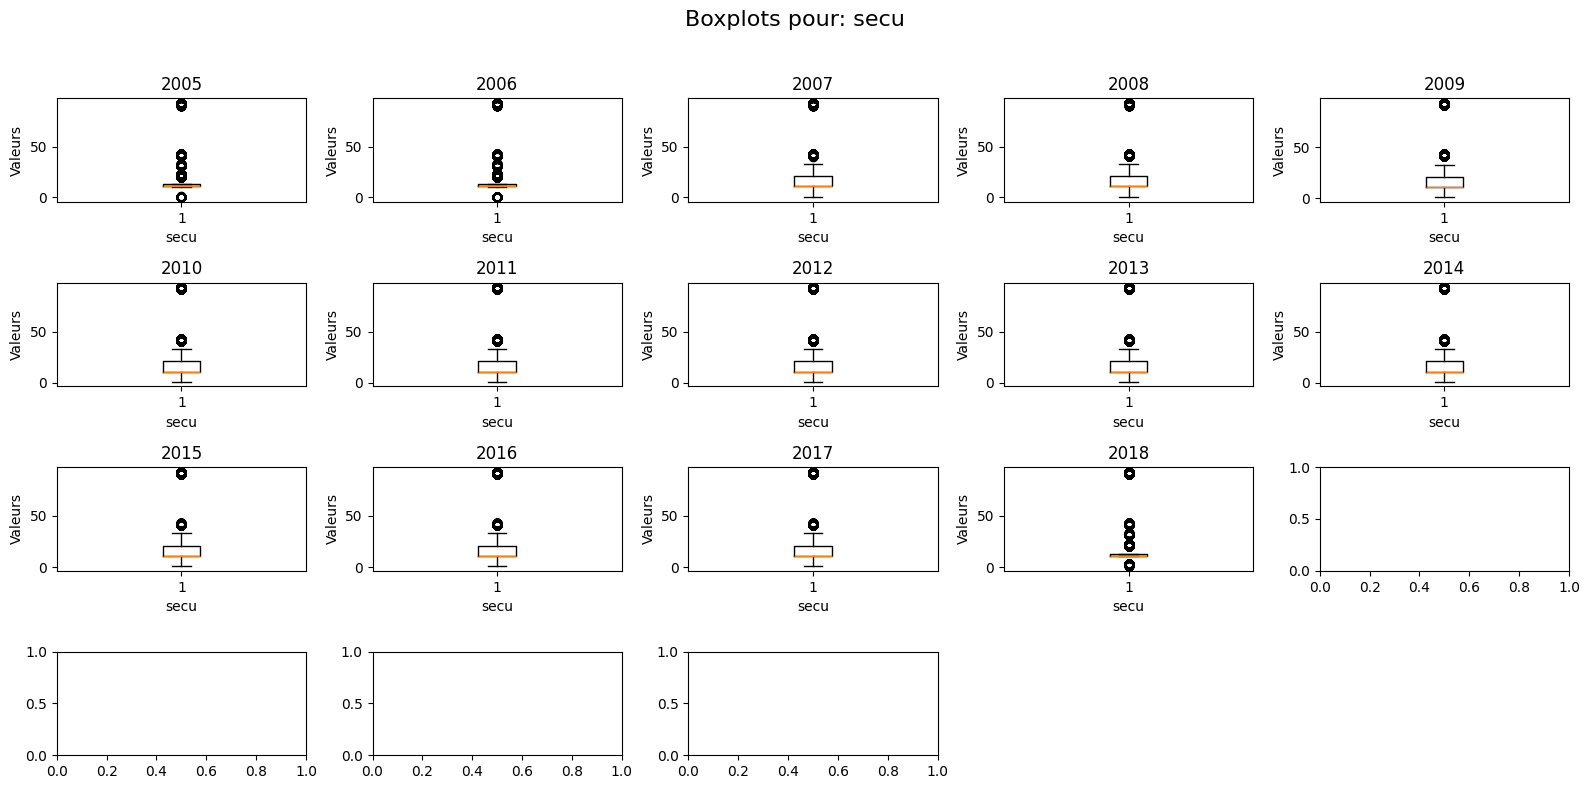

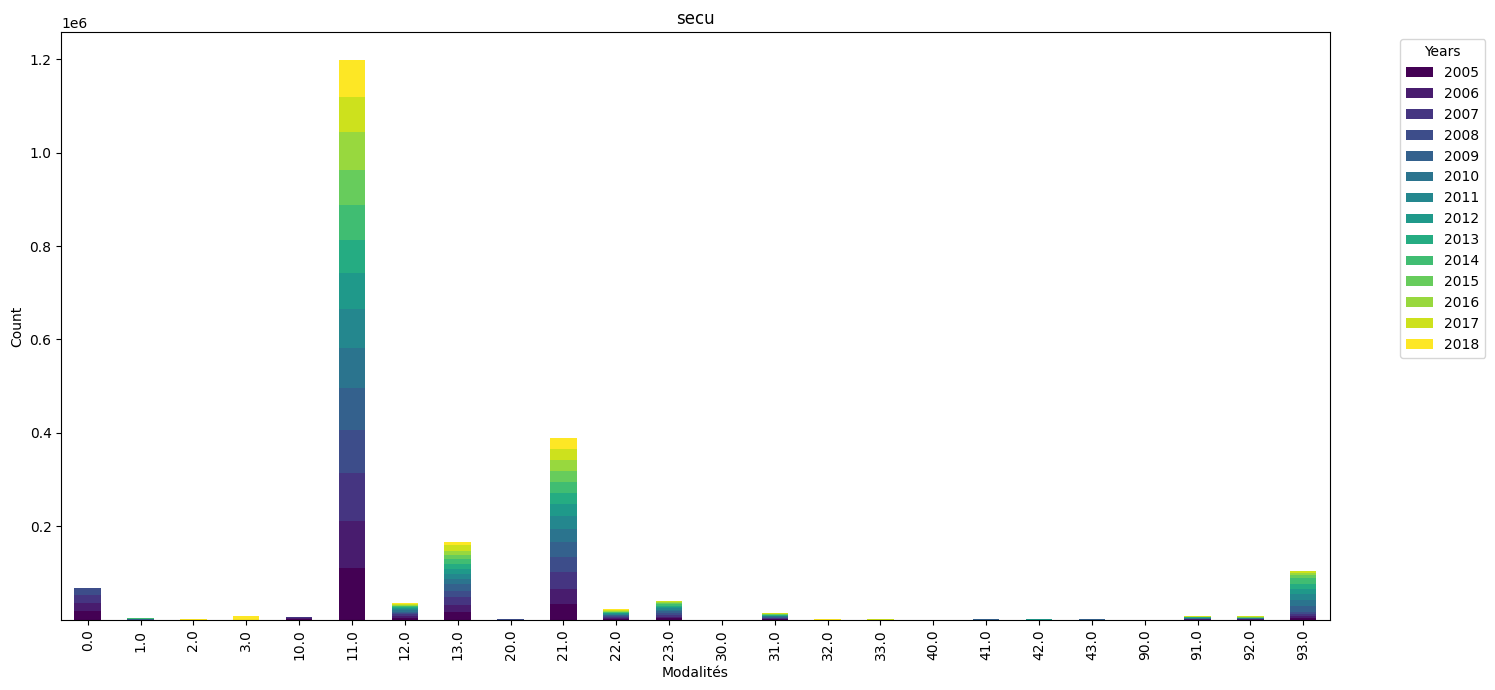

2024-06-12 13:26:33,645 - WARNING - Le nombre de modalités uniques dans la colonne secu excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 2636377

Description: Permet de situer la place occupée dans le véhicule par l'usager au moment de l'accident.
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                                0                                 0
   2006  int64         1                                0                                 0
   2007  int64         1                                0                                 0
   2008  int64         1                                0                                 0
   2009  float64       1                                8.21393                           0.00517073
   2010  float64       1                                8.58151                           0.00501901
   2011  float64       1                                8.81024                           0.00496401
   2012 

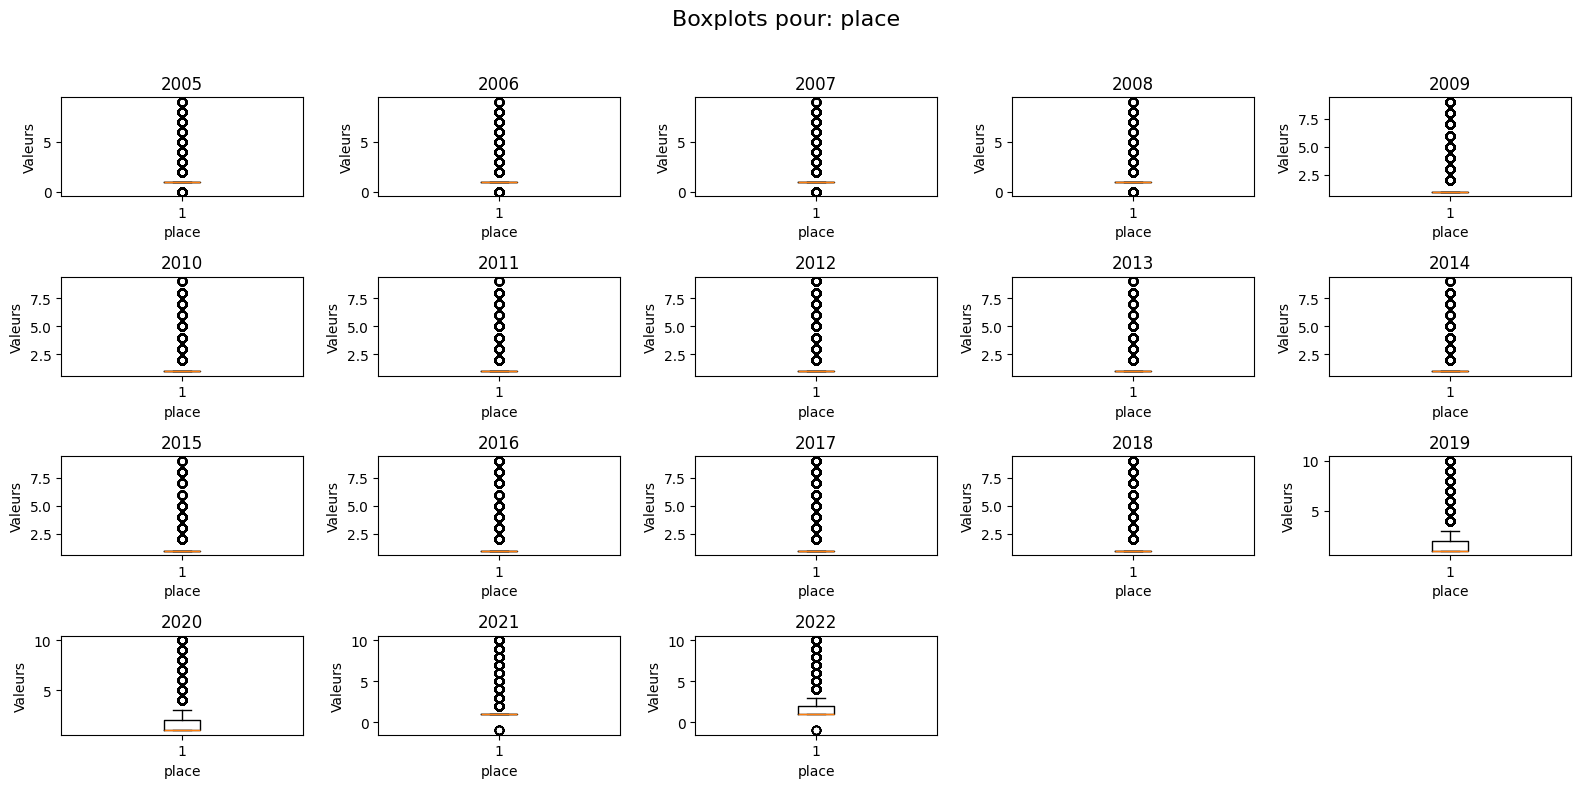

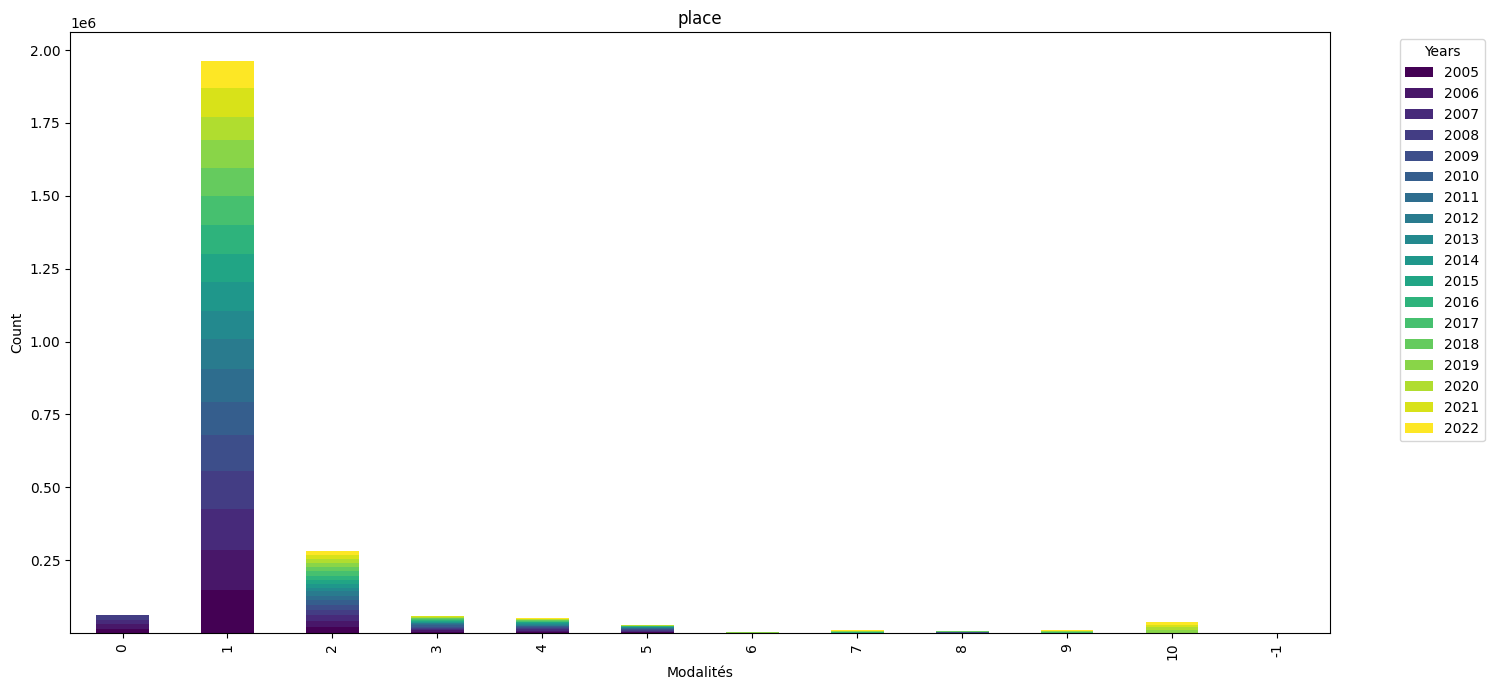

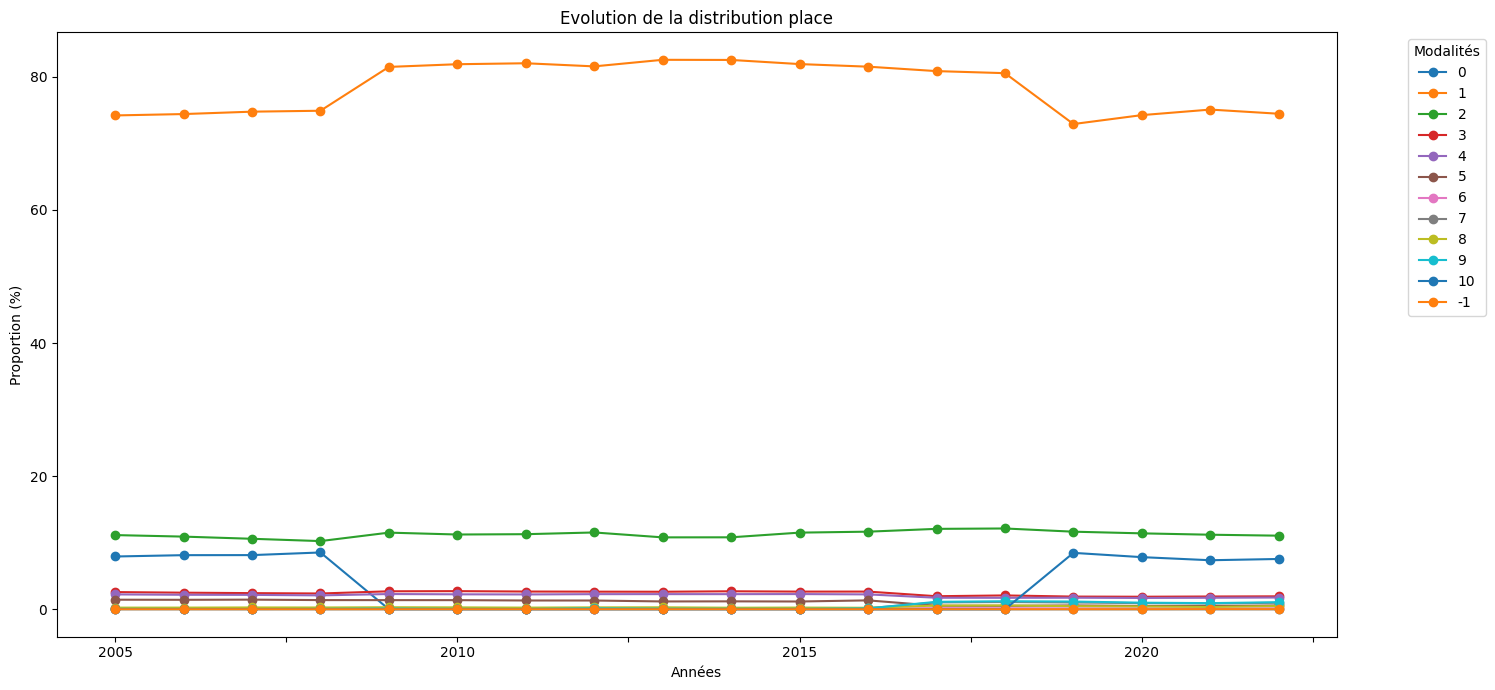

lignes: 2636377

Description: Motif du déplacement au moment de l’accident :

Modalités:
- -1: Non renseigné
- 0: Non renseigné
- 1: Domicile – travail
- 2: Domicile – école
- 3: Courses – achats
- 4: Utilisation professionnelle
- 5: Promenade – loisirs
- 9: Autre
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         5                             0                                   0
   2006  int64         5                             0                                   0
   2007  int64         0                             0                                   0
   2008  int64         0                             0                                   0
   2009  float64       5                             0.0584471                           3.67929e-05
   2010  float64       5                             0.0447494      

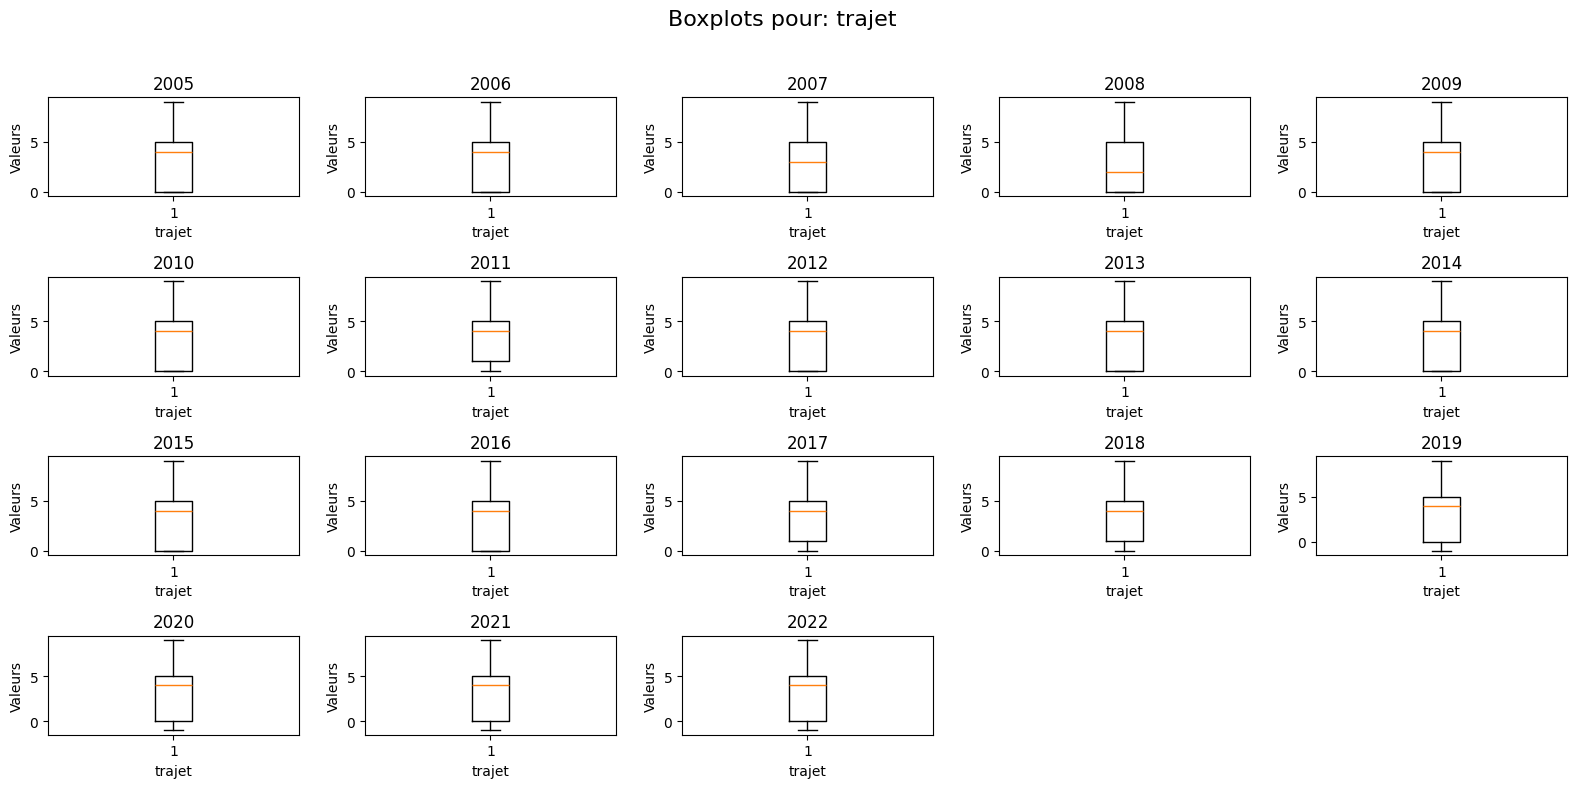

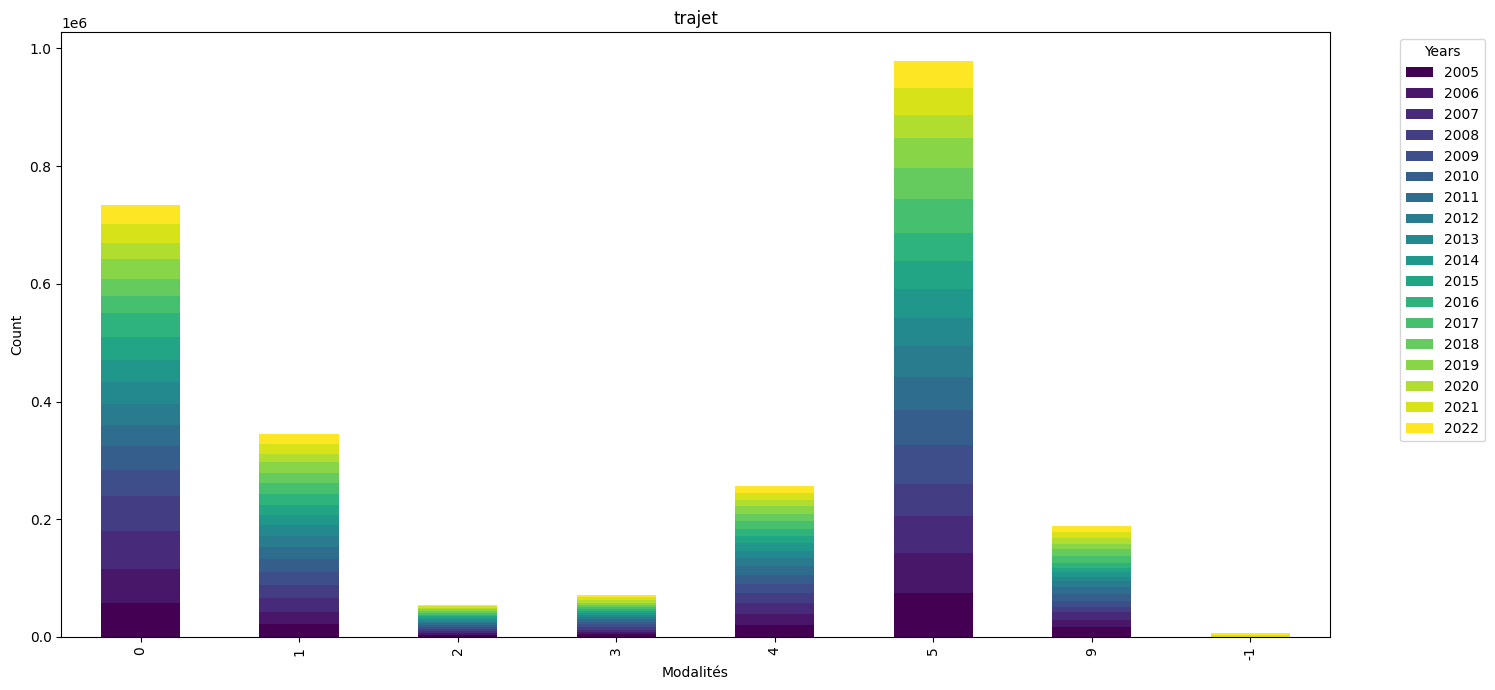

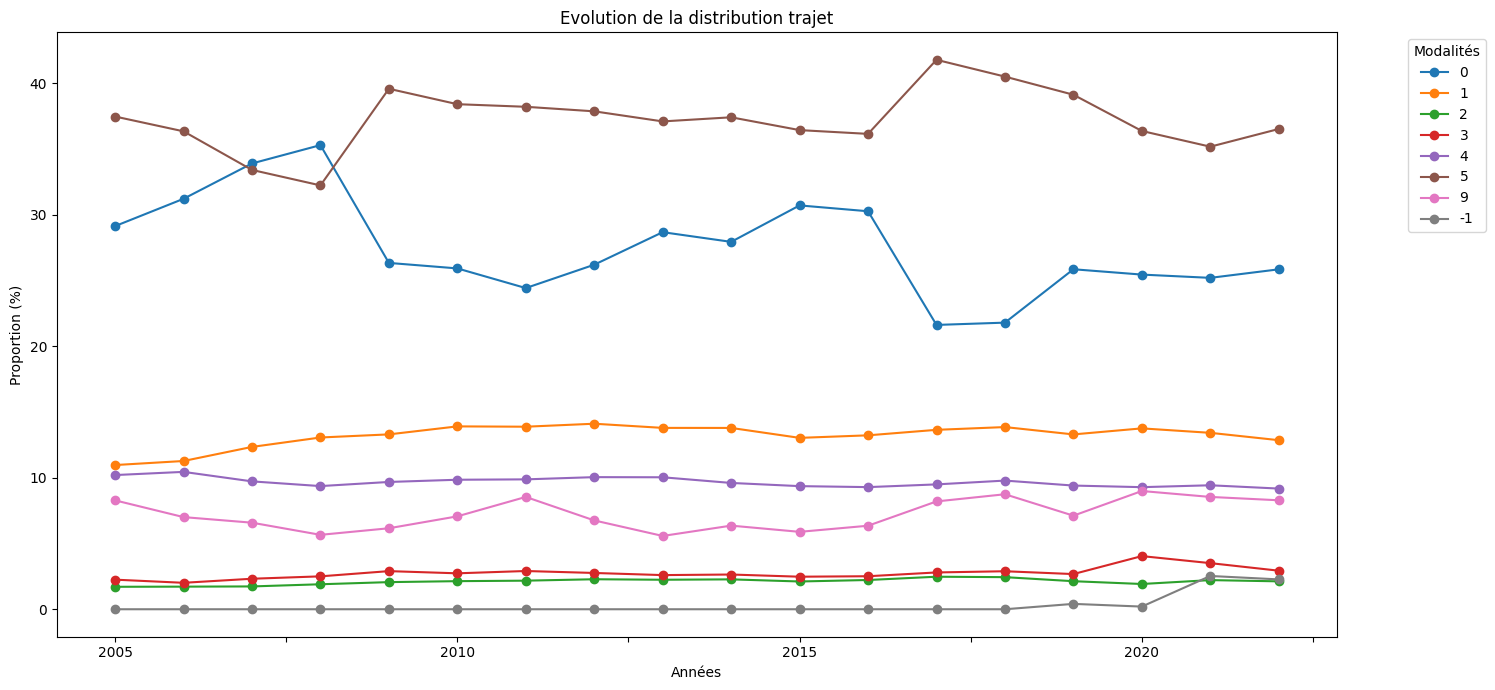

lignes: 2636377

Description: Localisation du piéton :

Modalités:
- -1: Non renseigné
- 0: Sans objet
- 1: Sur chaussée : A + 50 m du passage piéton
- 2: Sur chaussée : A – 50 m du passage piéton
- 3: Sur passage piéton : Sans signalisation lumineuse
- 4: Sur passage piéton : Avec signalisation lumineuse
- 5: Sur trottoir
- 6: Sur accotement
- 7: Sur refuge ou BAU
- 8: Sur contre allée
- 9: Inconnue
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                              0                                  0
   2006  int64         0                              0                                  0
   2007  int64         0                              0                                  0
   2008  int64         0                              0                                  0
   2009  float64       0      

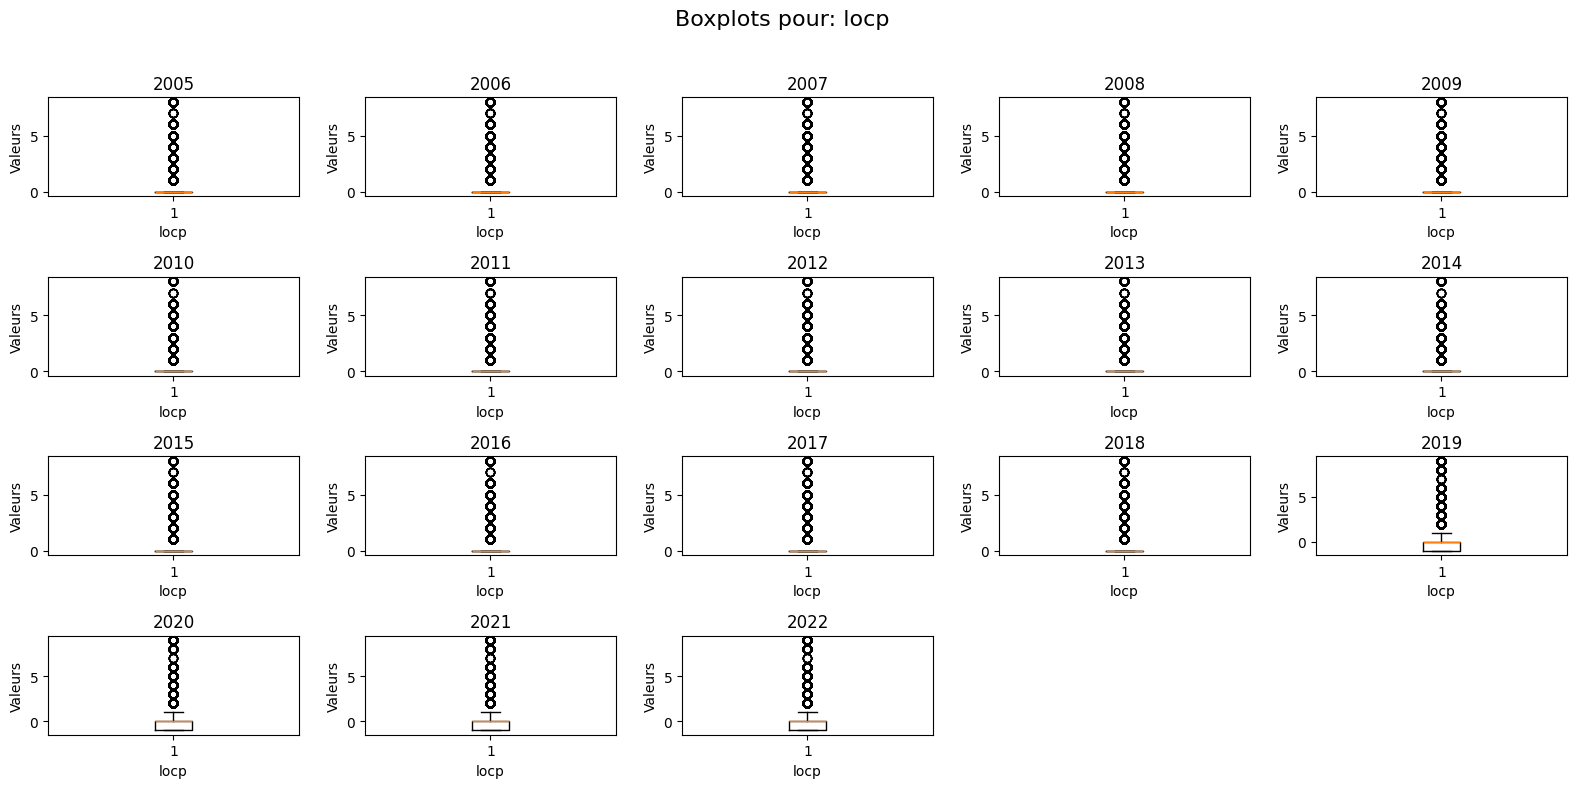

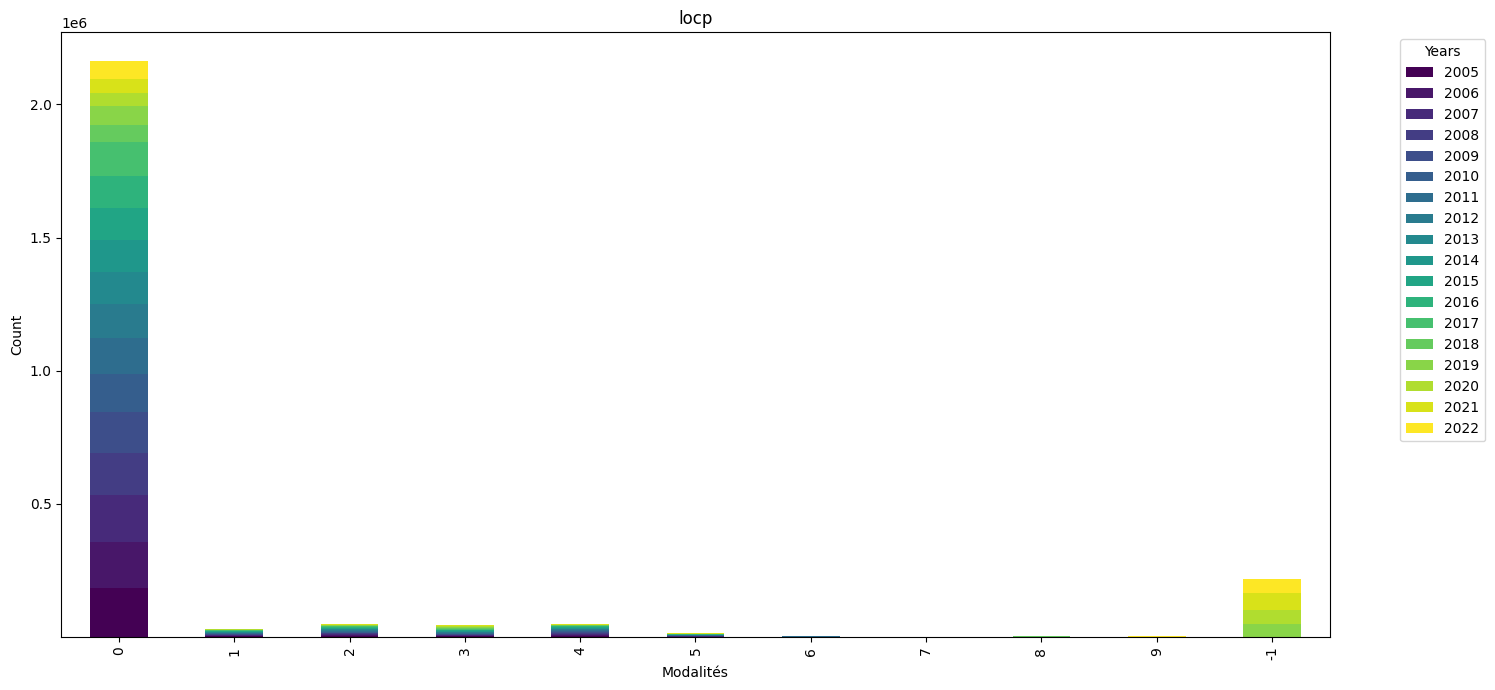

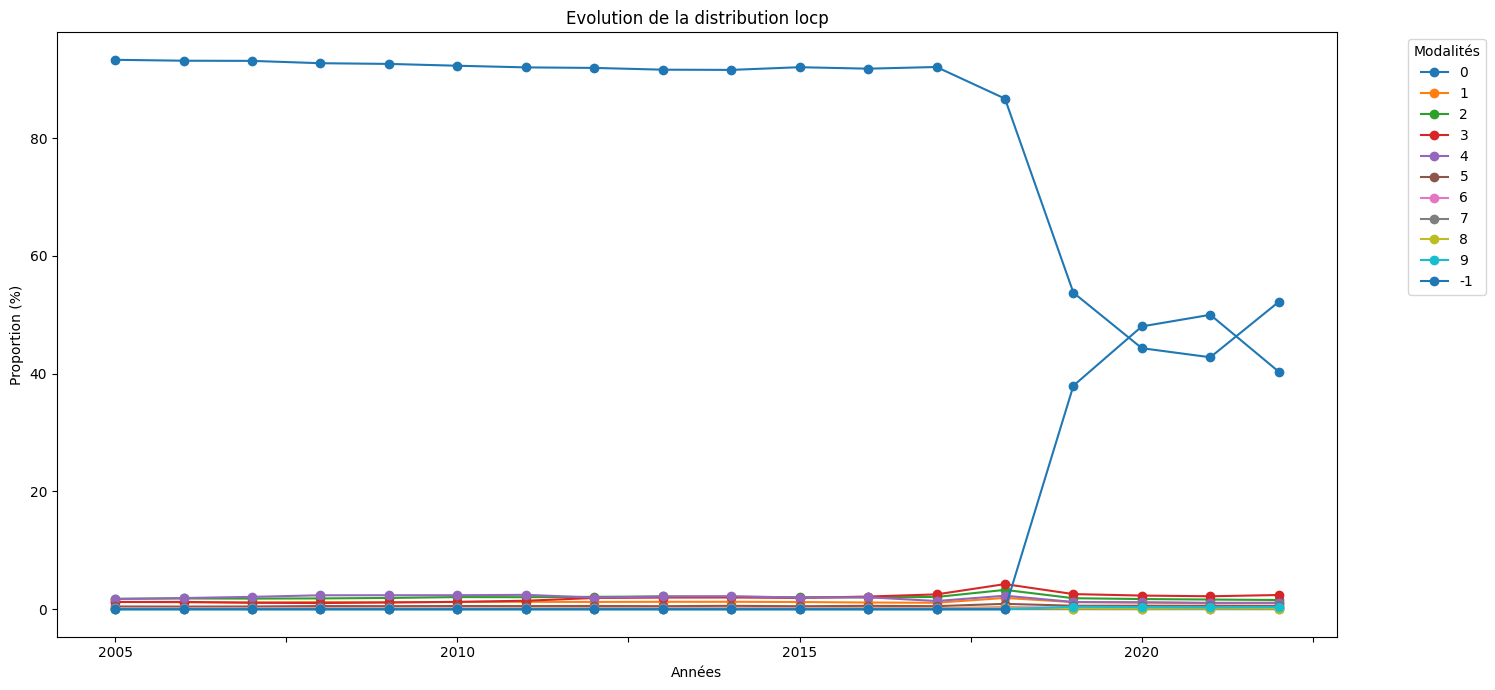

lignes: 2636377

Description: Cette variable permet de préciser si le piéton accidenté était seul ou non :

Modalités:
- -1: Non renseigné
- 1: Seul
- 2: Accompagné
- 3: En groupe
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                              0                                  0
   2006  int64         0                              0                                  0
   2007  int64         0                              0                                  0
   2008  int64         0                              0                                  0
   2009  float64       0                              0.336222                           0.000211654
   2010  float64       0                              0.142679                           8.34479e-05
   2011  float64       0                            

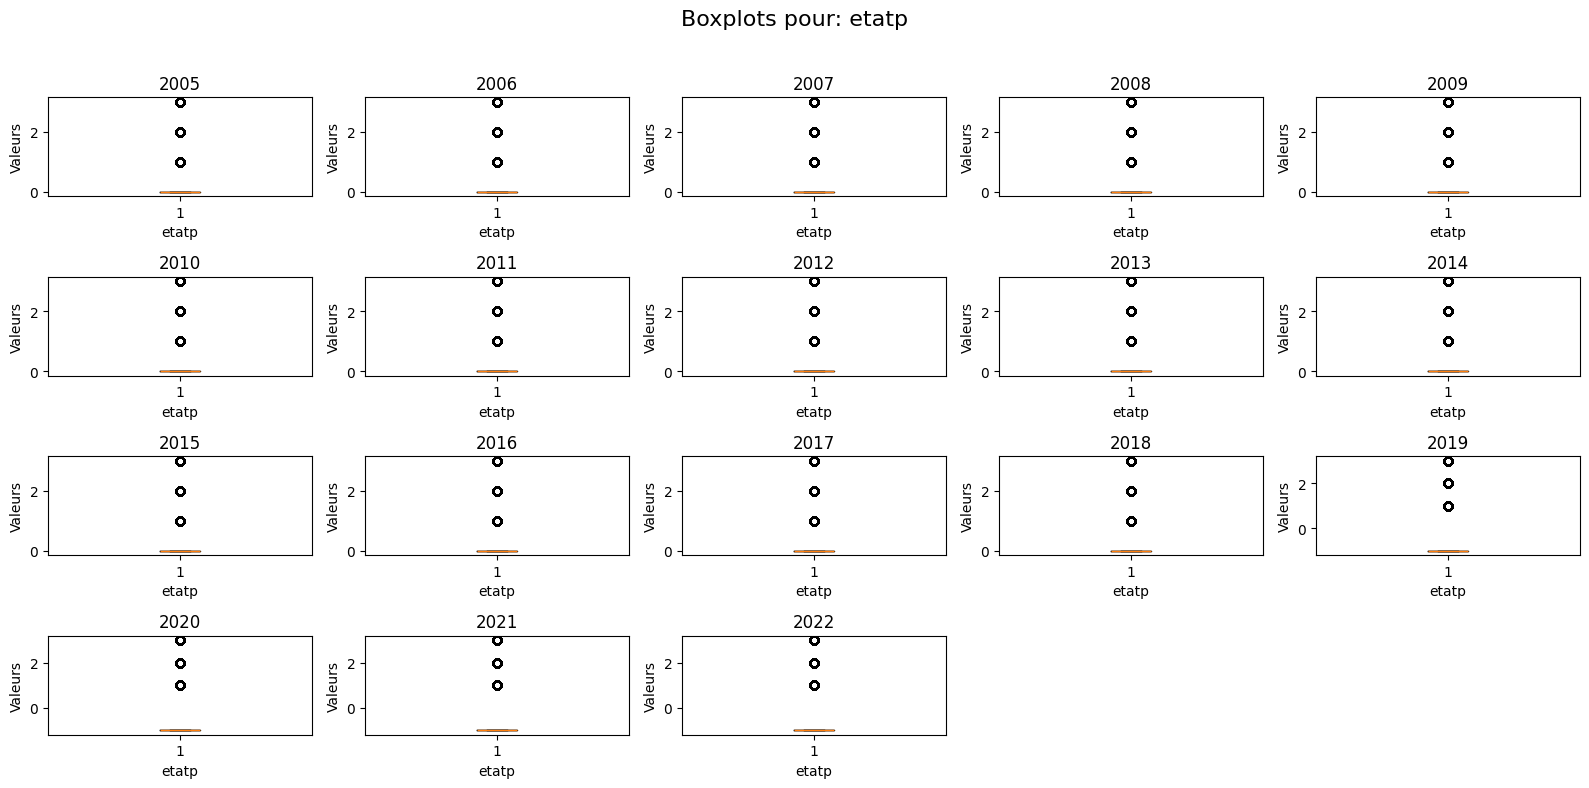

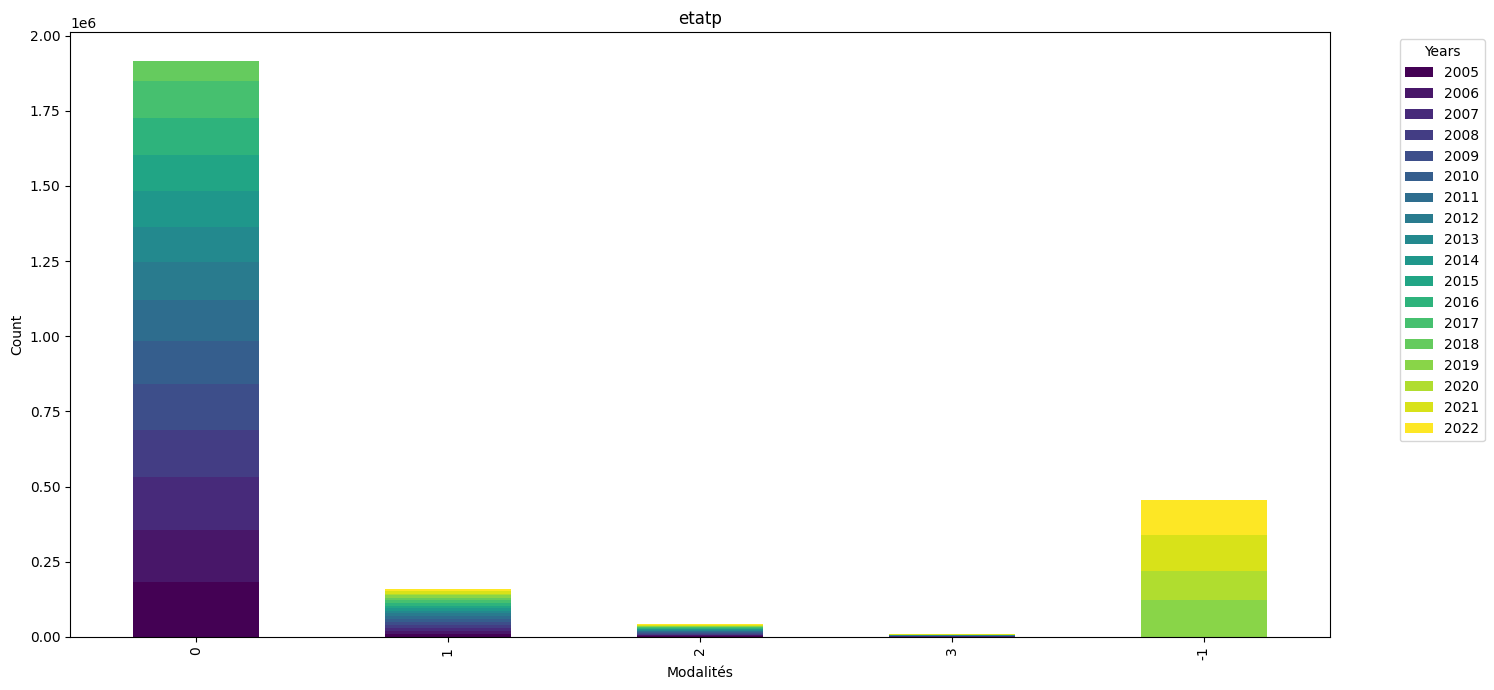

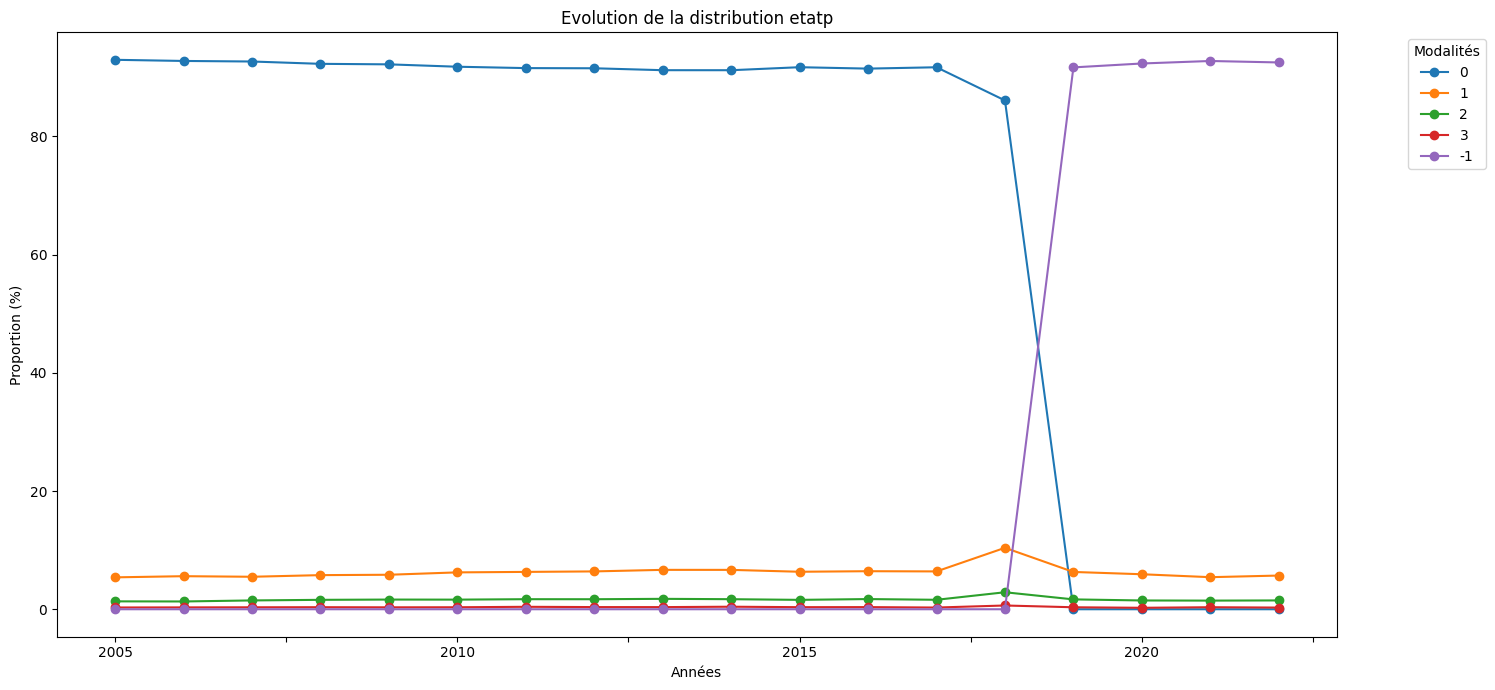

lignes: 2636377

Description: Le renseignement du caractère indique la présence et l’utilisation de l’équipement de sécurité :

Modalités:
- -1: Non renseigné
- 0: Aucun équipement
- 1: Ceinture
- 2: Casque
- 3: Dispositif enfants
- 4: Gilet réfléchissant
- 5: Airbag (2RM/3RM)
- 6: Gants (2RM/3RM)
- 7: Gants + Airbag (2RM/3RM)
- 8: Non déterminable
- 9: Autre
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2019  int64        1                                      0                                    0
   2020  int64        1                                      0                                    0
   2021  int64        1                                      0                                    0
   2022  int64        1                                      0                                    0


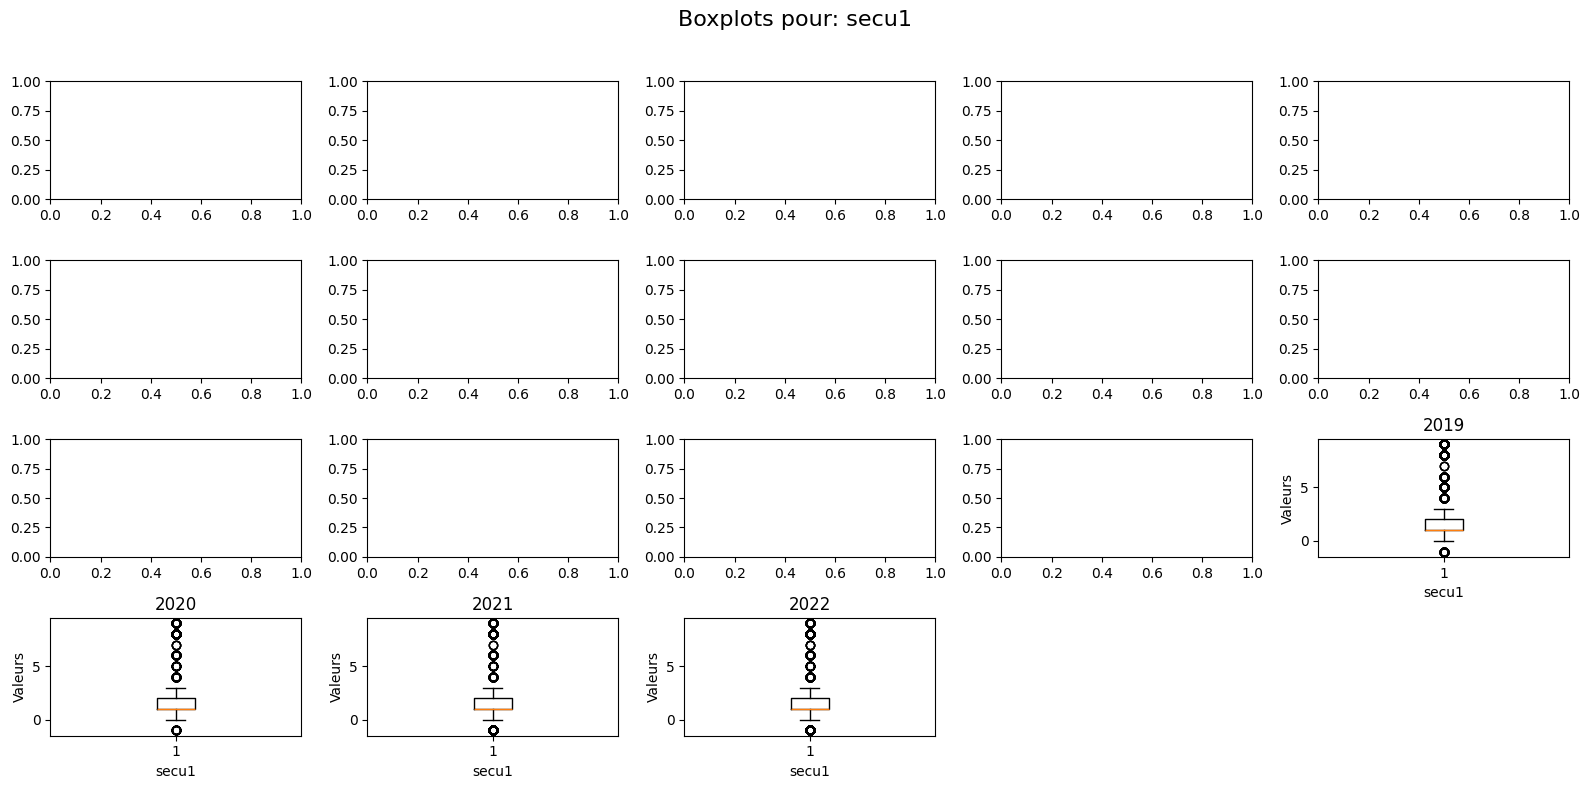

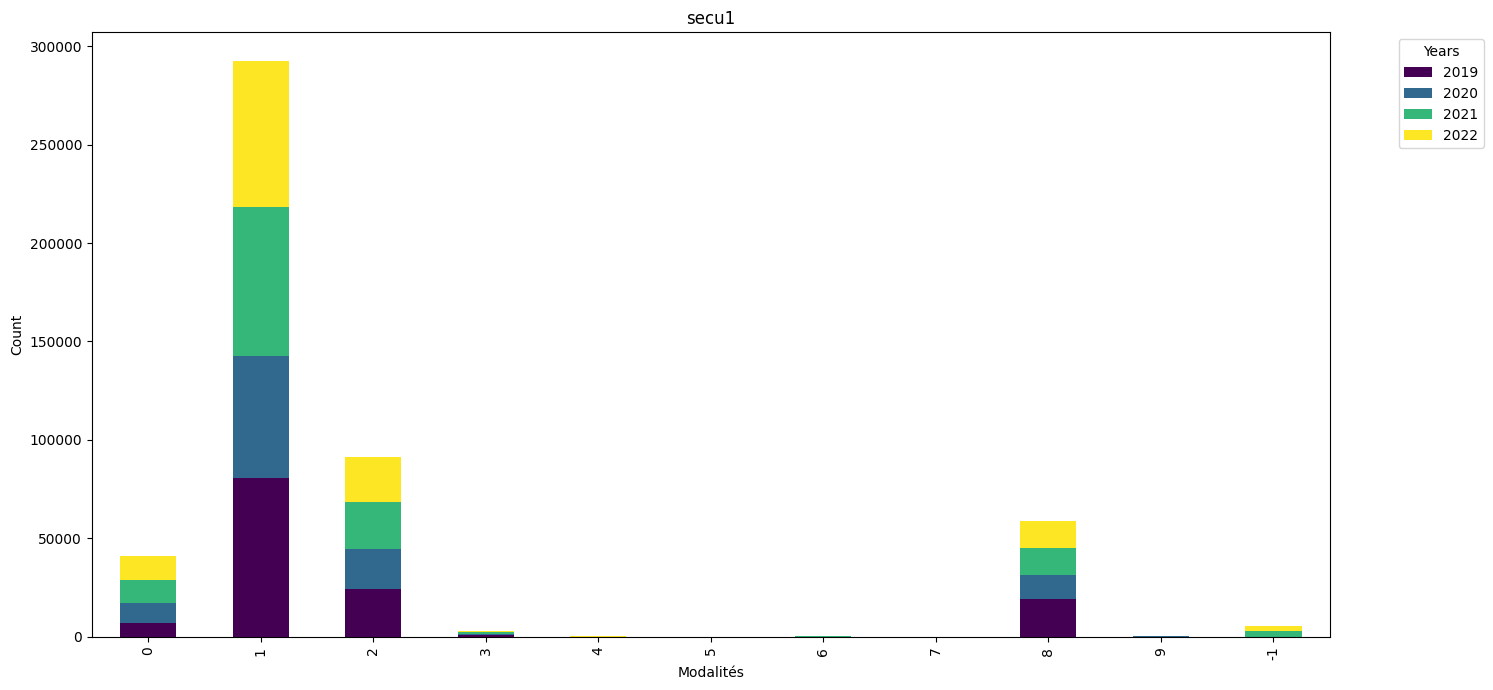

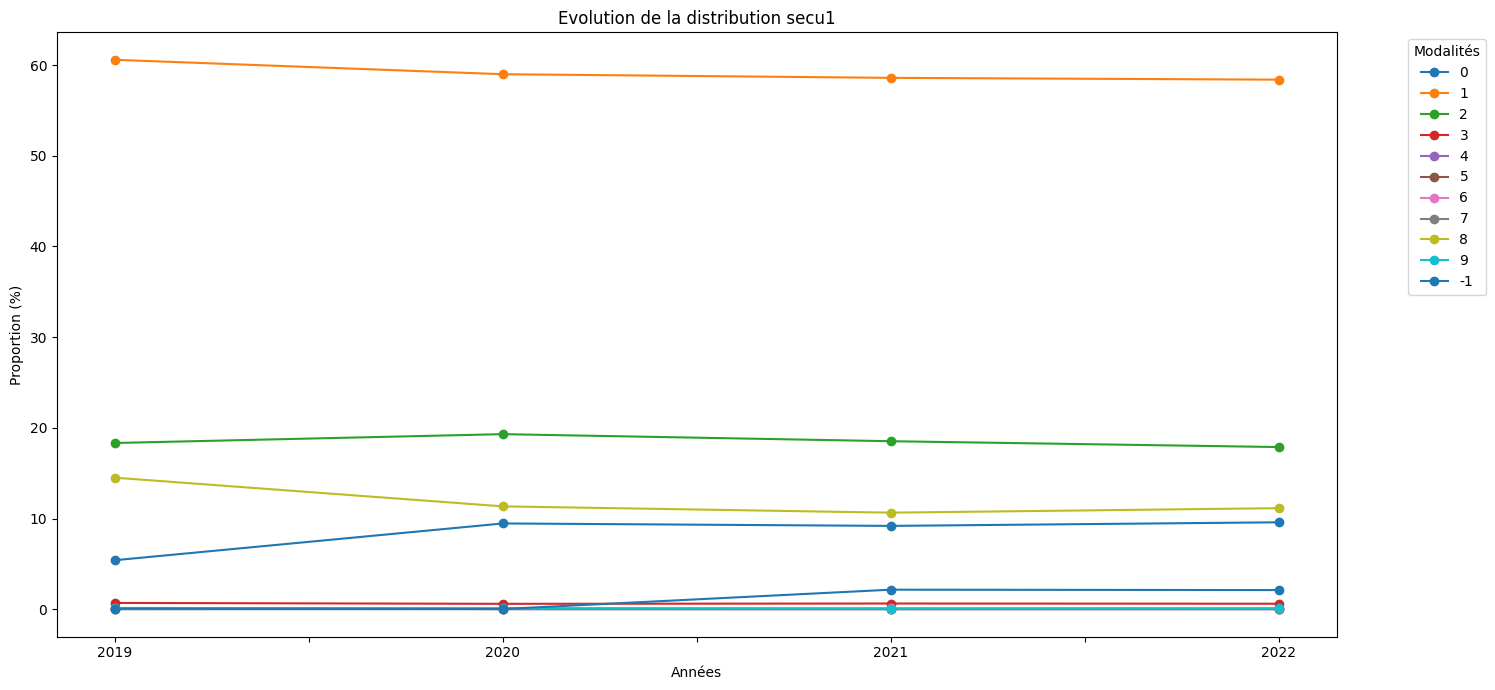

lignes: 2636377

Description: Gravité de blessure de l'usager :

Modalités:
- 1: Indemne
- 2: Tué
- 3: Blessé hospitalisé
- 4: Blessé léger
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  int64        1                                      0                                    0
   2006  int64        1                                      0                                    0
   2007  int64        1                                      0                                    0
   2008  int64        1                                      0                                    0
   2009  int64        1                                      0                                    0
   2010  int64        1                                      0                                    0
   2011  int64        1                                     

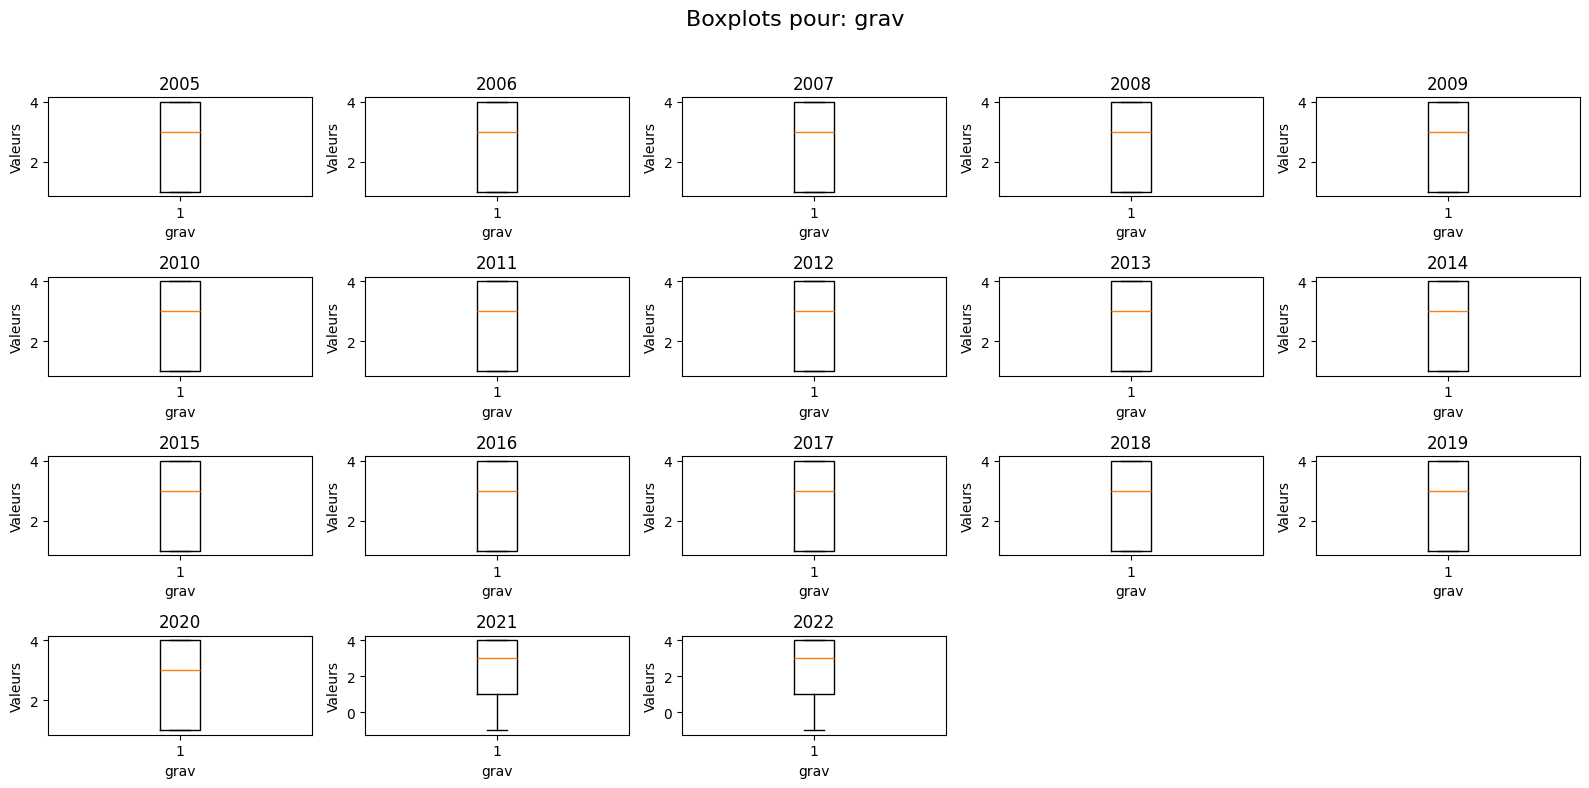

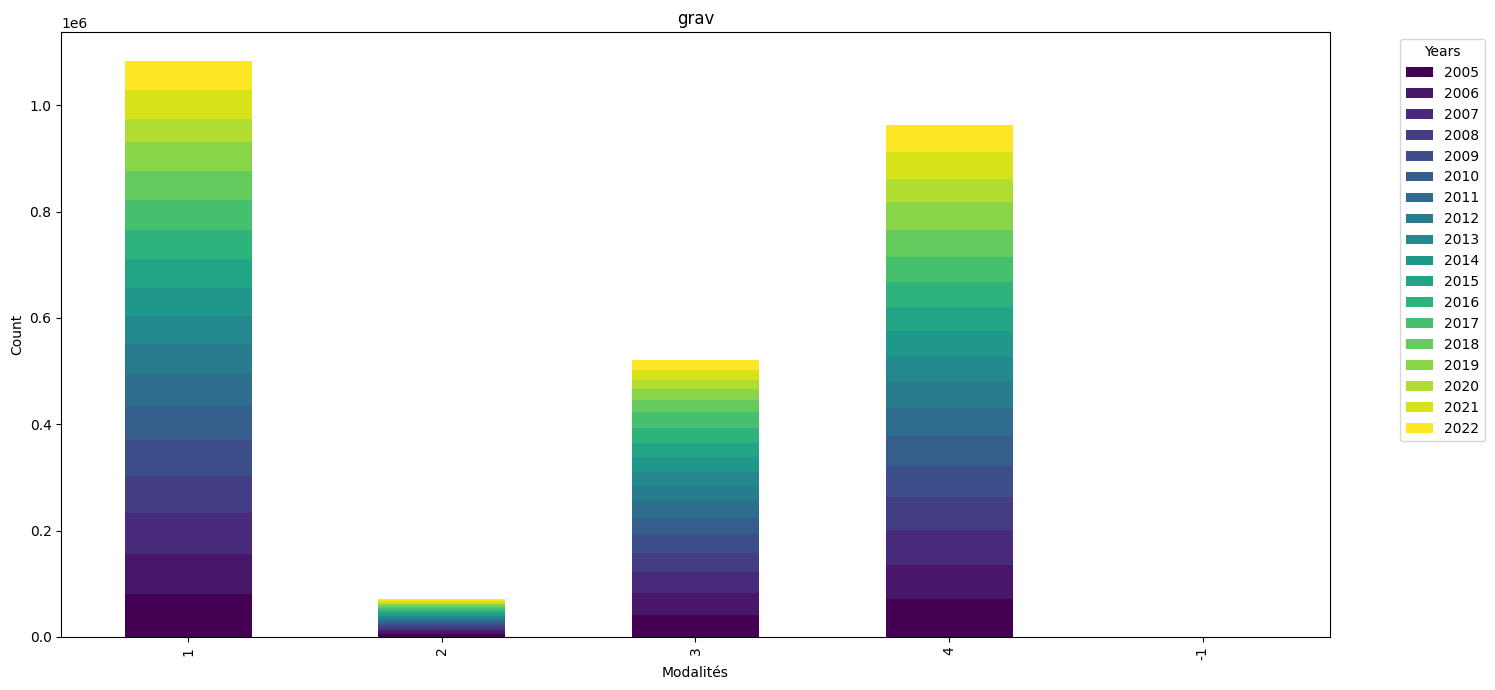

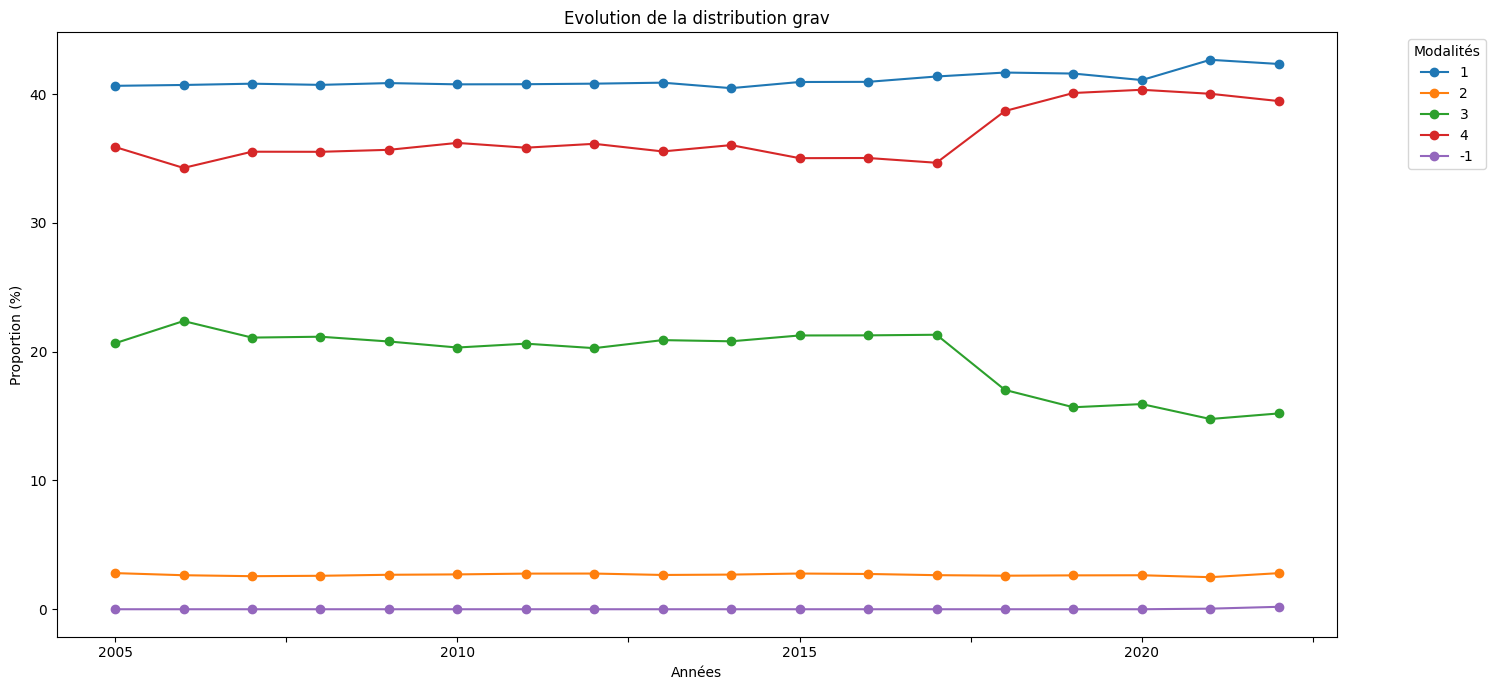

lignes: 2636377

Description: Action du piéton :

Modalités:
- -1: Non renseigné
- 0: Non renseigné ou sans objet
- 1: Se déplaçant dans le Sens véhicule heurtant
- 2: Se déplaçant dans le Sens inverse du véhicule
- 3: Traversant
- 4: Masqué
- 5: Jouant – courant
- 6: Avec animal
- 9: Autre
- A: Monte/descend du véhicule
- B: Inconnue
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                              0                                  0
   2006  int64         0                              0                                  0
   2007  int64         0                              0                                  0
   2008  int64         0                              0                                  0
   2009  float64       0                              0.361529                           0.000227

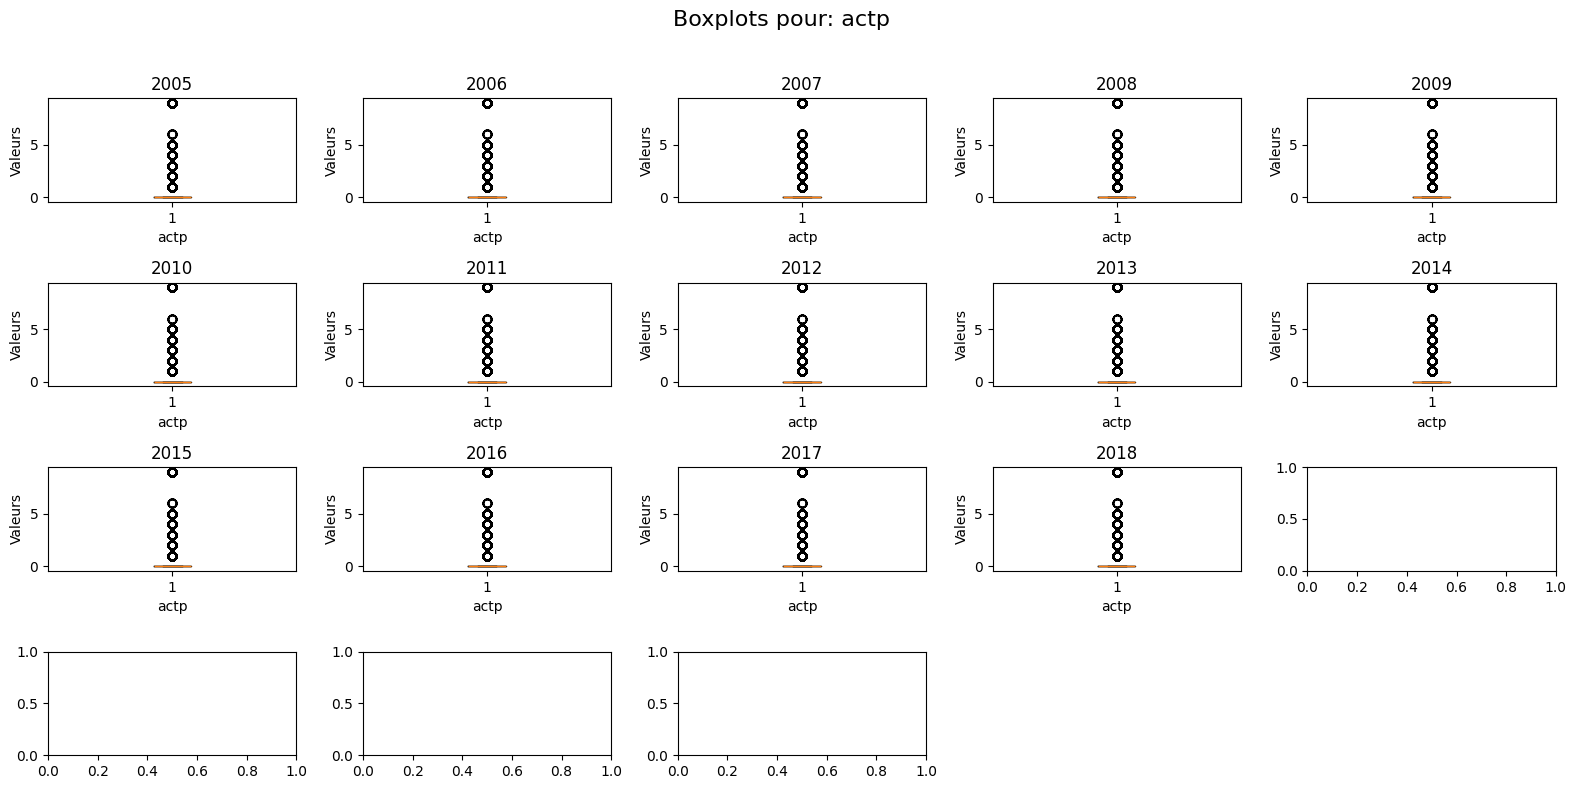

C:\Users\remi\AppData\Local\Temp\ipykernel_11436\2599144348.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count = modality_counts[file_name].get(modality, 0)


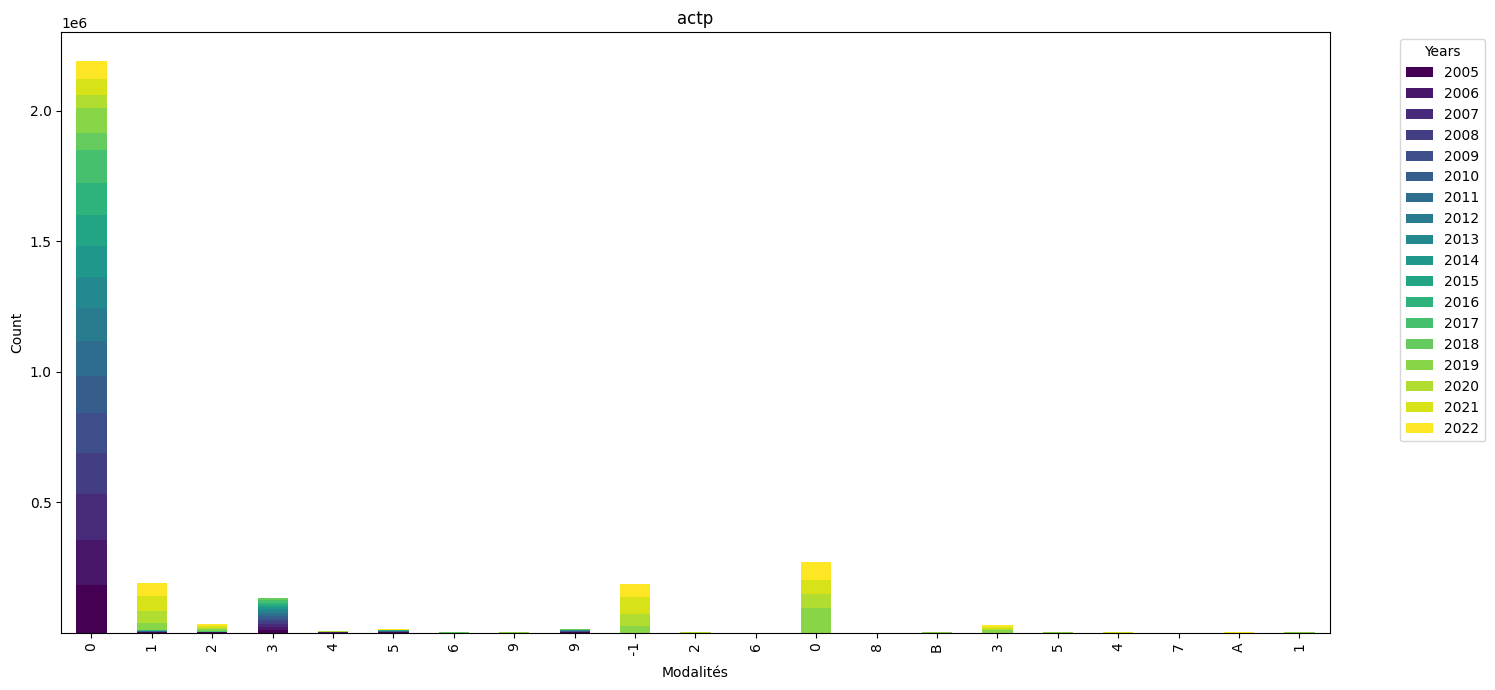

2024-06-12 13:26:55,776 - WARNING - Le nombre de modalités uniques dans la colonne actp excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-12 13:26:56,211 - INFO - La colonne id_vehicule n'est pas numérique.


lignes: 2636377

Description: Identifiant unique du véhicule repris pour chacun des usagers occupant ce véhicule – Code numérique.
  Année  Type    Mode           Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  -----------  -------------------------------------  -----------------------------------
   2019  object  138 212 691                                      0                                    0
   2020  object  154 730 652                                      0                                    0
   2021  object  172 295                                          0                                    0
   2022  object  755 536                                          0                                    0


2024-06-12 13:26:56,601 - WARNING - Le nombre de modalités uniques dans la colonne id_vehicule excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:26:56,913 - WARNING - Le nombre de modalités uniques dans la colonne id_vehicule excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-12 13:26:56,931 - INFO - Chargement de vehicules.


lignes: 2009395

Description: Catégorie du véhicule :

Modalités:
- 00: Indéterminable
- 01: Bicyclette
- 02: Cyclomoteur <50cm3
- 03: Voiturette (Quadricycle à moteur carrossé)
- 04: Référence inutilisée depuis 2006 (scooter immatriculé)
- 05: Référence inutilisée depuis 2006 (motocyclette)
- 06: Référence inutilisée depuis 2006 (side-car)
- 07: VL seul
- 08: Référence inutilisée depuis 2006 (VL + caravane)
- 09: Référence inutilisée depuis 2006 (VL + remorque)
- 10: VU seul 1,5T <= PTAC <= 3,5T
- 11: Référence inutilisée depuis 2006 (VU (10) + caravane)
- 12: Référence inutilisée depuis 2006 (VU (10) + remorque)
- 13: PL seul 3,5T <PTCA <= 7,5T
- 14: PL seul > 7,5T
- 15: PL > 3,5T + remorque
- 16: Tracteur routier seul
- 17: Tracteur routier + semi-remorque
- 18: Référence inutilisée depuis 2006 (transport en commun)
- 19: Référence inutilisée depuis 2006 (tramway)
- 20: Engin spécial
- 21: Tracteur agricole
- 30: Scooter < 50 cm3
- 31: Motocyclette > 50 cm3 et <= 125 cm3
- 32: Scoot

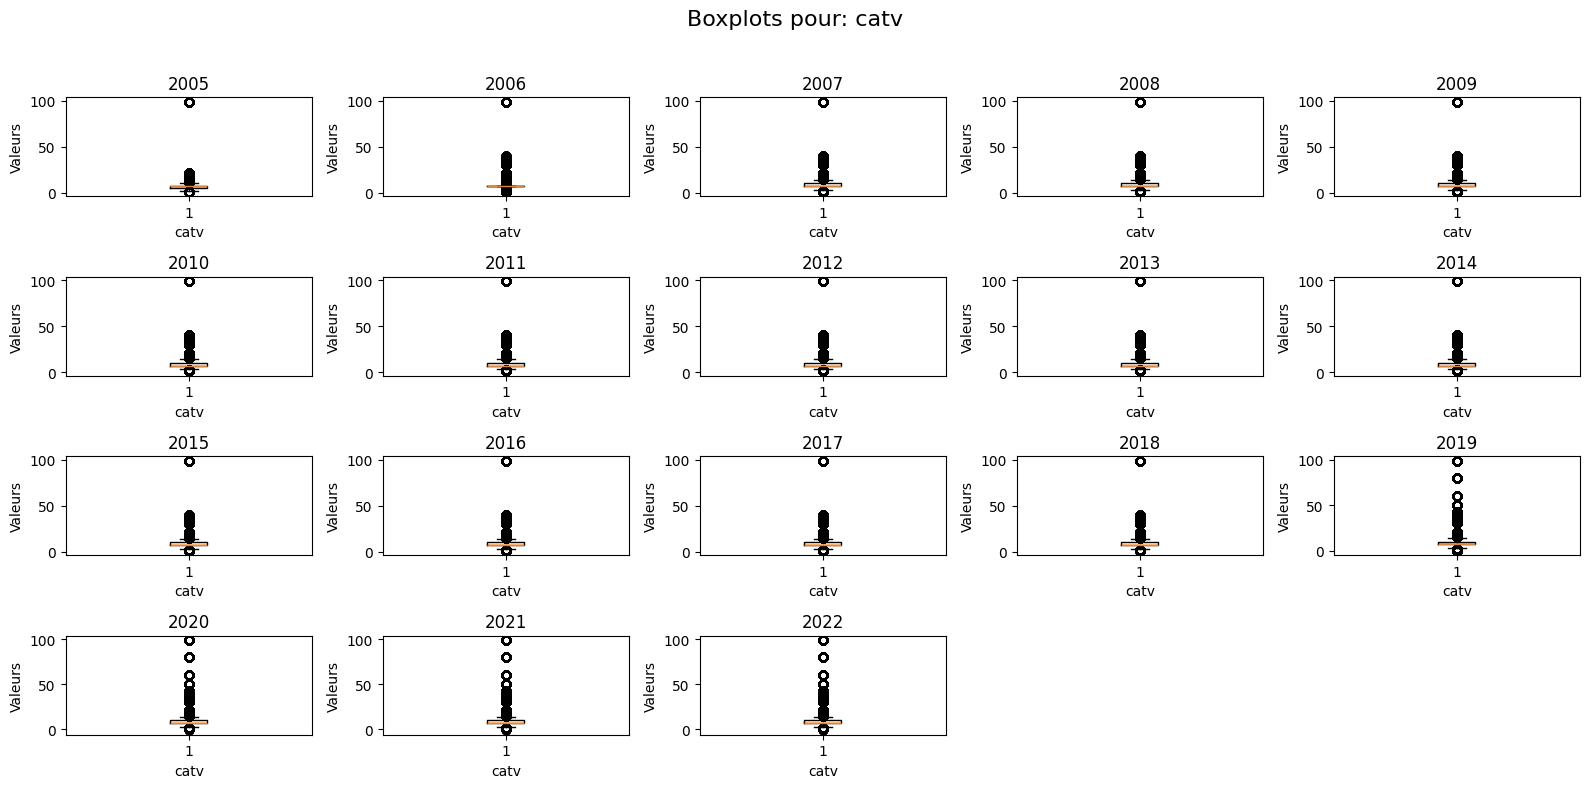

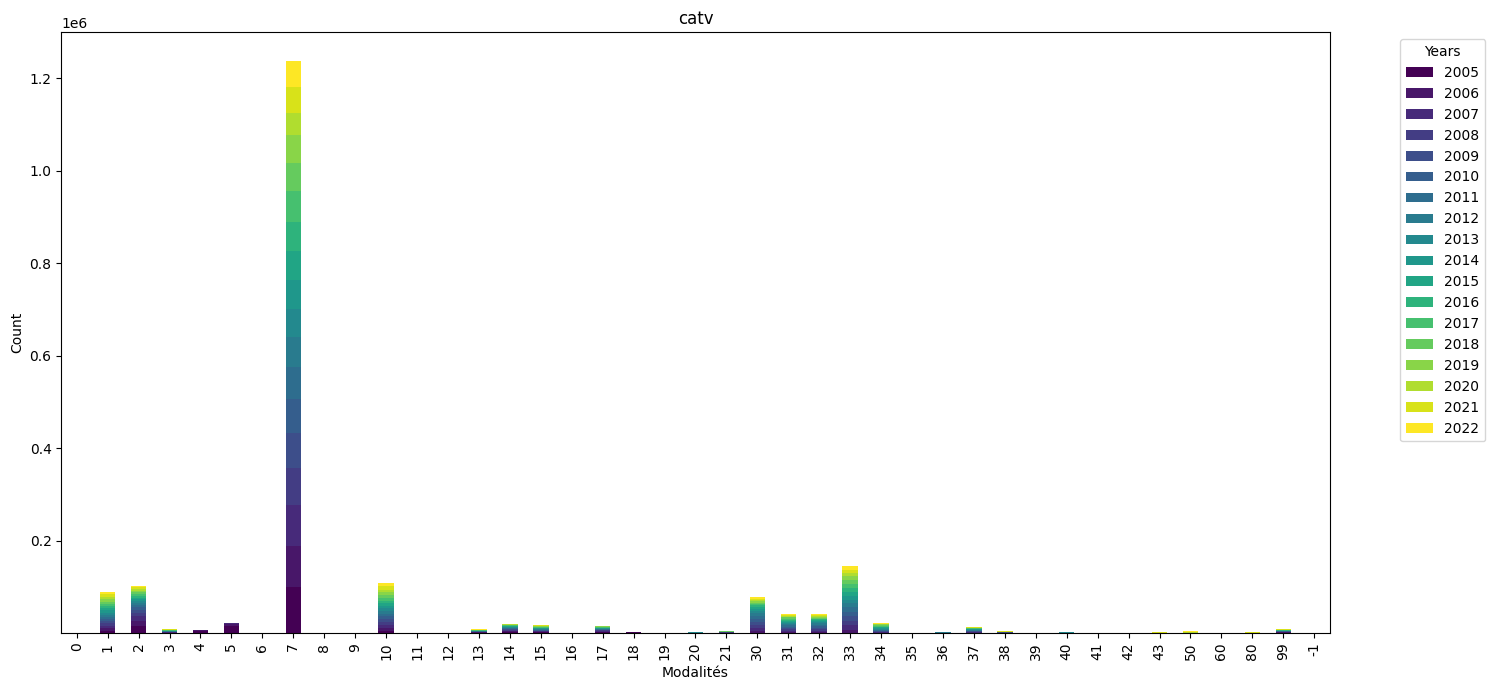

2024-06-12 13:27:00,996 - WARNING - Le nombre de modalités uniques dans la colonne catv excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 2009395

Description: Point de choc initial :

Modalités:
- -1: Non renseigné
- 0: Aucun
- 1: Avant
- 2: Avant droit
- 3: Avant gauche
- 4: Arrière
- 5: Arrière droit
- 6: Arrière gauche
- 7: Côté droit
- 8: Côté gauche
- 9: Chocs multiples (tonneaux)
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         1                              0                                  0
   2006  int64         1                              0                                  0
   2007  int64         1                              0                                  0
   2008  int64         1                              0                                  0
   2009  float64       1                              0.0379906                          2.38878e-05
   2010  float64       1                              0.0144382          

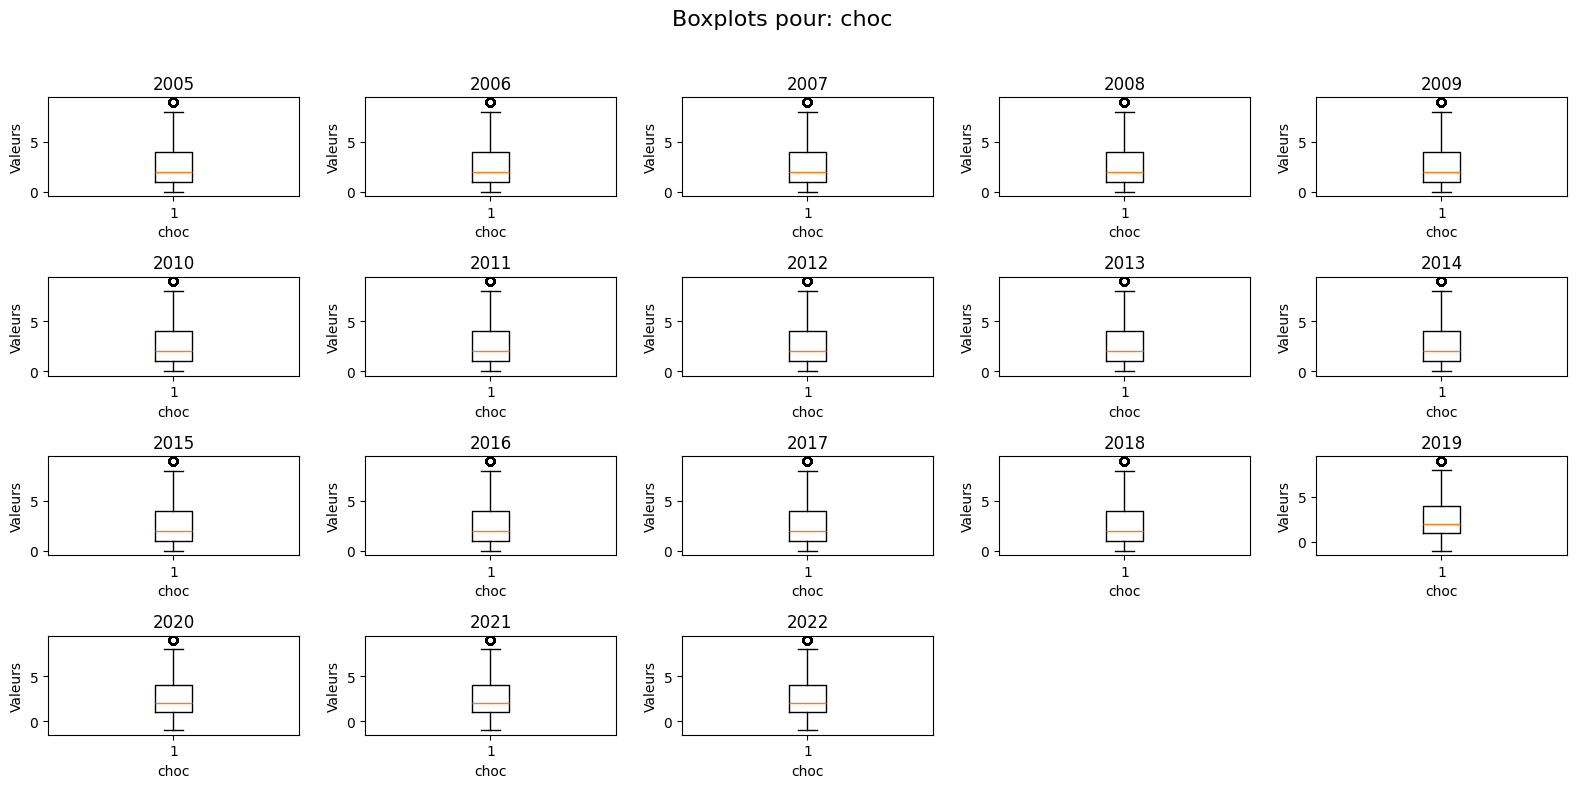

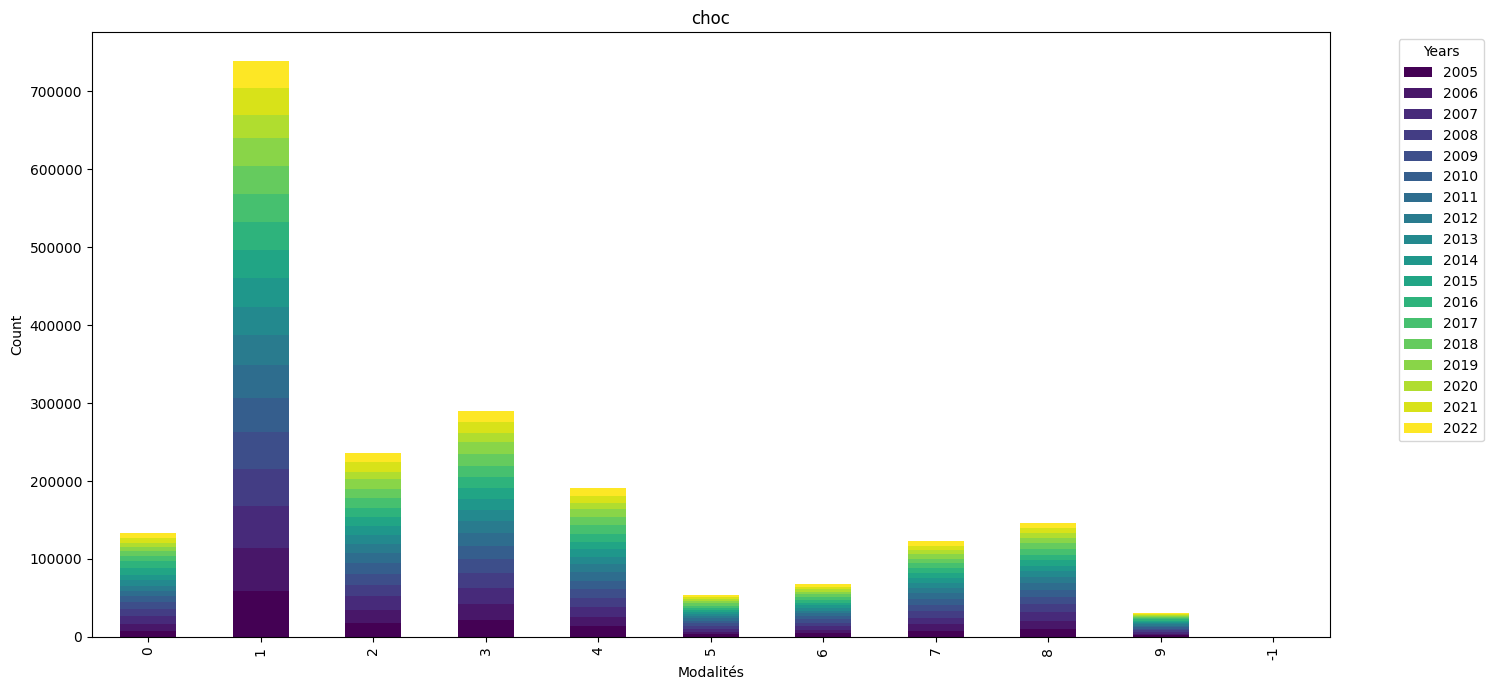

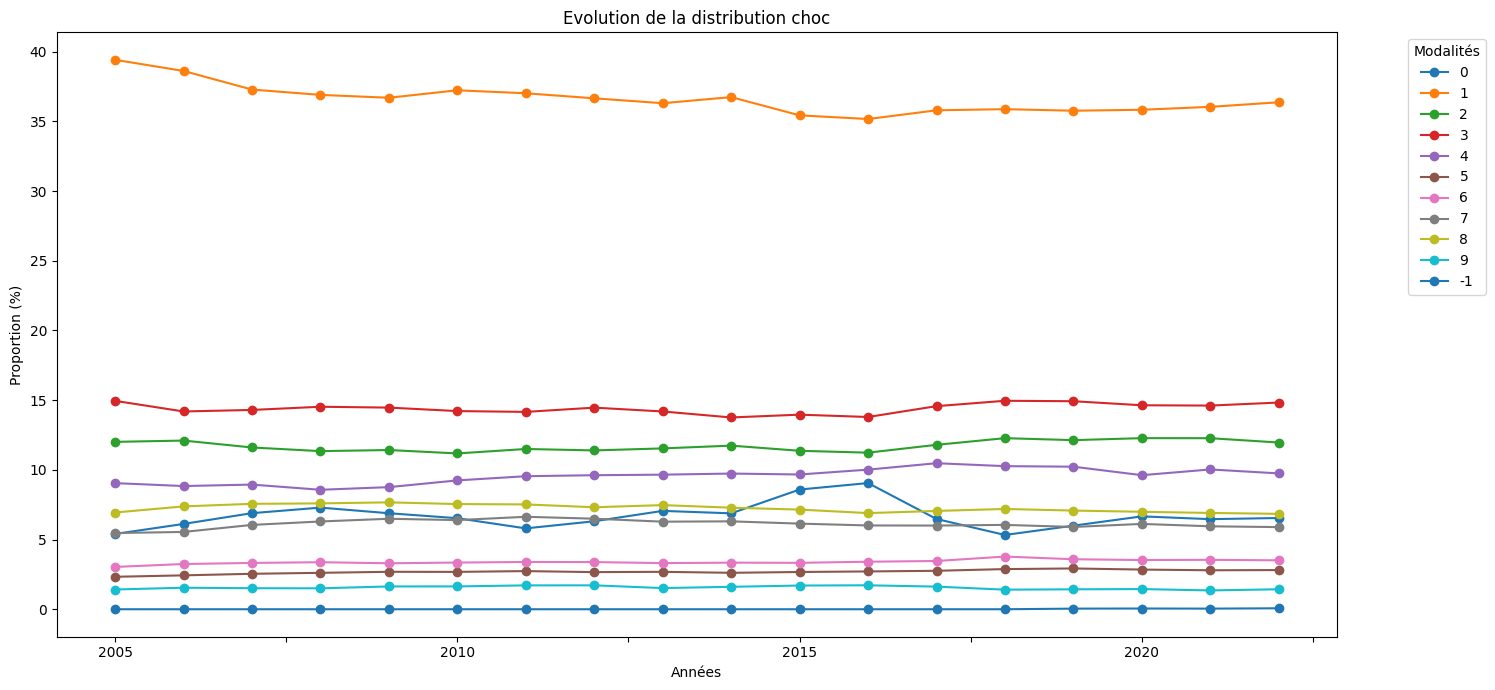

lignes: 2009395

Description: Obstacle fixe heurté :

Modalités:
- -1: Non renseigné
- 0: Sans objet
- 1: Véhicule en stationnement
- 2: Arbre
- 3: Glissière métallique
- 4: Glissière béton
- 5: Autre glissière
- 6: Bâtiment, mur, pile de pont
- 7: Support de signalisation verticale ou poste d’appel d’urgence
- 8: Poteau
- 9: Mobilier urbain
- 10: Parapet
- 11: Ilot, refuge, borne haute
- 12: Bordure de trottoir
- 13: Fossé, talus, paroi rocheuse
- 14: Autre obstacle fixe sur chaussée
- 15: Autre obstacle fixe sur trottoir ou accotement
- 16: Sortie de chaussée sans obstacle
- 17: Buse – tête d’aqueduc
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                              0                                  0
   2006  int64         0                              0                                  0
   200

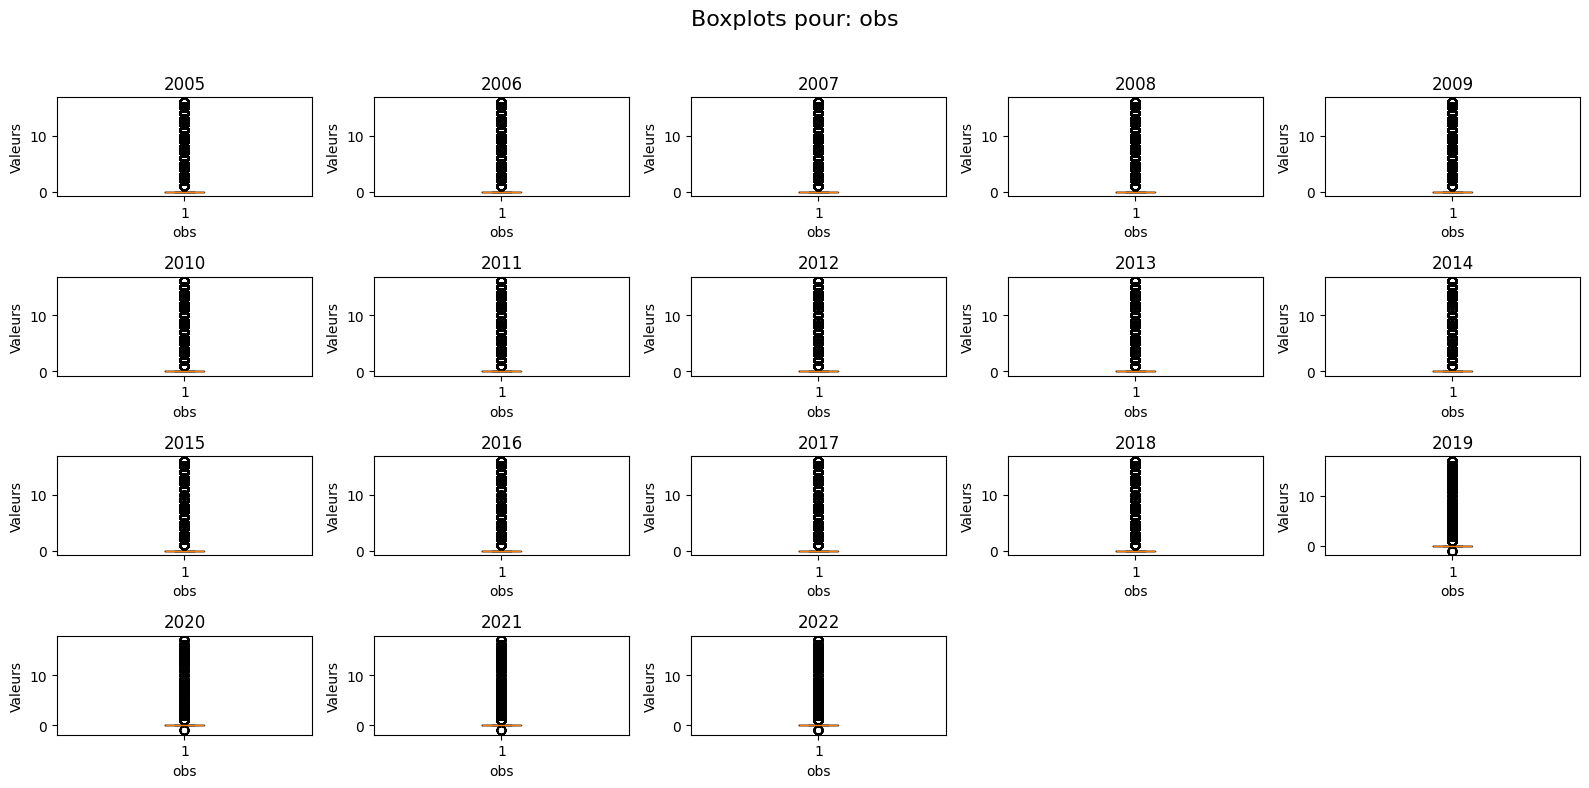

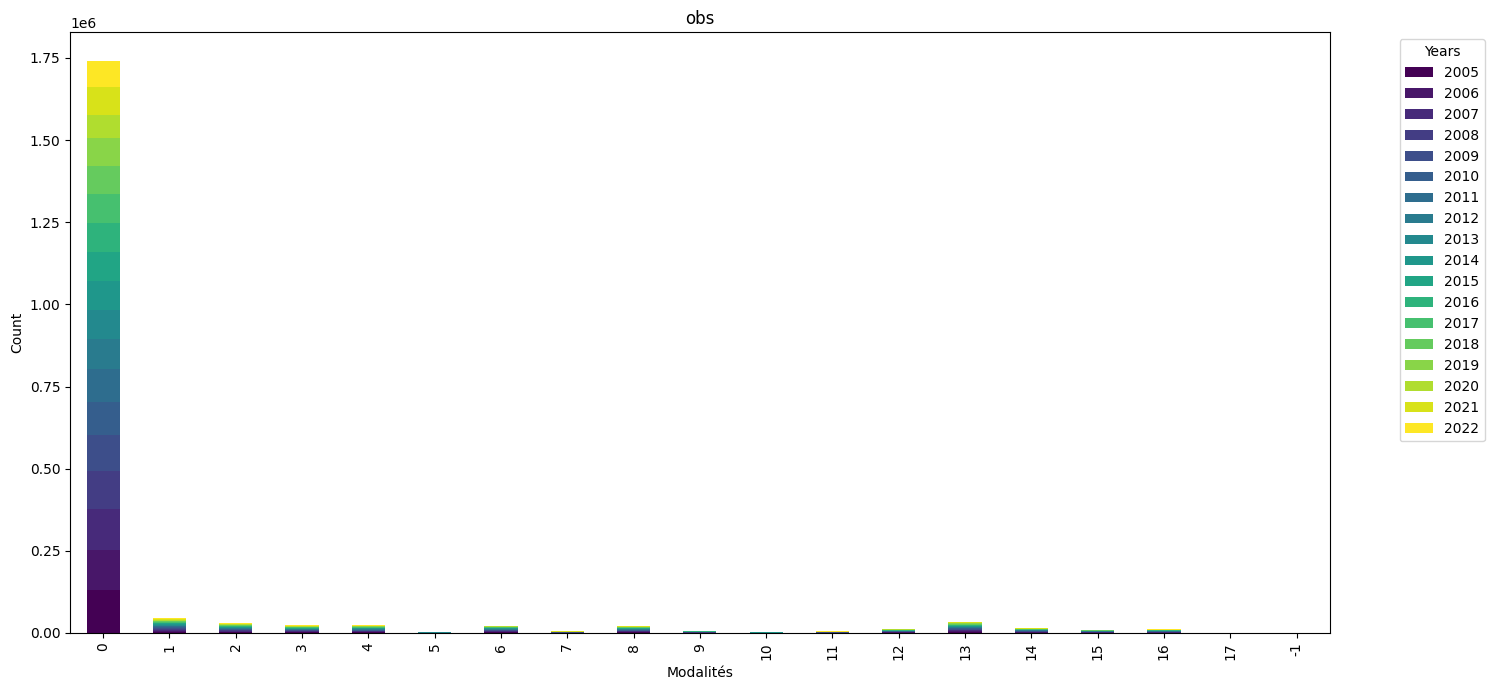

2024-06-12 13:27:07,085 - WARNING - Le nombre de modalités uniques dans la colonne obs excède le seuil de 12. Aucun graphique en ligne généré.


2024-06-12 13:27:07,580 - INFO - Pas de description pour `num_veh` dans la section `VEHICULES`.
2024-06-12 13:27:07,582 - INFO - La colonne num_veh n'est pas numérique.
2024-06-12 13:27:07,668 - WARNING - Le nombre de modalités uniques dans la colonne num_veh excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:27:07,750 - WARNING - Le nombre de modalités uniques dans la colonne num_veh excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 2009395

  Année  Type    Mode      Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2005  object  A01                                         0                                    0
   2006  object  A01                                         0                                    0
   2007  object  A01                                         0                                    0
   2008  object  A01                                         0                                    0
   2009  object  A01                                         0                                    0
   2010  object  A01                                         0                                    0
   2011  object  A01                                         0                                    0
   2012  object  A01                                         0                     

lignes: 2009395

Description: Obstacle mobile heurté :

Modalités:
- -1: Non renseigné
- 0: Aucun
- 1: Piéton
- 2: Véhicule
- 4: Véhicule sur rail
- 5: Animal domestique
- 6: Animal sauvage
- 9: Autre
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         2                              0                                  0
   2006  int64         2                              0                                  0
   2007  int64         2                              0                                  0
   2008  int64         2                              0                                  0
   2009  float64       2                              0.0989339                          6.22078e-05
   2010  float64       2                              0.0433147                          2.53808e-05
   2011  float64       2       

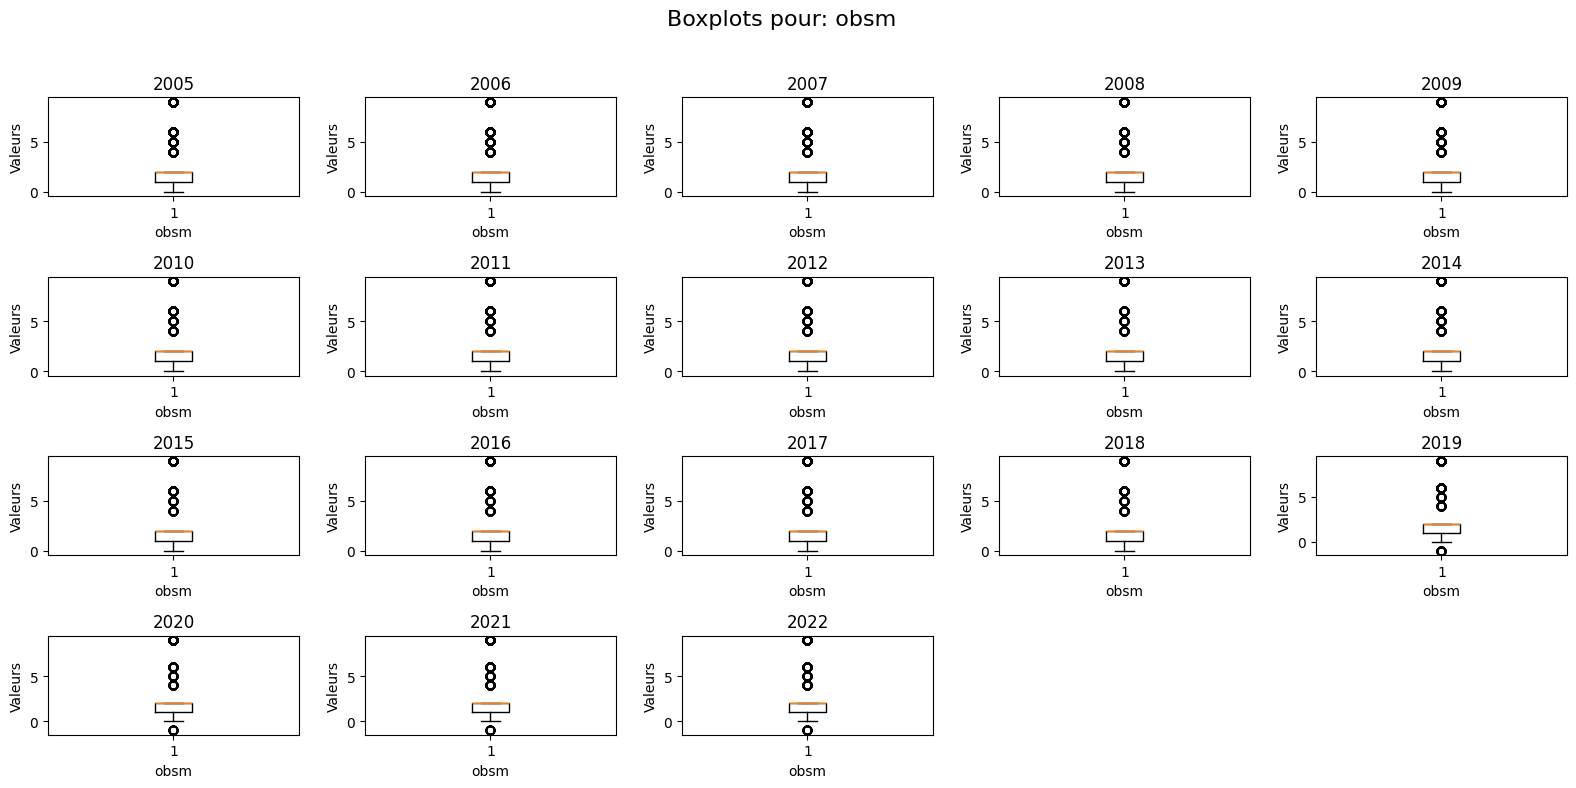

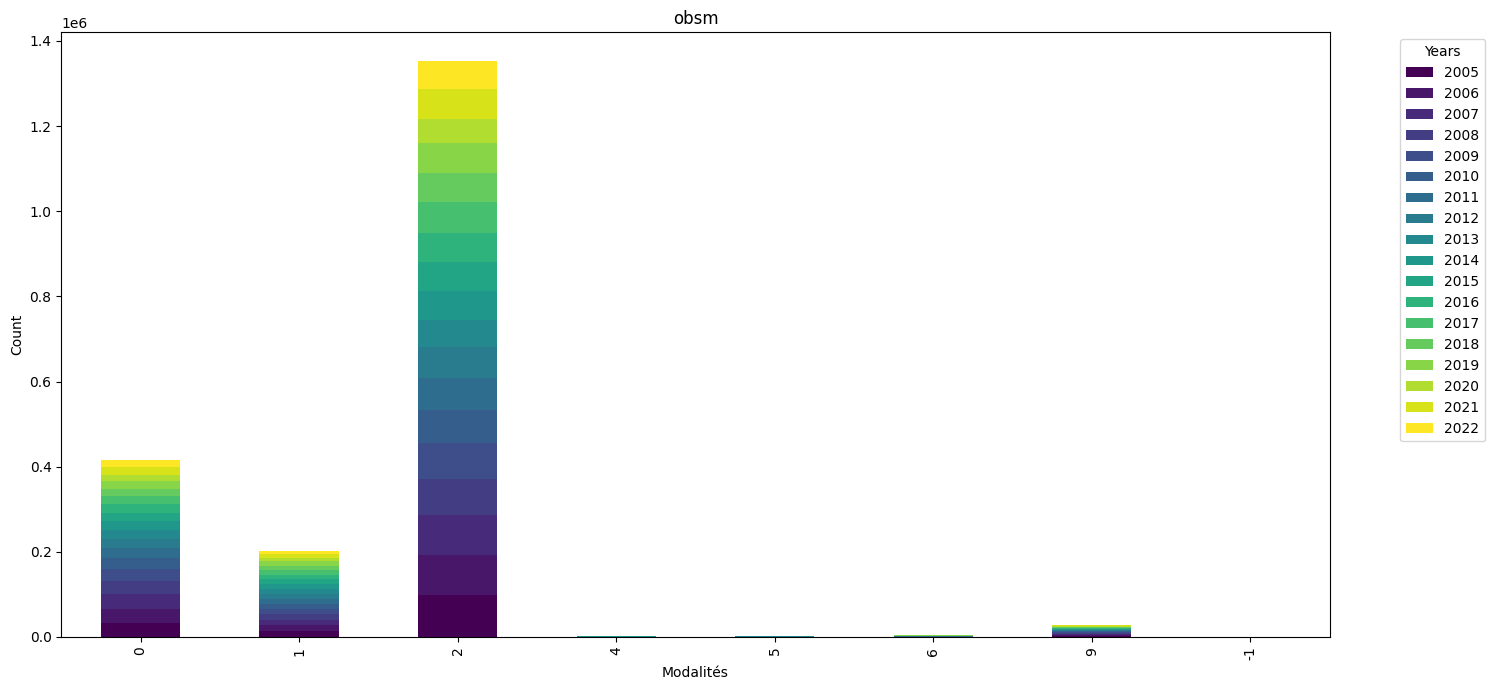

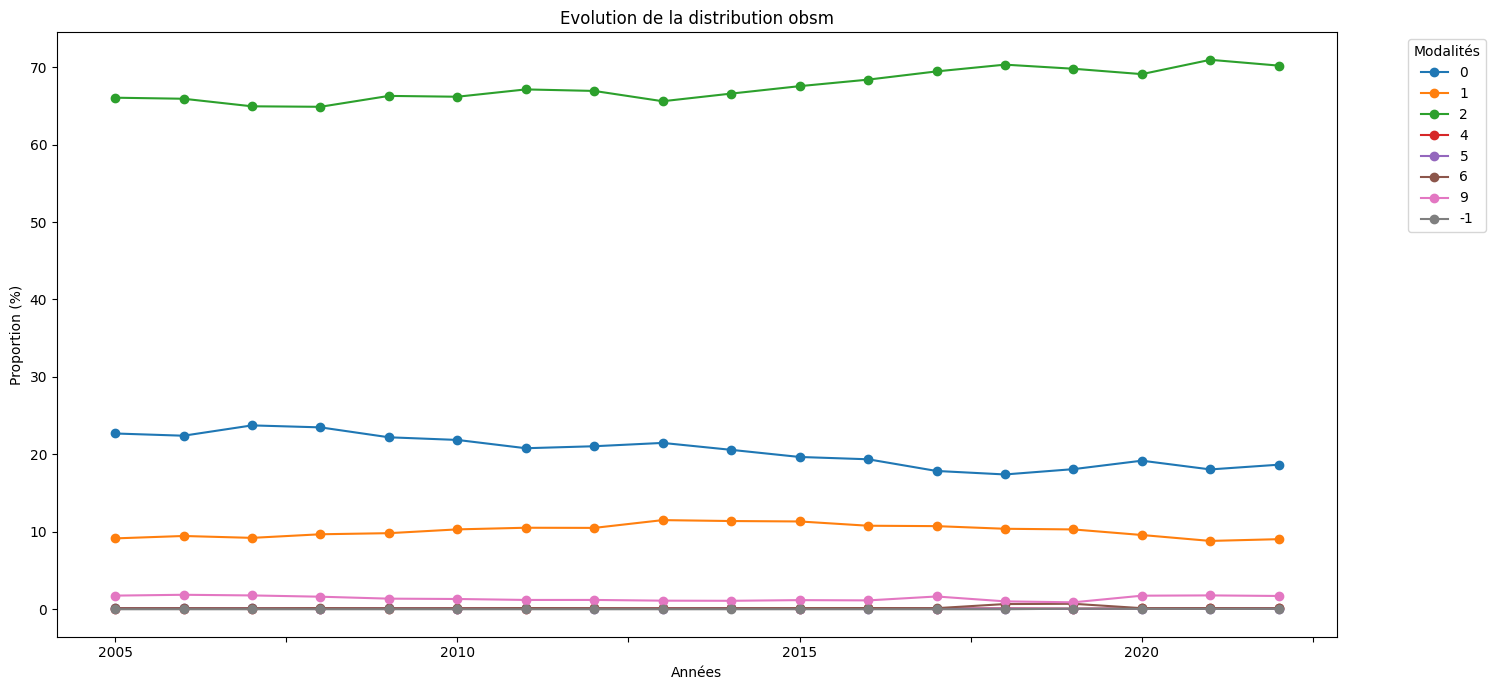

lignes: 2009395

Description: Sens de circulation :

Modalités:
- -1: Non renseigné
- 0: Inconnu
- 1: PK ou PR ou numéro d’adresse postale croissant
- 2: PK ou PR ou numéro d’adresse postale décroissant
- 3: Absence de repère
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                              0                                  0
   2006  int64         0                              0                                  0
   2007  int64         0                              0                                  0
   2008  int64         0                              0                                  0
   2009  int64         0                              0                                  0
   2010  int64         0                              0                                  0
   2011  int64         0  

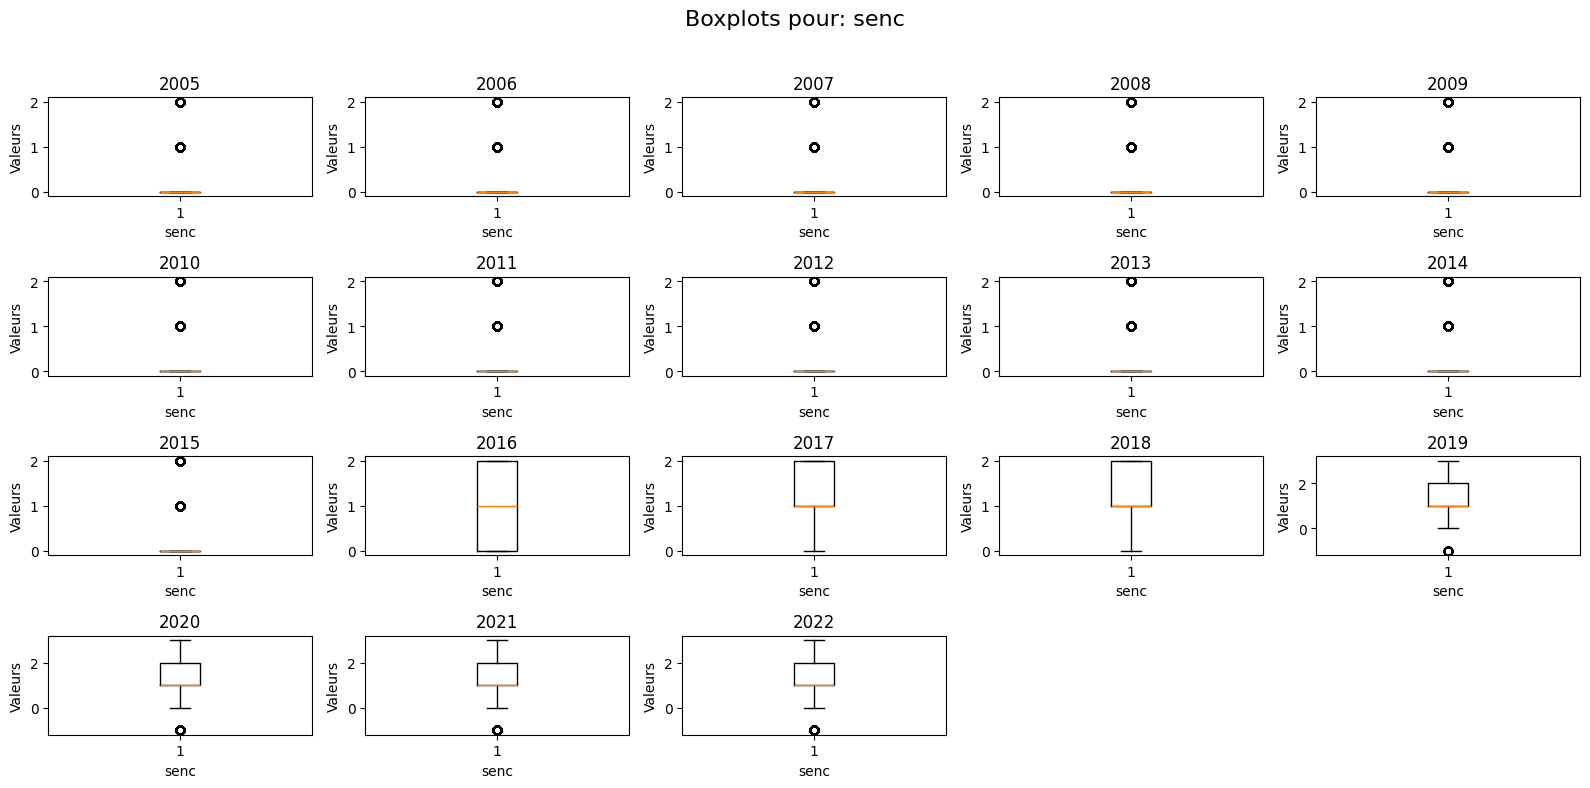

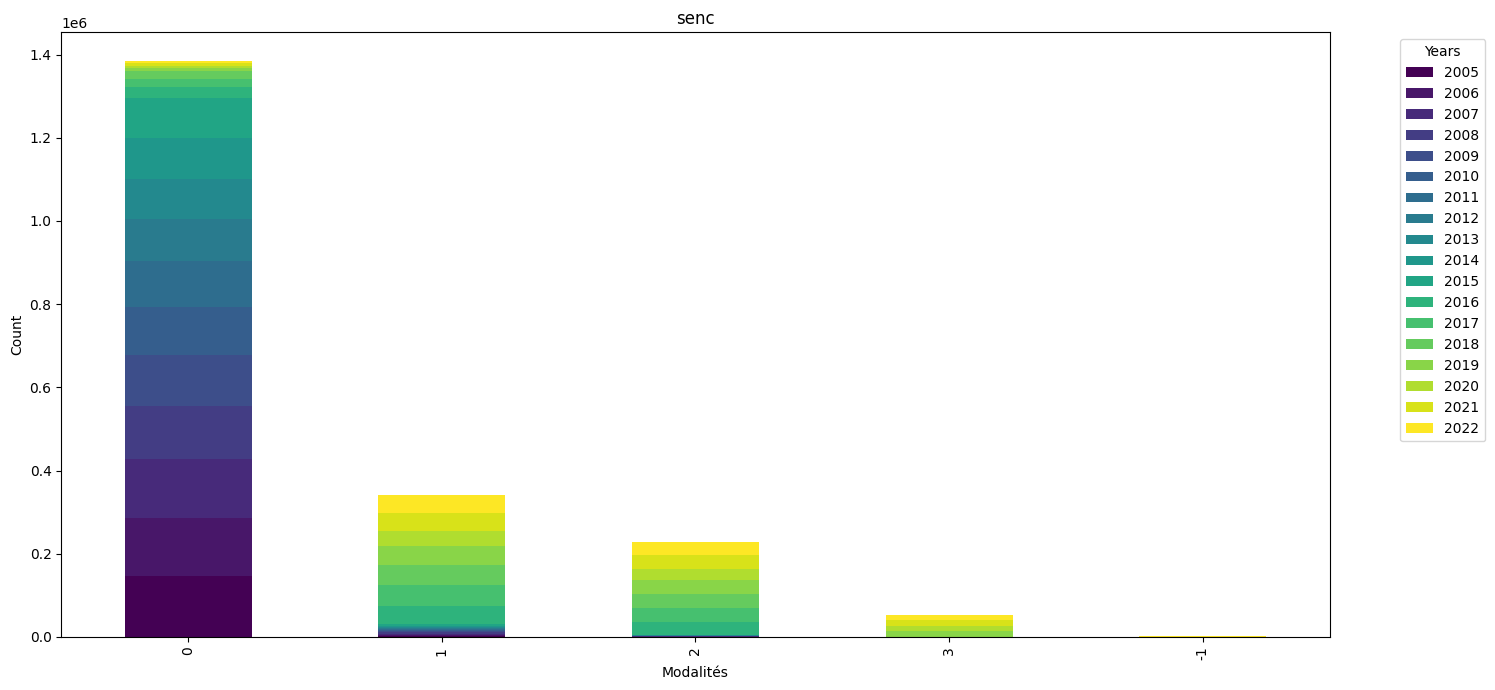

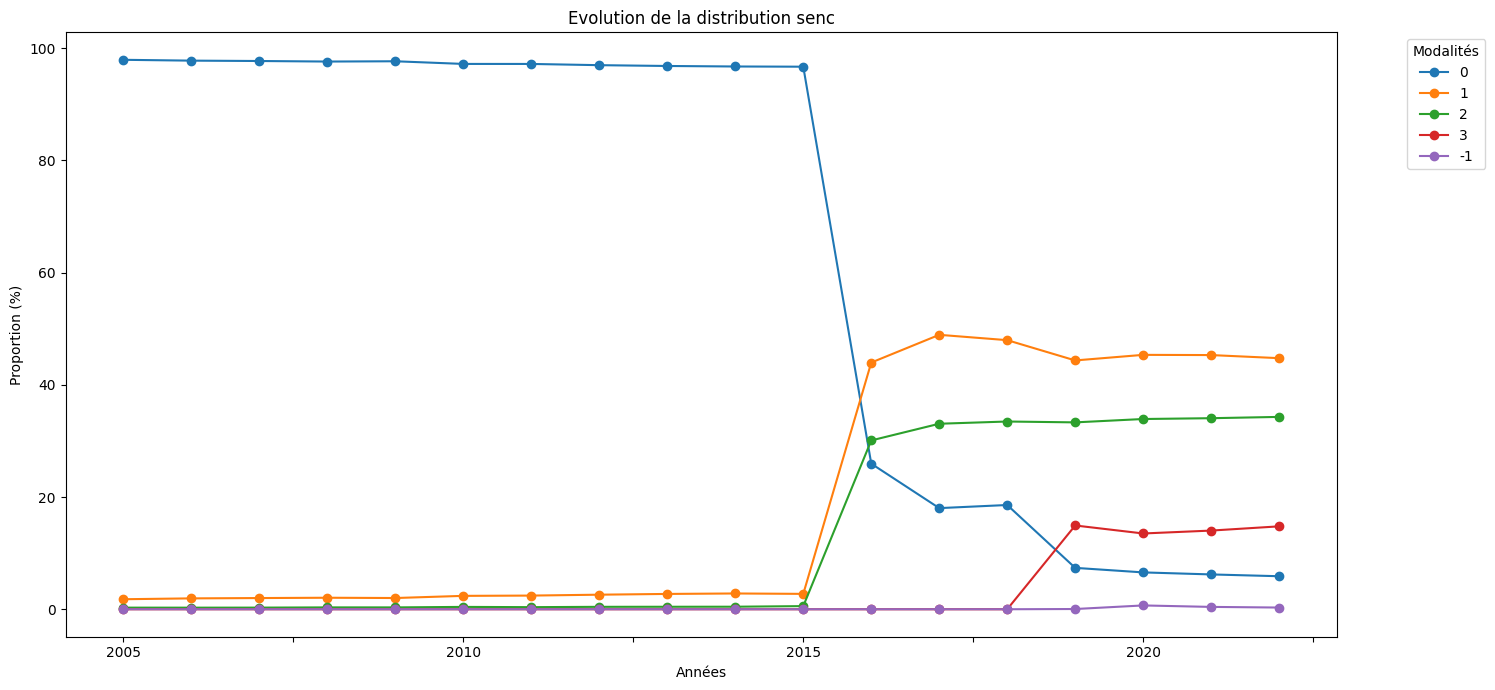

lignes: 2009395

Description: Manoeuvre principale avant l’accident :

Modalités:
- -1: Non renseigné
- 0: Inconnue
- 1: Sans changement de direction
- 2: Même sens, même file
- 3: Entre 2 files
- 4: En marche arrière
- 5: A contresens
- 6: En franchissant le terre-plein central
- 7: Dans le couloir bus, dans le même sens
- 8: Dans le couloir bus, dans le sens inverse
- 9: En s’insérant
- 10: En faisant demi-tour sur la chaussée
- 11: Changeant de file A gauche
- 12: Changeant de file A droite
- 13: Déporté A gauche
- 14: Déporté A droite
- 15: Tournant A gauche
- 16: Tournant A droite
- 17: Dépassant A gauche
- 18: Dépassant A droite
- 19: Traversant la chaussée
- 20: Manœuvre de stationnement
- 21: Manœuvre d’évitement
- 22: Ouverture de porte
- 23: Arrêté (hors stationnement)
- 24: En stationnement (avec occupants
- 25: Circulant sur trottoir
- 26: Autres manœuvres
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  

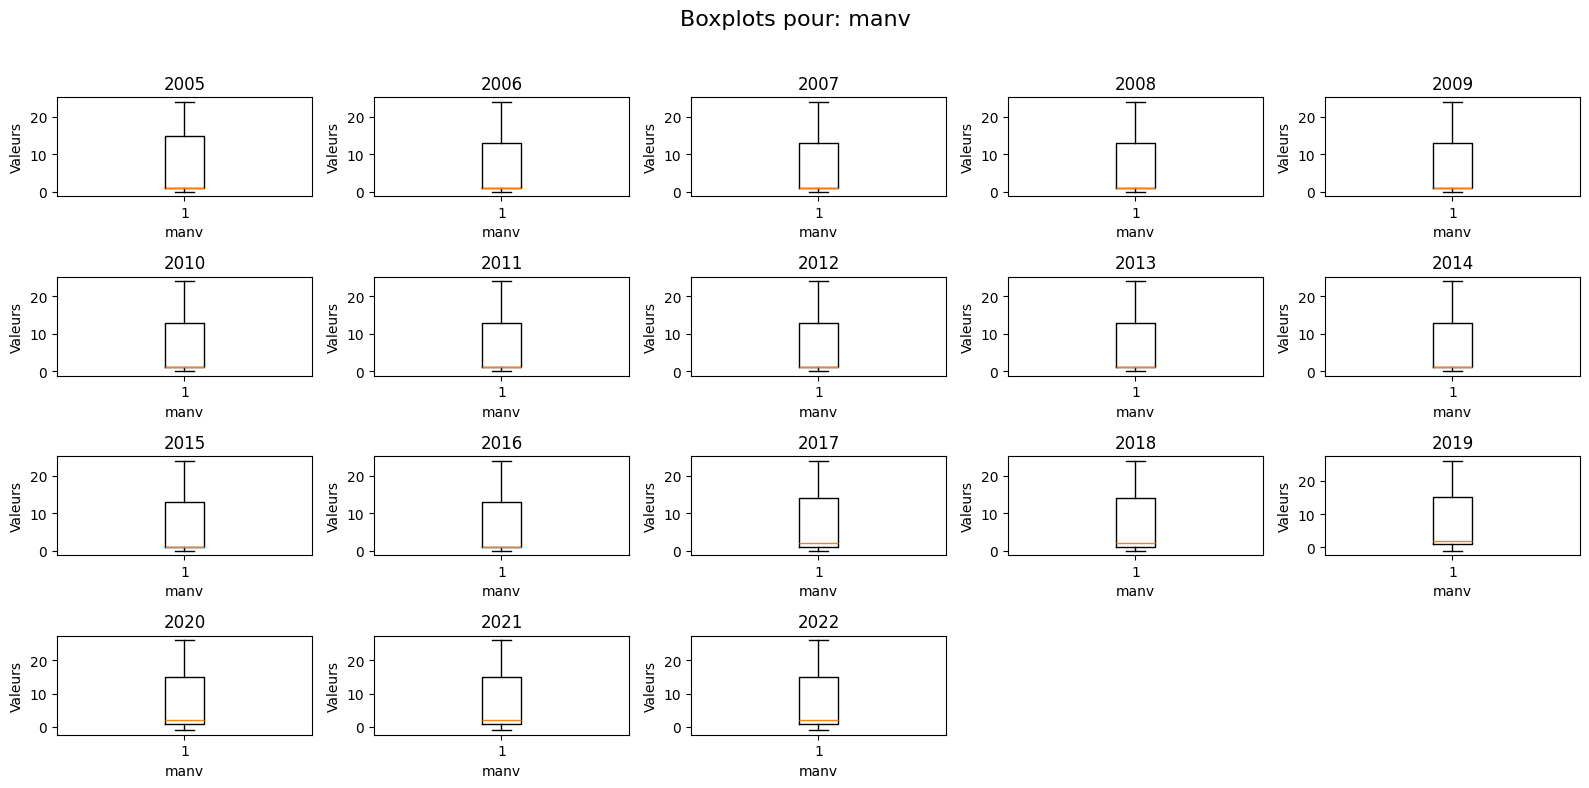

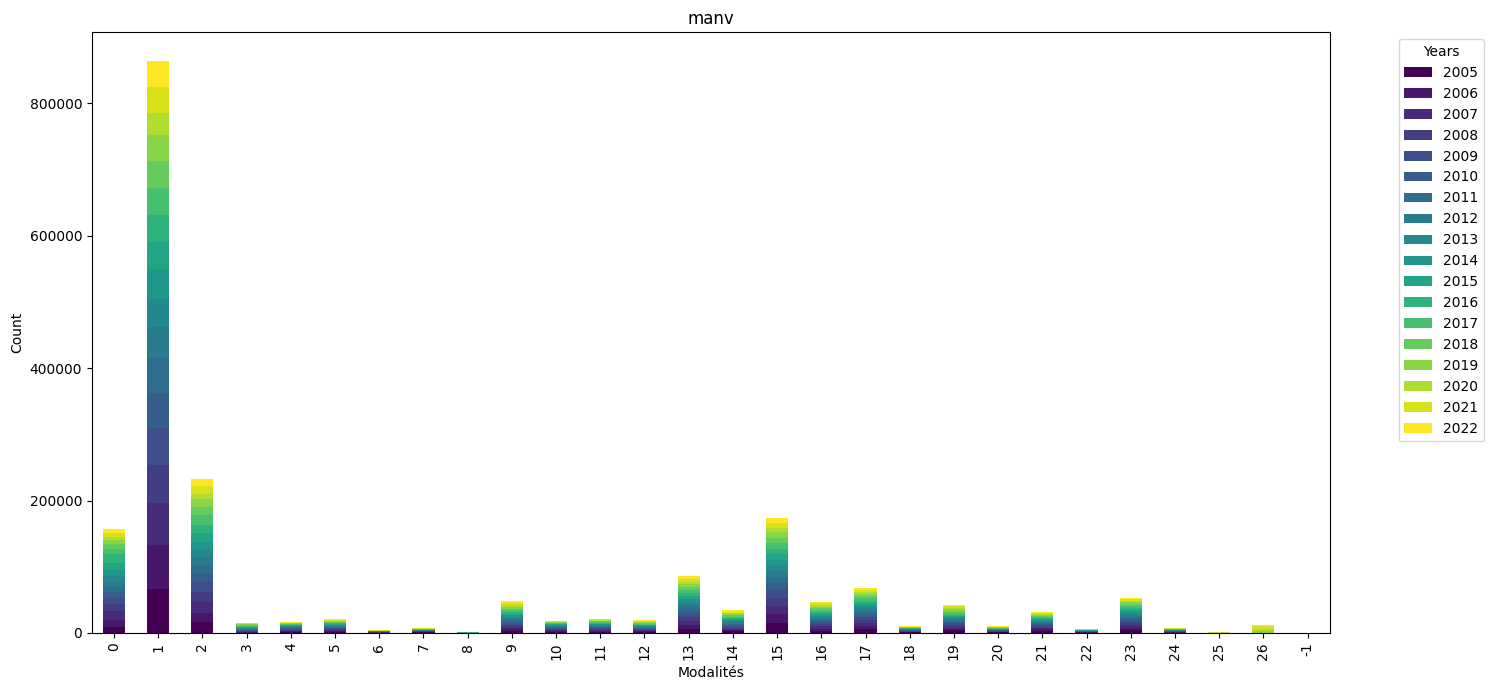

2024-06-12 13:27:16,614 - WARNING - Le nombre de modalités uniques dans la colonne manv excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 2009395

Description: Identifiant de l’accident identique à celui du fichier "rubrique CARACTERISTIQUES" repris pour chacun des véhicules décrits impliqués dans l’accident.
  Année  Type         Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ---------  -------------------------------------  -----------------------------------
   2005  int64   2.005e+11                                      0                                    0
   2006  int64   2.006e+11                                      0                                    0
   2007  int64   2.007e+11                                      0                                    0
   2008  int64   2.008e+11                                      0                                    0
   2009  int64   2.009e+11                                      0                                    0
   2010  int64   2.01e+11                                       0                                 

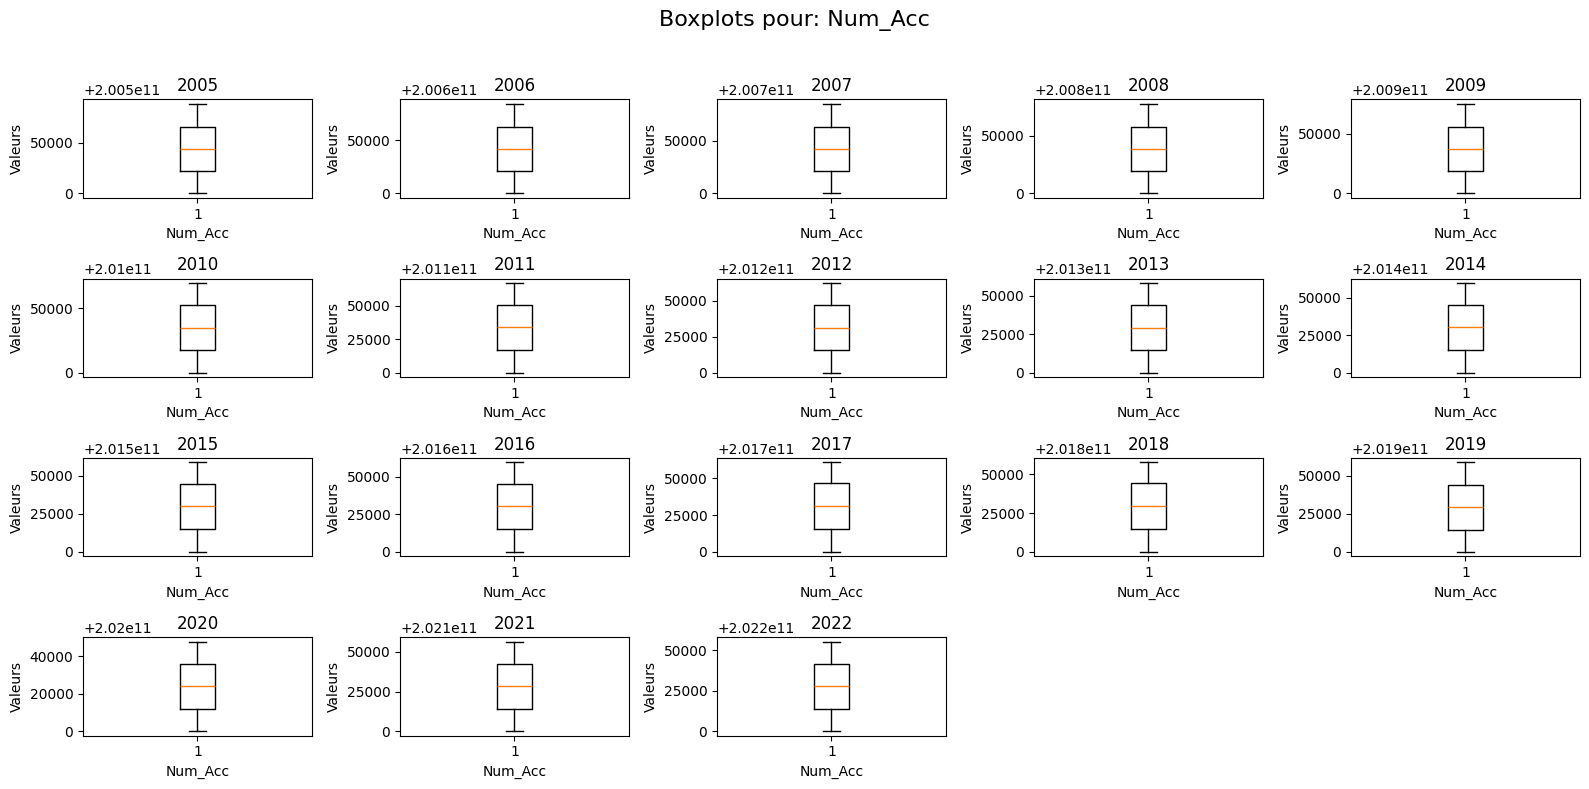

2024-06-12 13:27:19,281 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:27:19,664 - WARNING - Le nombre de modalités uniques dans la colonne Num_Acc excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 2009395

Description: Nombre d’occupants dans le transport en commun.
  Année  Type       Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  -------  ------  -------------------------------------  -----------------------------------
   2005  int64         0                                 0                                 0
   2006  int64         0                                 0                                 0
   2007  int64         0                                 0                                 0
   2008  int64         0                                 0                                 0
   2009  int64         0                                 0                                 0
   2010  int64         0                                 0                                 0
   2011  int64         0                                 0                                 0
   2012  int64         0                                 0           

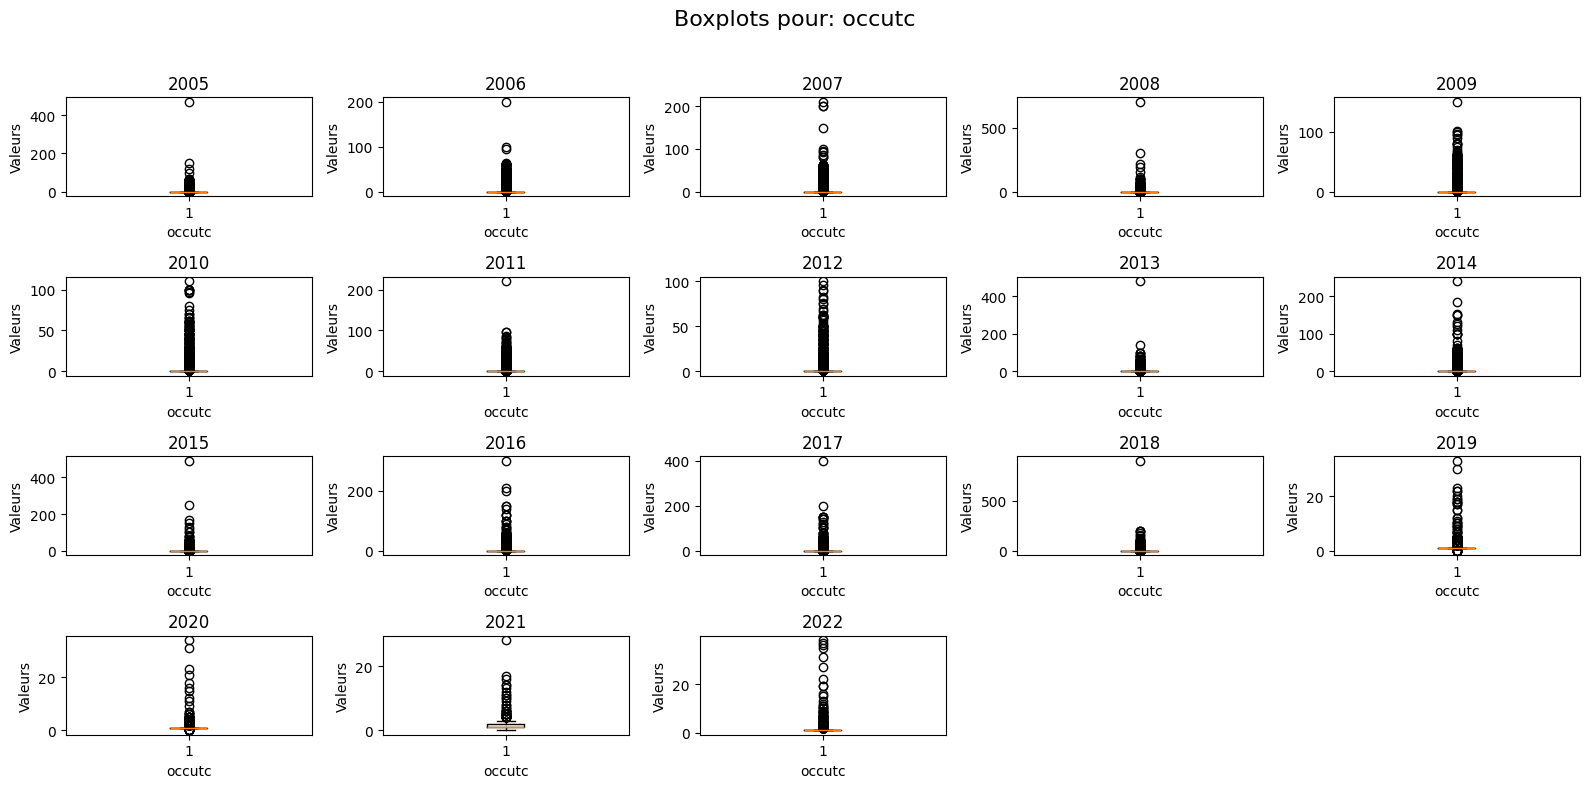

2024-06-12 13:27:21,528 - WARNING - Le nombre de modalités uniques dans la colonne occutc excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:27:21,550 - WARNING - Le nombre de modalités uniques dans la colonne occutc excède le seuil de 12. Aucun graphique en ligne généré.


lignes: 2009395

Description: Type de motorisation du véhicule :

Modalités:
- -1: Non renseigné
- 0: Inconnue
- 1: Hydrocarbures
- 2: Hybride électrique
- 3: Electrique
- 4: Hydrogène
- 5: Humaine
- 6: Autre
  Année  Type      Mode    Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  ------  -------------------------------------  -----------------------------------
   2019  int64        1                                      0                                    0
   2020  int64        1                                      0                                    0
   2021  int64        1                                      0                                    0
   2022  int64        1                                      0                                    0


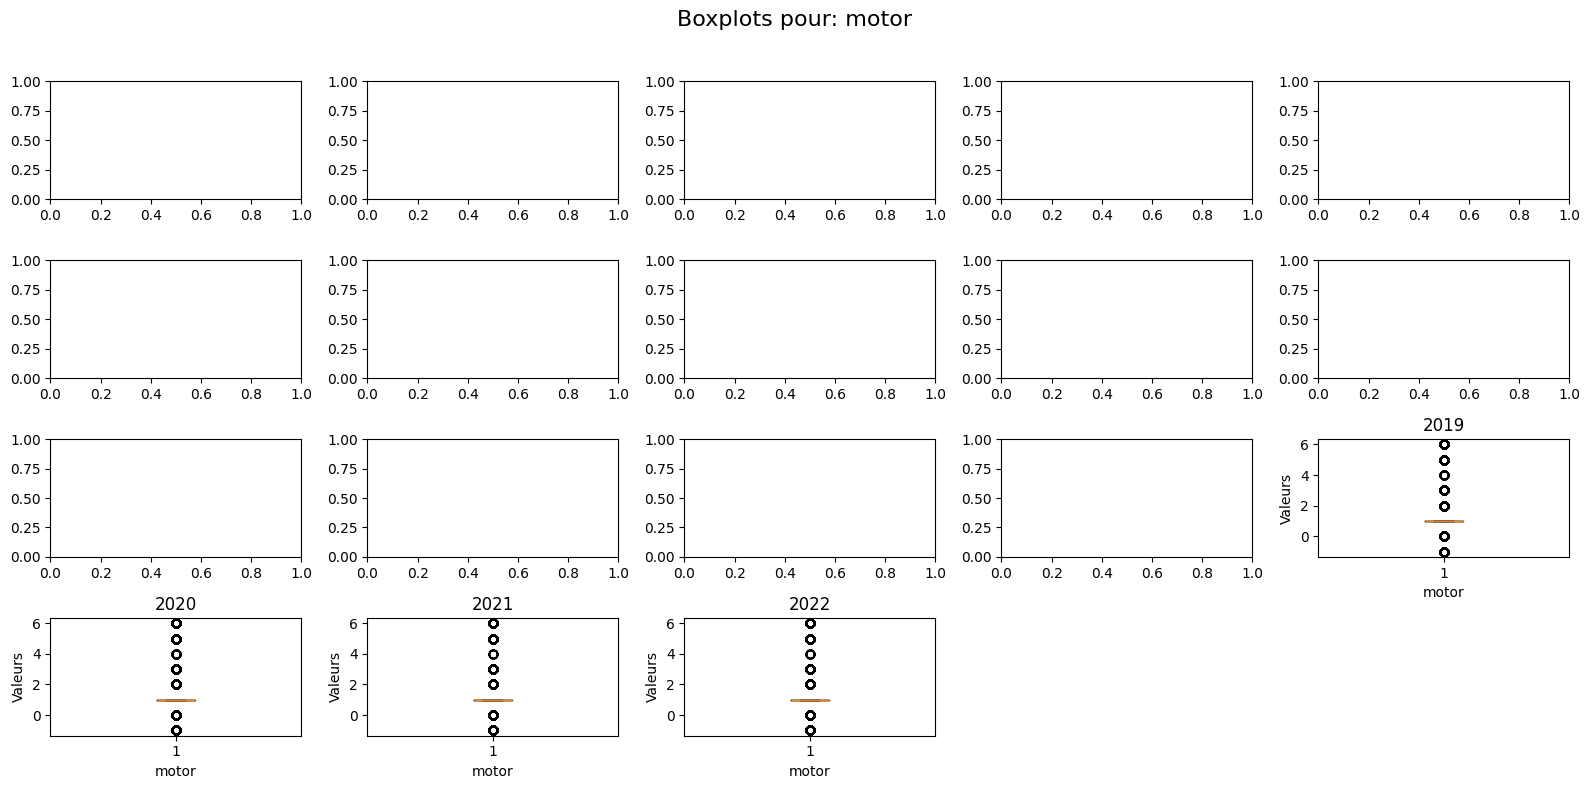

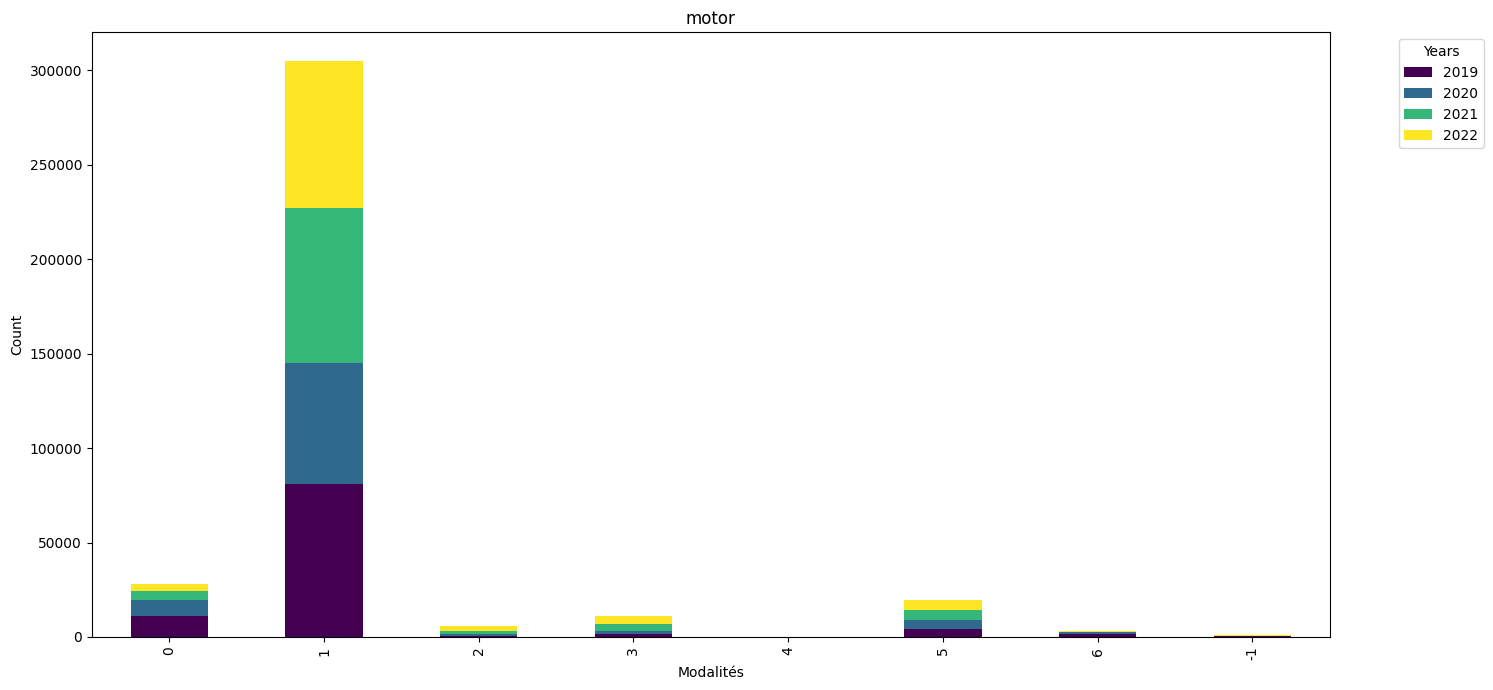

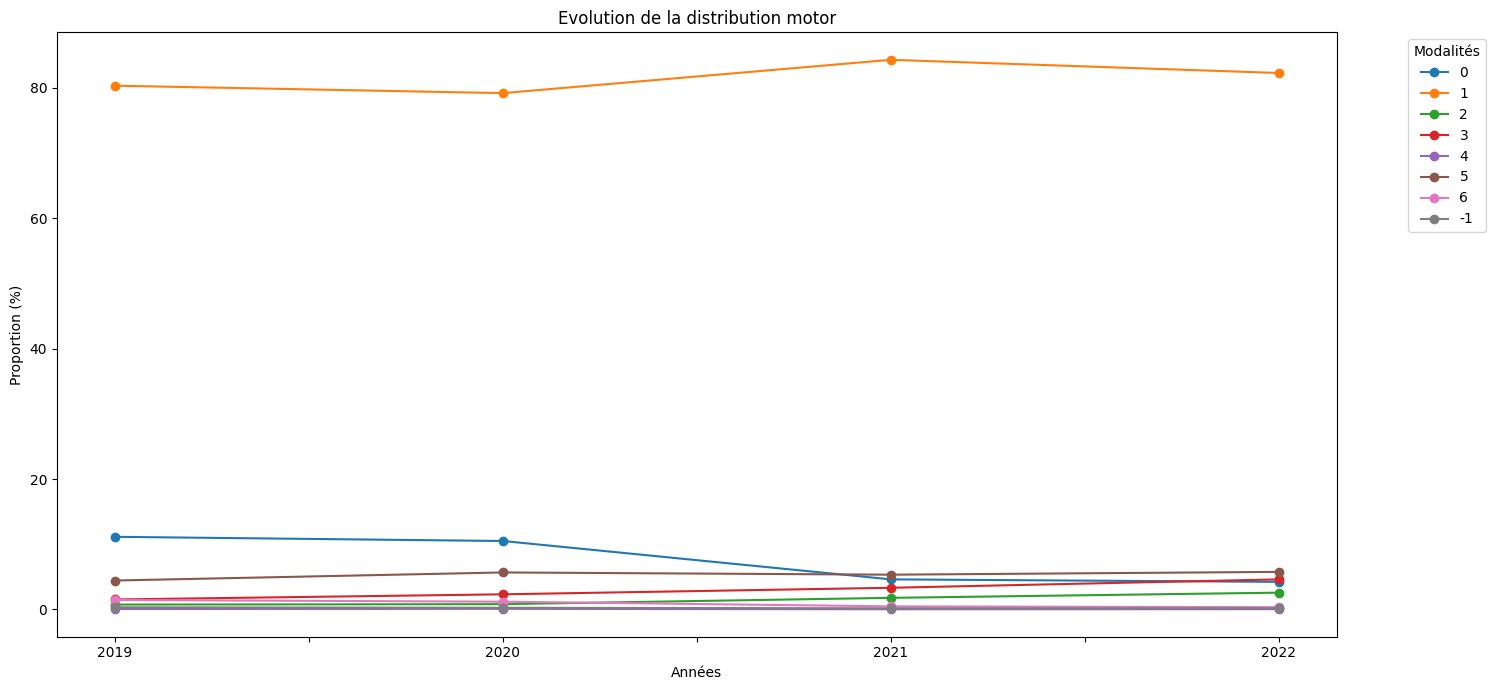

2024-06-12 13:27:25,524 - INFO - La colonne id_vehicule n'est pas numérique.


lignes: 2009395

Description: Identifiant unique du véhicule repris pour chacun des usagers occupant ce véhicule – Code numérique.
  Année  Type    Mode           Proportion valeurs nulles (fichier)    Proportion valeurs nulles (total)
-------  ------  -----------  -------------------------------------  -----------------------------------
   2019  object  137 982 129                                      0                                    0
   2020  object  154 658 350                                      0                                    0
   2021  object  100 882                                          0                                    0
   2022  object  715 629                                          0                                    0


2024-06-12 13:27:26,062 - WARNING - Le nombre de modalités uniques dans la colonne id_vehicule excède le seuil de 50. Auncun bar plot généré.
2024-06-12 13:27:26,469 - WARNING - Le nombre de modalités uniques dans la colonne id_vehicule excède le seuil de 12. Aucun graphique en ligne généré.


In [190]:
with open(PATH_TO_JSON, encoding= 'utf-8') as f:
    descvar = json.load(f)

for dataset_name, datasets in zip(prefixes, dataframes):
    analyze_all_columns(datasets, dataset_name, descvar= descvar)